In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
n = 300 #number of observations
p = 5 #number of parameters (dimension of B)
alpha = 20
v = 150

B is generated from a normal distribution centered at 0 with standard variation 1/alpha.

In [ ]:
B = np.random.normal(0, 1/alpha, size=(p, 1))
B

array([[-0.00654702],
       [-0.04948604],
       [ 0.00491547],
       [-0.02540637],
       [ 0.03825346]])

Here, we generate design matrix X with bias term.

In [ ]:
X = np.random.normal(10, 8, size=(n, p-1))
X0 = np.ones((n,1))
X = np.hstack((X0, X))
X.shape

(300, 5)

Here, E is the noise term, which we generate from another normal distribution centered at 0 with variance 1/nu.

In [ ]:
E = np.random.normal(0, 1/v, size=(n, 1))
E.shape

(300, 1)

In [ ]:
Y = X@B + E
Y.shape

(300, 1)

In [ ]:
import torch
import torch.nn as nn

Convert all matrices to PyTorch tensor

In [ ]:
X = torch.from_numpy(X)

In [ ]:
Y = torch.from_numpy(Y)

In [ ]:
B = torch.from_numpy(B)

In [ ]:
I_p = torch.from_numpy(np.identity(p))

In [ ]:
I_n = torch.from_numpy(np.identity(n))

Test whether the `backward()` method in PyTorch compute gradient correctly

In [ ]:
alpha_i = torch.tensor([1.], requires_grad=True)
v_i = torch.tensor([1.], requires_grad=True)

In [ ]:
Q = torch.linalg.slogdet(1/v_i * I_n + 1/alpha_i * torch.mm(X, torch.transpose(X, 0, 1)))[1]+torch.mm(torch.mm(torch.transpose(Y, 0, 1), torch.linalg.inv(1/v_i * I_n + 1/alpha_i * torch.mm(X, torch.transpose(X, 0, 1)))), Y)

In [ ]:
Q

tensor([[48.8421]], dtype=torch.float64, grad_fn=<AddBackward0>)

In [ ]:
Q.sum().backward()

In [ ]:
alpha_i.grad, v_i.grad

(tensor([-4.9723]), tensor([-594.9843]))

Try to use woodbury inversion lemma to speed up the computation of an inverse matrix, but although Q is the same as Q2, the gradiant for nu is very different. ⚠️

In [ ]:
alpha_ii = torch.tensor([1.], requires_grad=True)
v_ii = torch.tensor([1.], requires_grad=True)

In [ ]:
# cov_matrix = 1/v * I_n + 1 / alpha * X @ X.T
# mini_inv_matrix = np.linalg.inv(alpha * I_p + 1/ v * X.T @ X)
# inv_cov_matrix = v * I_n - v**2 * X @ mini_inv_matrix @ X.T
mini_inv_matrix_2 = torch.linalg.inv(alpha_ii * I_p + (1/v_ii) * torch.mm(torch.transpose(X,0,1), X))
inv_cov_matrix_2 = v_ii * I_n - torch.pow(v_ii, 2) * torch.mm(torch.mm(X, mini_inv_matrix_2), torch.transpose(X,0,1))
Q_2 = torch.linalg.slogdet(1/v_ii * I_n + 1/alpha_ii * torch.mm(X, torch.transpose(X, 0, 1)))[1]+torch.mm(torch.mm(torch.transpose(Y, 0, 1), inv_cov_matrix_2), Y)

In [ ]:
Q_2

tensor([[48.8421]], dtype=torch.float64, grad_fn=<AddBackward0>)

In [ ]:
Q_2.sum().backward()

In [ ]:
alpha_ii.grad, v_ii.grad

(tensor([-4.9723]), tensor([-2181.7092]))

Write a method that compute the gradient by definition to approximate the true answer, and compare it to our PyTorch output to see whether the results are similar

In [ ]:
def compute_Q_grad(v, alpha, Q, old_v, old_alpha):
  new_Q = torch.linalg.slogdet(1/v * I_n + 1/alpha * torch.mm(X, torch.transpose(X, 0, 1)))[1]+torch.mm(torch.mm(torch.transpose(Y, 0, 1), torch.linalg.inv(1/v * I_n + 1/alpha * torch.mm(X, torch.transpose(X, 0, 1)))), Y)
  if v == old_v:
    return (new_Q-Q)/(alpha-old_alpha)
  else:
    return (new_Q-Q)/(v-old_v)

In [ ]:
#compute gradient for v
compute_Q_grad(torch.tensor([1.0001], requires_grad=True), alpha_i, Q, v_i, alpha_i)

tensor([[-595.0140]], dtype=torch.float64, grad_fn=<DivBackward0>)

In [ ]:
#compute gradient for alpha
compute_Q_grad(v_i, torch.tensor([1.0001], requires_grad=True), Q, v_i, alpha_i)

tensor([[-4.9725]], dtype=torch.float64, grad_fn=<DivBackward0>)

We can observe that the results are close to the one we compute with PyTorch, which means our method is correct

Use gradient descent to find the estimated alpha and nu

In [ ]:
from tqdm import tqdm

In [ ]:
learning_rate = 0.01
max_iterations = 10000
tolerance = 2

# Initial parameter values
alpha = torch.tensor([1.], requires_grad=True)
v = torch.tensor([1.], requires_grad=True)

for i in tqdm(range(max_iterations)):
    # Compute the gradient
    I_p = torch.from_numpy(np.identity(p))
    I_n = torch.from_numpy(np.identity(n))
    # mini_inv_matrix = torch.linalg.inv(alpha * I_p + 1/ v * torch.mm(torch.transpose(X,0,1), X))
    # inv_cov_matrix = v * I_n - torch.pow(v, 2) * torch.mm(torch.mm(X,mini_inv_matrix), torch.transpose(X,0,1))
    # Q = torch.linalg.slogdet(1/v * I_n + 1/alpha * torch.mm(X, torch.transpose(X, 0, 1)))[1]+torch.mm(torch.mm(torch.transpose(Y, 0, 1), inv_cov_matrix), Y)
    Q = torch.linalg.slogdet(1/v * I_n + 1/alpha * torch.mm(X, torch.transpose(X, 0, 1)))[1]+torch.mm(torch.mm(torch.transpose(Y, 0, 1), torch.linalg.inv(1/v * I_n + 1/alpha * torch.mm(X, torch.transpose(X, 0, 1)))), Y)
    comp_grad = Q.sum().backward()
    print('a_grad: ', alpha.grad)
    print('v_grad: ', v.grad)
    grad = torch.stack((alpha.grad, v.grad), dim = 0)
    #print(grad)

    # Update parameters using gradient ascent
    alpha = (alpha - learning_rate * alpha.grad).detach().clone().requires_grad_(True)
    print('a', alpha)
    v = (v - learning_rate * v.grad).detach().clone().requires_grad_(True)
    print('v', v)
    #print(torch.max(torch.abs(grad)))

    # Convergence check
    if torch.max(torch.abs(grad)) < tolerance:
        break

print(f"Estimated 'a': {alpha}")
print(f"Estimated 'v': {v}")

  0%|          | 10/10000 [00:00<03:32, 46.98it/s]

a_grad:  tensor([-4.9701])
v_grad:  tensor([-295.0119])
a tensor([1.0497], requires_grad=True)
v tensor([3.9501], requires_grad=True)
a_grad:  tensor([-4.7521])
v_grad:  tensor([-74.6696])
a tensor([1.0972], requires_grad=True)
v tensor([4.6968], requires_grad=True)
a_grad:  tensor([-4.5468])
v_grad:  tensor([-62.7964])
a tensor([1.1427], requires_grad=True)
v tensor([5.3248], requires_grad=True)
a_grad:  tensor([-4.3662])
v_grad:  tensor([-55.3890])
a tensor([1.1864], requires_grad=True)
v tensor([5.8787], requires_grad=True)
a_grad:  tensor([-4.2056])
v_grad:  tensor([-50.1689])
a tensor([1.2284], requires_grad=True)
v tensor([6.3804], requires_grad=True)
a_grad:  tensor([-4.0616])
v_grad:  tensor([-46.2230])
a tensor([1.2690], requires_grad=True)
v tensor([6.8426], requires_grad=True)
a_grad:  tensor([-3.9316])
v_grad:  tensor([-43.0996])
a tensor([1.3083], requires_grad=True)
v tensor([7.2736], requires_grad=True)
a_grad:  tensor([-3.8135])
v_grad:  tensor([-40.5449])
a tensor([1.3

  0%|          | 20/10000 [00:00<03:31, 47.13it/s]

a_grad:  tensor([-3.5144])
v_grad:  tensor([-34.9861])
a tensor([1.4547], requires_grad=True)
v tensor([8.7787], requires_grad=True)
a_grad:  tensor([-3.4295])
v_grad:  tensor([-33.5913])
a tensor([1.4890], requires_grad=True)
v tensor([9.1146], requires_grad=True)
a_grad:  tensor([-3.3504])
v_grad:  tensor([-32.3528])
a tensor([1.5225], requires_grad=True)
v tensor([9.4381], requires_grad=True)
a_grad:  tensor([-3.2766])
v_grad:  tensor([-31.2433])
a tensor([1.5553], requires_grad=True)
v tensor([9.7505], requires_grad=True)
a_grad:  tensor([-3.2075])
v_grad:  tensor([-30.2417])
a tensor([1.5874], requires_grad=True)
v tensor([10.0530], requires_grad=True)
a_grad:  tensor([-3.1427])
v_grad:  tensor([-29.3316])
a tensor([1.6188], requires_grad=True)
v tensor([10.3463], requires_grad=True)
a_grad:  tensor([-3.0816])
v_grad:  tensor([-28.4997])
a tensor([1.6496], requires_grad=True)
v tensor([10.6313], requires_grad=True)
a_grad:  tensor([-3.0239])
v_grad:  tensor([-27.7353])
a tensor([1

  0%|          | 30/10000 [00:00<03:34, 46.38it/s]

a_grad:  tensor([-2.8688])
v_grad:  tensor([-25.7676])
a tensor([1.7674], requires_grad=True)
v tensor([11.7004], requires_grad=True)
a_grad:  tensor([-2.8221])
v_grad:  tensor([-25.1998])
a tensor([1.7956], requires_grad=True)
v tensor([11.9524], requires_grad=True)
a_grad:  tensor([-2.7777])
v_grad:  tensor([-24.6682])
a tensor([1.8234], requires_grad=True)
v tensor([12.1990], requires_grad=True)
a_grad:  tensor([-2.7354])
v_grad:  tensor([-24.1691])
a tensor([1.8508], requires_grad=True)
v tensor([12.4407], requires_grad=True)
a_grad:  tensor([-2.6949])
v_grad:  tensor([-23.6993])
a tensor([1.8777], requires_grad=True)
v tensor([12.6777], requires_grad=True)
a_grad:  tensor([-2.6561])
v_grad:  tensor([-23.2561])
a tensor([1.9043], requires_grad=True)
v tensor([12.9103], requires_grad=True)
a_grad:  tensor([-2.6190])
v_grad:  tensor([-22.8369])
a tensor([1.9305], requires_grad=True)
v tensor([13.1386], requires_grad=True)
a_grad:  tensor([-2.5834])
v_grad:  tensor([-22.4397])
a tenso

  0%|          | 40/10000 [00:00<03:33, 46.71it/s]

a_grad:  tensor([-2.4848])
v_grad:  tensor([-21.3626])
a tensor([2.0318], requires_grad=True)
v tensor([14.0143], requires_grad=True)
a_grad:  tensor([-2.4544])
v_grad:  tensor([-21.0367])
a tensor([2.0564], requires_grad=True)
v tensor([14.2247], requires_grad=True)
a_grad:  tensor([-2.4250])
v_grad:  tensor([-20.7254])
a tensor([2.0806], requires_grad=True)
v tensor([14.4320], requires_grad=True)
a_grad:  tensor([-2.3967])
v_grad:  tensor([-20.4276])
a tensor([2.1046], requires_grad=True)
v tensor([14.6362], requires_grad=True)
a_grad:  tensor([-2.3694])
v_grad:  tensor([-20.1423])
a tensor([2.1283], requires_grad=True)
v tensor([14.8377], requires_grad=True)
a_grad:  tensor([-2.3430])
v_grad:  tensor([-19.8687])
a tensor([2.1517], requires_grad=True)
v tensor([15.0363], requires_grad=True)
a_grad:  tensor([-2.3174])
v_grad:  tensor([-19.6060])
a tensor([2.1749], requires_grad=True)
v tensor([15.2324], requires_grad=True)
a_grad:  tensor([-2.2927])
v_grad:  tensor([-19.3534])
a tenso

  0%|          | 45/10000 [00:00<03:33, 46.72it/s]

a_grad:  tensor([-2.2230])
v_grad:  tensor([-18.6508])
a tensor([2.2652], requires_grad=True)
v tensor([15.9923], requires_grad=True)
a_grad:  tensor([-2.2011])
v_grad:  tensor([-18.4332])
a tensor([2.2872], requires_grad=True)
v tensor([16.1766], requires_grad=True)
a_grad:  tensor([-2.1799])
v_grad:  tensor([-18.2230])
a tensor([2.3090], requires_grad=True)
v tensor([16.3589], requires_grad=True)
a_grad:  tensor([-2.1593])
v_grad:  tensor([-18.0198])
a tensor([2.3306], requires_grad=True)
v tensor([16.5391], requires_grad=True)
a_grad:  tensor([-2.1392])
v_grad:  tensor([-17.8233])
a tensor([2.3520], requires_grad=True)
v tensor([16.7173], requires_grad=True)
a_grad:  tensor([-2.1197])
v_grad:  tensor([-17.6332])
a tensor([2.3732], requires_grad=True)
v tensor([16.8936], requires_grad=True)
a_grad:  tensor([-2.1007])
v_grad:  tensor([-17.4490])
a tensor([2.3942], requires_grad=True)
v tensor([17.0681], requires_grad=True)
a_grad:  tensor([-2.0823])
v_grad:  tensor([-17.2705])
a tenso

  1%|          | 55/10000 [00:01<03:37, 45.69it/s]

tensor([-16.9293])
a tensor([2.4561], requires_grad=True)
v tensor([17.5811], requires_grad=True)
a_grad:  tensor([-2.0297])
v_grad:  tensor([-16.7662])
a tensor([2.4764], requires_grad=True)
v tensor([17.7488], requires_grad=True)
a_grad:  tensor([-2.0130])
v_grad:  tensor([-16.6077])
a tensor([2.4965], requires_grad=True)
v tensor([17.9148], requires_grad=True)
a_grad:  tensor([-1.9967])
v_grad:  tensor([-16.4536])
a tensor([2.5165], requires_grad=True)
v tensor([18.0794], requires_grad=True)
a_grad:  tensor([-1.9808])
v_grad:  tensor([-16.3037])
a tensor([2.5363], requires_grad=True)
v tensor([18.2424], requires_grad=True)
a_grad:  tensor([-1.9653])
v_grad:  tensor([-16.1579])
a tensor([2.5560], requires_grad=True)
v tensor([18.4040], requires_grad=True)
a_grad:  tensor([-1.9502])
v_grad:  tensor([-16.0159])
a tensor([2.5755], requires_grad=True)
v tensor([18.5642], requires_grad=True)
a_grad:  tensor([-1.9354])
v_grad:  tensor([-15.8776])
a tensor([2.5948], requires_grad=True)
v te

  1%|          | 65/10000 [00:01<04:12, 39.29it/s]

a_grad:  tensor([-1.8929])
v_grad:  tensor([-15.4833])
a tensor([2.6520], requires_grad=True)
v tensor([19.1913], requires_grad=True)
a_grad:  tensor([-1.8794])
v_grad:  tensor([-15.3583])
a tensor([2.6708], requires_grad=True)
v tensor([19.3449], requires_grad=True)
a_grad:  tensor([-1.8661])
v_grad:  tensor([-15.2363])
a tensor([2.6895], requires_grad=True)
v tensor([19.4972], requires_grad=True)
a_grad:  tensor([-1.8531])
v_grad:  tensor([-15.1171])
a tensor([2.7080], requires_grad=True)
v tensor([19.6484], requires_grad=True)
a_grad:  tensor([-1.8404])
v_grad:  tensor([-15.0007])
a tensor([2.7264], requires_grad=True)
v tensor([19.7984], requires_grad=True)
a_grad:  tensor([-1.8280])
v_grad:  tensor([-14.8869])
a tensor([2.7447], requires_grad=True)
v tensor([19.9473], requires_grad=True)
a_grad:  tensor([-1.8158])
v_grad:  tensor([-14.7757])
a tensor([2.7628], requires_grad=True)


  1%|          | 70/10000 [00:01<04:50, 34.19it/s]

v tensor([20.0951], requires_grad=True)
a_grad:  tensor([-1.8038])
v_grad:  tensor([-14.6670])
a tensor([2.7809], requires_grad=True)
v tensor([20.2417], requires_grad=True)
a_grad:  tensor([-1.7921])
v_grad:  tensor([-14.5606])
a tensor([2.7988], requires_grad=True)
v tensor([20.3873], requires_grad=True)
a_grad:  tensor([-1.7806])
v_grad:  tensor([-14.4565])
a tensor([2.8166], requires_grad=True)
v tensor([20.5319], requires_grad=True)
a_grad:  tensor([-1.7693])
v_grad:  tensor([-14.3546])
a tensor([2.8343], requires_grad=True)
v tensor([20.6754], requires_grad=True)
a_grad:  tensor([-1.7582])
v_grad:  tensor([-14.2549])
a tensor([2.8519], requires_grad=True)
v tensor([20.8180], requires_grad=True)


  1%|          | 74/10000 [00:01<05:02, 32.84it/s]

a_grad:  tensor([-1.7474])
v_grad:  tensor([-14.1572])
a tensor([2.8694], requires_grad=True)
v tensor([20.9596], requires_grad=True)
a_grad:  tensor([-1.7367])
v_grad:  tensor([-14.0615])
a tensor([2.8867], requires_grad=True)
v tensor([21.1002], requires_grad=True)
a_grad:  tensor([-1.7262])
v_grad:  tensor([-13.9677])
a tensor([2.9040], requires_grad=True)
v tensor([21.2399], requires_grad=True)
a_grad:  tensor([-1.7159])
v_grad:  tensor([-13.8757])
a tensor([2.9211], requires_grad=True)
v tensor([21.3786], requires_grad=True)
a_grad:  tensor([-1.7058])
v_grad:  tensor([-13.7856])
a tensor([2.9382], requires_grad=True)
v tensor([21.5165], requires_grad=True)
a_grad:  tensor([-1.6959])
v_grad:  tensor([-13.6972])
a tensor([2.9552], requires_grad=True)
v tensor([21.6534], requires_grad=True)


  1%|          | 82/10000 [00:02<05:55, 27.91it/s]

a_grad:  tensor([-1.6861])
v_grad:  tensor([-13.6104])
a tensor([2.9720], requires_grad=True)
v tensor([21.7895], requires_grad=True)
a_grad:  tensor([-1.6765])
v_grad:  tensor([-13.5253])
a tensor([2.9888], requires_grad=True)
v tensor([21.9248], requires_grad=True)
a_grad:  tensor([-1.6671])
v_grad:  tensor([-13.4418])
a tensor([3.0055], requires_grad=True)
v tensor([22.0592], requires_grad=True)
a_grad:  tensor([-1.6578])
v_grad:  tensor([-13.3598])
a tensor([3.0220], requires_grad=True)
v tensor([22.1928], requires_grad=True)
a_grad:  tensor([-1.6487])
v_grad:  tensor([-13.2793])
a tensor([3.0385], requires_grad=True)
v tensor([22.3256], requires_grad=True)


  1%|          | 85/10000 [00:02<06:03, 27.26it/s]

a_grad:  tensor([-1.6397])
v_grad:  tensor([-13.2003])
a tensor([3.0549], requires_grad=True)
v tensor([22.4576], requires_grad=True)
a_grad:  tensor([-1.6309])
v_grad:  tensor([-13.1226])
a tensor([3.0712], requires_grad=True)
v tensor([22.5888], requires_grad=True)
a_grad:  tensor([-1.6222])
v_grad:  tensor([-13.0463])
a tensor([3.0875], requires_grad=True)
v tensor([22.7193], requires_grad=True)
a_grad:  tensor([-1.6137])
v_grad:  tensor([-12.9713])
a tensor([3.1036], requires_grad=True)
v tensor([22.8490], requires_grad=True)
a_grad:  tensor([-1.6053])
v_grad:  tensor([-12.8976])
a tensor([3.1196], requires_grad=True)
v tensor([22.9780], requires_grad=True)


  1%|          | 91/10000 [00:02<06:42, 24.60it/s]

a_grad:  tensor([-1.5970])
v_grad:  tensor([-12.8251])
a tensor([3.1356], requires_grad=True)
v tensor([23.1062], requires_grad=True)
a_grad:  tensor([-1.5888])
v_grad:  tensor([-12.7538])
a tensor([3.1515], requires_grad=True)
v tensor([23.2338], requires_grad=True)
a_grad:  tensor([-1.5808])
v_grad:  tensor([-12.6838])
a tensor([3.1673], requires_grad=True)
v tensor([23.3606], requires_grad=True)
a_grad:  tensor([-1.5729])
v_grad:  tensor([-12.6148])
a tensor([3.1830], requires_grad=True)
v tensor([23.4868], requires_grad=True)
a_grad:  tensor([-1.5651])
v_grad:  tensor([-12.5470])
a tensor([3.1987], requires_grad=True)
v tensor([23.6122], requires_grad=True)

  1%|          | 98/10000 [00:02<06:12, 26.56it/s]


a_grad:  tensor([-1.5574])
v_grad:  tensor([-12.4803])
a tensor([3.2143], requires_grad=True)
v tensor([23.7370], requires_grad=True)
a_grad:  tensor([-1.5498])
v_grad:  tensor([-12.4146])
a tensor([3.2298], requires_grad=True)
v tensor([23.8612], requires_grad=True)
a_grad:  tensor([-1.5424])
v_grad:  tensor([-12.3499])
a tensor([3.2452], requires_grad=True)
v tensor([23.9847], requires_grad=True)
a_grad:  tensor([-1.5350])
v_grad:  tensor([-12.2862])
a tensor([3.2605], requires_grad=True)
v tensor([24.1075], requires_grad=True)
a_grad:  tensor([-1.5278])
v_grad:  tensor([-12.2236])
a tensor([3.2758], requires_grad=True)
v tensor([24.2298], requires_grad=True)
a_grad:  tensor([-1.5206])
v_grad:  tensor([-12.1618])
a tensor([3.2910], requires_grad=True)
v tensor([24.3514], requires_grad=True)


  1%|          | 105/10000 [00:03<05:37, 29.35it/s]

a_grad:  tensor([-1.5136])
v_grad:  tensor([-12.1010])
a tensor([3.3062], requires_grad=True)
v tensor([24.4724], requires_grad=True)
a_grad:  tensor([-1.5066])
v_grad:  tensor([-12.0411])
a tensor([3.3212], requires_grad=True)
v tensor([24.5928], requires_grad=True)
a_grad:  tensor([-1.4998])
v_grad:  tensor([-11.9821])
a tensor([3.3362], requires_grad=True)
v tensor([24.7126], requires_grad=True)
a_grad:  tensor([-1.4930])
v_grad:  tensor([-11.9239])
a tensor([3.3512], requires_grad=True)
v tensor([24.8319], requires_grad=True)
a_grad:  tensor([-1.4864])
v_grad:  tensor([-11.8666])
a tensor([3.3660], requires_grad=True)
v tensor([24.9505], requires_grad=True)
a_grad:  tensor([-1.4798])
v_grad:  tensor([-11.8101])
a tensor([3.3808], requires_grad=True)
v tensor([25.0686], requires_grad=True)
a_grad:  tensor([-1.4733])
v_grad:  tensor([-11.7544])
a tensor([3.3955], requires_grad=True)
v tensor([25.1862], requires_grad=True)


  1%|          | 109/10000 [00:03<05:29, 30.00it/s]

a_grad:  tensor([-1.4669])
v_grad:  tensor([-11.6995])
a tensor([3.4102], requires_grad=True)
v tensor([25.3032], requires_grad=True)
a_grad:  tensor([-1.4605])
v_grad:  tensor([-11.6453])
a tensor([3.4248], requires_grad=True)
v tensor([25.4196], requires_grad=True)
a_grad:  tensor([-1.4543])
v_grad:  tensor([-11.5919])
a tensor([3.4394], requires_grad=True)
v tensor([25.5356], requires_grad=True)
a_grad:  tensor([-1.4481])
v_grad:  tensor([-11.5392])
a tensor([3.4538], requires_grad=True)
v tensor([25.6509], requires_grad=True)
a_grad:  tensor([-1.4420])
v_grad:  tensor([-11.4873])
a tensor([3.4683], requires_grad=True)
v tensor([25.7658], requires_grad=True)
a_grad:  tensor([-1.4360])
v_grad:  tensor([-11.4360])
a tensor([3.4826], requires_grad=True)
v tensor([25.8802], requires_grad=True)
a_grad:  tensor([-1.4301])
v_grad:  tensor([-11.3854])
a tensor([3.4969], requires_grad=True)
v tensor([25.9940], requires_grad=True)


  1%|          | 117/10000 [00:03<05:03, 32.53it/s]

a_grad:  tensor([-1.4242])
v_grad:  tensor([-11.3355])
a tensor([3.5112], requires_grad=True)
v tensor([26.1074], requires_grad=True)
a_grad:  tensor([-1.4184])
v_grad:  tensor([-11.2862])
a tensor([3.5254], requires_grad=True)
v tensor([26.2203], requires_grad=True)
a_grad:  tensor([-1.4127])
v_grad:  tensor([-11.2376])
a tensor([3.5395], requires_grad=True)
v tensor([26.3326], requires_grad=True)
a_grad:  tensor([-1.4070])
v_grad:  tensor([-11.1895])
a tensor([3.5535], requires_grad=True)
v tensor([26.4445], requires_grad=True)
a_grad:  tensor([-1.4014])
v_grad:  tensor([-11.1421])
a tensor([3.5676], requires_grad=True)
v tensor([26.5559], requires_grad=True)
a_grad:  tensor([-1.3959])
v_grad:  tensor([-11.0953])
a tensor([3.5815], requires_grad=True)
v tensor([26.6669], requires_grad=True)
a_grad:  tensor([-1.3905])
v_grad:  tensor([-11.0491])
a tensor([3.5954], requires_grad=True)
v tensor([26.7774], requires_grad=True)


  1%|▏         | 125/10000 [00:03<04:52, 33.78it/s]

a_grad:  tensor([-1.3851])
v_grad:  tensor([-11.0035])
a tensor([3.6093], requires_grad=True)
v tensor([26.8874], requires_grad=True)
a_grad:  tensor([-1.3797])
v_grad:  tensor([-10.9584])
a tensor([3.6231], requires_grad=True)
v tensor([26.9970], requires_grad=True)
a_grad:  tensor([-1.3745])
v_grad:  tensor([-10.9138])
a tensor([3.6368], requires_grad=True)
v tensor([27.1061], requires_grad=True)
a_grad:  tensor([-1.3692])
v_grad:  tensor([-10.8699])
a tensor([3.6505], requires_grad=True)
v tensor([27.2148], requires_grad=True)
a_grad:  tensor([-1.3641])
v_grad:  tensor([-10.8264])
a tensor([3.6642], requires_grad=True)
v tensor([27.3231], requires_grad=True)
a_grad:  tensor([-1.3590])
v_grad:  tensor([-10.7834])
a tensor([3.6777], requires_grad=True)
v tensor([27.4309], requires_grad=True)
a_grad:  tensor([-1.3540])
v_grad:  tensor([-10.7410])
a tensor([3.6913], requires_grad=True)
v tensor([27.5383], requires_grad=True)
a_grad:  tensor([-1.3490])
v_grad:  tensor([-10.6990])
a tenso

  1%|▏         | 133/10000 [00:03<04:45, 34.60it/s]

 tensor([27.6453], requires_grad=True)
a_grad:  tensor([-1.3440])
v_grad:  tensor([-10.6576])
a tensor([3.7182], requires_grad=True)
v tensor([27.7519], requires_grad=True)
a_grad:  tensor([-1.3392])
v_grad:  tensor([-10.6166])
a tensor([3.7316], requires_grad=True)
v tensor([27.8581], requires_grad=True)
a_grad:  tensor([-1.3344])
v_grad:  tensor([-10.5761])
a tensor([3.7449], requires_grad=True)
v tensor([27.9638], requires_grad=True)
a_grad:  tensor([-1.3296])
v_grad:  tensor([-10.5360])
a tensor([3.7582], requires_grad=True)
v tensor([28.0692], requires_grad=True)
a_grad:  tensor([-1.3249])
v_grad:  tensor([-10.4964])
a tensor([3.7715], requires_grad=True)
v tensor([28.1742], requires_grad=True)
a_grad:  tensor([-1.3202])
v_grad:  tensor([-10.4573])
a tensor([3.7847], requires_grad=True)
v tensor([28.2787], requires_grad=True)
a_grad:  tensor([-1.3156])
v_grad:  tensor([-10.4186])
a tensor([3.7979], requires_grad=True)
v tensor([28.3829], requires_grad=True)


  1%|▏         | 141/10000 [00:04<04:47, 34.25it/s]

a_grad:  tensor([-1.3110])
v_grad:  tensor([-10.3803])
a tensor([3.8110], requires_grad=True)
v tensor([28.4867], requires_grad=True)
a_grad:  tensor([-1.3065])
v_grad:  tensor([-10.3424])
a tensor([3.8240], requires_grad=True)
v tensor([28.5902], requires_grad=True)
a_grad:  tensor([-1.3020])
v_grad:  tensor([-10.3049])
a tensor([3.8370], requires_grad=True)
v tensor([28.6932], requires_grad=True)
a_grad:  tensor([-1.2976])
v_grad:  tensor([-10.2679])
a tensor([3.8500], requires_grad=True)
v tensor([28.7959], requires_grad=True)
a_grad:  tensor([-1.2932])
v_grad:  tensor([-10.2312])
a tensor([3.8630], requires_grad=True)
v tensor([28.8982], requires_grad=True)
a_grad:  tensor([-1.2888])
v_grad:  tensor([-10.1950])
a tensor([3.8758], requires_grad=True)
v tensor([29.0001], requires_grad=True)
a_grad:  tensor([-1.2845])
v_grad:  tensor([-10.1591])
a tensor([3.8887], requires_grad=True)
v tensor([29.1017], requires_grad=True)


  1%|▏         | 145/10000 [00:04<04:44, 34.70it/s]

a_grad:  tensor([-1.2803])
v_grad:  tensor([-10.1236])
a tensor([3.9015], requires_grad=True)
v tensor([29.2030], requires_grad=True)
a_grad:  tensor([-1.2760])
v_grad:  tensor([-10.0884])
a tensor([3.9142], requires_grad=True)
v tensor([29.3039], requires_grad=True)
a_grad:  tensor([-1.2719])
v_grad:  tensor([-10.0536])
a tensor([3.9270], requires_grad=True)
v tensor([29.4044], requires_grad=True)
a_grad:  tensor([-1.2677])
v_grad:  tensor([-10.0192])
a tensor([3.9396], requires_grad=True)
v tensor([29.5046], requires_grad=True)
a_grad:  tensor([-1.2636])
v_grad:  tensor([-9.9851])
a tensor([3.9523], requires_grad=True)
v tensor([29.6044], requires_grad=True)
a_grad:  tensor([-1.2596])
v_grad:  tensor([-9.9514])
a tensor([3.9649], requires_grad=True)
v tensor([29.7039], requires_grad=True)
a_grad:  tensor([-1.2556])
v_grad:  tensor([-9.9180])
a tensor([3.9774], requires_grad=True)
v tensor([29.8031], requires_grad=True)
a_grad:  tensor([-1.2516])
v_grad:  tensor([-9.8850])
a tensor([3

  2%|▏         | 157/10000 [00:04<04:37, 35.46it/s]

a_grad:  tensor([-1.2477])
v_grad:  tensor([-9.8523])
a tensor([4.0024], requires_grad=True)
v tensor([30.0005], requires_grad=True)
a_grad:  tensor([-1.2438])
v_grad:  tensor([-9.8199])
a tensor([4.0149], requires_grad=True)
v tensor([30.0987], requires_grad=True)
a_grad:  tensor([-1.2399])
v_grad:  tensor([-9.7878])
a tensor([4.0273], requires_grad=True)
v tensor([30.1966], requires_grad=True)
a_grad:  tensor([-1.2361])
v_grad:  tensor([-9.7560])
a tensor([4.0396], requires_grad=True)
v tensor([30.2941], requires_grad=True)
a_grad:  tensor([-1.2323])
v_grad:  tensor([-9.7246])
a tensor([4.0519], requires_grad=True)
v tensor([30.3914], requires_grad=True)
a_grad:  tensor([-1.2285])
v_grad:  tensor([-9.6934])
a tensor([4.0642], requires_grad=True)
v tensor([30.4883], requires_grad=True)
a_grad:  tensor([-1.2248])
v_grad:  tensor([-9.6625])
a tensor([4.0765], requires_grad=True)
v tensor([30.5849], requires_grad=True)
a_grad:  tensor([-1.2211])
v_grad:  tensor([-9.6320])
a tensor([4.088

  2%|▏         | 161/10000 [00:04<04:44, 34.56it/s]

a_grad:  tensor([-1.2174])
v_grad:  tensor([-9.6017])
a tensor([4.1009], requires_grad=True)
v tensor([30.7773], requires_grad=True)
a_grad:  tensor([-1.2138])
v_grad:  tensor([-9.5717])
a tensor([4.1130], requires_grad=True)
v tensor([30.8730], requires_grad=True)
a_grad:  tensor([-1.2102])
v_grad:  tensor([-9.5420])
a tensor([4.1251], requires_grad=True)
v tensor([30.9684], requires_grad=True)
a_grad:  tensor([-1.2066])
v_grad:  tensor([-9.5125])
a tensor([4.1372], requires_grad=True)
v tensor([31.0635], requires_grad=True)
a_grad:  tensor([-1.2031])
v_grad:  tensor([-9.4834])
a tensor([4.1492], requires_grad=True)
v tensor([31.1584], requires_grad=True)
a_grad:  tensor([-1.1996])
v_grad:  tensor([-9.4545])
a tensor([4.1612], requires_grad=True)
v tensor([31.2529], requires_grad=True)
a_grad:  tensor([-1.1961])
v_grad:  tensor([-9.4258])
a tensor([4.1732], requires_grad=True)
v tensor([31.3472], requires_grad=True)


  2%|▏         | 169/10000 [00:04<04:41, 34.98it/s]

a_grad:  tensor([-1.1927])
v_grad:  tensor([-9.3974])
a tensor([4.1851], requires_grad=True)
v tensor([31.4411], requires_grad=True)
a_grad:  tensor([-1.1893])
v_grad:  tensor([-9.3693])
a tensor([4.1970], requires_grad=True)
v tensor([31.5348], requires_grad=True)
a_grad:  tensor([-1.1859])
v_grad:  tensor([-9.3414])
a tensor([4.2088], requires_grad=True)
v tensor([31.6283], requires_grad=True)
a_grad:  tensor([-1.1825])
v_grad:  tensor([-9.3138])
a tensor([4.2207], requires_grad=True)
v tensor([31.7214], requires_grad=True)
a_grad:  tensor([-1.1792])
v_grad:  tensor([-9.2864])
a tensor([4.2325], requires_grad=True)
v tensor([31.8143], requires_grad=True)
a_grad:  tensor([-1.1759])
v_grad:  tensor([-9.2593])
a tensor([4.2442], requires_grad=True)
v tensor([31.9069], requires_grad=True)
a_grad:  tensor([-1.1726])
v_grad:  tensor([-9.2324])
a tensor([4.2559], requires_grad=True)
v tensor([31.9992], requires_grad=True)


  2%|▏         | 177/10000 [00:05<04:46, 34.27it/s]

a_grad:  tensor([-1.1694])
v_grad:  tensor([-9.2057])
a tensor([4.2676], requires_grad=True)
v tensor([32.0912], requires_grad=True)
a_grad:  tensor([-1.1662])
v_grad:  tensor([-9.1792])
a tensor([4.2793], requires_grad=True)
v tensor([32.1830], requires_grad=True)
a_grad:  tensor([-1.1630])
v_grad:  tensor([-9.1530])
a tensor([4.2909], requires_grad=True)
v tensor([32.2746], requires_grad=True)
a_grad:  tensor([-1.1598])
v_grad:  tensor([-9.1270])
a tensor([4.3025], requires_grad=True)
v tensor([32.3658], requires_grad=True)
a_grad:  tensor([-1.1567])
v_grad:  tensor([-9.1012])
a tensor([4.3141], requires_grad=True)
v tensor([32.4568], requires_grad=True)
a_grad:  tensor([-1.1536])
v_grad:  tensor([-9.0757])
a tensor([4.3256], requires_grad=True)
v tensor([32.5476], requires_grad=True)
a_grad:  tensor([-1.1505])
v_grad:  tensor([-9.0503])
a tensor([4.3371], requires_grad=True)
v tensor([32.6381], requires_grad=True)
a_grad:  tensor([-1.1474])
v_grad:  tensor([-9.0252])

  2%|▏         | 185/10000 [00:05<04:55, 33.18it/s]


a tensor([4.3486], requires_grad=True)
v tensor([32.7283], requires_grad=True)
a_grad:  tensor([-1.1444])
v_grad:  tensor([-9.0003])
a tensor([4.3600], requires_grad=True)
v tensor([32.8184], requires_grad=True)
a_grad:  tensor([-1.1414])
v_grad:  tensor([-8.9756])
a tensor([4.3715], requires_grad=True)
v tensor([32.9081], requires_grad=True)
a_grad:  tensor([-1.1384])
v_grad:  tensor([-8.9510])
a tensor([4.3828], requires_grad=True)
v tensor([32.9976], requires_grad=True)
a_grad:  tensor([-1.1354])
v_grad:  tensor([-8.9267])
a tensor([4.3942], requires_grad=True)
v tensor([33.0869], requires_grad=True)
a_grad:  tensor([-1.1325])
v_grad:  tensor([-8.9026])
a tensor([4.4055], requires_grad=True)
v tensor([33.1759], requires_grad=True)
a_grad:  tensor([-1.1295])
v_grad:  tensor([-8.8787])
a tensor([4.4168], requires_grad=True)
v tensor([33.2647], requires_grad=True)


  2%|▏         | 189/10000 [00:05<04:50, 33.77it/s]

a_grad:  tensor([-1.1266])
v_grad:  tensor([-8.8549])
a tensor([4.4281], requires_grad=True)
v tensor([33.3533], requires_grad=True)
a_grad:  tensor([-1.1238])
v_grad:  tensor([-8.8314])
a tensor([4.4393], requires_grad=True)
v tensor([33.4416], requires_grad=True)
a_grad:  tensor([-1.1209])
v_grad:  tensor([-8.8080])
a tensor([4.4505], requires_grad=True)
v tensor([33.5296], requires_grad=True)
a_grad:  tensor([-1.1181])
v_grad:  tensor([-8.7849])
a tensor([4.4617], requires_grad=True)
v tensor([33.6175], requires_grad=True)
a_grad:  tensor([-1.1152])
v_grad:  tensor([-8.7619])
a tensor([4.4729], requires_grad=True)
v tensor([33.7051], requires_grad=True)
a_grad:  tensor([-1.1125])
v_grad:  tensor([-8.7391])
a tensor([4.4840], requires_grad=True)
v tensor([33.7925], requires_grad=True)
a_grad:  tensor([-1.1097])
v_grad:  tensor([-8.7164])
a tensor([4.4951], requires_grad=True)
v tensor([33.8797], requires_grad=True)
a_grad:  tensor([-1.1069])
v_grad:  tensor([-8.6940])
a tensor([4.506

  2%|▏         | 197/10000 [00:05<04:50, 33.79it/s]


v tensor([33.9666], requires_grad=True)
a_grad:  tensor([-1.1042])
v_grad:  tensor([-8.6717])
a tensor([4.5172], requires_grad=True)
v tensor([34.0533], requires_grad=True)
a_grad:  tensor([-1.1015])
v_grad:  tensor([-8.6496])
a tensor([4.5282], requires_grad=True)
v tensor([34.1398], requires_grad=True)
a_grad:  tensor([-1.0988])
v_grad:  tensor([-8.6276])
a tensor([4.5392], requires_grad=True)
v tensor([34.2261], requires_grad=True)
a_grad:  tensor([-1.0961])
v_grad:  tensor([-8.6058])
a tensor([4.5502], requires_grad=True)
v tensor([34.3122], requires_grad=True)
a_grad:  tensor([-1.0935])
v_grad:  tensor([-8.5842])
a tensor([4.5611], requires_grad=True)
v tensor([34.3980], requires_grad=True)
a_grad:  tensor([-1.0908])
v_grad:  tensor([-8.5628])
a tensor([4.5720], requires_grad=True)
v tensor([34.4836], requires_grad=True)


  2%|▏         | 205/10000 [00:05<04:50, 33.74it/s]

a_grad:  tensor([-1.0882])
v_grad:  tensor([-8.5415])
a tensor([4.5829], requires_grad=True)
v tensor([34.5690], requires_grad=True)
a_grad:  tensor([-1.0856])
v_grad:  tensor([-8.5203])
a tensor([4.5937], requires_grad=True)
v tensor([34.6543], requires_grad=True)
a_grad:  tensor([-1.0831])
v_grad:  tensor([-8.4993])
a tensor([4.6046], requires_grad=True)
v tensor([34.7392], requires_grad=True)
a_grad:  tensor([-1.0805])
v_grad:  tensor([-8.4785])
a tensor([4.6154], requires_grad=True)
v tensor([34.8240], requires_grad=True)
a_grad:  tensor([-1.0780])
v_grad:  tensor([-8.4578])
a tensor([4.6262], requires_grad=True)
v tensor([34.9086], requires_grad=True)
a_grad:  tensor([-1.0754])
v_grad:  tensor([-8.4373])
a tensor([4.6369], requires_grad=True)
v tensor([34.9930], requires_grad=True)
a_grad:  tensor([-1.0729])
v_grad:  tensor([-8.4169])
a tensor([4.6476], requires_grad=True)
v tensor([35.0772], requires_grad=True)


  2%|▏         | 213/10000 [00:06<04:49, 33.76it/s]

a_grad:  tensor([-1.0704])
v_grad:  tensor([-8.3967])
a tensor([4.6583], requires_grad=True)
v tensor([35.1611], requires_grad=True)
a_grad:  tensor([-1.0680])
v_grad:  tensor([-8.3766])
a tensor([4.6690], requires_grad=True)
v tensor([35.2449], requires_grad=True)
a_grad:  tensor([-1.0655])
v_grad:  tensor([-8.3567])
a tensor([4.6797], requires_grad=True)
v tensor([35.3285], requires_grad=True)
a_grad:  tensor([-1.0631])
v_grad:  tensor([-8.3369])
a tensor([4.6903], requires_grad=True)
v tensor([35.4118], requires_grad=True)
a_grad:  tensor([-1.0607])
v_grad:  tensor([-8.3172])
a tensor([4.7009], requires_grad=True)
v tensor([35.4950], requires_grad=True)
a_grad:  tensor([-1.0583])
v_grad:  tensor([-8.2977])
a tensor([4.7115], requires_grad=True)
v tensor([35.5780], requires_grad=True)
a_grad:  tensor([-1.0559])
v_grad:  tensor([-8.2783])
a tensor([4.7221], requires_grad=True)
v tensor([35.6608], requires_grad=True)


  2%|▏         | 217/10000 [00:06<04:55, 33.11it/s]

a_grad:  tensor([-1.0535])
v_grad:  tensor([-8.2591])
a tensor([4.7326], requires_grad=True)
v tensor([35.7434], requires_grad=True)
a_grad:  tensor([-1.0512])
v_grad:  tensor([-8.2400])
a tensor([4.7431], requires_grad=True)
v tensor([35.8258], requires_grad=True)
a_grad:  tensor([-1.0488])
v_grad:  tensor([-8.2210])
a tensor([4.7536], requires_grad=True)
v tensor([35.9080], requires_grad=True)
a_grad:  tensor([-1.0465])
v_grad:  tensor([-8.2021])
a tensor([4.7641], requires_grad=True)
v tensor([35.9900], requires_grad=True)
a_grad:  tensor([-1.0442])
v_grad:  tensor([-8.1834])
a tensor([4.7745], requires_grad=True)
v tensor([36.0718], requires_grad=True)
a_grad:  tensor([-1.0419])
v_grad:  tensor([-8.1648])
a tensor([4.7849], requires_grad=True)
v tensor([36.1535], requires_grad=True)
a_grad:  tensor([-1.0396])
v_grad:  tensor([-8.1463])
a tensor([4.7953], requires_grad=True)
v tensor([36.2349], requires_grad=True)
a_grad:  

  2%|▏         | 225/10000 [00:06<04:50, 33.60it/s]

tensor([-1.0373])
v_grad:  tensor([-8.1280])
a tensor([4.8057], requires_grad=True)
v tensor([36.3162], requires_grad=True)
a_grad:  tensor([-1.0351])
v_grad:  tensor([-8.1098])
a tensor([4.8160], requires_grad=True)
v tensor([36.3973], requires_grad=True)
a_grad:  tensor([-1.0329])
v_grad:  tensor([-8.0917])
a tensor([4.8264], requires_grad=True)
v tensor([36.4782], requires_grad=True)
a_grad:  tensor([-1.0306])
v_grad:  tensor([-8.0737])
a tensor([4.8367], requires_grad=True)
v tensor([36.5590], requires_grad=True)
a_grad:  tensor([-1.0284])
v_grad:  tensor([-8.0558])
a tensor([4.8470], requires_grad=True)
v tensor([36.6395], requires_grad=True)
a_grad:  tensor([-1.0262])
v_grad:  tensor([-8.0381])
a tensor([4.8572], requires_grad=True)
v tensor([36.7199], requires_grad=True)
a_grad:  tensor([-1.0241])
v_grad:  tensor([-8.0205])
a tensor([4.8675], requires_grad=True)
v tensor([36.8001], requires_grad=True)


  2%|▏         | 233/10000 [00:06<04:49, 33.74it/s]

a_grad:  tensor([-1.0219])
v_grad:  tensor([-8.0030])
a tensor([4.8777], requires_grad=True)
v tensor([36.8801], requires_grad=True)
a_grad:  tensor([-1.0197])
v_grad:  tensor([-7.9856])
a tensor([4.8879], requires_grad=True)
v tensor([36.9600], requires_grad=True)
a_grad:  tensor([-1.0176])
v_grad:  tensor([-7.9683])
a tensor([4.8981], requires_grad=True)
v tensor([37.0397], requires_grad=True)
a_grad:  tensor([-1.0155])
v_grad:  tensor([-7.9511])
a tensor([4.9082], requires_grad=True)
v tensor([37.1192], requires_grad=True)
a_grad:  tensor([-1.0134])
v_grad:  tensor([-7.9340])
a tensor([4.9183], requires_grad=True)
v tensor([37.1985], requires_grad=True)
a_grad:  tensor([-1.0113])
v_grad:  tensor([-7.9171])
a tensor([4.9285], requires_grad=True)
v tensor([37.2777], requires_grad=True)
a_grad:  tensor([-1.0092])
v_grad:  tensor([-7.9003])
a tensor([4.9385], requires_grad=True)
v tensor([37.3567], requires_grad=True)


  2%|▏         | 241/10000 [00:06<04:42, 34.58it/s]

a_grad:  tensor([-1.0071])
v_grad:  tensor([-7.8835])
a tensor([4.9486], requires_grad=True)
v tensor([37.4355], requires_grad=True)
a_grad:  tensor([-1.0051])
v_grad:  tensor([-7.8669])
a tensor([4.9587], requires_grad=True)
v tensor([37.5142], requires_grad=True)
a_grad:  tensor([-1.0030])
v_grad:  tensor([-7.8504])
a tensor([4.9687], requires_grad=True)
v tensor([37.5927], requires_grad=True)
a_grad:  tensor([-1.0010])
v_grad:  tensor([-7.8339])
a tensor([4.9787], requires_grad=True)
v tensor([37.6710], requires_grad=True)
a_grad:  tensor([-0.9990])
v_grad:  tensor([-7.8176])
a tensor([4.9887], requires_grad=True)
v tensor([37.7492], requires_grad=True)
a_grad:  tensor([-0.9970])
v_grad:  tensor([-7.8014])
a tensor([4.9987], requires_grad=True)
v tensor([37.8272], requires_grad=True)
a_grad:  tensor([-0.9950])
v_grad:  tensor([-7.7853])
a tensor([5.0086], requires_grad=True)
v tensor([37.9051], requires_grad=True)
a_grad:  tensor([-0.9930])
v_grad:  tensor([-7.7693])
a tensor([5.018

  3%|▎         | 251/10000 [00:07<04:01, 40.32it/s]

a_grad:  tensor([-0.9910])
v_grad:  tensor([-7.7533])
a tensor([5.0285], requires_grad=True)
v tensor([38.0603], requires_grad=True)
a_grad:  tensor([-0.9890])
v_grad:  tensor([-7.7375])
a tensor([5.0384], requires_grad=True)
v tensor([38.1377], requires_grad=True)
a_grad:  tensor([-0.9871])
v_grad:  tensor([-7.7218])
a tensor([5.0482], requires_grad=True)
v tensor([38.2149], requires_grad=True)
a_grad:  tensor([-0.9851])
v_grad:  tensor([-7.7062])
a tensor([5.0581], requires_grad=True)
v tensor([38.2920], requires_grad=True)
a_grad:  tensor([-0.9832])
v_grad:  tensor([-7.6906])
a tensor([5.0679], requires_grad=True)
v tensor([38.3689], requires_grad=True)
a_grad:  tensor([-0.9813])
v_grad:  tensor([-7.6752])
a tensor([5.0777], requires_grad=True)
v tensor([38.4456], requires_grad=True)
a_grad:  tensor([-0.9794])
v_grad:  tensor([-7.6598])
a tensor([5.0875], requires_grad=True)
v tensor([38.5222], requires_grad=True)
a_grad:  tensor([-0.9775])
v_grad:  tensor([-7.6446])
a tensor([5.097

  3%|▎         | 261/10000 [00:07<03:48, 42.64it/s]

tensor([38.7511], requires_grad=True)
a_grad:  tensor([-0.9719])
v_grad:  tensor([-7.5994])
a tensor([5.1265], requires_grad=True)
v tensor([38.8271], requires_grad=True)
a_grad:  tensor([-0.9700])
v_grad:  tensor([-7.5845])
a tensor([5.1362], requires_grad=True)
v tensor([38.9029], requires_grad=True)
a_grad:  tensor([-0.9682])
v_grad:  tensor([-7.5696])
a tensor([5.1459], requires_grad=True)
v tensor([38.9786], requires_grad=True)
a_grad:  tensor([-0.9664])
v_grad:  tensor([-7.5549])
a tensor([5.1555], requires_grad=True)
v tensor([39.0542], requires_grad=True)
a_grad:  tensor([-0.9645])
v_grad:  tensor([-7.5403])
a tensor([5.1652], requires_grad=True)
v tensor([39.1296], requires_grad=True)
a_grad:  tensor([-0.9627])
v_grad:  tensor([-7.5257])
a tensor([5.1748], requires_grad=True)
v tensor([39.2048], requires_grad=True)
a_grad:  tensor([-0.9609])
v_grad:  tensor([-7.5112])
a tensor([5.1844], requires_grad=True)
v tensor([39.2800], requires_grad=True)
a_grad:  tensor([-0.9591])
v_gr

  3%|▎         | 271/10000 [00:07<03:35, 45.19it/s]

a_grad:  tensor([-0.9556])
v_grad:  tensor([-7.4683])
a tensor([5.2131], requires_grad=True)
v tensor([39.5044], requires_grad=True)
a_grad:  tensor([-0.9538])
v_grad:  tensor([-7.4542])
a tensor([5.2227], requires_grad=True)
v tensor([39.5790], requires_grad=True)
a_grad:  tensor([-0.9521])
v_grad:  tensor([-7.4401])
a tensor([5.2322], requires_grad=True)
v tensor([39.6534], requires_grad=True)
a_grad:  tensor([-0.9503])
v_grad:  tensor([-7.4261])
a tensor([5.2417], requires_grad=True)
v tensor([39.7276], requires_grad=True)
a_grad:  tensor([-0.9486])
v_grad:  tensor([-7.4122])
a tensor([5.2512], requires_grad=True)
v tensor([39.8018], requires_grad=True)
a_grad:  tensor([-0.9469])
v_grad:  tensor([-7.3984])
a tensor([5.2607], requires_grad=True)
v tensor([39.8757], requires_grad=True)
a_grad:  tensor([-0.9452])
v_grad:  tensor([-7.3846])
a tensor([5.2701], requires_grad=True)
v tensor([39.9496], requires_grad=True)
a_grad:  tensor([-0.9435])
v_grad:  tensor([-7.3710])
a tensor([5.279

  3%|▎         | 281/10000 [00:07<03:26, 46.98it/s]

a_grad:  tensor([-0.9384])
v_grad:  tensor([-7.3304])
a tensor([5.3078], requires_grad=True)
v tensor([40.2436], requires_grad=True)
a_grad:  tensor([-0.9367])
v_grad:  tensor([-7.3170])
a tensor([5.3171], requires_grad=True)
v tensor([40.3168], requires_grad=True)
a_grad:  tensor([-0.9351])
v_grad:  tensor([-7.3037])
a tensor([5.3265], requires_grad=True)
v tensor([40.3898], requires_grad=True)
a_grad:  tensor([-0.9334])
v_grad:  tensor([-7.2905])
a tensor([5.3358], requires_grad=True)
v tensor([40.4627], requires_grad=True)
a_grad:  tensor([-0.9318])
v_grad:  tensor([-7.2773])
a tensor([5.3451], requires_grad=True)
v tensor([40.5355], requires_grad=True)
a_grad:  tensor([-0.9302])
v_grad:  tensor([-7.2642])
a tensor([5.3544], requires_grad=True)
v tensor([40.6081], requires_grad=True)
a_grad:  tensor([-0.9285])
v_grad:  tensor([-7.2512])
a tensor([5.3637], requires_grad=True)
v tensor([40.6807], requires_grad=True)
a_grad:  tensor([-0.9269])
v_grad:  tensor([-7.2383])
a tensor([5.373

  3%|▎         | 291/10000 [00:08<03:24, 47.38it/s]

a_grad:  tensor([-0.9221])
v_grad:  tensor([-7.1998])
a tensor([5.4007], requires_grad=True)
v tensor([40.9694], requires_grad=True)
a_grad:  tensor([-0.9205])
v_grad:  tensor([-7.1872])
a tensor([5.4099], requires_grad=True)
v tensor([41.0413], requires_grad=True)
a_grad:  tensor([-0.9190])
v_grad:  tensor([-7.1745])
a tensor([5.4191], requires_grad=True)
v tensor([41.1130], requires_grad=True)
a_grad:  tensor([-0.9174])
v_grad:  tensor([-7.1620])
a tensor([5.4283], requires_grad=True)
v tensor([41.1847], requires_grad=True)
a_grad:  tensor([-0.9158])
v_grad:  tensor([-7.1495])
a tensor([5.4374], requires_grad=True)
v tensor([41.2562], requires_grad=True)
a_grad:  tensor([-0.9143])
v_grad:  tensor([-7.1371])
a tensor([5.4466], requires_grad=True)
v tensor([41.3275], requires_grad=True)
a_grad:  tensor([-0.9128])
v_grad:  tensor([-7.1248])
a tensor([5.4557], requires_grad=True)
v tensor([41.3988], requires_grad=True)
a_grad:  tensor([-0.9112])
v_grad:  tensor([-7.1125])
a tensor([5.464

  3%|▎         | 301/10000 [00:08<03:26, 46.87it/s]

a_grad:  tensor([-0.9067])
v_grad:  tensor([-7.0760])
a tensor([5.4920], requires_grad=True)
v tensor([41.6825], requires_grad=True)
a_grad:  tensor([-0.9052])
v_grad:  tensor([-7.0640])
a tensor([5.5011], requires_grad=True)
v tensor([41.7532], requires_grad=True)
a_grad:  tensor([-0.9037])
v_grad:  tensor([-7.0520])
a tensor([5.5101], requires_grad=True)
v tensor([41.8237], requires_grad=True)
a_grad:  tensor([-0.9022])
v_grad:  tensor([-7.0401])
a tensor([5.5192], requires_grad=True)
v tensor([41.8941], requires_grad=True)
a_grad:  tensor([-0.9007])
v_grad:  tensor([-7.0282])
a tensor([5.5282], requires_grad=True)
v tensor([41.9644], requires_grad=True)
a_grad:  tensor([-0.8992])
v_grad:  tensor([-7.0164])
a tensor([5.5372], requires_grad=True)
v tensor([42.0345], requires_grad=True)
a_grad:  tensor([-0.8977])
v_grad:  tensor([-7.0047])
a tensor([5.5461], requires_grad=True)
v tensor([42.1046], requires_grad=True)
a_grad:  tensor([-0.8963])
v_grad:  tensor([-6.9930])
a tensor([5.555

  3%|▎         | 311/10000 [00:08<03:28, 46.40it/s]

a_grad:  tensor([-0.8919])
v_grad:  tensor([-6.9583])
a tensor([5.5819], requires_grad=True)
v tensor([42.3836], requires_grad=True)
a_grad:  tensor([-0.8905])
v_grad:  tensor([-6.9469])
a tensor([5.5908], requires_grad=True)
v tensor([42.4531], requires_grad=True)
a_grad:  tensor([-0.8891])
v_grad:  tensor([-6.9355])
a tensor([5.5997], requires_grad=True)
v tensor([42.5224], requires_grad=True)
a_grad:  tensor([-0.8877])
v_grad:  tensor([-6.9242])
a tensor([5.6086], requires_grad=True)
v tensor([42.5917], requires_grad=True)
a_grad:  tensor([-0.8863])
v_grad:  tensor([-6.9129])
a tensor([5.6174], requires_grad=True)
v tensor([42.6608], requires_grad=True)
a_grad:  tensor([-0.8849])
v_grad:  tensor([-6.9017])
a tensor([5.6263], requires_grad=True)
v tensor([42.7298], requires_grad=True)
a_grad:  tensor([-0.8835])
v_grad:  tensor([-6.8905])
a tensor([5.6351], requires_grad=True)
v tensor([42.7987], requires_grad=True)
a_grad:  tensor([-0.8821])
v_grad:  tensor([-6.8794])
a tensor([5.643

  3%|▎         | 317/10000 [00:08<03:22, 47.71it/s]

a_grad:  tensor([-0.8779])
v_grad:  tensor([-6.8464])
a tensor([5.6703], requires_grad=True)
v tensor([43.0732], requires_grad=True)
a_grad:  tensor([-0.8766])
v_grad:  tensor([-6.8355])
a tensor([5.6791], requires_grad=True)
v tensor([43.1416], requires_grad=True)
a_grad:  tensor([-0.8752])
v_grad:  tensor([-6.8246])
a tensor([5.6878], requires_grad=True)
v tensor([43.2099], requires_grad=True)
a_grad:  tensor([-0.8738])
v_grad:  tensor([-6.8138])
a tensor([5.6966], requires_grad=True)
v tensor([43.2780], requires_grad=True)
a_grad:  tensor([-0.8725])
v_grad:  tensor([-6.8031])
a tensor([5.7053], requires_grad=True)
v tensor([43.3460], requires_grad=True)
a_grad:  tensor([-0.8712])
v_grad:  tensor([-6.7924])
a tensor([5.7140], requires_grad=True)
v tensor([43.4139], requires_grad=True)
a_grad:  tensor([-0.8698])
v_grad:  tensor([-6.7817])
a tensor([5.7227], requires_grad=True)
v tensor([43.4818], requires_grad=True)
a_grad:  tensor([-0.8685])
v_grad:  tensor([-6.7711])
a tensor([5.731

  3%|▎         | 327/10000 [00:08<03:22, 47.71it/s]

a tensor([5.7574], requires_grad=True)
v tensor([43.7520], requires_grad=True)
a_grad:  tensor([-0.8632])
v_grad:  tensor([-6.7292])
a tensor([5.7660], requires_grad=True)
v tensor([43.8193], requires_grad=True)
a_grad:  tensor([-0.8619])
v_grad:  tensor([-6.7189])
a tensor([5.7746], requires_grad=True)
v tensor([43.8865], requires_grad=True)
a_grad:  tensor([-0.8606])
v_grad:  tensor([-6.7086])
a tensor([5.7832], requires_grad=True)
v tensor([43.9535], requires_grad=True)
a_grad:  tensor([-0.8594])
v_grad:  tensor([-6.6983])
a tensor([5.7918], requires_grad=True)
v tensor([44.0205], requires_grad=True)
a_grad:  tensor([-0.8581])
v_grad:  tensor([-6.6881])
a tensor([5.8004], requires_grad=True)
v tensor([44.0874], requires_grad=True)
a_grad:  tensor([-0.8568])
v_grad:  tensor([-6.6779])
a tensor([5.8090], requires_grad=True)
v tensor([44.1542], requires_grad=True)
a_grad:  tensor([-0.8555])
v_grad:  tensor([-6.6678])
a tensor([5.8175], requires_grad=True)
v tensor([44.2209], requires_g

  3%|▎         | 338/10000 [00:09<03:20, 48.27it/s]

tensor([-0.8517])
v_grad:  tensor([-6.6377])
a tensor([5.8431], requires_grad=True)
v tensor([44.4203], requires_grad=True)
a_grad:  tensor([-0.8505])
v_grad:  tensor([-6.6278])
a tensor([5.8516], requires_grad=True)
v tensor([44.4866], requires_grad=True)
a_grad:  tensor([-0.8493])
v_grad:  tensor([-6.6179])
a tensor([5.8601], requires_grad=True)
v tensor([44.5527], requires_grad=True)
a_grad:  tensor([-0.8480])
v_grad:  tensor([-6.6080])
a tensor([5.8686], requires_grad=True)
v tensor([44.6188], requires_grad=True)
a_grad:  tensor([-0.8468])
v_grad:  tensor([-6.5982])
a tensor([5.8771], requires_grad=True)
v tensor([44.6848], requires_grad=True)
a_grad:  tensor([-0.8456])
v_grad:  tensor([-6.5885])
a tensor([5.8855], requires_grad=True)
v tensor([44.7507], requires_grad=True)
a_grad:  tensor([-0.8443])
v_grad:  tensor([-6.5787])
a tensor([5.8940], requires_grad=True)
v tensor([44.8165], requires_grad=True)
a_grad:  tensor([-0.8431])
v_grad:  tensor([-6.5691])
a tensor([5.9024], requi

  3%|▎         | 348/10000 [00:09<03:20, 48.18it/s]

 tensor([-6.5403])
a tensor([5.9276], requires_grad=True)
v tensor([45.0787], requires_grad=True)
a_grad:  tensor([-0.8383])
v_grad:  tensor([-6.5308])
a tensor([5.9360], requires_grad=True)
v tensor([45.1440], requires_grad=True)
a_grad:  tensor([-0.8371])
v_grad:  tensor([-6.5213])
a tensor([5.9444], requires_grad=True)
v tensor([45.2092], requires_grad=True)
a_grad:  tensor([-0.8359])
v_grad:  tensor([-6.5119])
a tensor([5.9527], requires_grad=True)
v tensor([45.2743], requires_grad=True)
a_grad:  tensor([-0.8348])
v_grad:  tensor([-6.5025])
a tensor([5.9611], requires_grad=True)
v tensor([45.3393], requires_grad=True)
a_grad:  tensor([-0.8336])
v_grad:  tensor([-6.4931])
a tensor([5.9694], requires_grad=True)
v tensor([45.4043], requires_grad=True)
a_grad:  tensor([-0.8324])
v_grad:  tensor([-6.4838])
a tensor([5.9777], requires_grad=True)
v tensor([45.4691], requires_grad=True)
a_grad:  tensor([-0.8312])
v_grad:  tensor([-6.4746])
a tensor([5.9860], requires_grad=True)
v tensor([4

  4%|▎         | 358/10000 [00:09<03:24, 47.16it/s]

a_grad:  tensor([-0.8278])
v_grad:  tensor([-6.4470])
a tensor([6.0109], requires_grad=True)
v tensor([45.7275], requires_grad=True)
a_grad:  tensor([-0.8266])
v_grad:  tensor([-6.4379])
a tensor([6.0192], requires_grad=True)
v tensor([45.7919], requires_grad=True)
a_grad:  tensor([-0.8255])
v_grad:  tensor([-6.4288])
a tensor([6.0274], requires_grad=True)
v tensor([45.8562], requires_grad=True)
a_grad:  tensor([-0.8243])
v_grad:  tensor([-6.4198])
a tensor([6.0357], requires_grad=True)
v tensor([45.9204], requires_grad=True)
a_grad:  tensor([-0.8232])
v_grad:  tensor([-6.4108])
a tensor([6.0439], requires_grad=True)
v tensor([45.9845], requires_grad=True)
a_grad:  tensor([-0.8221])
v_grad:  tensor([-6.4019])
a tensor([6.0521], requires_grad=True)
v tensor([46.0485], requires_grad=True)
a_grad:  tensor([-0.8210])
v_grad:  tensor([-6.3929])
a tensor([6.0603], requires_grad=True)
v tensor([46.1125], requires_grad=True)
a_grad:  tensor([-0.8198])
v_grad:  tensor([-6.3841])
a tensor([6.068

  4%|▎         | 368/10000 [00:09<03:24, 47.15it/s]

a_grad:  tensor([-0.8165])
v_grad:  tensor([-6.3576])
a tensor([6.0931], requires_grad=True)
v tensor([46.3673], requires_grad=True)
a_grad:  tensor([-0.8154])
v_grad:  tensor([-6.3489])
a tensor([6.1012], requires_grad=True)
v tensor([46.4308], requires_grad=True)
a_grad:  tensor([-0.8143])
v_grad:  tensor([-6.3402])
a tensor([6.1094], requires_grad=True)
v tensor([46.4942], requires_grad=True)
a_grad:  tensor([-0.8132])
v_grad:  tensor([-6.3315])
a tensor([6.1175], requires_grad=True)
v tensor([46.5575], requires_grad=True)
a_grad:  tensor([-0.8121])
v_grad:  tensor([-6.3229])
a tensor([6.1256], requires_grad=True)
v tensor([46.6207], requires_grad=True)
a_grad:  tensor([-0.8111])
v_grad:  tensor([-6.3143])
a tensor([6.1337], requires_grad=True)
v tensor([46.6839], requires_grad=True)
a_grad:  tensor([-0.8100])
v_grad:  tensor([-6.3058])
a tensor([6.1418], requires_grad=True)
v tensor([46.7469], requires_grad=True)
a_grad:  tensor([-0.8089])
v_grad:  tensor([-6.2972])
a tensor([6.149

  4%|▍         | 378/10000 [00:09<03:21, 47.71it/s]

a_grad:  tensor([-0.8057])
v_grad:  tensor([-6.2719])
a tensor([6.1741], requires_grad=True)
v tensor([46.9983], requires_grad=True)
a_grad:  tensor([-0.8047])
v_grad:  tensor([-6.2635])
a tensor([6.1822], requires_grad=True)
v tensor([47.0609], requires_grad=True)
a_grad:  tensor([-0.8036])
v_grad:  tensor([-6.2551])
a tensor([6.1902], requires_grad=True)
v tensor([47.1235], requires_grad=True)
a_grad:  tensor([-0.8026])
v_grad:  tensor([-6.2468])
a tensor([6.1982], requires_grad=True)
v tensor([47.1860], requires_grad=True)
a_grad:  tensor([-0.8015])
v_grad:  tensor([-6.2385])
a tensor([6.2062], requires_grad=True)
v tensor([47.2483], requires_grad=True)
a_grad:  tensor([-0.8005])
v_grad:  tensor([-6.2303])
a tensor([6.2143], requires_grad=True)
v tensor([47.3106], requires_grad=True)
a_grad:  tensor([-0.7994])
v_grad:  tensor([-6.2220])
a tensor([6.2222], requires_grad=True)
v tensor([47.3729], requires_grad=True)
a_grad:  tensor([-0.7984])
v_grad:  tensor([-6.2138])
a tensor([6.230

  4%|▍         | 388/10000 [00:10<03:22, 47.39it/s]

a_grad:  tensor([-0.7953])
v_grad:  tensor([-6.1895])
a tensor([6.2541], requires_grad=True)
v tensor([47.6209], requires_grad=True)
a_grad:  tensor([-0.7943])
v_grad:  tensor([-6.1814])
a tensor([6.2621], requires_grad=True)
v tensor([47.6827], requires_grad=True)
a_grad:  tensor([-0.7933])
v_grad:  tensor([-6.1734])
a tensor([6.2700], requires_grad=True)
v tensor([47.7445], requires_grad=True)
a_grad:  tensor([-0.7923])
v_grad:  tensor([-6.1654])
a tensor([6.2779], requires_grad=True)
v tensor([47.8061], requires_grad=True)
a_grad:  tensor([-0.7913])
v_grad:  tensor([-6.1574])
a tensor([6.2858], requires_grad=True)
v tensor([47.8677], requires_grad=True)
a_grad:  tensor([-0.7903])
v_grad:  tensor([-6.1495])
a tensor([6.2937], requires_grad=True)
v tensor([47.9292], requires_grad=True)
a_grad:  tensor([-0.7893])
v_grad:  tensor([-6.1416])
a tensor([6.3016], requires_grad=True)
v tensor([47.9906], requires_grad=True)
a_grad:  tensor([-0.7883])
v_grad:  tensor([-6.1337])
a tensor([6.309

  4%|▍         | 398/10000 [00:10<03:20, 47.87it/s]

a_grad:  tensor([-0.7853])
v_grad:  tensor([-6.1102])
a tensor([6.3331], requires_grad=True)
v tensor([48.2355], requires_grad=True)
a_grad:  tensor([-0.7843])
v_grad:  tensor([-6.1025])
a tensor([6.3409], requires_grad=True)
v tensor([48.2965], requires_grad=True)
a_grad:  tensor([-0.7834])
v_grad:  tensor([-6.0948])
a tensor([6.3488], requires_grad=True)
v tensor([48.3575], requires_grad=True)
a_grad:  tensor([-0.7824])
v_grad:  tensor([-6.0871])
a tensor([6.3566], requires_grad=True)
v tensor([48.4183], requires_grad=True)
a_grad:  tensor([-0.7814])
v_grad:  tensor([-6.0794])
a tensor([6.3644], requires_grad=True)
v tensor([48.4791], requires_grad=True)
a_grad:  tensor([-0.7805])
v_grad:  tensor([-6.0717])
a tensor([6.3722], requires_grad=True)
v tensor([48.5398], requires_grad=True)
a_grad:  tensor([-0.7795])
v_grad:  tensor([-6.0641])
a tensor([6.3800], requires_grad=True)
v tensor([48.6005], requires_grad=True)
a_grad:  tensor([-0.7785])
v_grad:  tensor([-6.0565])
a tensor([6.387

  4%|▍         | 408/10000 [00:10<03:21, 47.69it/s]

a_grad:  tensor([-0.7757])
v_grad:  tensor([-6.0340])
a tensor([6.4111], requires_grad=True)
v tensor([48.8423], requires_grad=True)
a_grad:  tensor([-0.7747])
v_grad:  tensor([-6.0265])
a tensor([6.4188], requires_grad=True)
v tensor([48.9026], requires_grad=True)
a_grad:  tensor([-0.7738])
v_grad:  tensor([-6.0191])
a tensor([6.4266], requires_grad=True)
v tensor([48.9628], requires_grad=True)
a_grad:  tensor([-0.7729])
v_grad:  tensor([-6.0116])
a tensor([6.4343], requires_grad=True)
v tensor([49.0229], requires_grad=True)
a_grad:  tensor([-0.7719])
v_grad:  tensor([-6.0043])
a tensor([6.4420], requires_grad=True)
v tensor([49.0829], requires_grad=True)
a_grad:  tensor([-0.7710])
v_grad:  tensor([-5.9969])
a tensor([6.4497], requires_grad=True)
v tensor([49.1429], requires_grad=True)
a_grad:  tensor([-0.7701])
v_grad:  tensor([-5.9896])
a tensor([6.4574], requires_grad=True)
v tensor([49.2028], requires_grad=True)
a_grad:  tensor([-0.7691])
v_grad:  tensor([-5.9822])
a tensor([6.465

  4%|▍         | 419/10000 [00:10<03:21, 47.58it/s]

a_grad:  tensor([-0.7664])
v_grad:  tensor([-5.9605])
a tensor([6.4882], requires_grad=True)
v tensor([49.4416], requires_grad=True)
a_grad:  tensor([-0.7655])
v_grad:  tensor([-5.9533])
a tensor([6.4958], requires_grad=True)
v tensor([49.5012], requires_grad=True)
a_grad:  tensor([-0.7646])
v_grad:  tensor([-5.9461])
a tensor([6.5035], requires_grad=True)
v tensor([49.5606], requires_grad=True)
a_grad:  tensor([-0.7637])
v_grad:  tensor([-5.9390])
a tensor([6.5111], requires_grad=True)
v tensor([49.6200], requires_grad=True)
a_grad:  tensor([-0.7628])
v_grad:  tensor([-5.9318])
a tensor([6.5187], requires_grad=True)
v tensor([49.6793], requires_grad=True)
a_grad:  tensor([-0.7619])
v_grad:  tensor([-5.9247])
a tensor([6.5263], requires_grad=True)
v tensor([49.7386], requires_grad=True)
a_grad:  tensor([-0.7610])
v_grad:  tensor([-5.9177])
a tensor([6.5339], requires_grad=True)
v tensor([49.7978], requires_grad=True)
a_grad:  tensor([-0.7601])
v_grad:  tensor([-5.9106])
a tensor([6.541

  4%|▍         | 429/10000 [00:10<03:21, 47.50it/s]

a_grad:  tensor([-0.7574])
v_grad:  tensor([-5.8896])
a tensor([6.5643], requires_grad=True)
v tensor([50.0338], requires_grad=True)
a_grad:  tensor([-0.7566])
v_grad:  tensor([-5.8827])
a tensor([6.5719], requires_grad=True)
v tensor([50.0926], requires_grad=True)
a_grad:  tensor([-0.7557])
v_grad:  tensor([-5.8757])
a tensor([6.5794], requires_grad=True)
v tensor([50.1513], requires_grad=True)
a_grad:  tensor([-0.7548])
v_grad:  tensor([-5.8688])
a tensor([6.5870], requires_grad=True)
v tensor([50.2100], requires_grad=True)
a_grad:  tensor([-0.7539])
v_grad:  tensor([-5.8620])
a tensor([6.5945], requires_grad=True)
v tensor([50.2687], requires_grad=True)
a_grad:  tensor([-0.7531])
v_grad:  tensor([-5.8551])
a tensor([6.6020], requires_grad=True)
v tensor([50.3272], requires_grad=True)
a_grad:  tensor([-0.7522])
v_grad:  tensor([-5.8483])
a tensor([6.6096], requires_grad=True)
v tensor([50.3857], requires_grad=True)
a_grad:  tensor([-0.7513])
v_grad:  tensor([-5.8415])
a tensor([6.617

  4%|▍         | 439/10000 [00:11<03:21, 47.40it/s]

a_grad:  tensor([-0.7488])
v_grad:  tensor([-5.8212])
a tensor([6.6396], requires_grad=True)
v tensor([50.6189], requires_grad=True)
a_grad:  tensor([-0.7479])
v_grad:  tensor([-5.8145])
a tensor([6.6470], requires_grad=True)
v tensor([50.6771], requires_grad=True)
a_grad:  tensor([-0.7471])
v_grad:  tensor([-5.8078])
a tensor([6.6545], requires_grad=True)
v tensor([50.7352], requires_grad=True)
a_grad:  tensor([-0.7462])
v_grad:  tensor([-5.8012])
a tensor([6.6620], requires_grad=True)
v tensor([50.7932], requires_grad=True)
a_grad:  tensor([-0.7454])
v_grad:  tensor([-5.7945])
a tensor([6.6694], requires_grad=True)
v tensor([50.8511], requires_grad=True)
a_grad:  tensor([-0.7446])
v_grad:  tensor([-5.7879])
a tensor([6.6769], requires_grad=True)
v tensor([50.9090], requires_grad=True)
a_grad:  tensor([-0.7437])
v_grad:  tensor([-5.7813])
a tensor([6.6843], requires_grad=True)
v tensor([50.9668], requires_grad=True)
a_grad:  tensor([-0.7429])
v_grad:  tensor([-5.7747])
a tensor([6.691

  4%|▍         | 449/10000 [00:11<03:22, 47.13it/s]

a_grad:  tensor([-0.7404])
v_grad:  tensor([-5.7551])
a tensor([6.7140], requires_grad=True)
v tensor([51.1974], requires_grad=True)
a_grad:  tensor([-0.7396])
v_grad:  tensor([-5.7487])
a tensor([6.7214], requires_grad=True)
v tensor([51.2549], requires_grad=True)
a_grad:  tensor([-0.7388])
v_grad:  tensor([-5.7422])
a tensor([6.7288], requires_grad=True)
v tensor([51.3123], requires_grad=True)
a_grad:  tensor([-0.7379])
v_grad:  tensor([-5.7358])
a tensor([6.7361], requires_grad=True)
v tensor([51.3697], requires_grad=True)
a_grad:  tensor([-0.7371])
v_grad:  tensor([-5.7293])
a tensor([6.7435], requires_grad=True)
v tensor([51.4270], requires_grad=True)
a_grad:  tensor([-0.7363])
v_grad:  tensor([-5.7229])
a tensor([6.7509], requires_grad=True)
v tensor([51.4842], requires_grad=True)
a_grad:  tensor([-0.7355])
v_grad:  tensor([-5.7166])
a tensor([6.7582], requires_grad=True)
v tensor([51.5414], requires_grad=True)
a_grad:  tensor([-0.7347])
v_grad:  tensor([-5.7102])
a tensor([6.765

  5%|▍         | 459/10000 [00:11<03:26, 46.13it/s]

a_grad:  tensor([-0.7323])
v_grad:  tensor([-5.6913])
a tensor([6.7876], requires_grad=True)
v tensor([51.7694], requires_grad=True)
a_grad:  tensor([-0.7315])
v_grad:  tensor([-5.6850])
a tensor([6.7949], requires_grad=True)
v tensor([51.8262], requires_grad=True)
a_grad:  tensor([-0.7307])
v_grad:  tensor([-5.6787])
a tensor([6.8022], requires_grad=True)
v tensor([51.8830], requires_grad=True)
a_grad:  tensor([-0.7299])
v_grad:  tensor([-5.6725])
a tensor([6.8095], requires_grad=True)
v tensor([51.9398], requires_grad=True)
a_grad:  tensor([-0.7291])
v_grad:  tensor([-5.6663])
a tensor([6.8168], requires_grad=True)
v tensor([51.9964], requires_grad=True)
a_grad:  tensor([-0.7284])
v_grad:  tensor([-5.6601])
a tensor([6.8241], requires_grad=True)
v tensor([52.0530], requires_grad=True)
a_grad:  tensor([-0.7276])
v_grad:  tensor([-5.6539])
a tensor([6.8313], requires_grad=True)
v tensor([52.1096], requires_grad=True)
a_grad:  tensor([-0.7268])
v_grad:  tensor([-5.6478])
a tensor([6.838

  5%|▍         | 469/10000 [00:11<03:27, 45.87it/s]

tensor([6.8531], requires_grad=True)
v tensor([52.2788], requires_grad=True)
a_grad:  tensor([-0.7245])
v_grad:  tensor([-5.6295])
a tensor([6.8604], requires_grad=True)
v tensor([52.3351], requires_grad=True)
a_grad:  tensor([-0.7237])
v_grad:  tensor([-5.6234])
a tensor([6.8676], requires_grad=True)
v tensor([52.3913], requires_grad=True)
a_grad:  tensor([-0.7229])
v_grad:  tensor([-5.6173])
a tensor([6.8748], requires_grad=True)
v tensor([52.4475], requires_grad=True)
a_grad:  tensor([-0.7222])
v_grad:  tensor([-5.6113])
a tensor([6.8821], requires_grad=True)
v tensor([52.5036], requires_grad=True)
a_grad:  tensor([-0.7214])
v_grad:  tensor([-5.6053])
a tensor([6.8893], requires_grad=True)
v tensor([52.5597], requires_grad=True)
a_grad:  tensor([-0.7206])
v_grad:  tensor([-5.5993])
a tensor([6.8965], requires_grad=True)
v tensor([52.6157], requires_grad=True)
a_grad:  tensor([-0.7199])
v_grad:  tensor([-5.5933])
a tensor([6.9037], requires_grad=True)
v tensor([52.6716], requires_gra

  5%|▍         | 479/10000 [00:12<03:22, 46.98it/s]

a_grad:  tensor([-0.7176])
v_grad:  tensor([-5.5755])
a tensor([6.9252], requires_grad=True)
v tensor([52.8390], requires_grad=True)
a_grad:  tensor([-0.7169])
v_grad:  tensor([-5.5696])
a tensor([6.9324], requires_grad=True)
v tensor([52.8947], requires_grad=True)
a_grad:  tensor([-0.7161])
v_grad:  tensor([-5.5638])
a tensor([6.9396], requires_grad=True)
v tensor([52.9504], requires_grad=True)
a_grad:  tensor([-0.7154])
v_grad:  tensor([-5.5579])
a tensor([6.9467], requires_grad=True)
v tensor([53.0060], requires_grad=True)
a_grad:  tensor([-0.7147])
v_grad:  tensor([-5.5521])
a tensor([6.9539], requires_grad=True)
v tensor([53.0615], requires_grad=True)
a_grad:  tensor([-0.7139])
v_grad:  tensor([-5.5462])
a tensor([6.9610], requires_grad=True)
v tensor([53.1169], requires_grad=True)
a_grad:  tensor([-0.7132])
v_grad:  tensor([-5.5404])
a tensor([6.9681], requires_grad=True)
v tensor([53.1723], requires_grad=True)
a_grad:  tensor([-0.7124])
v_grad:  tensor([-5.5346])
a tensor([6.975

  5%|▍         | 489/10000 [00:12<03:25, 46.31it/s]

a_grad:  tensor([-0.7102])
v_grad:  tensor([-5.5174])
a tensor([6.9966], requires_grad=True)
v tensor([53.3934], requires_grad=True)
a_grad:  tensor([-0.7095])
v_grad:  tensor([-5.5117])
a tensor([7.0037], requires_grad=True)
v tensor([53.4485], requires_grad=True)
a_grad:  tensor([-0.7088])
v_grad:  tensor([-5.5060])
a tensor([7.0108], requires_grad=True)
v tensor([53.5036], requires_grad=True)
a_grad:  tensor([-0.7081])
v_grad:  tensor([-5.5003])
a tensor([7.0178], requires_grad=True)
v tensor([53.5586], requires_grad=True)
a_grad:  tensor([-0.7074])
v_grad:  tensor([-5.4946])
a tensor([7.0249], requires_grad=True)
v tensor([53.6135], requires_grad=True)
a_grad:  tensor([-0.7066])
v_grad:  tensor([-5.4890])
a tensor([7.0320], requires_grad=True)
v tensor([53.6684], requires_grad=True)
a_grad:  tensor([-0.7059])
v_grad:  tensor([-5.4834])
a tensor([7.0390], requires_grad=True)
v tensor([53.7232], requires_grad=True)
a_grad:  tensor([-0.7052])
v_grad:  tensor([-5.4778])
a tensor([7.046

  5%|▍         | 499/10000 [00:12<03:27, 45.86it/s]

tensor([-5.4666])
a tensor([7.0602], requires_grad=True)
v tensor([53.8874], requires_grad=True)
a_grad:  tensor([-0.7031])
v_grad:  tensor([-5.4610])
a tensor([7.0672], requires_grad=True)
v tensor([53.9420], requires_grad=True)
a_grad:  tensor([-0.7024])
v_grad:  tensor([-5.4555])
a tensor([7.0742], requires_grad=True)
v tensor([53.9966], requires_grad=True)
a_grad:  tensor([-0.7017])
v_grad:  tensor([-5.4500])
a tensor([7.0812], requires_grad=True)
v tensor([54.0511], requires_grad=True)
a_grad:  tensor([-0.7010])
v_grad:  tensor([-5.4444])
a tensor([7.0883], requires_grad=True)
v tensor([54.1055], requires_grad=True)
a_grad:  tensor([-0.7003])
v_grad:  tensor([-5.4390])
a tensor([7.0953], requires_grad=True)
v tensor([54.1599], requires_grad=True)
a_grad:  tensor([-0.6996])
v_grad:  tensor([-5.4335])
a tensor([7.1023], requires_grad=True)
v tensor([54.2142], requires_grad=True)
a_grad:  tensor([-0.6989])
v_grad:  tensor([-5.4280])
a tensor([7.1092], requires_grad=True)
v tensor([54

  5%|▌         | 509/10000 [00:12<03:25, 46.09it/s]

a_grad:  tensor([-0.6968])
v_grad:  tensor([-5.4117])
a tensor([7.1302], requires_grad=True)
v tensor([54.4310], requires_grad=True)
a_grad:  tensor([-0.6961])
v_grad:  tensor([-5.4063])
a tensor([7.1371], requires_grad=True)
v tensor([54.4851], requires_grad=True)
a_grad:  tensor([-0.6955])
v_grad:  tensor([-5.4010])
a tensor([7.1441], requires_grad=True)
v tensor([54.5391], requires_grad=True)
a_grad:  tensor([-0.6948])
v_grad:  tensor([-5.3956])
a tensor([7.1510], requires_grad=True)
v tensor([54.5931], requires_grad=True)
a_grad:  tensor([-0.6941])
v_grad:  tensor([-5.3903])
a tensor([7.1580], requires_grad=True)
v tensor([54.6470], requires_grad=True)
a_grad:  tensor([-0.6934])
v_grad:  tensor([-5.3849])
a tensor([7.1649], requires_grad=True)
v tensor([54.7008], requires_grad=True)
a_grad:  tensor([-0.6927])
v_grad:  tensor([-5.3796])
a tensor([7.1718], requires_grad=True)
v tensor([54.7546], requires_grad=True)
a_grad:  tensor([-0.6921])
v_grad:  tensor([-5.3743])
a tensor([7.178

  5%|▌         | 519/10000 [00:12<03:20, 47.21it/s]

a_grad:  tensor([-0.6901])
v_grad:  tensor([-5.3585])
a tensor([7.1995], requires_grad=True)
v tensor([54.9693], requires_grad=True)
a_grad:  tensor([-0.6894])
v_grad:  tensor([-5.3533])
a tensor([7.2064], requires_grad=True)
v tensor([55.0228], requires_grad=True)
a_grad:  tensor([-0.6887])
v_grad:  tensor([-5.3481])
a tensor([7.2133], requires_grad=True)
v tensor([55.0763], requires_grad=True)
a_grad:  tensor([-0.6881])
v_grad:  tensor([-5.3429])
a tensor([7.2201], requires_grad=True)
v tensor([55.1297], requires_grad=True)
a_grad:  tensor([-0.6874])
v_grad:  tensor([-5.3377])
a tensor([7.2270], requires_grad=True)
v tensor([55.1831], requires_grad=True)
a_grad:  tensor([-0.6868])
v_grad:  tensor([-5.3325])
a tensor([7.2339], requires_grad=True)
v tensor([55.2364], requires_grad=True)
a_grad:  tensor([-0.6861])
v_grad:  tensor([-5.3273])
a tensor([7.2407], requires_grad=True)
v tensor([55.2897], requires_grad=True)
a_grad:  tensor([-0.6854])
v_grad:  tensor([-5.3222])
a tensor([7.247

  5%|▌         | 529/10000 [00:13<03:16, 48.13it/s]

a_grad:  tensor([-0.6835])
v_grad:  tensor([-5.3068])
a tensor([7.2681], requires_grad=True)
v tensor([55.5023], requires_grad=True)
a_grad:  tensor([-0.6828])
v_grad:  tensor([-5.3017])
a tensor([7.2750], requires_grad=True)
v tensor([55.5553], requires_grad=True)
a_grad:  tensor([-0.6822])
v_grad:  tensor([-5.2967])
a tensor([7.2818], requires_grad=True)
v tensor([55.6082], requires_grad=True)
a_grad:  tensor([-0.6816])
v_grad:  tensor([-5.2916])
a tensor([7.2886], requires_grad=True)
v tensor([55.6612], requires_grad=True)
a_grad:  tensor([-0.6809])
v_grad:  tensor([-5.2866])
a tensor([7.2954], requires_grad=True)
v tensor([55.7140], requires_grad=True)
a_grad:  tensor([-0.6803])
v_grad:  tensor([-5.2815])
a tensor([7.3022], requires_grad=True)
v tensor([55.7668], requires_grad=True)
a_grad:  tensor([-0.6796])
v_grad:  tensor([-5.2765])
a tensor([7.3090], requires_grad=True)
v tensor([55.8196], requires_grad=True)
a_grad:  tensor([-0.6790])
v_grad:  tensor([-5.2715])
a tensor([7.315

  5%|▌         | 539/10000 [00:13<03:17, 47.80it/s]

a_grad:  tensor([-0.6771])
v_grad:  tensor([-5.2566])
a tensor([7.3361], requires_grad=True)
v tensor([56.0302], requires_grad=True)
a_grad:  tensor([-0.6765])
v_grad:  tensor([-5.2517])
a tensor([7.3429], requires_grad=True)
v tensor([56.0827], requires_grad=True)
a_grad:  tensor([-0.6758])
v_grad:  tensor([-5.2467])
a tensor([7.3496], requires_grad=True)
v tensor([56.1352], requires_grad=True)
a_grad:  tensor([-0.6752])
v_grad:  tensor([-5.2418])
a tensor([7.3564], requires_grad=True)
v tensor([56.1876], requires_grad=True)
a_grad:  tensor([-0.6746])
v_grad:  tensor([-5.2369])
a tensor([7.3631], requires_grad=True)
v tensor([56.2399], requires_grad=True)
a_grad:  tensor([-0.6740])
v_grad:  tensor([-5.2320])
a tensor([7.3699], requires_grad=True)
v tensor([56.2923], requires_grad=True)
a_grad:  tensor([-0.6734])
v_grad:  tensor([-5.2271])
a tensor([7.3766], requires_grad=True)
v tensor([56.3445], requires_grad=True)
a_grad:  tensor([-0.6727])
v_grad:  tensor([-5.2223])
a tensor([7.383

  5%|▌         | 549/10000 [00:13<03:18, 47.50it/s]

a_grad:  tensor([-0.6709])
v_grad:  tensor([-5.2078])
a tensor([7.4035], requires_grad=True)
v tensor([56.5531], requires_grad=True)
a_grad:  tensor([-0.6703])
v_grad:  tensor([-5.2030])
a tensor([7.4102], requires_grad=True)
v tensor([56.6052], requires_grad=True)
a_grad:  tensor([-0.6697])
v_grad:  tensor([-5.1982])
a tensor([7.4169], requires_grad=True)
v tensor([56.6571], requires_grad=True)
a_grad:  tensor([-0.6691])
v_grad:  tensor([-5.1934])
a tensor([7.4236], requires_grad=True)
v tensor([56.7091], requires_grad=True)
a_grad:  tensor([-0.6684])
v_grad:  tensor([-5.1886])
a tensor([7.4303], requires_grad=True)
v tensor([56.7610], requires_grad=True)
a_grad:  tensor([-0.6678])
v_grad:  tensor([-5.1839])
a tensor([7.4369], requires_grad=True)
v tensor([56.8128], requires_grad=True)
a_grad:  tensor([-0.6672])
v_grad:  tensor([-5.1791])
a tensor([7.4436], requires_grad=True)
v tensor([56.8646], requires_grad=True)
a_grad:  tensor([-0.6666])
v_grad:  tensor([-5.1744])
a tensor([7.450

  6%|▌         | 560/10000 [00:13<03:13, 48.90it/s]

a_grad:  tensor([-0.6648])
v_grad:  tensor([-5.1603])
a tensor([7.4702], requires_grad=True)
v tensor([57.0713], requires_grad=True)
a_grad:  tensor([-0.6642])
v_grad:  tensor([-5.1556])
a tensor([7.4769], requires_grad=True)
v tensor([57.1228], requires_grad=True)
a_grad:  tensor([-0.6636])
v_grad:  tensor([-5.1509])
a tensor([7.4835], requires_grad=True)
v tensor([57.1744], requires_grad=True)
a_grad:  tensor([-0.6631])
v_grad:  tensor([-5.1463])
a tensor([7.4901], requires_grad=True)
v tensor([57.2258], requires_grad=True)
a_grad:  tensor([-0.6625])
v_grad:  tensor([-5.1417])
a tensor([7.4968], requires_grad=True)
v tensor([57.2772], requires_grad=True)
a_grad:  tensor([-0.6619])
v_grad:  tensor([-5.1370])
a tensor([7.5034], requires_grad=True)
v tensor([57.3286], requires_grad=True)
a_grad:  tensor([-0.6613])
v_grad:  tensor([-5.1324])
a tensor([7.5100], requires_grad=True)
v tensor([57.3799], requires_grad=True)
a_grad:  tensor([-0.6607])
v_grad:  tensor([-5.1278])
a tensor([7.516

  6%|▌         | 570/10000 [00:13<03:16, 48.02it/s]

a_grad:  tensor([-0.6584])
v_grad:  tensor([-5.1095])
a tensor([7.5430], requires_grad=True)
v tensor([57.6359], requires_grad=True)
a_grad:  tensor([-0.6578])
v_grad:  tensor([-5.1050])
a tensor([7.5496], requires_grad=True)
v tensor([57.6869], requires_grad=True)
a_grad:  tensor([-0.6572])
v_grad:  tensor([-5.1005])
a tensor([7.5561], requires_grad=True)
v tensor([57.7379], requires_grad=True)
a_grad:  tensor([-0.6566])
v_grad:  tensor([-5.0959])
a tensor([7.5627], requires_grad=True)
v tensor([57.7889], requires_grad=True)
a_grad:  tensor([-0.6561])
v_grad:  tensor([-5.0914])
a tensor([7.5693], requires_grad=True)
v tensor([57.8398], requires_grad=True)
a_grad:  tensor([-0.6555])
v_grad:  tensor([-5.0869])
a tensor([7.5758], requires_grad=True)
v tensor([57.8907], requires_grad=True)
a_grad:  tensor([-0.6549])
v_grad:  tensor([-5.0825])
a tensor([7.5824], requires_grad=True)
v tensor([57.9415], requires_grad=True)
a_grad:  tensor([-0.6544])
v_grad:  tensor([-5.0780])
a tensor([7.588

  6%|▌         | 580/10000 [00:14<03:18, 47.47it/s]

a_grad:  tensor([-0.6527])
v_grad:  tensor([-5.0646])
a tensor([7.6085], requires_grad=True)
v tensor([58.1443], requires_grad=True)
a_grad:  tensor([-0.6521])
v_grad:  tensor([-5.0602])
a tensor([7.6150], requires_grad=True)
v tensor([58.1949], requires_grad=True)
a_grad:  tensor([-0.6515])
v_grad:  tensor([-5.0558])
a tensor([7.6215], requires_grad=True)
v tensor([58.2455], requires_grad=True)
a_grad:  tensor([-0.6510])
v_grad:  tensor([-5.0514])
a tensor([7.6280], requires_grad=True)
v tensor([58.2960], requires_grad=True)
a_grad:  tensor([-0.6504])
v_grad:  tensor([-5.0470])
a tensor([7.6346], requires_grad=True)
v tensor([58.3465], requires_grad=True)
a_grad:  tensor([-0.6498])
v_grad:  tensor([-5.0426])
a tensor([7.6411], requires_grad=True)
v tensor([58.3969], requires_grad=True)
a_grad:  tensor([-0.6493])
v_grad:  tensor([-5.0383])
a tensor([7.6475], requires_grad=True)
v tensor([58.4473], requires_grad=True)
a_grad:  tensor([-0.6487])
v_grad:  tensor([-5.0339])
a tensor([7.654

  6%|▌         | 590/10000 [00:14<03:23, 46.21it/s]

a_grad:  tensor([-0.6471])
v_grad:  tensor([-5.0209])
a tensor([7.6735], requires_grad=True)
v tensor([58.6484], requires_grad=True)
a_grad:  tensor([-0.6465])
v_grad:  tensor([-5.0166])
a tensor([7.6799], requires_grad=True)
v tensor([58.6985], requires_grad=True)
a_grad:  tensor([-0.6460])
v_grad:  tensor([-5.0123])
a tensor([7.6864], requires_grad=True)
v tensor([58.7487], requires_grad=True)
a_grad:  tensor([-0.6454])
v_grad:  tensor([-5.0080])
a tensor([7.6928], requires_grad=True)
v tensor([58.7987], requires_grad=True)
a_grad:  tensor([-0.6449])
v_grad:  tensor([-5.0038])
a tensor([7.6993], requires_grad=True)
v tensor([58.8488], requires_grad=True)
a_grad:  tensor([-0.6443])
v_grad:  tensor([-4.9995])
a tensor([7.7057], requires_grad=True)
v tensor([58.8988], requires_grad=True)
a_grad:  tensor([-0.6438])
v_grad:  tensor([-4.9952])
a tensor([7.7122], requires_grad=True)
v tensor([58.9487], requires_grad=True)
a_grad:  tensor([-0.6433])
v_grad:  tensor([-4.9910])
a tensor([7.718

  6%|▌         | 595/10000 [00:14<03:24, 45.97it/s]

a_grad:  tensor([-0.6416])
v_grad:  tensor([-4.9783])
a tensor([7.7379], requires_grad=True)
v tensor([59.1481], requires_grad=True)
a_grad:  tensor([-0.6411])
v_grad:  tensor([-4.9741])
a tensor([7.7443], requires_grad=True)
v tensor([59.1979], requires_grad=True)
a_grad:  tensor([-0.6406])
v_grad:  tensor([-4.9699])
a tensor([7.7507], requires_grad=True)
v tensor([59.2476], requires_grad=True)
a_grad:  tensor([-0.6400])
v_grad:  tensor([-4.9657])
a tensor([7.7571], requires_grad=True)
v tensor([59.2972], requires_grad=True)
a_grad:  tensor([-0.6395])
v_grad:  tensor([-4.9616])
a tensor([7.7635], requires_grad=True)
v tensor([59.3468], requires_grad=True)
a_grad:  tensor([-0.6390])
v_grad:  tensor([-4.9574])
a tensor([7.7699], requires_grad=True)
v tensor([59.3964], requires_grad=True)
a_grad:  tensor([-0.6384])
v_grad:  tensor([-4.9533])
a tensor([7.7763], requires_grad=True)
v tensor([59.4459], requires_grad=True)
a_grad:  tensor([-0.6379])
v_grad:  tensor([-4.9491])
a tensor([7.782

  6%|▌         | 605/10000 [00:14<03:27, 45.25it/s]

tensor([59.5943], requires_grad=True)
a_grad:  tensor([-0.6363])
v_grad:  tensor([-4.9368])
a tensor([7.8017], requires_grad=True)
v tensor([59.6437], requires_grad=True)
a_grad:  tensor([-0.6358])
v_grad:  tensor([-4.9327])
a tensor([7.8081], requires_grad=True)
v tensor([59.6930], requires_grad=True)
a_grad:  tensor([-0.6353])
v_grad:  tensor([-4.9286])
a tensor([7.8145], requires_grad=True)
v tensor([59.7423], requires_grad=True)
a_grad:  tensor([-0.6348])
v_grad:  tensor([-4.9245])
a tensor([7.8208], requires_grad=True)
v tensor([59.7915], requires_grad=True)
a_grad:  tensor([-0.6343])
v_grad:  tensor([-4.9204])
a tensor([7.8271], requires_grad=True)
v tensor([59.8407], requires_grad=True)
a_grad:  tensor([-0.6337])
v_grad:  tensor([-4.9164])
a tensor([7.8335], requires_grad=True)
v tensor([59.8899], requires_grad=True)
a_grad:  tensor([-0.6332])
v_grad:  tensor([-4.9123])
a tensor([7.8398], requires_grad=True)
v tensor([59.9390], requires_grad=True)
a_grad:  tensor([-0.6327])
v_gr

  6%|▌         | 615/10000 [00:14<03:23, 46.04it/s]

a_grad:  tensor([-0.6317])
v_grad:  tensor([-4.9003])
a tensor([7.8588], requires_grad=True)
v tensor([60.0861], requires_grad=True)
a_grad:  tensor([-0.6312])
v_grad:  tensor([-4.8963])
a tensor([7.8651], requires_grad=True)
v tensor([60.1351], requires_grad=True)
a_grad:  tensor([-0.6307])
v_grad:  tensor([-4.8923])
a tensor([7.8714], requires_grad=True)
v tensor([60.1840], requires_grad=True)
a_grad:  tensor([-0.6302])
v_grad:  tensor([-4.8883])
a tensor([7.8777], requires_grad=True)
v tensor([60.2329], requires_grad=True)
a_grad:  tensor([-0.6296])
v_grad:  tensor([-4.8843])
a tensor([7.8840], requires_grad=True)
v tensor([60.2817], requires_grad=True)
a_grad:  tensor([-0.6291])
v_grad:  tensor([-4.8803])
a tensor([7.8903], requires_grad=True)
v tensor([60.3305], requires_grad=True)
a_grad:  tensor([-0.6286])
v_grad:  tensor([-4.8764])
a tensor([7.8966], requires_grad=True)
v tensor([60.3793], requires_grad=True)
a_grad:  tensor([-0.6281])
v_grad:  tensor([-4.8724])
a tensor([7.902

  6%|▋         | 625/10000 [00:15<03:19, 46.92it/s]

a_grad:  tensor([-0.6266])
v_grad:  tensor([-4.8606])
a tensor([7.9217], requires_grad=True)
v tensor([60.5740], requires_grad=True)
a_grad:  tensor([-0.6261])
v_grad:  tensor([-4.8567])
a tensor([7.9279], requires_grad=True)
v tensor([60.6225], requires_grad=True)
a_grad:  tensor([-0.6256])
v_grad:  tensor([-4.8528])
a tensor([7.9342], requires_grad=True)
v tensor([60.6711], requires_grad=True)
a_grad:  tensor([-0.6251])
v_grad:  tensor([-4.8489])
a tensor([7.9404], requires_grad=True)
v tensor([60.7195], requires_grad=True)
a_grad:  tensor([-0.6246])
v_grad:  tensor([-4.8450])
a tensor([7.9467], requires_grad=True)
v tensor([60.7680], requires_grad=True)
a_grad:  tensor([-0.6241])
v_grad:  tensor([-4.8412])
a tensor([7.9529], requires_grad=True)
v tensor([60.8164], requires_grad=True)
a_grad:  tensor([-0.6236])
v_grad:  tensor([-4.8373])
a tensor([7.9592], requires_grad=True)
v tensor([60.8648], requires_grad=True)
a_grad:  tensor([-0.6232])
v_grad:  tensor([-4.8334])
a tensor([7.965

  6%|▋         | 635/10000 [00:15<03:20, 46.72it/s]

a_grad:  tensor([-0.6217])
v_grad:  tensor([-4.8219])
a tensor([7.9841], requires_grad=True)
v tensor([61.0579], requires_grad=True)
a_grad:  tensor([-0.6212])
v_grad:  tensor([-4.8181])
a tensor([7.9903], requires_grad=True)
v tensor([61.1061], requires_grad=True)
a_grad:  tensor([-0.6207])
v_grad:  tensor([-4.8143])
a tensor([7.9965], requires_grad=True)
v tensor([61.1542], requires_grad=True)
a_grad:  tensor([-0.6202])
v_grad:  tensor([-4.8105])
a tensor([8.0027], requires_grad=True)
v tensor([61.2023], requires_grad=True)
a_grad:  tensor([-0.6197])
v_grad:  tensor([-4.8067])
a tensor([8.0089], requires_grad=True)
v tensor([61.2504], requires_grad=True)
a_grad:  tensor([-0.6193])
v_grad:  tensor([-4.8029])
a tensor([8.0151], requires_grad=True)
v tensor([61.2984], requires_grad=True)
a_grad:  tensor([-0.6188])
v_grad:  tensor([-4.7992])
a tensor([8.0213], requires_grad=True)
v tensor([61.3464], requires_grad=True)
a_grad:  tensor([-0.6183])
v_grad:  tensor([-4.7954])
a tensor([8.027

  6%|▋         | 645/10000 [00:15<03:23, 45.91it/s]

a_grad:  tensor([-0.6169])
v_grad:  tensor([-4.7842])
a tensor([8.0460], requires_grad=True)
v tensor([61.5380], requires_grad=True)
a_grad:  tensor([-0.6164])
v_grad:  tensor([-4.7804])
a tensor([8.0521], requires_grad=True)
v tensor([61.5858], requires_grad=True)
a_grad:  tensor([-0.6159])
v_grad:  tensor([-4.7767])
a tensor([8.0583], requires_grad=True)
v tensor([61.6336], requires_grad=True)
a_grad:  tensor([-0.6154])
v_grad:  tensor([-4.7730])
a tensor([8.0644], requires_grad=True)
v tensor([61.6813], requires_grad=True)
a_grad:  tensor([-0.6150])
v_grad:  tensor([-4.7693])
a tensor([8.0706], requires_grad=True)
v tensor([61.7290], requires_grad=True)
a_grad:  tensor([-0.6145])
v_grad:  tensor([-4.7656])
a tensor([8.0767], requires_grad=True)
v tensor([61.7766], requires_grad=True)
a_grad:  tensor([-0.6140])
v_grad:  tensor([-4.7619])
a tensor([8.0829], requires_grad=True)
v tensor([61.8243], requires_grad=True)
a_grad:  tensor([-0.6135])
v_grad:  tensor([-4.7582])
a tensor([8.089

  7%|▋         | 655/10000 [00:15<03:21, 46.41it/s]

a_grad:  tensor([-0.6126])
v_grad:  tensor([-4.7509])
a tensor([8.1013], requires_grad=True)
v tensor([61.9669], requires_grad=True)
a_grad:  tensor([-0.6121])
v_grad:  tensor([-4.7472])
a tensor([8.1074], requires_grad=True)
v tensor([62.0144], requires_grad=True)
a_grad:  tensor([-0.6117])
v_grad:  tensor([-4.7436])
a tensor([8.1135], requires_grad=True)
v tensor([62.0618], requires_grad=True)
a_grad:  tensor([-0.6112])
v_grad:  tensor([-4.7400])
a tensor([8.1196], requires_grad=True)
v tensor([62.1092], requires_grad=True)
a_grad:  tensor([-0.6107])
v_grad:  tensor([-4.7363])
a tensor([8.1257], requires_grad=True)
v tensor([62.1566], requires_grad=True)
a_grad:  tensor([-0.6103])
v_grad:  tensor([-4.7327])
a tensor([8.1318], requires_grad=True)
v tensor([62.2039], requires_grad=True)
a_grad:  tensor([-0.6098])
v_grad:  tensor([-4.7291])
a tensor([8.1379], requires_grad=True)
v tensor([62.2512], requires_grad=True)
a_grad:  tensor([-0.6094])
v_grad:  tensor([-4.7255])
a tensor([8.144

  7%|▋         | 665/10000 [00:16<03:21, 46.39it/s]

a_grad:  tensor([-0.6080])
v_grad:  tensor([-4.7147])
a tensor([8.1623], requires_grad=True)
v tensor([62.4400], requires_grad=True)
a_grad:  tensor([-0.6075])
v_grad:  tensor([-4.7112])
a tensor([8.1683], requires_grad=True)
v tensor([62.4871], requires_grad=True)
a_grad:  tensor([-0.6071])
v_grad:  tensor([-4.7076])
a tensor([8.1744], requires_grad=True)
v tensor([62.5342], requires_grad=True)
a_grad:  tensor([-0.6066])
v_grad:  tensor([-4.7041])
a tensor([8.1805], requires_grad=True)
v tensor([62.5812], requires_grad=True)
a_grad:  tensor([-0.6062])
v_grad:  tensor([-4.7005])
a tensor([8.1865], requires_grad=True)
v tensor([62.6282], requires_grad=True)
a_grad:  tensor([-0.6057])
v_grad:  tensor([-4.6970])
a tensor([8.1926], requires_grad=True)
v tensor([62.6752], requires_grad=True)
a_grad:  tensor([-0.6053])
v_grad:  tensor([-4.6934])
a tensor([8.1986], requires_grad=True)
v tensor([62.7221], requires_grad=True)
a_grad:  tensor([-0.6048])
v_grad:  tensor([-4.6899])
a tensor([8.204

  7%|▋         | 675/10000 [00:16<03:20, 46.60it/s]

tensor([62.8627], requires_grad=True)
a_grad:  tensor([-0.6035])
v_grad:  tensor([-4.6794])
a tensor([8.2228], requires_grad=True)
v tensor([62.9095], requires_grad=True)
a_grad:  tensor([-0.6030])
v_grad:  tensor([-4.6759])
a tensor([8.2288], requires_grad=True)
v tensor([62.9563], requires_grad=True)
a_grad:  tensor([-0.6026])
v_grad:  tensor([-4.6724])
a tensor([8.2349], requires_grad=True)
v tensor([63.0030], requires_grad=True)
a_grad:  tensor([-0.6021])
v_grad:  tensor([-4.6690])
a tensor([8.2409], requires_grad=True)
v tensor([63.0497], requires_grad=True)
a_grad:  tensor([-0.6017])
v_grad:  tensor([-4.6655])
a tensor([8.2469], requires_grad=True)
v tensor([63.0964], requires_grad=True)
a_grad:  tensor([-0.6013])
v_grad:  tensor([-4.6620])
a tensor([8.2529], requires_grad=True)
v tensor([63.1430], requires_grad=True)
a_grad:  tensor([-0.6008])
v_grad:  tensor([-4.6586])
a tensor([8.2589], requires_grad=True)
v tensor([63.1896], requires_grad=True)
a_grad:  tensor([-0.6004])
v_gr

  7%|▋         | 685/10000 [00:16<03:21, 46.26it/s]

a_grad:  tensor([-0.5995])
v_grad:  tensor([-4.6483])
a tensor([8.2769], requires_grad=True)
v tensor([63.3291], requires_grad=True)
a_grad:  tensor([-0.5991])
v_grad:  tensor([-4.6448])
a tensor([8.2829], requires_grad=True)
v tensor([63.3756], requires_grad=True)
a_grad:  tensor([-0.5986])
v_grad:  tensor([-4.6414])
a tensor([8.2889], requires_grad=True)
v tensor([63.4220], requires_grad=True)
a_grad:  tensor([-0.5982])
v_grad:  tensor([-4.6380])
a tensor([8.2949], requires_grad=True)
v tensor([63.4683], requires_grad=True)
a_grad:  tensor([-0.5977])
v_grad:  tensor([-4.6346])
a tensor([8.3009], requires_grad=True)
v tensor([63.5147], requires_grad=True)
a_grad:  tensor([-0.5973])
v_grad:  tensor([-4.6312])
a tensor([8.3068], requires_grad=True)
v tensor([63.5610], requires_grad=True)
a_grad:  tensor([-0.5969])
v_grad:  tensor([-4.6278])
a tensor([8.3128], requires_grad=True)
v tensor([63.6073], requires_grad=True)
a_grad:  tensor([-0.5964])
v_grad:  tensor([-4.6245])
a tensor([8.318

  7%|▋         | 695/10000 [00:16<03:25, 45.27it/s]

a_grad:  tensor([-0.5952])
v_grad:  tensor([-4.6144])
a tensor([8.3366], requires_grad=True)
v tensor([63.7921], requires_grad=True)
a_grad:  tensor([-0.5947])
v_grad:  tensor([-4.6110])
a tensor([8.3426], requires_grad=True)
v tensor([63.8382], requires_grad=True)
a_grad:  tensor([-0.5943])
v_grad:  tensor([-4.6077])
a tensor([8.3485], requires_grad=True)
v tensor([63.8842], requires_grad=True)
a_grad:  tensor([-0.5939])
v_grad:  tensor([-4.6044])
a tensor([8.3545], requires_grad=True)
v tensor([63.9303], requires_grad=True)
a_grad:  tensor([-0.5935])
v_grad:  tensor([-4.6010])
a tensor([8.3604], requires_grad=True)
v tensor([63.9763], requires_grad=True)
a_grad:  tensor([-0.5930])
v_grad:  tensor([-4.5977])
a tensor([8.3663], requires_grad=True)
v tensor([64.0223], requires_grad=True)
a_grad:  tensor([-0.5926])
v_grad:  tensor([-4.5944])
a tensor([8.3723], requires_grad=True)
v tensor([64.0682], requires_grad=True)
a_grad:  tensor([-0.5922])
v_grad:  tensor([-4.5911])
a tensor([8.378

  7%|▋         | 705/10000 [00:16<03:21, 46.08it/s]

tensor([-0.5913])
v_grad:  tensor([-4.5845])
a tensor([8.3900], requires_grad=True)
v tensor([64.2059], requires_grad=True)
a_grad:  tensor([-0.5909])
v_grad:  tensor([-4.5812])
a tensor([8.3959], requires_grad=True)
v tensor([64.2517], requires_grad=True)
a_grad:  tensor([-0.5905])
v_grad:  tensor([-4.5780])
a tensor([8.4018], requires_grad=True)
v tensor([64.2974], requires_grad=True)
a_grad:  tensor([-0.5901])
v_grad:  tensor([-4.5747])
a tensor([8.4077], requires_grad=True)
v tensor([64.3432], requires_grad=True)
a_grad:  tensor([-0.5897])
v_grad:  tensor([-4.5714])
a tensor([8.4136], requires_grad=True)
v tensor([64.3889], requires_grad=True)
a_grad:  tensor([-0.5892])
v_grad:  tensor([-4.5682])
a tensor([8.4195], requires_grad=True)
v tensor([64.4346], requires_grad=True)
a_grad:  tensor([-0.5888])
v_grad:  tensor([-4.5649])
a tensor([8.4254], requires_grad=True)
v tensor([64.4802], requires_grad=True)
a_grad:  tensor([-0.5884])
v_grad:  tensor([-4.5617])
a tensor([8.4313], requi

  7%|▋         | 710/10000 [00:17<03:45, 41.12it/s]

a_grad:  tensor([-0.5872])
v_grad:  tensor([-4.5520])
a tensor([8.4489], requires_grad=True)
v tensor([64.6625], requires_grad=True)
a_grad:  tensor([-0.5868])
v_grad:  tensor([-4.5488])
a tensor([8.4548], requires_grad=True)
v tensor([64.7080], requires_grad=True)
a_grad:  tensor([-0.5864])
v_grad:  tensor([-4.5456])
a tensor([8.4606], requires_grad=True)
v tensor([64.7535], requires_grad=True)
a_grad:  tensor([-0.5859])
v_grad:  tensor([-4.5424])
a tensor([8.4665], requires_grad=True)
v tensor([64.7989], requires_grad=True)
a_grad:  tensor([-0.5855])
v_grad:  tensor([-4.5392])
a tensor([8.4724], requires_grad=True)
v tensor([64.8443], requires_grad=True)
a_grad:  tensor([-0.5851])
v_grad:  tensor([-4.5360])
a tensor([8.4782], requires_grad=True)
v tensor([64.8896], requires_grad=True)
a_grad:  tensor([-0.5847])
v_grad:  tensor([-4.5328])
a tensor([8.4841], requires_grad=True)
v tensor([64.9350], requires_grad=True)


  7%|▋         | 719/10000 [00:17<04:08, 37.40it/s]

a_grad:  tensor([-0.5843])
v_grad:  tensor([-4.5296])
a tensor([8.4899], requires_grad=True)
v tensor([64.9803], requires_grad=True)
a_grad:  tensor([-0.5839])
v_grad:  tensor([-4.5265])
a tensor([8.4957], requires_grad=True)
v tensor([65.0255], requires_grad=True)
a_grad:  tensor([-0.5835])
v_grad:  tensor([-4.5233])
a tensor([8.5016], requires_grad=True)
v tensor([65.0708], requires_grad=True)
a_grad:  tensor([-0.5831])
v_grad:  tensor([-4.5202])
a tensor([8.5074], requires_grad=True)
v tensor([65.1160], requires_grad=True)
a_grad:  tensor([-0.5827])
v_grad:  tensor([-4.5170])
a tensor([8.5132], requires_grad=True)
v tensor([65.1611], requires_grad=True)
a_grad:  tensor([-0.5823])
v_grad:  tensor([-4.5139])
a tensor([8.5191], requires_grad=True)
v tensor([65.2063], requires_grad=True)
a_grad:  tensor([-0.5819])
v_grad:  tensor([-4.5107])
a tensor([8.5249], requires_grad=True)
v tensor([65.2514], requires_grad=True)


  7%|▋         | 727/10000 [00:17<04:18, 35.82it/s]

a_grad:  tensor([-0.5815])
v_grad:  tensor([-4.5076])
a tensor([8.5307], requires_grad=True)
v tensor([65.2964], requires_grad=True)
a_grad:  tensor([-0.5811])
v_grad:  tensor([-4.5045])
a tensor([8.5365], requires_grad=True)
v tensor([65.3415], requires_grad=True)
a_grad:  tensor([-0.5807])
v_grad:  tensor([-4.5014])
a tensor([8.5423], requires_grad=True)
v tensor([65.3865], requires_grad=True)
a_grad:  tensor([-0.5803])
v_grad:  tensor([-4.4983])
a tensor([8.5481], requires_grad=True)
v tensor([65.4315], requires_grad=True)
a_grad:  tensor([-0.5799])
v_grad:  tensor([-4.4952])
a tensor([8.5539], requires_grad=True)
v tensor([65.4764], requires_grad=True)
a_grad:  tensor([-0.5795])
v_grad:  tensor([-4.4921])
a tensor([8.5597], requires_grad=True)
v tensor([65.5214], requires_grad=True)
a_grad:  tensor([-0.5791])
v_grad:  tensor([-4.4890])
a tensor([8.5655], requires_grad=True)
v tensor([65.5663], requires_grad=True)


  7%|▋         | 731/10000 [00:17<04:24, 35.05it/s]

a_grad:  tensor([-0.5787])
v_grad:  tensor([-4.4859])
a tensor([8.5713], requires_grad=True)
v tensor([65.6111], requires_grad=True)
a_grad:  tensor([-0.5783])
v_grad:  tensor([-4.4828])
a tensor([8.5771], requires_grad=True)
v tensor([65.6559], requires_grad=True)
a_grad:  tensor([-0.5779])
v_grad:  tensor([-4.4798])
a tensor([8.5828], requires_grad=True)
v tensor([65.7007], requires_grad=True)
a_grad:  tensor([-0.5775])
v_grad:  tensor([-4.4767])
a tensor([8.5886], requires_grad=True)
v tensor([65.7455], requires_grad=True)
a_grad:  tensor([-0.5771])
v_grad:  tensor([-4.4736])
a tensor([8.5944], requires_grad=True)
v tensor([65.7903], requires_grad=True)
a_grad:  tensor([-0.5768])
v_grad:  tensor([-4.4706])
a tensor([8.6002], requires_grad=True)
v tensor([65.8350], requires_grad=True)
a_grad:  tensor([-0.5764])
v_grad:  tensor([-4.4675])
a tensor([8.6059], requires_grad=True)
v tensor([65.8796], requires_grad=True)


  7%|▋         | 739/10000 [00:17<04:30, 34.20it/s]

a_grad:  tensor([-0.5760])
v_grad:  tensor([-4.4645])
a tensor([8.6117], requires_grad=True)
v tensor([65.9243], requires_grad=True)
a_grad:  tensor([-0.5756])
v_grad:  tensor([-4.4615])
a tensor([8.6174], requires_grad=True)
v tensor([65.9689], requires_grad=True)
a_grad:  tensor([-0.5752])
v_grad:  tensor([-4.4584])
a tensor([8.6232], requires_grad=True)
v tensor([66.0135], requires_grad=True)
a_grad:  tensor([-0.5748])
v_grad:  tensor([-4.4554])
a tensor([8.6289], requires_grad=True)
v tensor([66.0580], requires_grad=True)
a_grad:  tensor([-0.5744])
v_grad:  tensor([-4.4524])
a tensor([8.6347], requires_grad=True)
v tensor([66.1026], requires_grad=True)
a_grad:  tensor([-0.5740])
v_grad:  tensor([-4.4494])
a tensor([8.6404], requires_grad=True)
v tensor([66.1471], requires_grad=True)
a_grad:  tensor([-0.5737])
v_grad:  tensor([-4.4464])
a tensor([8.6462], requires_grad=True)
v tensor([66.1915], requires_grad=True)


  7%|▋         | 747/10000 [00:18<04:29, 34.32it/s]

a_grad:  tensor([-0.5733])
v_grad:  tensor([-4.4434])
a tensor([8.6519], requires_grad=True)
v tensor([66.2360], requires_grad=True)
a_grad:  tensor([-0.5729])
v_grad:  tensor([-4.4404])
a tensor([8.6576], requires_grad=True)
v tensor([66.2804], requires_grad=True)
a_grad:  tensor([-0.5725])
v_grad:  tensor([-4.4374])
a tensor([8.6633], requires_grad=True)
v tensor([66.3247], requires_grad=True)
a_grad:  tensor([-0.5721])
v_grad:  tensor([-4.4344])
a tensor([8.6691], requires_grad=True)
v tensor([66.3691], requires_grad=True)
a_grad:  tensor([-0.5717])
v_grad:  tensor([-4.4315])
a tensor([8.6748], requires_grad=True)
v tensor([66.4134], requires_grad=True)
a_grad:  tensor([-0.5714])
v_grad:  tensor([-4.4285])
a tensor([8.6805], requires_grad=True)
v tensor([66.4577], requires_grad=True)
a_grad:  tensor([-0.5710])
v_grad:  tensor([-4.4255])
a tensor([8.6862], requires_grad=True)
v tensor([66.5019], requires_grad=True)


  8%|▊         | 755/10000 [00:18<04:38, 33.21it/s]

a_grad:  tensor([-0.5706])
v_grad:  tensor([-4.4226])
a tensor([8.6919], requires_grad=True)
v tensor([66.5462], requires_grad=True)
a_grad:  tensor([-0.5702])
v_grad:  tensor([-4.4196])
a tensor([8.6976], requires_grad=True)
v tensor([66.5904], requires_grad=True)
a_grad:  tensor([-0.5699])
v_grad:  tensor([-4.4167])
a tensor([8.7033], requires_grad=True)
v tensor([66.6345], requires_grad=True)
a_grad:  tensor([-0.5695])
v_grad:  tensor([-4.4138])
a tensor([8.7090], requires_grad=True)
v tensor([66.6787], requires_grad=True)
a_grad:  tensor([-0.5691])
v_grad:  tensor([-4.4108])
a tensor([8.7147], requires_grad=True)
v tensor([66.7228], requires_grad=True)
a_grad:  tensor([-0.5687])
v_grad:  tensor([-4.4079])
a tensor([8.7204], requires_grad=True)
v tensor([66.7669], requires_grad=True)
a_grad:  tensor([-0.5684])
v_grad:  tensor([-4.4050])
a tensor([8.7261], requires_grad=True)
v tensor([66.8109], requires_grad=True)


  8%|▊         | 759/10000 [00:18<04:36, 33.46it/s]

a_grad:  tensor([-0.5680])
v_grad:  tensor([-4.4021])
a tensor([8.7318], requires_grad=True)
v tensor([66.8549], requires_grad=True)
a_grad:  tensor([-0.5676])
v_grad:  tensor([-4.3992])
a tensor([8.7374], requires_grad=True)
v tensor([66.8989], requires_grad=True)
a_grad:  tensor([-0.5672])
v_grad:  tensor([-4.3963])
a tensor([8.7431], requires_grad=True)
v tensor([66.9429], requires_grad=True)
a_grad:  tensor([-0.5669])
v_grad:  tensor([-4.3934])
a tensor([8.7488], requires_grad=True)
v tensor([66.9868], requires_grad=True)
a_grad:  tensor([-0.5665])
v_grad:  tensor([-4.3905])
a tensor([8.7544], requires_grad=True)
v tensor([67.0307], requires_grad=True)
a_grad:  tensor([-0.5661])
v_grad:  tensor([-4.3876])
a tensor([8.7601], requires_grad=True)
v tensor([67.0746], requires_grad=True)
a_grad:  tensor([-0.5658])
v_grad:  tensor([-4.3847])
a tensor([8.7658], requires_grad=True)
v tensor([67.1184], requires_grad=True)
a_grad:  tensor([-0.5654])
v_grad:  tensor([-4.3818])
a tensor([8.771

  8%|▊         | 767/10000 [00:18<04:39, 33.01it/s]


a_grad:  tensor([-0.5650])
v_grad:  tensor([-4.3790])
a tensor([8.7771], requires_grad=True)
v tensor([67.2060], requires_grad=True)
a_grad:  tensor([-0.5647])
v_grad:  tensor([-4.3761])
a tensor([8.7827], requires_grad=True)
v tensor([67.2498], requires_grad=True)
a_grad:  tensor([-0.5643])
v_grad:  tensor([-4.3733])
a tensor([8.7883], requires_grad=True)
v tensor([67.2935], requires_grad=True)
a_grad:  tensor([-0.5639])
v_grad:  tensor([-4.3704])
a tensor([8.7940], requires_grad=True)
v tensor([67.3372], requires_grad=True)
a_grad:  tensor([-0.5636])
v_grad:  tensor([-4.3676])
a tensor([8.7996], requires_grad=True)
v tensor([67.3809], requires_grad=True)
a_grad:  tensor([-0.5632])
v_grad:  tensor([-4.3647])
a tensor([8.8053], requires_grad=True)
v tensor([67.4246], requires_grad=True)


  8%|▊         | 775/10000 [00:18<04:26, 34.57it/s]

a_grad:  tensor([-0.5628])
v_grad:  tensor([-4.3619])
a tensor([8.8109], requires_grad=True)
v tensor([67.4682], requires_grad=True)
a_grad:  tensor([-0.5625])
v_grad:  tensor([-4.3591])
a tensor([8.8165], requires_grad=True)
v tensor([67.5118], requires_grad=True)
a_grad:  tensor([-0.5621])
v_grad:  tensor([-4.3562])
a tensor([8.8221], requires_grad=True)
v tensor([67.5553], requires_grad=True)
a_grad:  tensor([-0.5617])
v_grad:  tensor([-4.3534])
a tensor([8.8277], requires_grad=True)
v tensor([67.5989], requires_grad=True)
a_grad:  tensor([-0.5614])
v_grad:  tensor([-4.3506])
a tensor([8.8334], requires_grad=True)
v tensor([67.6424], requires_grad=True)
a_grad:  tensor([-0.5610])
v_grad:  tensor([-4.3478])
a tensor([8.8390], requires_grad=True)
v tensor([67.6859], requires_grad=True)
a_grad:  tensor([-0.5607])
v_grad:  tensor([-4.3450])
a tensor([8.8446], requires_grad=True)
v tensor([67.7293], requires_grad=True)
a_grad:  tensor([-0.5603])
v_grad:  tensor([-4.3422])
a tensor([8.850

  8%|▊         | 783/10000 [00:19<04:25, 34.72it/s]

a_grad:  tensor([-0.5600])
v_grad:  tensor([-4.3394])
a tensor([8.8558], requires_grad=True)
v tensor([67.8161], requires_grad=True)
a_grad:  tensor([-0.5596])
v_grad:  tensor([-4.3366])
a tensor([8.8614], requires_grad=True)
v tensor([67.8595], requires_grad=True)
a_grad:  tensor([-0.5592])
v_grad:  tensor([-4.3338])
a tensor([8.8670], requires_grad=True)
v tensor([67.9028], requires_grad=True)
a_grad:  tensor([-0.5589])
v_grad:  tensor([-4.3311])
a tensor([8.8726], requires_grad=True)
v tensor([67.9461], requires_grad=True)
a_grad:  tensor([-0.5585])
v_grad:  tensor([-4.3283])
a tensor([8.8781], requires_grad=True)
v tensor([67.9894], requires_grad=True)
a_grad:  tensor([-0.5582])
v_grad:  tensor([-4.3255])
a tensor([8.8837], requires_grad=True)
v tensor([68.0327], requires_grad=True)
a_grad:  tensor([-0.5578])
v_grad:  tensor([-4.3228])
a tensor([8.8893], requires_grad=True)
v tensor([68.0759], requires_grad=True)


  8%|▊         | 791/10000 [00:19<04:35, 33.46it/s]

a_grad:  tensor([-0.5575])
v_grad:  tensor([-4.3200])
a tensor([8.8949], requires_grad=True)
v tensor([68.1191], requires_grad=True)
a_grad:  tensor([-0.5571])
v_grad:  tensor([-4.3173])
a tensor([8.9004], requires_grad=True)
v tensor([68.1623], requires_grad=True)
a_grad:  tensor([-0.5568])
v_grad:  tensor([-4.3145])
a tensor([8.9060], requires_grad=True)
v tensor([68.2054], requires_grad=True)
a_grad:  tensor([-0.5564])
v_grad:  tensor([-4.3118])
a tensor([8.9116], requires_grad=True)
v tensor([68.2485], requires_grad=True)
a_grad:  tensor([-0.5561])
v_grad:  tensor([-4.3091])
a tensor([8.9171], requires_grad=True)
v tensor([68.2916], requires_grad=True)
a_grad:  tensor([-0.5557])
v_grad:  tensor([-4.3063])
a tensor([8.9227], requires_grad=True)
v tensor([68.3347], requires_grad=True)
a_grad:  tensor([-0.5554])
v_grad:  tensor([-4.3036])
a tensor([8.9283], requires_grad=True)
v tensor([68.3777], requires_grad=True)


  8%|▊         | 795/10000 [00:19<04:45, 32.22it/s]

a_grad:  tensor([-0.5550])
v_grad:  tensor([-4.3009])
a tensor([8.9338], requires_grad=True)
v tensor([68.4207], requires_grad=True)
a_grad:  tensor([-0.5547])
v_grad:  tensor([-4.2982])
a tensor([8.9393], requires_grad=True)
v tensor([68.4637], requires_grad=True)
a_grad:  tensor([-0.5543])
v_grad:  tensor([-4.2955])
a tensor([8.9449], requires_grad=True)
v tensor([68.5067], requires_grad=True)
a_grad:  tensor([-0.5540])
v_grad:  tensor([-4.2928])
a tensor([8.9504], requires_grad=True)
v tensor([68.5496], requires_grad=True)
a_grad:  tensor([-0.5536])
v_grad:  tensor([-4.2901])
a tensor([8.9560], requires_grad=True)
v tensor([68.5925], requires_grad=True)
a_grad:  tensor([-0.5533])
v_grad:  tensor([-4.2874])
a tensor([8.9615], requires_grad=True)
v tensor([68.6354], requires_grad=True)
a_grad:  tensor([-0.5529])
v_grad:  tensor([-4.2847])
a tensor([8.9670], requires_grad=True)
v tensor([68.6782], requires_grad=True)


  8%|▊         | 803/10000 [00:19<04:53, 31.32it/s]

a_grad:  tensor([-0.5526])
v_grad:  tensor([-4.2820])
a tensor([8.9726], requires_grad=True)
v tensor([68.7211], requires_grad=True)
a_grad:  tensor([-0.5523])
v_grad:  tensor([-4.2793])
a tensor([8.9781], requires_grad=True)
v tensor([68.7638], requires_grad=True)
a_grad:  tensor([-0.5519])
v_grad:  tensor([-4.2767])
a tensor([8.9836], requires_grad=True)
v tensor([68.8066], requires_grad=True)
a_grad:  tensor([-0.5516])
v_grad:  tensor([-4.2740])
a tensor([8.9891], requires_grad=True)
v tensor([68.8494], requires_grad=True)
a_grad:  tensor([-0.5512])
v_grad:  tensor([-4.2713])
a tensor([8.9946], requires_grad=True)
v tensor([68.8921], requires_grad=True)
a_grad:  tensor([-0.5509])
v_grad:  tensor([-4.2687])
a tensor([9.0001], requires_grad=True)
v tensor([68.9348], requires_grad=True)
a_grad:  tensor([-0.5505])
v_grad:  

  8%|▊         | 807/10000 [00:19<05:06, 30.03it/s]

tensor([-4.2660])
a tensor([9.0056], requires_grad=True)
v tensor([68.9774], requires_grad=True)
a_grad:  tensor([-0.5502])
v_grad:  tensor([-4.2634])
a tensor([9.0111], requires_grad=True)
v tensor([69.0201], requires_grad=True)
a_grad:  tensor([-0.5499])
v_grad:  tensor([-4.2608])
a tensor([9.0166], requires_grad=True)
v tensor([69.0627], requires_grad=True)
a_grad:  tensor([-0.5495])
v_grad:  tensor([-4.2581])
a tensor([9.0221], requires_grad=True)
v tensor([69.1052], requires_grad=True)
a_grad:  tensor([-0.5492])
v_grad:  tensor([-4.2555])
a tensor([9.0276], requires_grad=True)
v tensor([69.1478], requires_grad=True)
a_grad:  tensor([-0.5489])
v_grad:  tensor([-4.2529])
a tensor([9.0331], requires_grad=True)
v tensor([69.1903], requires_grad=True)
a_grad:  tensor([-0.5485])
v_grad:  tensor([-4.2502])
a

  8%|▊         | 815/10000 [00:20<05:02, 30.38it/s]

 tensor([9.0386], requires_grad=True)
v tensor([69.2328], requires_grad=True)
a_grad:  tensor([-0.5482])
v_grad:  tensor([-4.2476])
a tensor([9.0441], requires_grad=True)
v tensor([69.2753], requires_grad=True)
a_grad:  tensor([-0.5478])
v_grad:  tensor([-4.2450])
a tensor([9.0496], requires_grad=True)
v tensor([69.3178], requires_grad=True)
a_grad:  tensor([-0.5475])
v_grad:  tensor([-4.2424])
a tensor([9.0550], requires_grad=True)
v tensor([69.3602], requires_grad=True)
a_grad:  tensor([-0.5472])
v_grad:  tensor([-4.2398])
a tensor([9.0605], requires_grad=True)
v tensor([69.4026], requires_grad=True)
a_grad:  tensor([-0.5468])
v_grad:  tensor([-4.2372])
a tensor([9.0660], requires_grad=True)
v tensor([69.4450], requires_grad=True)
a_grad: 

  8%|▊         | 823/10000 [00:20<04:59, 30.67it/s]

 tensor([-0.5465])
v_grad:  tensor([-4.2346])
a tensor([9.0714], requires_grad=True)
v tensor([69.4873], requires_grad=True)
a_grad:  tensor([-0.5462])
v_grad:  tensor([-4.2320])
a tensor([9.0769], requires_grad=True)
v tensor([69.5296], requires_grad=True)
a_grad:  tensor([-0.5458])
v_grad:  tensor([-4.2294])
a tensor([9.0824], requires_grad=True)
v tensor([69.5719], requires_grad=True)
a_grad:  tensor([-0.5455])
v_grad:  tensor([-4.2268])
a tensor([9.0878], requires_grad=True)
v tensor([69.6142], requires_grad=True)
a_grad:  tensor([-0.5452])
v_grad:  tensor([-4.2243])
a tensor([9.0933], requires_grad=True)
v tensor([69.6564], requires_grad=True)
a_grad:  tensor([-0.5449])
v_grad:  tensor([-4.2217])
a tensor([9.0987], requires_grad=True)
v tensor([69.6986], requires_grad=True)
a_grad:  tensor([-0.5445])
v_grad:  tensor([-4.2191])
a tensor([9.1042], requires_grad=True)
v tensor([69.7408], requires_grad=True)


  8%|▊         | 827/10000 [00:20<05:09, 29.68it/s]

a_grad:  tensor([-0.5442])
v_grad:  tensor([-4.2166])
a tensor([9.1096], requires_grad=True)
v tensor([69.7830], requires_grad=True)
a_grad:  tensor([-0.5439])
v_grad:  tensor([-4.2140])
a tensor([9.1150], requires_grad=True)
v tensor([69.8251], requires_grad=True)
a_grad:  tensor([-0.5435])
v_grad:  tensor([-4.2115])
a tensor([9.1205], requires_grad=True)
v tensor([69.8672], requires_grad=True)
a_grad:  tensor([-0.5432])
v_grad:  tensor([-4.2089])
a tensor([9.1259], requires_grad=True)
v tensor([69.9093], requires_grad=True)
a_grad:  tensor([-0.5429])
v_grad:  tensor([-4.2064])
a tensor([9.1313], requires_grad=True)
v tensor([69.9514], requires_grad=True)
a_grad:  tensor([-0.5426])
v_grad:  tensor([-4.2038])
a tensor([9.1368], requires_grad=True)
v tensor([69.9934], requires_grad=True)
a_grad:  tensor([-0.5422])
v_grad: 

  8%|▊         | 835/10000 [00:20<05:01, 30.44it/s]

 tensor([-4.2013])
a tensor([9.1422], requires_grad=True)
v tensor([70.0355], requires_grad=True)
a_grad:  tensor([-0.5419])
v_grad:  tensor([-4.1988])
a tensor([9.1476], requires_grad=True)
v tensor([70.0774], requires_grad=True)
a_grad:  tensor([-0.5416])
v_grad:  tensor([-4.1963])
a tensor([9.1530], requires_grad=True)
v tensor([70.1194], requires_grad=True)
a_grad:  tensor([-0.5413])
v_grad:  tensor([-4.1937])
a tensor([9.1584], requires_grad=True)
v tensor([70.1613], requires_grad=True)
a_grad:  tensor([-0.5409])
v_grad:  tensor([-4.1912])
a tensor([9.1638], requires_grad=True)
v tensor([70.2033], requires_grad=True)
a_grad:  tensor([-0.5406])
v_grad:  tensor([-4.1887])
a tensor([9.1693], requires_grad=True)
v tensor([70.2451], requires_grad=True)
a_grad:  tensor([-0.5403])
v_grad:  tensor([-4.1862])
a tensor([9.1747], requires_grad=True)
v tensor([70.2870], requires_grad=True)


  8%|▊         | 843/10000 [00:21<04:47, 31.84it/s]

a_grad:  tensor([-0.5400])
v_grad:  tensor([-4.1837])
a tensor([9.1801], requires_grad=True)
v tensor([70.3288], requires_grad=True)
a_grad:  tensor([-0.5397])
v_grad:  tensor([-4.1812])
a tensor([9.1855], requires_grad=True)
v tensor([70.3707], requires_grad=True)
a_grad:  tensor([-0.5393])
v_grad:  tensor([-4.1787])
a tensor([9.1908], requires_grad=True)
v tensor([70.4124], requires_grad=True)
a_grad:  tensor([-0.5390])
v_grad:  tensor([-4.1762])
a tensor([9.1962], requires_grad=True)
v tensor([70.4542], requires_grad=True)
a_grad:  tensor([-0.5387])
v_grad:  tensor([-4.1737])
a tensor([9.2016], requires_grad=True)
v tensor([70.4959], requires_grad=True)
a_grad:  tensor([-0.5384])
v_grad:  tensor([-4.1713])
a tensor([9.2070], requires_grad=True)
v tensor([70.5377], requires_grad=True)
a_grad:  tensor([-0.5381])
v_grad:  tensor([-4.1688])
a tensor([9.2124], requires_grad=True)
v tensor([70.5793], requires_grad=True)


  8%|▊         | 847/10000 [00:21<04:48, 31.71it/s]

a_grad:  tensor([-0.5378])
v_grad:  tensor([-4.1663])
a tensor([9.2178], requires_grad=True)
v tensor([70.6210], requires_grad=True)
a_grad:  tensor([-0.5374])
v_grad:  tensor([-4.1639])
a tensor([9.2231], requires_grad=True)
v tensor([70.6626], requires_grad=True)
a_grad:  tensor([-0.5371])
v_grad:  tensor([-4.1614])
a tensor([9.2285], requires_grad=True)
v tensor([70.7043], requires_grad=True)
a_grad:  tensor([-0.5368])
v_grad:  tensor([-4.1589])
a tensor([9.2339], requires_grad=True)
v tensor([70.7458], requires_grad=True)
a_grad:  tensor([-0.5365])
v_grad:  tensor([-4.1565])
a tensor([9.2392], requires_grad=True)
v tensor([70.7874], requires_grad=True)
a_grad:  tensor([-0.5362])
v_grad:  tensor([-4.1540])
a tensor([9.2446], requires_grad=True)
v tensor([70.8289], requires_grad=True)
a_grad:  tensor([-0.5359])
v_grad:  tensor([-4.1516])
a tensor([9.2500], requires_grad=True)
v tensor([70.8705], requires_grad=True)


  9%|▊         | 855/10000 [00:21<04:37, 32.94it/s]

a_grad:  tensor([-0.5356])
v_grad:  tensor([-4.1492])
a tensor([9.2553], requires_grad=True)
v tensor([70.9120], requires_grad=True)
a_grad:  tensor([-0.5352])
v_grad:  tensor([-4.1467])
a tensor([9.2607], requires_grad=True)
v tensor([70.9534], requires_grad=True)
a_grad:  tensor([-0.5349])
v_grad:  tensor([-4.1443])
a tensor([9.2660], requires_grad=True)
v tensor([70.9949], requires_grad=True)
a_grad:  tensor([-0.5346])
v_grad:  tensor([-4.1419])
a tensor([9.2714], requires_grad=True)
v tensor([71.0363], requires_grad=True)
a_grad:  tensor([-0.5343])
v_grad:  tensor([-4.1394])
a tensor([9.2767], requires_grad=True)
v tensor([71.0777], requires_grad=True)
a_grad:  tensor([-0.5340])
v_grad:  tensor([-4.1370])
a tensor([9.2820], requires_grad=True)
v tensor([71.1190], requires_grad=True)
a_grad:  tensor([-0.5337])
v_grad:  tensor([-4.1346])
a tensor([9.2874], requires_grad=True)
v tensor([71.1604], requires_grad=True)


  9%|▊         | 863/10000 [00:21<04:27, 34.12it/s]

a_grad:  tensor([-0.5334])
v_grad:  tensor([-4.1322])
a tensor([9.2927], requires_grad=True)
v tensor([71.2017], requires_grad=True)
a_grad:  tensor([-0.5331])
v_grad:  tensor([-4.1298])
a tensor([9.2981], requires_grad=True)
v tensor([71.2430], requires_grad=True)
a_grad:  tensor([-0.5328])
v_grad:  tensor([-4.1274])
a tensor([9.3034], requires_grad=True)
v tensor([71.2843], requires_grad=True)
a_grad:  tensor([-0.5324])
v_grad:  tensor([-4.1250])
a tensor([9.3087], requires_grad=True)
v tensor([71.3255], requires_grad=True)
a_grad:  tensor([-0.5321])
v_grad:  tensor([-4.1226])
a tensor([9.3140], requires_grad=True)
v tensor([71.3668], requires_grad=True)
a_grad:  tensor([-0.5318])
v_grad:  tensor([-4.1202])
a tensor([9.3193], requires_grad=True)
v tensor([71.4080], requires_grad=True)
a_grad:  tensor([-0.5315])
v_grad:  tensor([-4.1178])
a tensor([9.3247], requires_grad=True)
v tensor([71.4491], requires_grad=True)


  9%|▊         | 867/10000 [00:21<04:36, 32.99it/s]

a_grad:  tensor([-0.5312])
v_grad:  tensor([-4.1154])
a tensor([9.3300], requires_grad=True)
v tensor([71.4903], requires_grad=True)
a_grad:  tensor([-0.5309])
v_grad:  tensor([-4.1131])
a tensor([9.3353], requires_grad=True)
v tensor([71.5314], requires_grad=True)
a_grad:  tensor([-0.5306])
v_grad:  tensor([-4.1107])
a tensor([9.3406], requires_grad=True)
v tensor([71.5725], requires_grad=True)
a_grad:  tensor([-0.5303])
v_grad:  tensor([-4.1083])
a tensor([9.3459], requires_grad=True)
v tensor([71.6136], requires_grad=True)
a_grad:  tensor([-0.5300])
v_grad:  tensor([-4.1060])
a tensor([9.3512], requires_grad=True)
v tensor([71.6547], requires_grad=True)
a_grad:  tensor([-0.5297])
v_grad:  tensor([-4.1036])
a tensor([9.3565], requires_grad=True)
v tensor([71.6957], requires_grad=True)
a_grad:  tensor([-0.5294])

  9%|▉         | 875/10000 [00:22<04:48, 31.66it/s]


v_grad:  tensor([-4.1012])
a tensor([9.3618], requires_grad=True)
v tensor([71.7367], requires_grad=True)
a_grad:  tensor([-0.5291])
v_grad:  tensor([-4.0989])
a tensor([9.3671], requires_grad=True)
v tensor([71.7777], requires_grad=True)
a_grad:  tensor([-0.5288])
v_grad:  tensor([-4.0965])
a tensor([9.3724], requires_grad=True)
v tensor([71.8187], requires_grad=True)
a_grad:  tensor([-0.5285])
v_grad:  tensor([-4.0942])
a tensor([9.3776], requires_grad=True)
v tensor([71.8596], requires_grad=True)
a_grad:  tensor([-0.5282])
v_grad:  tensor([-4.0919])
a tensor([9.3829], requires_grad=True)
v tensor([71.9005], requires_grad=True)
a_grad:  tensor([-0.5279])
v_grad:  tensor([-4.0895])
a tensor([9.3882], requires_grad=True)
v tensor([71.9414], requires_grad=True)
a_grad:  tensor([-0.5276])
v_grad:  tensor([-4.0872])
a tensor([9.3935], requires_grad=True)
v tensor([71.9823], requires_grad=True)


  9%|▉         | 883/10000 [00:22<04:45, 31.93it/s]

a_grad:  tensor([-0.5273])
v_grad:  tensor([-4.0849])
a tensor([9.3988], requires_grad=True)
v tensor([72.0231], requires_grad=True)
a_grad:  tensor([-0.5270])
v_grad:  tensor([-4.0825])
a tensor([9.4040], requires_grad=True)
v tensor([72.0640], requires_grad=True)
a_grad:  tensor([-0.5267])
v_grad:  tensor([-4.0802])
a tensor([9.4093], requires_grad=True)
v tensor([72.1048], requires_grad=True)
a_grad:  tensor([-0.5264])
v_grad:  tensor([-4.0779])
a tensor([9.4146], requires_grad=True)
v tensor([72.1456], requires_grad=True)
a_grad:  tensor([-0.5261])
v_grad:  tensor([-4.0756])
a tensor([9.4198], requires_grad=True)
v tensor([72.1863], requires_grad=True)
a_grad:  tensor([-0.5258])
v_grad:  tensor([-4.0733])
a tensor([9.4251], requires_grad=True)
v tensor([72.2270], requires_grad=True)
a_grad:  tensor([-0.5255])
v_grad:  tensor([-4.0710])
a tensor([9.4303], requires_grad=True)
v tensor([72.2678], requires_grad=True)


  9%|▉         | 891/10000 [00:22<04:39, 32.58it/s]

a_grad:  tensor([-0.5252])
v_grad:  tensor([-4.0687])
a tensor([9.4356], requires_grad=True)
v tensor([72.3084], requires_grad=True)
a_grad:  tensor([-0.5249])
v_grad:  tensor([-4.0664])
a tensor([9.4408], requires_grad=True)
v tensor([72.3491], requires_grad=True)
a_grad:  tensor([-0.5246])
v_grad:  tensor([-4.0641])
a tensor([9.4461], requires_grad=True)
v tensor([72.3897], requires_grad=True)
a_grad:  tensor([-0.5243])
v_grad:  tensor([-4.0618])
a tensor([9.4513], requires_grad=True)
v tensor([72.4304], requires_grad=True)
a_grad:  tensor([-0.5240])
v_grad:  tensor([-4.0595])
a tensor([9.4566], requires_grad=True)
v tensor([72.4710], requires_grad=True)
a_grad:  tensor([-0.5237])
v_grad:  tensor([-4.0572])
a tensor([9.4618], requires_grad=True)
v tensor([72.5115], requires_grad=True)
a_grad:  tensor([-0.5235])
v_grad:  tensor([-4.0549])
a tensor([9.4670], requires_grad=True)
v tensor([72.5521], requires_grad=True)


  9%|▉         | 895/10000 [00:22<04:39, 32.57it/s]

a_grad:  tensor([-0.5232])
v_grad:  tensor([-4.0527])
a tensor([9.4723], requires_grad=True)
v tensor([72.5926], requires_grad=True)
a_grad:  tensor([-0.5229])
v_grad:  tensor([-4.0504])
a tensor([9.4775], requires_grad=True)
v tensor([72.6331], requires_grad=True)
a_grad:  tensor([-0.5226])
v_grad:  tensor([-4.0481])
a tensor([9.4827], requires_grad=True)
v tensor([72.6736], requires_grad=True)
a_grad:  tensor([-0.5223])
v_grad:  tensor([-4.0459])
a tensor([9.4879], requires_grad=True)
v tensor([72.7141], requires_grad=True)
a_grad:  tensor([-0.5220])
v_grad:  tensor([-4.0436])
a tensor([9.4932], requires_grad=True)
v tensor([72.7545], requires_grad=True)
a_grad:  tensor([-0.5217])
v_grad:  tensor([-4.0414])
a tensor([9.4984], requires_grad=True)
v tensor([72.7949], requires_grad=True)
a_grad:  tensor([-0.5214])
v_grad:  tensor([-4.0391])
a tensor([9.5036], requires_grad=True)
v tensor([72.8353], requires_grad=True)


  9%|▉         | 903/10000 [00:22<04:35, 32.99it/s]

a_grad:  tensor([-0.5211])
v_grad:  tensor([-4.0369])
a tensor([9.5088], requires_grad=True)
v tensor([72.8757], requires_grad=True)
a_grad:  tensor([-0.5208])
v_grad:  tensor([-4.0346])
a tensor([9.5140], requires_grad=True)
v tensor([72.9160], requires_grad=True)
a_grad:  tensor([-0.5206])
v_grad:  tensor([-4.0324])
a tensor([9.5192], requires_grad=True)
v tensor([72.9563], requires_grad=True)
a_grad:  tensor([-0.5203])
v_grad:  tensor([-4.0301])
a tensor([9.5244], requires_grad=True)
v tensor([72.9966], requires_grad=True)
a_grad:  tensor([-0.5200])
v_grad:  tensor([-4.0279])
a tensor([9.5296], requires_grad=True)
v tensor([73.0369], requires_grad=True)
a_grad:  tensor([-0.5197])
v_grad:  tensor([-4.0257])
a tensor([9.5348], requires_grad=True)
v tensor([73.0772], requires_grad=True)
a_grad:  tensor([-0.5194])
v_grad:  tensor([-4.0235])
a tensor([9.5400], requires_grad=True)
v tensor([73.1174], requires_grad=True)


  9%|▉         | 911/10000 [00:23<04:30, 33.61it/s]

a_grad:  tensor([-0.5191])
v_grad:  tensor([-4.0212])
a tensor([9.5452], requires_grad=True)
v tensor([73.1576], requires_grad=True)
a_grad:  tensor([-0.5188])
v_grad:  tensor([-4.0190])
a tensor([9.5504], requires_grad=True)
v tensor([73.1978], requires_grad=True)
a_grad:  tensor([-0.5186])
v_grad:  tensor([-4.0168])
a tensor([9.5556], requires_grad=True)
v tensor([73.2380], requires_grad=True)
a_grad:  tensor([-0.5183])
v_grad:  tensor([-4.0146])
a tensor([9.5608], requires_grad=True)
v tensor([73.2781], requires_grad=True)
a_grad:  tensor([-0.5180])
v_grad:  tensor([-4.0124])
a tensor([9.5659], requires_grad=True)
v tensor([73.3182], requires_grad=True)
a_grad:  tensor([-0.5177])
v_grad:  tensor([-4.0102])
a tensor([9.5711], requires_grad=True)
v tensor([73.3583], requires_grad=True)
a_grad:  tensor([-0.5174])
v_grad:  tensor([-4.0080])
a tensor([9.5763], requires_grad=True)
v tensor([73.3984], requires_grad=True)


  9%|▉         | 919/10000 [00:23<04:37, 32.78it/s]

a_grad:  tensor([-0.5171])
v_grad:  tensor([-4.0058])
a tensor([9.5815], requires_grad=True)
v tensor([73.4385], requires_grad=True)
a_grad:  tensor([-0.5169])
v_grad:  tensor([-4.0036])
a tensor([9.5866], requires_grad=True)
v tensor([73.4785], requires_grad=True)
a_grad:  tensor([-0.5166])
v_grad:  tensor([-4.0014])
a tensor([9.5918], requires_grad=True)
v tensor([73.5185], requires_grad=True)
a_grad:  tensor([-0.5163])
v_grad:  tensor([-3.9992])
a tensor([9.5970], requires_grad=True)
v tensor([73.5585], requires_grad=True)
a_grad:  tensor([-0.5160])
v_grad:  tensor([-3.9970])
a tensor([9.6021], requires_grad=True)
v tensor([73.5985], requires_grad=True)
a_grad:  tensor([-0.5157])
v_grad:  tensor([-3.9949])
a tensor([9.6073], requires_grad=True)
v tensor([73.6384], requires_grad=True)
a_grad:  tensor([-0.5155])
v_grad:  tensor([-3.9927])
a tensor([9.6124], requires_grad=True)
v tensor([73.6784], requires_grad=True)


  9%|▉         | 923/10000 [00:23<04:54, 30.86it/s]

a_grad:  tensor([-0.5152])
v_grad:  tensor([-3.9905])
a tensor([9.6176], requires_grad=True)
v tensor([73.7183], requires_grad=True)
a_grad:  tensor([-0.5149])
v_grad:  tensor([-3.9883])
a tensor([9.6227], requires_grad=True)
v tensor([73.7582], requires_grad=True)
a_grad:  tensor([-0.5146])
v_grad:  tensor([-3.9862])
a tensor([9.6279], requires_grad=True)
v tensor([73.7980], requires_grad=True)
a_grad:  tensor([-0.5143])
v_grad:  tensor([-3.9840])
a tensor([9.6330], requires_grad=True)
v tensor([73.8379], requires_grad=True)
a_grad:  tensor([-0.5141])
v_grad:  tensor([-3.9819])
a tensor([9.6382], requires_grad=True)
v tensor([73.8777], requires_grad=True)
a_grad:  tensor([-0.5138])
v_grad:  tensor([-3.9797])
a tensor([9.6433], requires_grad=True)
v tensor([73.9175], requires_grad=True)


  9%|▉         | 931/10000 [00:23<04:51, 31.10it/s]

a_grad:  tensor([-0.5135])
v_grad:  tensor([-3.9776])
a tensor([9.6484], requires_grad=True)
v tensor([73.9572], requires_grad=True)
a_grad:  tensor([-0.5132])
v_grad:  tensor([-3.9754])
a tensor([9.6536], requires_grad=True)
v tensor([73.9970], requires_grad=True)
a_grad:  tensor([-0.5130])
v_grad:  tensor([-3.9733])
a tensor([9.6587], requires_grad=True)
v tensor([74.0367], requires_grad=True)
a_grad:  tensor([-0.5127])
v_grad:  tensor([-3.9711])
a tensor([9.6638], requires_grad=True)
v tensor([74.0764], requires_grad=True)
a_grad:  tensor([-0.5124])
v_grad:  tensor([-3.9690])
a tensor([9.6690], requires_grad=True)
v tensor([74.1161], requires_grad=True)
a_grad:  tensor([-0.5121])
v_grad:  tensor([-3.9669])
a tensor([9.6741], requires_grad=True)
v tensor([74.1558], requires_grad=True)
a_grad:  tensor([-0.5119])
v_grad:  tensor([-3.9647])
a tensor([9.6792], requires_grad=True)
v tensor([74.1954], requires_grad=True)


  9%|▉         | 939/10000 [00:24<04:45, 31.79it/s]

a_grad:  tensor([-0.5116])
v_grad:  tensor([-3.9626])
a tensor([9.6843], requires_grad=True)
v tensor([74.2351], requires_grad=True)
a_grad:  tensor([-0.5113])
v_grad:  tensor([-3.9605])
a tensor([9.6894], requires_grad=True)
v tensor([74.2747], requires_grad=True)
a_grad:  tensor([-0.5111])
v_grad:  tensor([-3.9584])
a tensor([9.6945], requires_grad=True)
v tensor([74.3143], requires_grad=True)
a_grad:  tensor([-0.5108])
v_grad:  tensor([-3.9563])
a tensor([9.6996], requires_grad=True)
v tensor([74.3538], requires_grad=True)
a_grad:  tensor([-0.5105])
v_grad:  tensor([-3.9541])
a tensor([9.7047], requires_grad=True)
v tensor([74.3934], requires_grad=True)
a_grad:  tensor([-0.5102])
v_grad:  tensor([-3.9520])
a tensor([9.7098], requires_grad=True)
v tensor([74.4329], requires_grad=True)
a_grad:  tensor([-0.5100])
v_grad:  tensor([-3.9499])
a tensor([9.7149], requires_grad=True)
v tensor([74.4724], requires_grad=True)


  9%|▉         | 943/10000 [00:24<04:41, 32.17it/s]

a_grad:  tensor([-0.5097])
v_grad:  tensor([-3.9478])
a tensor([9.7200], requires_grad=True)
v tensor([74.5119], requires_grad=True)
a_grad:  tensor([-0.5094])
v_grad:  tensor([-3.9457])
a tensor([9.7251], requires_grad=True)
v tensor([74.5513], requires_grad=True)
a_grad:  tensor([-0.5092])
v_grad:  tensor([-3.9436])
a tensor([9.7302], requires_grad=True)
v tensor([74.5908], requires_grad=True)
a_grad:  tensor([-0.5089])
v_grad:  tensor([-3.9415])
a tensor([9.7353], requires_grad=True)
v tensor([74.6302], requires_grad=True)
a_grad:  tensor([-0.5086])
v_grad:  tensor([-3.9395])
a tensor([9.7404], requires_grad=True)
v tensor([74.6696], requires_grad=True)
a_grad:  tensor([-0.5084])
v_grad:  tensor([-3.9374])
a tensor([9.7455], requires_grad=True)
v tensor([74.7089], requires_grad=True)
a_grad:  tensor([-0.5081])
v_grad:  tensor([-3.9353])
a tensor([9.7506], requires_grad=True)
v tensor([74.7483], requires_grad=True)


 10%|▉         | 951/10000 [00:24<04:35, 32.89it/s]

a_grad:  tensor([-0.5078])
v_grad:  tensor([-3.9332])
a tensor([9.7556], requires_grad=True)
v tensor([74.7876], requires_grad=True)
a_grad:  tensor([-0.5076])
v_grad:  tensor([-3.9311])
a tensor([9.7607], requires_grad=True)
v tensor([74.8269], requires_grad=True)
a_grad:  tensor([-0.5073])
v_grad:  tensor([-3.9291])
a tensor([9.7658], requires_grad=True)
v tensor([74.8662], requires_grad=True)
a_grad:  tensor([-0.5070])
v_grad:  tensor([-3.9270])
a tensor([9.7709], requires_grad=True)
v tensor([74.9055], requires_grad=True)
a_grad:  tensor([-0.5068])
v_grad:  tensor([-3.9249])
a tensor([9.7759], requires_grad=True)
v tensor([74.9447], requires_grad=True)
a_grad:  tensor([-0.5065])
v_grad:  tensor([-3.9229])
a tensor([9.7810], requires_grad=True)
v tensor([74.9840], requires_grad=True)
a_grad:  tensor([-0.5062])
v_grad:  tensor([-3.9208])
a tensor([9.7861], requires_grad=True)
v tensor([75.0232], requires_grad=True)


 10%|▉         | 959/10000 [00:24<04:34, 32.92it/s]

a_grad:  tensor([-0.5060])
v_grad:  tensor([-3.9187])
a tensor([9.7911], requires_grad=True)
v tensor([75.0624], requires_grad=True)
a_grad:  tensor([-0.5057])
v_grad:  tensor([-3.9167])
a tensor([9.7962], requires_grad=True)
v tensor([75.1015], requires_grad=True)
a_grad:  tensor([-0.5054])
v_grad:  tensor([-3.9146])
a tensor([9.8012], requires_grad=True)
v tensor([75.1407], requires_grad=True)
a_grad:  tensor([-0.5052])
v_grad:  tensor([-3.9126])
a tensor([9.8063], requires_grad=True)
v tensor([75.1798], requires_grad=True)
a_grad:  tensor([-0.5049])
v_grad:  tensor([-3.9106])
a tensor([9.8113], requires_grad=True)
v tensor([75.2189], requires_grad=True)
a_grad:  tensor([-0.5046])
v_grad:  tensor([-3.9085])
a tensor([9.8164], requires_grad=True)
v tensor([75.2580], requires_grad=True)
a_grad:  tensor([-0.5044])
v_grad:  tensor([-3.9065])
a tensor([9.8214], requires_grad=True)
v tensor([75.2971], requires_grad=True)


 10%|▉         | 967/10000 [00:24<04:32, 33.15it/s]

a_grad:  tensor([-0.5041])
v_grad:  tensor([-3.9044])
a tensor([9.8265], requires_grad=True)
v tensor([75.3361], requires_grad=True)
a_grad:  tensor([-0.5039])
v_grad:  tensor([-3.9024])
a tensor([9.8315], requires_grad=True)
v tensor([75.3751], requires_grad=True)
a_grad:  tensor([-0.5036])
v_grad:  tensor([-3.9004])
a tensor([9.8365], requires_grad=True)
v tensor([75.4141], requires_grad=True)
a_grad:  tensor([-0.5033])
v_grad:  tensor([-3.8984])
a tensor([9.8416], requires_grad=True)
v tensor([75.4531], requires_grad=True)
a_grad:  tensor([-0.5031])
v_grad:  tensor([-3.8963])
a tensor([9.8466], requires_grad=True)
v tensor([75.4921], requires_grad=True)
a_grad:  tensor([-0.5028])
v_grad:  tensor([-3.8943])
a tensor([9.8516], requires_grad=True)
v tensor([75.5310], requires_grad=True)
a_grad:  tensor([-0.5026])
v_grad:  tensor([-3.8923])
a tensor([9.8567], requires_grad=True)
v tensor([75.5700], requires_grad=True)


 10%|▉         | 971/10000 [00:25<04:26, 33.89it/s]

a_grad:  tensor([-0.5023])
v_grad:  tensor([-3.8903])
a tensor([9.8617], requires_grad=True)
v tensor([75.6089], requires_grad=True)
a_grad:  tensor([-0.5020])
v_grad:  tensor([-3.8883])
a tensor([9.8667], requires_grad=True)
v tensor([75.6477], requires_grad=True)
a_grad:  tensor([-0.5018])
v_grad:  tensor([-3.8863])
a tensor([9.8717], requires_grad=True)
v tensor([75.6866], requires_grad=True)
a_grad:  tensor([-0.5015])
v_grad:  tensor([-3.8843])
a tensor([9.8767], requires_grad=True)
v tensor([75.7254], requires_grad=True)
a_grad:  tensor([-0.5013])
v_grad:  tensor([-3.8823])
a tensor([9.8817], requires_grad=True)
v tensor([75.7643], requires_grad=True)
a_grad:  tensor([-0.5010])
v_grad:  tensor([-3.8803])
a tensor([9.8868], requires_grad=True)
v tensor([75.8031], requires_grad=True)
a_grad:  tensor([-0.5008])
v_grad:  tensor([-3.8783])
a tensor([9.8918], requires_grad=True)
v tensor([75.8419], requires_grad=True)
a_grad:  tensor([-0.5005])
v_grad:  tensor([-3.8763])

 10%|▉         | 979/10000 [00:25<04:30, 33.29it/s]


a tensor([9.8968], requires_grad=True)
v tensor([75.8806], requires_grad=True)
a_grad:  tensor([-0.5002])
v_grad:  tensor([-3.8743])
a tensor([9.9018], requires_grad=True)
v tensor([75.9194], requires_grad=True)
a_grad:  tensor([-0.5000])
v_grad:  tensor([-3.8723])
a tensor([9.9068], requires_grad=True)
v tensor([75.9581], requires_grad=True)
a_grad:  tensor([-0.4997])
v_grad:  tensor([-3.8703])
a tensor([9.9118], requires_grad=True)
v tensor([75.9968], requires_grad=True)
a_grad:  tensor([-0.4995])
v_grad:  tensor([-3.8684])
a tensor([9.9168], requires_grad=True)
v tensor([76.0355], requires_grad=True)
a_grad:  tensor([-0.4992])
v_grad:  tensor([-3.8664])
a tensor([9.9218], requires_grad=True)
v tensor([76.0741], requires_grad=True)
a_grad:  tensor([-0.4990])
v_grad:  tensor([-3.8644])
a tensor([9.9267], requires_grad=True)
v tensor([76.1128], requires_grad=True)


 10%|▉         | 987/10000 [00:25<04:30, 33.30it/s]

a_grad:  tensor([-0.4987])
v_grad:  tensor([-3.8625])
a tensor([9.9317], requires_grad=True)
v tensor([76.1514], requires_grad=True)
a_grad:  tensor([-0.4985])
v_grad:  tensor([-3.8605])
a tensor([9.9367], requires_grad=True)
v tensor([76.1900], requires_grad=True)
a_grad:  tensor([-0.4982])
v_grad:  tensor([-3.8585])
a tensor([9.9417], requires_grad=True)
v tensor([76.2286], requires_grad=True)
a_grad:  tensor([-0.4980])
v_grad:  tensor([-3.8566])
a tensor([9.9467], requires_grad=True)
v tensor([76.2672], requires_grad=True)
a_grad:  tensor([-0.4977])
v_grad:  tensor([-3.8546])
a tensor([9.9517], requires_grad=True)
v tensor([76.3057], requires_grad=True)
a_grad:  tensor([-0.4975])
v_grad:  tensor([-3.8527])
a tensor([9.9566], requires_grad=True)
v tensor([76.3442], requires_grad=True)
a_grad:  tensor([-0.4972])
v_grad:  tensor([-3.8507])
a tensor([9.9616], requires_grad=True)
v tensor([76.3827], requires_grad=True)


 10%|▉         | 995/10000 [00:25<04:32, 33.06it/s]

a_grad:  tensor([-0.4970])
v_grad:  tensor([-3.8488])
a tensor([9.9666], requires_grad=True)
v tensor([76.4212], requires_grad=True)
a_grad:  tensor([-0.4967])
v_grad:  tensor([-3.8468])
a tensor([9.9715], requires_grad=True)
v tensor([76.4597], requires_grad=True)
a_grad:  tensor([-0.4965])
v_grad:  tensor([-3.8449])
a tensor([9.9765], requires_grad=True)
v tensor([76.4981], requires_grad=True)
a_grad:  tensor([-0.4962])
v_grad:  tensor([-3.8429])
a tensor([9.9815], requires_grad=True)
v tensor([76.5366], requires_grad=True)
a_grad:  tensor([-0.4960])
v_grad:  tensor([-3.8410])
a tensor([9.9864], requires_grad=True)
v tensor([76.5750], requires_grad=True)
a_grad:  tensor([-0.4957])
v_grad:  tensor([-3.8391])
a tensor([9.9914], requires_grad=True)
v tensor([76.6134], requires_grad=True)
a_grad:  tensor([-0.4955])
v_grad:  tensor([-3.8371])
a tensor([9.9963], requires_grad=True)
v tensor([76.6517], requires_grad=True)


 10%|▉         | 999/10000 [00:25<04:34, 32.77it/s]

a_grad:  tensor([-0.4952])
v_grad:  tensor([-3.8352])
a tensor([10.0013], requires_grad=True)
v tensor([76.6901], requires_grad=True)
a_grad:  tensor([-0.4950])
v_grad:  tensor([-3.8333])
a tensor([10.0062], requires_grad=True)
v tensor([76.7284], requires_grad=True)
a_grad:  tensor([-0.4947])
v_grad:  tensor([-3.8314])
a tensor([10.0112], requires_grad=True)
v tensor([76.7667], requires_grad=True)
a_grad:  tensor([-0.4945])
v_grad:  tensor([-3.8294])
a tensor([10.0161], requires_grad=True)
v tensor([76.8050], requires_grad=True)
a_grad:  tensor([-0.4942])
v_grad:  tensor([-3.8275])
a tensor([10.0211], requires_grad=True)
v tensor([76.8433], requires_grad=True)
a_grad:  tensor([-0.4940])
v_grad:  tensor([-3.8256])
a tensor([10.0260], requires_grad=True)
v tensor([76.8816], requires_grad=True)
a_grad:  tensor([-0.4937])
v_grad:  tensor([-3.8237])
a tensor([10.0309], requires_grad=True)
v tensor([76.9198], requires_grad=True)


 10%|█         | 1007/10000 [00:26<04:33, 32.93it/s]

a_grad:  tensor([-0.4935])
v_grad:  tensor([-3.8218])
a tensor([10.0359], requires_grad=True)
v tensor([76.9580], requires_grad=True)
a_grad:  tensor([-0.4932])
v_grad:  tensor([-3.8199])
a tensor([10.0408], requires_grad=True)
v tensor([76.9962], requires_grad=True)
a_grad:  tensor([-0.4930])
v_grad:  tensor([-3.8180])
a tensor([10.0457], requires_grad=True)
v tensor([77.0344], requires_grad=True)
a_grad:  tensor([-0.4928])
v_grad:  tensor([-3.8161])
a tensor([10.0507], requires_grad=True)
v tensor([77.0726], requires_grad=True)
a_grad:  tensor([-0.4925])
v_grad:  tensor([-3.8142])
a tensor([10.0556], requires_grad=True)
v tensor([77.1107], requires_grad=True)
a_grad:  tensor([-0.4923])
v_grad:  tensor([-3.8123])
a tensor([10.0605], requires_grad=True)
v tensor([77.1488], requires_grad=True)
a_grad:  tensor([-0.4920])
v_grad:  tensor([-3.8104])
a tensor([10.0654], requires_grad=True)
v tensor([77.1869], requires_grad=True)


 10%|█         | 1016/10000 [00:26<03:59, 37.49it/s]

a_grad:  tensor([-0.4918])
v_grad:  tensor([-3.8085])
a tensor([10.0704], requires_grad=True)
v tensor([77.2250], requires_grad=True)
a_grad:  tensor([-0.4915])
v_grad:  tensor([-3.8066])
a tensor([10.0753], requires_grad=True)
v tensor([77.2631], requires_grad=True)
a_grad:  tensor([-0.4913])
v_grad:  tensor([-3.8047])
a tensor([10.0802], requires_grad=True)
v tensor([77.3011], requires_grad=True)
a_grad:  tensor([-0.4911])
v_grad:  tensor([-3.8029])
a tensor([10.0851], requires_grad=True)
v tensor([77.3391], requires_grad=True)
a_grad:  tensor([-0.4908])
v_grad:  tensor([-3.8010])
a tensor([10.0900], requires_grad=True)
v tensor([77.3772], requires_grad=True)
a_grad:  tensor([-0.4906])
v_grad:  tensor([-3.7991])
a tensor([10.0949], requires_grad=True)
v tensor([77.4151], requires_grad=True)
a_grad:  tensor([-0.4903])
v_grad:  tensor([-3.7972])
a tensor([10.0998], requires_grad=True)
v tensor([77.4531], requires_grad=True)
a_grad:  tensor([-0.4901])
v_grad:  tensor([-3.7954])
a tensor

 10%|█         | 1026/10000 [00:26<03:33, 42.11it/s]

a_grad:  tensor([-0.4894])
v_grad:  tensor([-3.7898])
a tensor([10.1194], requires_grad=True)
v tensor([77.6048], requires_grad=True)
a_grad:  tensor([-0.4891])
v_grad:  tensor([-3.7879])
a tensor([10.1243], requires_grad=True)
v tensor([77.6427], requires_grad=True)
a_grad:  tensor([-0.4889])
v_grad:  tensor([-3.7861])
a tensor([10.1292], requires_grad=True)
v tensor([77.6806], requires_grad=True)
a_grad:  tensor([-0.4887])
v_grad:  tensor([-3.7842])
a tensor([10.1341], requires_grad=True)
v tensor([77.7184], requires_grad=True)
a_grad:  tensor([-0.4884])
v_grad:  tensor([-3.7824])
a tensor([10.1390], requires_grad=True)
v tensor([77.7562], requires_grad=True)
a_grad:  tensor([-0.4882])
v_grad:  tensor([-3.7805])
a tensor([10.1438], requires_grad=True)
v tensor([77.7940], requires_grad=True)
a_grad:  tensor([-0.4880])
v_grad:  tensor([-3.7787])
a tensor([10.1487], requires_grad=True)
v tensor([77.8318], requires_grad=True)
a_grad:  tensor([-0.4877])
v_grad:  tensor([-3.7768])
a tensor

 10%|█         | 1036/10000 [00:26<03:23, 43.98it/s]

a_grad:  tensor([-0.4870])
v_grad:  tensor([-3.7713])
a tensor([10.1682], requires_grad=True)
v tensor([77.9828], requires_grad=True)
a_grad:  tensor([-0.4868])
v_grad:  tensor([-3.7695])
a tensor([10.1731], requires_grad=True)
v tensor([78.0205], requires_grad=True)
a_grad:  tensor([-0.4865])
v_grad:  tensor([-3.7677])
a tensor([10.1779], requires_grad=True)
v tensor([78.0582], requires_grad=True)
a_grad:  tensor([-0.4863])
v_grad:  tensor([-3.7659])
a tensor([10.1828], requires_grad=True)
v tensor([78.0958], requires_grad=True)
a_grad:  tensor([-0.4861])
v_grad:  tensor([-3.7640])
a tensor([10.1877], requires_grad=True)
v tensor([78.1335], requires_grad=True)
a_grad:  tensor([-0.4858])
v_grad:  tensor([-3.7622])
a tensor([10.1925], requires_grad=True)
v tensor([78.1711], requires_grad=True)
a_grad:  tensor([-0.4856])
v_grad:  tensor([-3.7604])
a tensor([10.1974], requires_grad=True)
v tensor([78.2087], requires_grad=True)
a_grad:  tensor([-0.4854])
v_grad:  tensor([-3.7586])
a tensor

 10%|█         | 1046/10000 [00:27<03:18, 45.03it/s]

tensor([-0.4849])
v_grad:  tensor([-3.7550])
a tensor([10.2119], requires_grad=True)
v tensor([78.3214], requires_grad=True)
a_grad:  tensor([-0.4847])
v_grad:  tensor([-3.7532])
a tensor([10.2168], requires_grad=True)
v tensor([78.3589], requires_grad=True)
a_grad:  tensor([-0.4844])
v_grad:  tensor([-3.7514])
a tensor([10.2216], requires_grad=True)
v tensor([78.3964], requires_grad=True)
a_grad:  tensor([-0.4842])
v_grad:  tensor([-3.7496])
a tensor([10.2265], requires_grad=True)
v tensor([78.4339], requires_grad=True)
a_grad:  tensor([-0.4840])
v_grad:  tensor([-3.7478])
a tensor([10.2313], requires_grad=True)
v tensor([78.4714], requires_grad=True)
a_grad:  tensor([-0.4837])
v_grad:  tensor([-3.7460])
a tensor([10.2362], requires_grad=True)
v tensor([78.5089], requires_grad=True)
a_grad:  tensor([-0.4835])
v_grad:  tensor([-3.7442])
a tensor([10.2410], requires_grad=True)
v tensor([78.5463], requires_grad=True)
a_grad:  tensor([-0.4833])
v_grad:  tensor([-3.7424])
a tensor([10.2458

 11%|█         | 1056/10000 [00:27<03:14, 45.95it/s]

a_grad:  tensor([-0.4826])
v_grad:  tensor([-3.7370])
a tensor([10.2603], requires_grad=True)
v tensor([78.6959], requires_grad=True)
a_grad:  tensor([-0.4824])
v_grad:  tensor([-3.7352])
a tensor([10.2651], requires_grad=True)
v tensor([78.7332], requires_grad=True)
a_grad:  tensor([-0.4821])
v_grad:  tensor([-3.7335])
a tensor([10.2699], requires_grad=True)
v tensor([78.7706], requires_grad=True)
a_grad:  tensor([-0.4819])
v_grad:  tensor([-3.7317])
a tensor([10.2748], requires_grad=True)
v tensor([78.8079], requires_grad=True)
a_grad:  tensor([-0.4817])
v_grad:  tensor([-3.7299])
a tensor([10.2796], requires_grad=True)
v tensor([78.8452], requires_grad=True)
a_grad:  tensor([-0.4814])
v_grad:  tensor([-3.7281])
a tensor([10.2844], requires_grad=True)
v tensor([78.8825], requires_grad=True)
a_grad:  tensor([-0.4812])
v_grad:  tensor([-3.7264])
a tensor([10.2892], requires_grad=True)
v tensor([78.9197], requires_grad=True)
a_grad:  tensor([-0.4810])
v_grad:  tensor([-3.7246])
a tensor

 11%|█         | 1066/10000 [00:27<03:17, 45.32it/s]

 tensor([-0.4805])
v_grad:  tensor([-3.7211])
a tensor([10.3036], requires_grad=True)
v tensor([79.0314], requires_grad=True)
a_grad:  tensor([-0.4803])
v_grad:  tensor([-3.7193])
a tensor([10.3084], requires_grad=True)
v tensor([79.0686], requires_grad=True)
a_grad:  tensor([-0.4801])
v_grad:  tensor([-3.7176])
a tensor([10.3132], requires_grad=True)
v tensor([79.1058], requires_grad=True)
a_grad:  tensor([-0.4799])
v_grad:  tensor([-3.7158])
a tensor([10.3180], requires_grad=True)
v tensor([79.1430], requires_grad=True)
a_grad:  tensor([-0.4796])
v_grad:  tensor([-3.7141])
a tensor([10.3228], requires_grad=True)
v tensor([79.1801], requires_grad=True)
a_grad:  tensor([-0.4794])
v_grad:  tensor([-3.7123])
a tensor([10.3276], requires_grad=True)
v tensor([79.2172], requires_grad=True)
a_grad:  tensor([-0.4792])
v_grad:  tensor([-3.7106])
a tensor([10.3324], requires_grad=True)
v tensor([79.2543], requires_grad=True)
a_grad:  tensor([-0.4790])
v_grad:  tensor([-3.7088])
a tensor([10.337

 11%|█         | 1076/10000 [00:27<03:18, 45.03it/s]

tensor([-3.7053])
a tensor([10.3468], requires_grad=True)
v tensor([79.3655], requires_grad=True)
a_grad:  tensor([-0.4783])
v_grad:  tensor([-3.7036])
a tensor([10.3516], requires_grad=True)
v tensor([79.4026], requires_grad=True)
a_grad:  tensor([-0.4781])
v_grad:  tensor([-3.7019])
a tensor([10.3563], requires_grad=True)
v tensor([79.4396], requires_grad=True)
a_grad:  tensor([-0.4778])
v_grad:  tensor([-3.7001])
a tensor([10.3611], requires_grad=True)
v tensor([79.4766], requires_grad=True)
a_grad:  tensor([-0.4776])
v_grad:  tensor([-3.6984])
a tensor([10.3659], requires_grad=True)
v tensor([79.5136], requires_grad=True)
a_grad:  tensor([-0.4774])
v_grad:  tensor([-3.6967])
a tensor([10.3707], requires_grad=True)
v tensor([79.5506], requires_grad=True)
a_grad:  tensor([-0.4772])
v_grad:  tensor([-3.6950])
a tensor([10.3754], requires_grad=True)
v tensor([79.5875], requires_grad=True)
a_grad:  tensor([-0.4770])
v_grad:  tensor([-3.6932])
a tensor([10.3802], requires_grad=True)
v te

 11%|█         | 1086/10000 [00:27<03:14, 45.82it/s]

a_grad:  tensor([-0.4763])
v_grad:  tensor([-3.6881])
a tensor([10.3945], requires_grad=True)
v tensor([79.7351], requires_grad=True)
a_grad:  tensor([-0.4761])
v_grad:  tensor([-3.6864])
a tensor([10.3993], requires_grad=True)
v tensor([79.7720], requires_grad=True)
a_grad:  tensor([-0.4759])
v_grad:  tensor([-3.6847])
a tensor([10.4040], requires_grad=True)
v tensor([79.8088], requires_grad=True)
a_grad:  tensor([-0.4756])
v_grad:  tensor([-3.6830])
a tensor([10.4088], requires_grad=True)
v tensor([79.8457], requires_grad=True)
a_grad:  tensor([-0.4754])
v_grad:  tensor([-3.6813])
a tensor([10.4135], requires_grad=True)
v tensor([79.8825], requires_grad=True)
a_grad:  tensor([-0.4752])
v_grad:  tensor([-3.6795])
a tensor([10.4183], requires_grad=True)
v tensor([79.9193], requires_grad=True)
a_grad:  tensor([-0.4750])
v_grad:  tensor([-3.6778])
a tensor([10.4230], requires_grad=True)
v tensor([79.9561], requires_grad=True)
a_grad:  tensor([-0.4748])
v_grad:  tensor([-3.6762])
a tensor

 11%|█         | 1096/10000 [00:28<03:14, 45.78it/s]

a_grad:  tensor([-0.4741])
v_grad:  tensor([-3.6711])
a tensor([10.4420], requires_grad=True)
v tensor([80.1030], requires_grad=True)
a_grad:  tensor([-0.4739])
v_grad:  tensor([-3.6694])
a tensor([10.4468], requires_grad=True)
v tensor([80.1397], requires_grad=True)
a_grad:  tensor([-0.4737])
v_grad:  tensor([-3.6677])
a tensor([10.4515], requires_grad=True)
v tensor([80.1764], requires_grad=True)
a_grad:  tensor([-0.4735])
v_grad:  tensor([-3.6660])
a tensor([10.4562], requires_grad=True)
v tensor([80.2130], requires_grad=True)
a_grad:  tensor([-0.4732])
v_grad:  tensor([-3.6643])
a tensor([10.4610], requires_grad=True)
v tensor([80.2497], requires_grad=True)
a_grad:  tensor([-0.4730])
v_grad:  tensor([-3.6627])
a tensor([10.4657], requires_grad=True)
v tensor([80.2863], requires_grad=True)
a_grad:  tensor([-0.4728])
v_grad:  tensor([-3.6610])
a tensor([10.4704], requires_grad=True)
v tensor([80.3229], requires_grad=True)
a_grad:  tensor([-0.4726])
v_grad:  tensor([-3.6593])
a tensor

 11%|█         | 1101/10000 [00:28<03:17, 45.13it/s]

a_grad:  tensor([-0.4719])
v_grad:  tensor([-3.6543])
a tensor([10.4893], requires_grad=True)
v tensor([80.4692], requires_grad=True)
a_grad:  tensor([-0.4717])
v_grad:  tensor([-3.6526])
a tensor([10.4940], requires_grad=True)
v tensor([80.5057], requires_grad=True)
a_grad:  tensor([-0.4715])
v_grad:  tensor([-3.6510])
a tensor([10.4987], requires_grad=True)
v tensor([80.5422], requires_grad=True)
a_grad:  tensor([-0.4713])
v_grad:  tensor([-3.6493])
a tensor([10.5035], requires_grad=True)
v tensor([80.5787], requires_grad=True)
a_grad:  tensor([-0.4711])
v_grad:  tensor([-3.6476])
a tensor([10.5082], requires_grad=True)
v tensor([80.6152], requires_grad=True)
a_grad:  tensor([-0.4709])
v_grad:  tensor([-3.6460])
a tensor([10.5129], requires_grad=True)
v tensor([80.6517], requires_grad=True)
a_grad:  tensor([-0.4707])
v_grad:  tensor([-3.6443])
a tensor([10.5176], requires_grad=True)
v tensor([80.6881], requires_grad=True)
a_grad:  tensor([-0.4704])
v_grad:  tensor([-3.6427])
a tensor

 11%|█         | 1111/10000 [00:28<03:20, 44.28it/s]

a_grad:  tensor([-0.4700])
v_grad:  tensor([-3.6394])
a tensor([10.5317], requires_grad=True)
v tensor([80.7973], requires_grad=True)
a_grad:  tensor([-0.4698])
v_grad:  tensor([-3.6377])
a tensor([10.5364], requires_grad=True)
v tensor([80.8337], requires_grad=True)
a_grad:  tensor([-0.4696])
v_grad:  tensor([-3.6361])
a tensor([10.5411], requires_grad=True)
v tensor([80.8701], requires_grad=True)
a_grad:  tensor([-0.4694])
v_grad:  tensor([-3.6345])
a tensor([10.5458], requires_grad=True)
v tensor([80.9064], requires_grad=True)
a_grad:  tensor([-0.4692])
v_grad:  tensor([-3.6328])
a tensor([10.5505], requires_grad=True)
v tensor([80.9427], requires_grad=True)
a_grad:  tensor([-0.4690])
v_grad:  tensor([-3.6312])
a tensor([10.5552], requires_grad=True)
v tensor([80.9791], requires_grad=True)
a_grad:  tensor([-0.4688])
v_grad:  tensor([-3.6295])
a tensor([10.5598], requires_grad=True)
v tensor([81.0154], requires_grad=True)
a_grad:  tensor([-0.4685])
v_grad:  tensor([-3.6279])
a tensor

 11%|█         | 1121/10000 [00:28<03:15, 45.31it/s]

 tensor([10.5739], requires_grad=True)
v tensor([81.1241], requires_grad=True)
a_grad:  tensor([-0.4679])
v_grad:  tensor([-3.6230])
a tensor([10.5786], requires_grad=True)
v tensor([81.1604], requires_grad=True)
a_grad:  tensor([-0.4677])
v_grad:  tensor([-3.6214])
a tensor([10.5833], requires_grad=True)
v tensor([81.1966], requires_grad=True)
a_grad:  tensor([-0.4675])
v_grad:  tensor([-3.6198])
a tensor([10.5879], requires_grad=True)
v tensor([81.2328], requires_grad=True)
a_grad:  tensor([-0.4673])
v_grad:  tensor([-3.6182])
a tensor([10.5926], requires_grad=True)
v tensor([81.2690], requires_grad=True)
a_grad:  tensor([-0.4671])
v_grad:  tensor([-3.6165])
a tensor([10.5973], requires_grad=True)
v tensor([81.3051], requires_grad=True)
a_grad:  tensor([-0.4669])
v_grad:  tensor([-3.6149])
a tensor([10.6019], requires_grad=True)
v tensor([81.3413], requires_grad=True)
a_grad:  tensor([-0.4667])
v_grad:  tensor([-3.6133])
a tensor([10.6066], requires_grad=True)
v tensor([81.3774], req

 11%|█▏        | 1131/10000 [00:28<03:20, 44.18it/s]

a_grad:  tensor([-0.4663])
v_grad:  tensor([-3.6101])
a tensor([10.6159], requires_grad=True)
v tensor([81.4496], requires_grad=True)
a_grad:  tensor([-0.4660])
v_grad:  tensor([-3.6085])
a tensor([10.6206], requires_grad=True)
v tensor([81.4857], requires_grad=True)
a_grad:  tensor([-0.4658])
v_grad:  tensor([-3.6069])
a tensor([10.6253], requires_grad=True)
v tensor([81.5218], requires_grad=True)
a_grad:  tensor([-0.4656])
v_grad:  tensor([-3.6053])
a tensor([10.6299], requires_grad=True)
v tensor([81.5578], requires_grad=True)
a_grad:  tensor([-0.4654])
v_grad:  tensor([-3.6037])
a tensor([10.6346], requires_grad=True)
v tensor([81.5939], requires_grad=True)
a_grad:  tensor([-0.4652])
v_grad:  tensor([-3.6021])
a tensor([10.6392], requires_grad=True)
v tensor([81.6299], requires_grad=True)
a_grad:  tensor([-0.4650])
v_grad:  tensor([-3.6005])
a tensor([10.6439], requires_grad=True)
v tensor([81.6659], requires_grad=True)
a_grad:  tensor([-0.4648])
v_grad:  tensor([-3.5989])
a tensor

 11%|█▏        | 1141/10000 [00:29<03:15, 45.32it/s]

a tensor([10.6578], requires_grad=True)
v tensor([81.7738], requires_grad=True)
a_grad:  tensor([-0.4642])
v_grad:  tensor([-3.5941])
a tensor([10.6624], requires_grad=True)
v tensor([81.8098], requires_grad=True)
a_grad:  tensor([-0.4640])
v_grad:  tensor([-3.5925])
a tensor([10.6671], requires_grad=True)
v tensor([81.8457], requires_grad=True)
a_grad:  tensor([-0.4638])
v_grad:  tensor([-3.5910])
a tensor([10.6717], requires_grad=True)
v tensor([81.8816], requires_grad=True)
a_grad:  tensor([-0.4636])
v_grad:  tensor([-3.5894])
a tensor([10.6764], requires_grad=True)
v tensor([81.9175], requires_grad=True)
a_grad:  tensor([-0.4634])
v_grad:  tensor([-3.5878])
a tensor([10.6810], requires_grad=True)
v tensor([81.9534], requires_grad=True)
a_grad:  tensor([-0.4632])
v_grad:  tensor([-3.5862])
a tensor([10.6856], requires_grad=True)
v tensor([81.9892], requires_grad=True)
a_grad:  tensor([-0.4630])
v_grad:  tensor([-3.5847])
a tensor([10.6903], requires_grad=True)
v tensor([82.0251], re

 12%|█▏        | 1151/10000 [00:29<03:16, 45.09it/s]

a_grad:  tensor([-0.4624])
v_grad:  tensor([-3.5799])
a tensor([10.7041], requires_grad=True)
v tensor([82.1325], requires_grad=True)
a_grad:  tensor([-0.4622])
v_grad:  tensor([-3.5784])
a tensor([10.7088], requires_grad=True)
v tensor([82.1683], requires_grad=True)
a_grad:  tensor([-0.4620])
v_grad:  tensor([-3.5768])
a tensor([10.7134], requires_grad=True)
v tensor([82.2041], requires_grad=True)
a_grad:  tensor([-0.4618])
v_grad:  tensor([-3.5753])
a tensor([10.7180], requires_grad=True)
v tensor([82.2398], requires_grad=True)
a_grad:  tensor([-0.4616])
v_grad:  tensor([-3.5737])
a tensor([10.7226], requires_grad=True)
v tensor([82.2756], requires_grad=True)
a_grad:  tensor([-0.4614])
v_grad:  tensor([-3.5721])
a tensor([10.7272], requires_grad=True)
v tensor([82.3113], requires_grad=True)
a_grad:  tensor([-0.4612])
v_grad:  tensor([-3.5706])
a tensor([10.7318], requires_grad=True)
v tensor([82.3470], requires_grad=True)
a_grad:  tensor([-0.4610])
v_grad:  tensor([-3.5690])
a tensor

 12%|█▏        | 1161/10000 [00:29<03:14, 45.54it/s]

tensor([10.7457], requires_grad=True)
v tensor([82.4540], requires_grad=True)
a_grad:  tensor([-0.4604])
v_grad:  tensor([-3.5644])
a tensor([10.7503], requires_grad=True)
v tensor([82.4897], requires_grad=True)
a_grad:  tensor([-0.4602])
v_grad:  tensor([-3.5628])
a tensor([10.7549], requires_grad=True)
v tensor([82.5253], requires_grad=True)
a_grad:  tensor([-0.4600])
v_grad:  tensor([-3.5613])
a tensor([10.7595], requires_grad=True)
v tensor([82.5609], requires_grad=True)
a_grad:  tensor([-0.4598])
v_grad:  tensor([-3.5597])
a tensor([10.7641], requires_grad=True)
v tensor([82.5965], requires_grad=True)
a_grad:  tensor([-0.4596])
v_grad:  tensor([-3.5582])
a tensor([10.7687], requires_grad=True)
v tensor([82.6321], requires_grad=True)
a_grad:  tensor([-0.4594])
v_grad:  tensor([-3.5567])
a tensor([10.7732], requires_grad=True)
v tensor([82.6676], requires_grad=True)
a_grad:  tensor([-0.4592])
v_grad:  tensor([-3.5551])
a tensor([10.7778], requires_grad=True)
v tensor([82.7032], requ

 12%|█▏        | 1171/10000 [00:29<03:12, 45.84it/s]

a_grad:  tensor([-0.4586])
v_grad:  tensor([-3.5505])
a tensor([10.7916], requires_grad=True)
v tensor([82.8098], requires_grad=True)
a_grad:  tensor([-0.4584])
v_grad:  tensor([-3.5490])
a tensor([10.7962], requires_grad=True)
v tensor([82.8453], requires_grad=True)
a_grad:  tensor([-0.4582])
v_grad:  tensor([-3.5475])
a tensor([10.8008], requires_grad=True)
v tensor([82.8807], requires_grad=True)
a_grad:  tensor([-0.4580])
v_grad:  tensor([-3.5460])
a tensor([10.8053], requires_grad=True)
v tensor([82.9162], requires_grad=True)
a_grad:  tensor([-0.4578])
v_grad:  tensor([-3.5444])
a tensor([10.8099], requires_grad=True)
v tensor([82.9516], requires_grad=True)
a_grad:  tensor([-0.4576])
v_grad:  tensor([-3.5429])
a tensor([10.8145], requires_grad=True)
v tensor([82.9871], requires_grad=True)
a_grad:  tensor([-0.4574])
v_grad:  tensor([-3.5414])
a tensor([10.8191], requires_grad=True)
v tensor([83.0225], requires_grad=True)
a_grad:  tensor([-0.4572])
v_grad:  tensor([-3.5399])
a tensor

 12%|█▏        | 1181/10000 [00:30<03:12, 45.71it/s]

a_grad:  tensor([-0.4566])
v_grad:  tensor([-3.5353])
a tensor([10.8374], requires_grad=True)
v tensor([83.1640], requires_grad=True)
a_grad:  tensor([-0.4564])
v_grad:  tensor([-3.5338])
a tensor([10.8419], requires_grad=True)
v tensor([83.1993], requires_grad=True)
a_grad:  tensor([-0.4562])
v_grad:  tensor([-3.5323])
a tensor([10.8465], requires_grad=True)
v tensor([83.2347], requires_grad=True)
a_grad:  tensor([-0.4560])
v_grad:  tensor([-3.5308])
a tensor([10.8510], requires_grad=True)
v tensor([83.2700], requires_grad=True)
a_grad:  tensor([-0.4558])
v_grad:  tensor([-3.5293])
a tensor([10.8556], requires_grad=True)
v tensor([83.3053], requires_grad=True)
a_grad:  tensor([-0.4557])
v_grad:  tensor([-3.5278])
a tensor([10.8602], requires_grad=True)
v tensor([83.3405], requires_grad=True)
a_grad:  tensor([-0.4555])
v_grad:  tensor([-3.5263])
a tensor([10.8647], requires_grad=True)
v tensor([83.3758], requires_grad=True)
a_grad:  tensor([-0.4553])
v_grad:  tensor([-3.5248])
a tensor

 12%|█▏        | 1191/10000 [00:30<03:14, 45.41it/s]

a_grad:  tensor([-0.4547])
v_grad:  tensor([-3.5203])
a tensor([10.8829], requires_grad=True)
v tensor([83.5167], requires_grad=True)
a_grad:  tensor([-0.4545])
v_grad:  tensor([-3.5188])
a tensor([10.8875], requires_grad=True)
v tensor([83.5519], requires_grad=True)
a_grad:  tensor([-0.4543])
v_grad:  tensor([-3.5174])
a tensor([10.8920], requires_grad=True)
v tensor([83.5871], requires_grad=True)
a_grad:  tensor([-0.4541])
v_grad:  tensor([-3.5159])
a tensor([10.8965], requires_grad=True)
v tensor([83.6222], requires_grad=True)
a_grad:  tensor([-0.4539])
v_grad:  tensor([-3.5144])
a tensor([10.9011], requires_grad=True)
v tensor([83.6574], requires_grad=True)
a_grad:  tensor([-0.4537])
v_grad:  tensor([-3.5129])
a tensor([10.9056], requires_grad=True)
v tensor([83.6925], requires_grad=True)
a_grad:  tensor([-0.4535])
v_grad:  tensor([-3.5114])
a tensor([10.9102], requires_grad=True)
v tensor([83.7276], requires_grad=True)
a_grad:  tensor([-0.4534])
v_grad:  tensor([-3.5100])
a tensor

 12%|█▏        | 1201/10000 [00:30<03:13, 45.38it/s]

a_grad:  tensor([-0.4528])
v_grad:  tensor([-3.5055])
a tensor([10.9283], requires_grad=True)
v tensor([83.8679], requires_grad=True)
a_grad:  tensor([-0.4526])
v_grad:  tensor([-3.5041])
a tensor([10.9328], requires_grad=True)
v tensor([83.9030], requires_grad=True)
a_grad:  tensor([-0.4524])
v_grad:  tensor([-3.5026])
a tensor([10.9373], requires_grad=True)
v tensor([83.9380], requires_grad=True)
a_grad:  tensor([-0.4522])
v_grad:  tensor([-3.5011])
a tensor([10.9418], requires_grad=True)
v tensor([83.9730], requires_grad=True)
a_grad:  tensor([-0.4520])
v_grad:  tensor([-3.4997])
a tensor([10.9464], requires_grad=True)
v tensor([84.0080], requires_grad=True)
a_grad:  tensor([-0.4518])
v_grad:  tensor([-3.4982])
a tensor([10.9509], requires_grad=True)
v tensor([84.0430], requires_grad=True)
a_grad:  tensor([-0.4516])
v_grad:  tensor([-3.4967])
a tensor([10.9554], requires_grad=True)
v tensor([84.0779], requires_grad=True)
a_grad:  tensor([-0.4515])
v_grad:  tensor([-3.4953])
a tensor

 12%|█▏        | 1211/10000 [00:30<03:10, 46.02it/s]

a_grad:  tensor([-0.4509])
v_grad:  tensor([-3.4909])
a tensor([10.9734], requires_grad=True)
v tensor([84.2177], requires_grad=True)
a_grad:  tensor([-0.4507])
v_grad:  tensor([-3.4894])
a tensor([10.9780], requires_grad=True)
v tensor([84.2526], requires_grad=True)
a_grad:  tensor([-0.4505])
v_grad:  tensor([-3.4880])
a tensor([10.9825], requires_grad=True)
v tensor([84.2875], requires_grad=True)
a_grad:  tensor([-0.4503])
v_grad:  tensor([-3.4865])
a tensor([10.9870], requires_grad=True)
v tensor([84.3223], requires_grad=True)
a_grad:  tensor([-0.4502])
v_grad:  tensor([-3.4851])
a tensor([10.9915], requires_grad=True)
v tensor([84.3572], requires_grad=True)
a_grad:  tensor([-0.4500])
v_grad:  tensor([-3.4837])
a tensor([10.9960], requires_grad=True)
v tensor([84.3920], requires_grad=True)
a_grad:  tensor([-0.4498])
v_grad:  tensor([-3.4822])
a tensor([11.0005], requires_grad=True)
v tensor([84.4268], requires_grad=True)
a_grad:  tensor([-0.4496])
v_grad:  tensor([-3.4808])
a tensor

 12%|█▏        | 1221/10000 [00:30<03:11, 45.75it/s]

a_grad:  tensor([-0.4490])
v_grad:  tensor([-3.4765])
a tensor([11.0184], requires_grad=True)
v tensor([84.5660], requires_grad=True)
a_grad:  tensor([-0.4489])
v_grad:  tensor([-3.4750])
a tensor([11.0229], requires_grad=True)
v tensor([84.6007], requires_grad=True)
a_grad:  tensor([-0.4487])
v_grad:  tensor([-3.4736])
a tensor([11.0274], requires_grad=True)
v tensor([84.6355], requires_grad=True)
a_grad:  tensor([-0.4485])
v_grad:  tensor([-3.4722])
a tensor([11.0319], requires_grad=True)
v tensor([84.6702], requires_grad=True)
a_grad:  tensor([-0.4483])
v_grad:  tensor([-3.4707])
a tensor([11.0364], requires_grad=True)
v tensor([84.7049], requires_grad=True)
a_grad:  tensor([-0.4481])
v_grad:  tensor([-3.4693])
a tensor([11.0409], requires_grad=True)
v tensor([84.7396], requires_grad=True)
a_grad:  tensor([-0.4479])
v_grad:  tensor([-3.4679])
a tensor([11.0453], requires_grad=True)
v tensor([84.7743], requires_grad=True)
a_grad:  tensor([-0.4477])
v_grad:  tensor([-3.4665])
a tensor

 12%|█▏        | 1231/10000 [00:31<03:11, 45.71it/s]

a_grad:  tensor([-0.4472])
v_grad:  tensor([-3.4622])
a tensor([11.0632], requires_grad=True)
v tensor([84.9128], requires_grad=True)
a_grad:  tensor([-0.4470])
v_grad:  tensor([-3.4608])
a tensor([11.0677], requires_grad=True)
v tensor([84.9474], requires_grad=True)
a_grad:  tensor([-0.4468])
v_grad:  tensor([-3.4594])
a tensor([11.0722], requires_grad=True)
v tensor([84.9820], requires_grad=True)
a_grad:  tensor([-0.4467])
v_grad:  tensor([-3.4579])
a tensor([11.0766], requires_grad=True)
v tensor([85.0166], requires_grad=True)
a_grad:  tensor([-0.4465])
v_grad:  tensor([-3.4565])
a tensor([11.0811], requires_grad=True)
v tensor([85.0512], requires_grad=True)
a_grad:  tensor([-0.4463])
v_grad:  tensor([-3.4551])
a tensor([11.0856], requires_grad=True)
v tensor([85.0857], requires_grad=True)
a_grad:  tensor([-0.4461])
v_grad:  tensor([-3.4537])
a tensor([11.0900], requires_grad=True)
v tensor([85.1203], requires_grad=True)
a_grad:  tensor([-0.4459])
v_grad:  tensor([-3.4523])
a tensor

 12%|█▏        | 1241/10000 [00:31<03:12, 45.59it/s]

a_grad:  tensor([-0.4454])
v_grad:  tensor([-3.4481])
a tensor([11.1079], requires_grad=True)
v tensor([85.2583], requires_grad=True)
a_grad:  tensor([-0.4452])
v_grad:  tensor([-3.4467])
a tensor([11.1123], requires_grad=True)
v tensor([85.2927], requires_grad=True)
a_grad:  tensor([-0.4450])
v_grad:  tensor([-3.4453])
a tensor([11.1168], requires_grad=True)
v tensor([85.3272], requires_grad=True)
a_grad:  tensor([-0.4448])
v_grad:  tensor([-3.4439])
a tensor([11.1212], requires_grad=True)
v tensor([85.3616], requires_grad=True)
a_grad:  tensor([-0.4447])
v_grad:  tensor([-3.4425])
a tensor([11.1257], requires_grad=True)
v tensor([85.3961], requires_grad=True)
a_grad:  tensor([-0.4445])
v_grad:  tensor([-3.4411])
a tensor([11.1301], requires_grad=True)
v tensor([85.4305], requires_grad=True)
a_grad:  tensor([-0.4443])
v_grad:  tensor([-3.4397])
a tensor([11.1345], requires_grad=True)
v tensor([85.4649], requires_grad=True)
a_grad:  tensor([-0.4441])
v_grad:  tensor([-3.4383])
a tensor

 12%|█▏        | 1246/10000 [00:31<03:20, 43.74it/s]

a_grad:  tensor([-0.4436])
v_grad:  tensor([-3.4342])
a tensor([11.1523], requires_grad=True)
v tensor([85.6023], requires_grad=True)
a_grad:  tensor([-0.4434])
v_grad:  tensor([-3.4328])
a tensor([11.1567], requires_grad=True)
v tensor([85.6366], requires_grad=True)
a_grad:  tensor([-0.4432])
v_grad:  tensor([-3.4314])
a tensor([11.1612], requires_grad=True)
v tensor([85.6710], requires_grad=True)
a_grad:  tensor([-0.4431])
v_grad:  tensor([-3.4300])
a tensor([11.1656], requires_grad=True)
v tensor([85.7053], requires_grad=True)
a_grad:  tensor([-0.4429])
v_grad:  tensor([-3.4286])
a tensor([11.1700], requires_grad=True)
v tensor([85.7395], requires_grad=True)
a_grad:  tensor([-0.4427])
v_grad:  tensor([-3.4273])
a tensor([11.1744], requires_grad=True)
v tensor([85.7738], requires_grad=True)
a_grad:  tensor([-0.4425])
v_grad:  tensor([-3.4259])
a tensor([11.1789], requires_grad=True)
v tensor([85.8081], requires_grad=True)
a_grad:  tensor([-0.4423])
v_grad:  tensor([-3.4245])
a tensor

 13%|█▎        | 1256/10000 [00:31<03:17, 44.22it/s]

tensor([85.9108], requires_grad=True)
a_grad:  tensor([-0.4418])
v_grad:  tensor([-3.4204])
a tensor([11.1966], requires_grad=True)
v tensor([85.9450], requires_grad=True)
a_grad:  tensor([-0.4416])
v_grad:  tensor([-3.4190])
a tensor([11.2010], requires_grad=True)
v tensor([85.9792], requires_grad=True)
a_grad:  tensor([-0.4415])
v_grad:  tensor([-3.4177])
a tensor([11.2054], requires_grad=True)
v tensor([86.0133], requires_grad=True)
a_grad:  tensor([-0.4413])
v_grad:  tensor([-3.4163])
a tensor([11.2098], requires_grad=True)
v tensor([86.0475], requires_grad=True)
a_grad:  tensor([-0.4411])
v_grad:  tensor([-3.4150])
a tensor([11.2142], requires_grad=True)
v tensor([86.0817], requires_grad=True)
a_grad:  tensor([-0.4409])
v_grad:  tensor([-3.4136])
a tensor([11.2186], requires_grad=True)
v tensor([86.1158], requires_grad=True)
a_grad:  tensor([-0.4408])
v_grad:  tensor([-3.4122])
a tensor([11.2230], requires_grad=True)
v tensor([86.1499], requires_grad=True)
a_grad:  tensor([-0.4406

 13%|█▎        | 1266/10000 [00:31<03:13, 45.24it/s]

a_grad:  tensor([-0.4402])
v_grad:  tensor([-3.4082])
a tensor([11.2362], requires_grad=True)
v tensor([86.2522], requires_grad=True)
a_grad:  tensor([-0.4401])
v_grad:  tensor([-3.4068])
a tensor([11.2406], requires_grad=True)
v tensor([86.2863], requires_grad=True)
a_grad:  tensor([-0.4399])
v_grad:  tensor([-3.4055])
a tensor([11.2450], requires_grad=True)
v tensor([86.3203], requires_grad=True)
a_grad:  tensor([-0.4397])
v_grad:  tensor([-3.4041])
a tensor([11.2494], requires_grad=True)
v tensor([86.3544], requires_grad=True)
a_grad:  tensor([-0.4395])
v_grad:  tensor([-3.4028])
a tensor([11.2538], requires_grad=True)
v tensor([86.3884], requires_grad=True)
a_grad:  tensor([-0.4394])
v_grad:  tensor([-3.4014])
a tensor([11.2582], requires_grad=True)
v tensor([86.4224], requires_grad=True)
a_grad:  tensor([-0.4392])
v_grad:  tensor([-3.4001])
a tensor([11.2626], requires_grad=True)
v tensor([86.4564], requires_grad=True)
a_grad:  tensor([-0.4390])
v_grad:  tensor([-3.3987])
a tensor

 13%|█▎        | 1276/10000 [00:32<03:10, 45.82it/s]

v tensor([86.5583], requires_grad=True)
a_grad:  tensor([-0.4385])
v_grad:  tensor([-3.3947])
a tensor([11.2802], requires_grad=True)
v tensor([86.5923], requires_grad=True)
a_grad:  tensor([-0.4383])
v_grad:  tensor([-3.3934])
a tensor([11.2846], requires_grad=True)
v tensor([86.6262], requires_grad=True)
a_grad:  tensor([-0.4382])
v_grad:  tensor([-3.3921])
a tensor([11.2889], requires_grad=True)
v tensor([86.6601], requires_grad=True)
a_grad:  tensor([-0.4380])
v_grad:  tensor([-3.3907])
a tensor([11.2933], requires_grad=True)
v tensor([86.6940], requires_grad=True)
a_grad:  tensor([-0.4378])
v_grad:  tensor([-3.3894])
a tensor([11.2977], requires_grad=True)
v tensor([86.7279], requires_grad=True)
a_grad:  tensor([-0.4376])
v_grad:  tensor([-3.3881])
a tensor([11.3021], requires_grad=True)
v tensor([86.7618], requires_grad=True)
a_grad:  tensor([-0.4375])
v_grad:  tensor([-3.3867])
a tensor([11.3064], requires_grad=True)
v tensor([86.7957], requires_grad=True)
a_grad:  tensor([-0.43

 13%|█▎        | 1286/10000 [00:32<03:12, 45.18it/s]

a_grad:  tensor([-0.4370])
v_grad:  tensor([-3.3828])
a tensor([11.3196], requires_grad=True)
v tensor([86.8972], requires_grad=True)
a_grad:  tensor([-0.4368])
v_grad:  tensor([-3.3814])
a tensor([11.3239], requires_grad=True)
v tensor([86.9310], requires_grad=True)
a_grad:  tensor([-0.4366])
v_grad:  tensor([-3.3801])
a tensor([11.3283], requires_grad=True)
v tensor([86.9648], requires_grad=True)
a_grad:  tensor([-0.4364])
v_grad:  tensor([-3.3788])
a tensor([11.3327], requires_grad=True)
v tensor([86.9986], requires_grad=True)
a_grad:  tensor([-0.4363])
v_grad:  tensor([-3.3775])
a tensor([11.3370], requires_grad=True)
v tensor([87.0324], requires_grad=True)
a_grad:  tensor([-0.4361])
v_grad:  tensor([-3.3762])
a tensor([11.3414], requires_grad=True)
v tensor([87.0661], requires_grad=True)
a_grad:  tensor([-0.4359])
v_grad:  tensor([-3.3748])
a tensor([11.3457], requires_grad=True)
v tensor([87.0999], requires_grad=True)
a_grad:  tensor([-0.4358])
v_grad:  tensor([-3.3735])
a tensor

 13%|█▎        | 1296/10000 [00:32<03:12, 45.13it/s]

a_grad:  tensor([-0.4354])
v_grad:  tensor([-3.3709])
a tensor([11.3588], requires_grad=True)
v tensor([87.2011], requires_grad=True)
a_grad:  tensor([-0.4353])
v_grad:  tensor([-3.3696])
a tensor([11.3632], requires_grad=True)
v tensor([87.2348], requires_grad=True)
a_grad:  tensor([-0.4351])
v_grad:  tensor([-3.3683])
a tensor([11.3675], requires_grad=True)
v tensor([87.2684], requires_grad=True)
a_grad:  tensor([-0.4349])
v_grad:  tensor([-3.3670])
a tensor([11.3719], requires_grad=True)
v tensor([87.3021], requires_grad=True)
a_grad:  tensor([-0.4348])
v_grad:  tensor([-3.3657])
a tensor([11.3762], requires_grad=True)
v tensor([87.3358], requires_grad=True)
a_grad:  tensor([-0.4346])
v_grad:  tensor([-3.3644])
a tensor([11.3806], requires_grad=True)
v tensor([87.3694], requires_grad=True)
a_grad:  tensor([-0.4344])
v_grad:  tensor([-3.3631])
a tensor([11.3849], requires_grad=True)
v tensor([87.4030], requires_grad=True)
a_grad:  tensor([-0.4343])
v_grad:  tensor([-3.3618])
a tensor

 13%|█▎        | 1306/10000 [00:32<03:13, 44.92it/s]

a_grad:  tensor([-0.4338])
v_grad:  tensor([-3.3579])
a tensor([11.4023], requires_grad=True)
v tensor([87.5374], requires_grad=True)
a_grad:  tensor([-0.4336])
v_grad:  tensor([-3.3566])
a tensor([11.4066], requires_grad=True)
v tensor([87.5710], requires_grad=True)
a_grad:  tensor([-0.4334])
v_grad:  tensor([-3.3553])
a tensor([11.4109], requires_grad=True)
v tensor([87.6046], requires_grad=True)
a_grad:  tensor([-0.4333])
v_grad:  tensor([-3.3540])
a tensor([11.4153], requires_grad=True)
v tensor([87.6381], requires_grad=True)
a_grad:  tensor([-0.4331])
v_grad:  tensor([-3.3527])
a tensor([11.4196], requires_grad=True)
v tensor([87.6716], requires_grad=True)
a_grad:  tensor([-0.4329])
v_grad:  tensor([-3.3514])
a tensor([11.4239], requires_grad=True)
v tensor([87.7051], requires_grad=True)
a_grad:  tensor([-0.4328])
v_grad:  tensor([-3.3502])
a tensor([11.4282], requires_grad=True)
v tensor([87.7386], requires_grad=True)
a_grad:  tensor([-0.4326])
v_grad:  tensor([-3.3489])
a tensor

 13%|█▎        | 1316/10000 [00:33<03:16, 44.15it/s]

v tensor([87.8391], requires_grad=True)
a_grad:  tensor([-0.4321])
v_grad:  tensor([-3.3450])
a tensor([11.4455], requires_grad=True)
v tensor([87.8725], requires_grad=True)
a_grad:  tensor([-0.4319])
v_grad:  tensor([-3.3438])
a tensor([11.4499], requires_grad=True)
v tensor([87.9059], requires_grad=True)
a_grad:  tensor([-0.4318])
v_grad:  tensor([-3.3425])
a tensor([11.4542], requires_grad=True)
v tensor([87.9394], requires_grad=True)
a_grad:  tensor([-0.4316])
v_grad:  tensor([-3.3412])
a tensor([11.4585], requires_grad=True)
v tensor([87.9728], requires_grad=True)
a_grad:  tensor([-0.4314])
v_grad:  tensor([-3.3399])
a tensor([11.4628], requires_grad=True)
v tensor([88.0062], requires_grad=True)
a_grad:  tensor([-0.4313])
v_grad:  tensor([-3.3387])
a tensor([11.4671], requires_grad=True)
v tensor([88.0396], requires_grad=True)
a_grad:  tensor([-0.4311])
v_grad:  tensor([-3.3374])
a tensor([11.4714], requires_grad=True)
v tensor([88.0729], requires_grad=True)
a_grad:  tensor([-0.43

 13%|█▎        | 1326/10000 [00:33<03:11, 45.37it/s]

a_grad:  tensor([-0.4306])
v_grad:  tensor([-3.3336])
a tensor([11.4844], requires_grad=True)
v tensor([88.1730], requires_grad=True)
a_grad:  tensor([-0.4305])
v_grad:  tensor([-3.3323])
a tensor([11.4887], requires_grad=True)
v tensor([88.2063], requires_grad=True)
a_grad:  tensor([-0.4303])
v_grad:  tensor([-3.3311])
a tensor([11.4930], requires_grad=True)
v tensor([88.2396], requires_grad=True)
a_grad:  tensor([-0.4301])
v_grad:  tensor([-3.3298])
a tensor([11.4973], requires_grad=True)
v tensor([88.2729], requires_grad=True)
a_grad:  tensor([-0.4300])
v_grad:  tensor([-3.3285])
a tensor([11.5016], requires_grad=True)
v tensor([88.3062], requires_grad=True)
a_grad:  tensor([-0.4298])
v_grad:  tensor([-3.3273])
a tensor([11.5059], requires_grad=True)
v tensor([88.3395], requires_grad=True)
a_grad:  tensor([-0.4296])
v_grad:  tensor([-3.3260])
a tensor([11.5102], requires_grad=True)
v tensor([88.3727], requires_grad=True)
a_grad:  tensor([-0.4295])
v_grad:  tensor([-3.3248])
a tensor

 13%|█▎        | 1336/10000 [00:33<03:12, 45.03it/s]

a_grad:  tensor([-0.4290])
v_grad:  tensor([-3.3210])
a tensor([11.5273], requires_grad=True)
v tensor([88.5056], requires_grad=True)
a_grad:  tensor([-0.4288])
v_grad:  tensor([-3.3197])
a tensor([11.5316], requires_grad=True)
v tensor([88.5388], requires_grad=True)
a_grad:  tensor([-0.4287])
v_grad:  tensor([-3.3185])
a tensor([11.5359], requires_grad=True)
v tensor([88.5720], requires_grad=True)
a_grad:  tensor([-0.4285])
v_grad:  tensor([-3.3172])
a tensor([11.5402], requires_grad=True)
v tensor([88.6052], requires_grad=True)
a_grad:  tensor([-0.4283])
v_grad:  tensor([-3.3160])
a tensor([11.5445], requires_grad=True)
v tensor([88.6384], requires_grad=True)
a_grad:  tensor([-0.4282])
v_grad:  tensor([-3.3147])
a tensor([11.5488], requires_grad=True)
v tensor([88.6715], requires_grad=True)
a_grad:  tensor([-0.4280])
v_grad:  tensor([-3.3135])
a tensor([11.5530], requires_grad=True)
v tensor([88.7046], requires_grad=True)
a_grad:  tensor([-0.4279])
v_grad:  tensor([-3.3123])
a tensor

 13%|█▎        | 1341/10000 [00:33<03:09, 45.63it/s]

a_grad:  tensor([-0.4275])
v_grad:  tensor([-3.3098])
a tensor([11.5659], requires_grad=True)
v tensor([88.8040], requires_grad=True)
a_grad:  tensor([-0.4274])
v_grad:  tensor([-3.3085])
a tensor([11.5701], requires_grad=True)
v tensor([88.8371], requires_grad=True)
a_grad:  tensor([-0.4272])
v_grad:  tensor([-3.3073])
a tensor([11.5744], requires_grad=True)
v tensor([88.8701], requires_grad=True)
a_grad:  tensor([-0.4271])
v_grad:  tensor([-3.3061])
a tensor([11.5787], requires_grad=True)
v tensor([88.9032], requires_grad=True)
a_grad:  tensor([-0.4269])
v_grad:  tensor([-3.3048])
a tensor([11.5830], requires_grad=True)
v tensor([88.9362], requires_grad=True)
a_grad:  tensor([-0.4268])
v_grad:  tensor([-3.3036])
a tensor([11.5872], requires_grad=True)
v tensor([88.9693], requires_grad=True)
a_grad:  tensor([-0.4266])
v_grad:  tensor([-3.3024])
a tensor([11.5915], requires_grad=True)
v tensor([89.0023], requires_grad=True)
a_grad:  tensor([-0.4264])
v_grad:  tensor([-3.3011])
a tensor

 14%|█▎        | 1352/10000 [00:33<03:07, 46.08it/s]

a tensor([11.6085], requires_grad=True)
v tensor([89.1343], requires_grad=True)
a_grad:  tensor([-0.4258])
v_grad:  tensor([-3.2962])
a tensor([11.6128], requires_grad=True)
v tensor([89.1672], requires_grad=True)
a_grad:  tensor([-0.4256])
v_grad:  tensor([-3.2950])
a tensor([11.6170], requires_grad=True)
v tensor([89.2002], requires_grad=True)
a_grad:  tensor([-0.4255])
v_grad:  tensor([-3.2938])
a tensor([11.6213], requires_grad=True)
v tensor([89.2331], requires_grad=True)
a_grad:  tensor([-0.4253])
v_grad:  tensor([-3.2926])
a tensor([11.6256], requires_grad=True)
v tensor([89.2660], requires_grad=True)
a_grad:  tensor([-0.4252])
v_grad:  tensor([-3.2913])
a tensor([11.6298], requires_grad=True)
v tensor([89.2990], requires_grad=True)
a_grad:  tensor([-0.4250])
v_grad:  tensor([-3.2901])
a tensor([11.6341], requires_grad=True)
v tensor([89.3319], requires_grad=True)
a_grad:  tensor([-0.4249])
v_grad:  tensor([-3.2889])
a tensor([11.6383], requires_grad=True)
v tensor([89.3647], re

 14%|█▎        | 1362/10000 [00:34<03:05, 46.49it/s]

a_grad:  tensor([-0.4244])
v_grad:  tensor([-3.2853])
a tensor([11.6510], requires_grad=True)
v tensor([89.4633], requires_grad=True)
a_grad:  tensor([-0.4242])
v_grad:  tensor([-3.2841])
a tensor([11.6553], requires_grad=True)
v tensor([89.4962], requires_grad=True)
a_grad:  tensor([-0.4241])
v_grad:  tensor([-3.2828])
a tensor([11.6595], requires_grad=True)
v tensor([89.5290], requires_grad=True)
a_grad:  tensor([-0.4239])
v_grad:  tensor([-3.2816])
a tensor([11.6638], requires_grad=True)
v tensor([89.5618], requires_grad=True)
a_grad:  tensor([-0.4238])
v_grad:  tensor([-3.2804])
a tensor([11.6680], requires_grad=True)
v tensor([89.5946], requires_grad=True)
a_grad:  tensor([-0.4236])
v_grad:  tensor([-3.2792])
a tensor([11.6722], requires_grad=True)
v tensor([89.6274], requires_grad=True)
a_grad:  tensor([-0.4235])
v_grad:  tensor([-3.2780])
a tensor([11.6765], requires_grad=True)
v tensor([89.6602], requires_grad=True)
a_grad:  tensor([-0.4233])
v_grad:  tensor([-3.2768])
a tensor

 14%|█▎        | 1372/10000 [00:34<03:39, 39.32it/s]

a_grad:  tensor([-0.4230])
v_grad:  tensor([-3.2744])
a tensor([11.6892], requires_grad=True)
v tensor([89.7585], requires_grad=True)
a_grad:  tensor([-0.4228])
v_grad:  tensor([-3.2732])
a tensor([11.6934], requires_grad=True)
v tensor([89.7912], requires_grad=True)
a_grad:  tensor([-0.4227])
v_grad:  tensor([-3.2720])
a tensor([11.6976], requires_grad=True)
v tensor([89.8239], requires_grad=True)
a_grad:  tensor([-0.4225])
v_grad:  tensor([-3.2708])
a tensor([11.7018], requires_grad=True)
v tensor([89.8566], requires_grad=True)
a_grad:  tensor([-0.4224])
v_grad:  tensor([-3.2696])
a tensor([11.7061], requires_grad=True)
v tensor([89.8893], requires_grad=True)
a_grad:  tensor([-0.4222])
v_grad:  tensor([-3.2684])
a tensor([11.7103], requires_grad=True)
v tensor([89.9220], requires_grad=True)
a_grad:  tensor([-0.4221])
v_grad:  tensor([-3.2672])
a tensor([11.7145], requires_grad=True)
v tensor([89.9547], requires_grad=True)


 14%|█▍        | 1377/10000 [00:34<03:48, 37.67it/s]

a_grad:  tensor([-0.4219])
v_grad:  tensor([-3.2660])
a tensor([11.7187], requires_grad=True)
v tensor([89.9873], requires_grad=True)
a_grad:  tensor([-0.4218])
v_grad:  tensor([-3.2649])
a tensor([11.7229], requires_grad=True)
v tensor([90.0200], requires_grad=True)
a_grad:  tensor([-0.4216])
v_grad:  tensor([-3.2637])
a tensor([11.7272], requires_grad=True)
v tensor([90.0526], requires_grad=True)
a_grad:  tensor([-0.4214])
v_grad:  tensor([-3.2625])
a tensor([11.7314], requires_grad=True)
v tensor([90.0853], requires_grad=True)
a_grad:  tensor([-0.4213])
v_grad:  tensor([-3.2613])
a tensor([11.7356], requires_grad=True)
v tensor([90.1179], requires_grad=True)
a_grad:  tensor([-0.4211])
v_grad:  tensor([-3.2601])
a tensor([11.7398], requires_grad=True)
v tensor([90.1505], requires_grad=True)
a_grad:  tensor([-0.4210])
v_grad:  tensor([-3.2589])
a tensor([11.7440], requires_grad=True)
v tensor([90.1831], requires_grad=True)


 14%|█▍        | 1385/10000 [00:34<04:06, 34.94it/s]

a_grad:  tensor([-0.4208])
v_grad:  tensor([-3.2577])
a tensor([11.7482], requires_grad=True)
v tensor([90.2156], requires_grad=True)
a_grad:  tensor([-0.4207])
v_grad:  tensor([-3.2566])
a tensor([11.7524], requires_grad=True)
v tensor([90.2482], requires_grad=True)
a_grad:  tensor([-0.4205])
v_grad:  tensor([-3.2554])
a tensor([11.7566], requires_grad=True)
v tensor([90.2808], requires_grad=True)
a_grad:  tensor([-0.4204])
v_grad:  tensor([-3.2542])
a tensor([11.7608], requires_grad=True)
v tensor([90.3133], requires_grad=True)
a_grad:  tensor([-0.4202])
v_grad:  tensor([-3.2530])
a tensor([11.7650], requires_grad=True)
v tensor([90.3458], requires_grad=True)
a_grad:  tensor([-0.4201])
v_grad:  tensor([-3.2519])
a tensor([11.7692], requires_grad=True)
v tensor([90.3783], requires_grad=True)
a_grad:  tensor([-0.4199])
v_grad:  tensor([-3.2507])
a tensor([11.7734], requires_grad=True)
v tensor([90.4109], requires_grad=True)


 14%|█▍        | 1393/10000 [00:34<04:10, 34.31it/s]

a_grad:  tensor([-0.4198])
v_grad:  tensor([-3.2495])
a tensor([11.7776], requires_grad=True)
v tensor([90.4433], requires_grad=True)
a_grad:  tensor([-0.4196])
v_grad:  tensor([-3.2483])
a tensor([11.7818], requires_grad=True)
v tensor([90.4758], requires_grad=True)
a_grad:  tensor([-0.4195])
v_grad:  tensor([-3.2472])
a tensor([11.7860], requires_grad=True)
v tensor([90.5083], requires_grad=True)
a_grad:  tensor([-0.4193])
v_grad:  tensor([-3.2460])
a tensor([11.7902], requires_grad=True)
v tensor([90.5408], requires_grad=True)
a_grad:  tensor([-0.4192])
v_grad:  tensor([-3.2448])
a tensor([11.7944], requires_grad=True)
v tensor([90.5732], requires_grad=True)
a_grad:  tensor([-0.4190])
v_grad:  tensor([-3.2437])
a tensor([11.7986], requires_grad=True)
v tensor([90.6057], requires_grad=True)
a_grad:  tensor([-0.4189])
v_grad:  tensor([-3.2425])
a tensor([11.8028], requires_grad=True)
v tensor([90.6381], requires_grad=True)


 14%|█▍        | 1397/10000 [00:35<04:14, 33.87it/s]

a_grad:  tensor([-0.4187])
v_grad:  tensor([-3.2413])
a tensor([11.8070], requires_grad=True)
v tensor([90.6705], requires_grad=True)
a_grad:  tensor([-0.4186])
v_grad:  tensor([-3.2402])
a tensor([11.8112], requires_grad=True)
v tensor([90.7029], requires_grad=True)
a_grad:  tensor([-0.4184])
v_grad:  tensor([-3.2390])
a tensor([11.8153], requires_grad=True)
v tensor([90.7353], requires_grad=True)
a_grad:  tensor([-0.4183])
v_grad:  tensor([-3.2378])
a tensor([11.8195], requires_grad=True)
v tensor([90.7677], requires_grad=True)
a_grad:  tensor([-0.4181])
v_grad:  tensor([-3.2367])
a tensor([11.8237], requires_grad=True)
v tensor([90.8000], requires_grad=True)
a_grad:  tensor([-0.4180])
v_grad:  tensor([-3.2355])
a tensor([11.8279], requires_grad=True)
v tensor([90.8324], requires_grad=True)
a_grad:  tensor([-0.4178])
v_grad:  tensor([-3.2344])
a tensor([11.8321], requires_grad=True)
v tensor([90.8647], requires_grad=True)
a_grad:  tensor([-0.4177])
v_grad:  tensor([-3.2332])
a

 14%|█▍        | 1405/10000 [00:35<04:10, 34.28it/s]

 tensor([11.8362], requires_grad=True)
v tensor([90.8970], requires_grad=True)
a_grad:  tensor([-0.4175])
v_grad:  tensor([-3.2320])
a tensor([11.8404], requires_grad=True)
v tensor([90.9294], requires_grad=True)
a_grad:  tensor([-0.4174])
v_grad:  tensor([-3.2309])
a tensor([11.8446], requires_grad=True)
v tensor([90.9617], requires_grad=True)
a_grad:  tensor([-0.4172])
v_grad:  tensor([-3.2297])
a tensor([11.8488], requires_grad=True)
v tensor([90.9940], requires_grad=True)
a_grad:  tensor([-0.4171])
v_grad:  tensor([-3.2286])
a tensor([11.8529], requires_grad=True)
v tensor([91.0263], requires_grad=True)
a_grad:  tensor([-0.4169])
v_grad:  tensor([-3.2274])
a tensor([11.8571], requires_grad=True)
v tensor([91.0585], requires_grad=True)
a_grad:  tensor([-0.4168])
v_grad:  tensor([-3.2263])
a tensor([11.8613], requires_grad=True)
v tensor([91.0908], requires_grad=True)
a_grad:  tensor([-0.4166])
v_grad:  tensor([-3.2251])

 14%|█▍        | 1413/10000 [00:35<04:11, 34.20it/s]


a tensor([11.8654], requires_grad=True)
v tensor([91.1230], requires_grad=True)
a_grad:  tensor([-0.4165])
v_grad:  tensor([-3.2240])
a tensor([11.8696], requires_grad=True)
v tensor([91.1553], requires_grad=True)
a_grad:  tensor([-0.4163])
v_grad:  tensor([-3.2229])
a tensor([11.8738], requires_grad=True)
v tensor([91.1875], requires_grad=True)
a_grad:  tensor([-0.4162])
v_grad:  tensor([-3.2217])
a tensor([11.8779], requires_grad=True)
v tensor([91.2197], requires_grad=True)
a_grad:  tensor([-0.4160])
v_grad:  tensor([-3.2206])
a tensor([11.8821], requires_grad=True)
v tensor([91.2519], requires_grad=True)
a_grad:  tensor([-0.4159])
v_grad:  tensor([-3.2194])
a tensor([11.8863], requires_grad=True)
v tensor([91.2841], requires_grad=True)
a_grad:  tensor([-0.4157])
v_grad:  tensor([-3.2183])
a tensor([11.8904], requires_grad=True)
v tensor([91.3163], requires_grad=True)


 14%|█▍        | 1421/10000 [00:35<04:12, 34.00it/s]

a_grad:  tensor([-0.4156])
v_grad:  tensor([-3.2171])
a tensor([11.8946], requires_grad=True)
v tensor([91.3485], requires_grad=True)
a_grad:  tensor([-0.4154])
v_grad:  tensor([-3.2160])
a tensor([11.8987], requires_grad=True)
v tensor([91.3806], requires_grad=True)
a_grad:  tensor([-0.4153])
v_grad:  tensor([-3.2149])
a tensor([11.9029], requires_grad=True)
v tensor([91.4128], requires_grad=True)
a_grad:  tensor([-0.4152])
v_grad:  tensor([-3.2137])
a tensor([11.9070], requires_grad=True)
v tensor([91.4449], requires_grad=True)
a_grad:  tensor([-0.4150])
v_grad:  tensor([-3.2126])
a tensor([11.9112], requires_grad=True)
v tensor([91.4771], requires_grad=True)
a_grad:  tensor([-0.4149])
v_grad:  tensor([-3.2115])
a tensor([11.9153], requires_grad=True)
v tensor([91.5092], requires_grad=True)
a_grad:  tensor([-0.4147])
v_grad:  tensor([-3.2103])
a tensor([11.9195], requires_grad=True)
v tensor([91.5413], requires_grad=True)
a_grad:  tensor([-0.4146])
v_grad:  tensor([-3.2092])

 14%|█▍        | 1429/10000 [00:36<04:04, 35.09it/s]


a tensor([11.9236], requires_grad=True)
v tensor([91.5734], requires_grad=True)
a_grad:  tensor([-0.4144])
v_grad:  tensor([-3.2081])
a tensor([11.9278], requires_grad=True)
v tensor([91.6054], requires_grad=True)
a_grad:  tensor([-0.4143])
v_grad:  tensor([-3.2070])
a tensor([11.9319], requires_grad=True)
v tensor([91.6375], requires_grad=True)
a_grad:  tensor([-0.4141])
v_grad:  tensor([-3.2058])
a tensor([11.9360], requires_grad=True)
v tensor([91.6696], requires_grad=True)
a_grad:  tensor([-0.4140])
v_grad:  tensor([-3.2047])
a tensor([11.9402], requires_grad=True)
v tensor([91.7016], requires_grad=True)
a_grad:  tensor([-0.4138])
v_grad:  tensor([-3.2036])
a tensor([11.9443], requires_grad=True)
v tensor([91.7337], requires_grad=True)
a_grad:  tensor([-0.4137])
v_grad:  tensor([-3.2025])
a tensor([11.9485], requires_grad=True)
v tensor([91.7657], requires_grad=True)
a_grad:  tensor([-0.4136])
v_grad:  tensor([-3.2013])
a tensor([11.9526], requires_grad=True)
v tensor([91.7977], r

 14%|█▍        | 1437/10000 [00:36<03:57, 36.09it/s]

a_grad:  tensor([-0.4134])
v_grad:  tensor([-3.2002])
a tensor([11.9567], requires_grad=True)
v tensor([91.8297], requires_grad=True)
a_grad:  tensor([-0.4133])
v_grad:  tensor([-3.1991])
a tensor([11.9609], requires_grad=True)
v tensor([91.8617], requires_grad=True)
a_grad:  tensor([-0.4131])
v_grad:  tensor([-3.1980])
a tensor([11.9650], requires_grad=True)
v tensor([91.8937], requires_grad=True)
a_grad:  tensor([-0.4130])
v_grad:  tensor([-3.1969])
a tensor([11.9691], requires_grad=True)
v tensor([91.9256], requires_grad=True)
a_grad:  tensor([-0.4128])
v_grad:  tensor([-3.1957])
a tensor([11.9733], requires_grad=True)
v tensor([91.9576], requires_grad=True)
a_grad:  tensor([-0.4127])
v_grad:  tensor([-3.1946])
a tensor([11.9774], requires_grad=True)
v tensor([91.9895], requires_grad=True)
a_grad:  tensor([-0.4125])
v_grad:  tensor([-3.1935])
a tensor([11.9815], requires_grad=True)
v tensor([92.0215], requires_grad=True)
a_grad:  tensor([-0.4124])
v_grad:  tensor([-3.1924])
a tensor

 14%|█▍        | 1445/10000 [00:36<03:59, 35.65it/s]

a_grad:  tensor([-0.4123])
v_grad:  tensor([-3.1913])
a tensor([11.9897], requires_grad=True)
v tensor([92.0853], requires_grad=True)
a_grad:  tensor([-0.4121])
v_grad:  tensor([-3.1902])
a tensor([11.9939], requires_grad=True)
v tensor([92.1172], requires_grad=True)
a_grad:  tensor([-0.4120])
v_grad:  tensor([-3.1891])
a tensor([11.9980], requires_grad=True)
v tensor([92.1491], requires_grad=True)
a_grad:  tensor([-0.4118])
v_grad:  tensor([-3.1880])
a tensor([12.0021], requires_grad=True)
v tensor([92.1810], requires_grad=True)
a_grad:  tensor([-0.4117])
v_grad:  tensor([-3.1868])
a tensor([12.0062], requires_grad=True)
v tensor([92.2129], requires_grad=True)
a_grad:  tensor([-0.4115])
v_grad:  tensor([-3.1857])
a tensor([12.0103], requires_grad=True)
v tensor([92.2447], requires_grad=True)
a_grad:  tensor([-0.4114])
v_grad:  tensor([-3.1846])
a tensor([12.0145], requires_grad=True)
v tensor([92.2766], requires_grad=True)
a_grad:  tensor([-0.4113])
v_grad:  tensor([-3.1835])
a tensor

 14%|█▍        | 1449/10000 [00:36<04:03, 35.16it/s]

a_grad:  tensor([-0.4111])
v_grad:  tensor([-3.1824])
a tensor([12.0227], requires_grad=True)
v tensor([92.3402], requires_grad=True)
a_grad:  tensor([-0.4110])
v_grad:  tensor([-3.1813])
a tensor([12.0268], requires_grad=True)
v tensor([92.3720], requires_grad=True)
a_grad:  tensor([-0.4108])
v_grad:  tensor([-3.1802])
a tensor([12.0309], requires_grad=True)
v tensor([92.4038], requires_grad=True)
a_grad:  tensor([-0.4107])
v_grad:  tensor([-3.1791])
a tensor([12.0350], requires_grad=True)
v tensor([92.4356], requires_grad=True)
a_grad:  tensor([-0.4105])
v_grad:  tensor([-3.1780])
a tensor([12.0391], requires_grad=True)
v tensor([92.4674], requires_grad=True)
a_grad:  tensor([-0.4104])
v_grad:  tensor([-3.1769])
a tensor([12.0432], requires_grad=True)
v tensor([92.4992], requires_grad=True)
a_grad:  tensor([-0.4103])
v_grad:  tensor([-3.1758])
a tensor([12.0473], requires_grad=True)
v tensor([92.5309], requires_grad=True)
a_grad: 

 15%|█▍        | 1457/10000 [00:36<04:09, 34.21it/s]

 tensor([-0.4101])
v_grad:  tensor([-3.1747])
a tensor([12.0514], requires_grad=True)
v tensor([92.5627], requires_grad=True)
a_grad:  tensor([-0.4100])
v_grad:  tensor([-3.1736])
a tensor([12.0555], requires_grad=True)
v tensor([92.5944], requires_grad=True)
a_grad:  tensor([-0.4098])
v_grad:  tensor([-3.1726])
a tensor([12.0596], requires_grad=True)
v tensor([92.6261], requires_grad=True)
a_grad:  tensor([-0.4097])
v_grad:  tensor([-3.1715])
a tensor([12.0637], requires_grad=True)
v tensor([92.6579], requires_grad=True)
a_grad:  tensor([-0.4096])
v_grad:  tensor([-3.1704])
a tensor([12.0678], requires_grad=True)
v tensor([92.6896], requires_grad=True)
a_grad:  tensor([-0.4094])
v_grad:  tensor([-3.1693])
a tensor([12.0719], requires_grad=True)
v tensor([92.7213], requires_grad=True)
a_grad:  tensor([-0.4093])
v_grad:  tensor([-3.1682])
a tensor([12.0760], requires_grad=True)
v tensor([92.7529], requires_grad=True)


 15%|█▍        | 1465/10000 [00:37<04:09, 34.16it/s]

a_grad:  tensor([-0.4091])
v_grad:  tensor([-3.1671])
a tensor([12.0801], requires_grad=True)
v tensor([92.7846], requires_grad=True)
a_grad:  tensor([-0.4090])
v_grad:  tensor([-3.1660])
a tensor([12.0842], requires_grad=True)
v tensor([92.8163], requires_grad=True)
a_grad:  tensor([-0.4089])
v_grad:  tensor([-3.1649])
a tensor([12.0883], requires_grad=True)
v tensor([92.8479], requires_grad=True)
a_grad:  tensor([-0.4087])
v_grad:  tensor([-3.1639])
a tensor([12.0924], requires_grad=True)
v tensor([92.8796], requires_grad=True)
a_grad:  tensor([-0.4086])
v_grad:  tensor([-3.1628])
a tensor([12.0964], requires_grad=True)
v tensor([92.9112], requires_grad=True)
a_grad:  tensor([-0.4084])
v_grad:  tensor([-3.1617])
a tensor([12.1005], requires_grad=True)
v tensor([92.9428], requires_grad=True)
a_grad:  tensor([-0.4083])
v_grad:  tensor([-3.1606])
a tensor([12.1046], requires_grad=True)
v tensor([92.9744], requires_grad=True)


 15%|█▍        | 1473/10000 [00:37<04:10, 33.98it/s]

a_grad:  tensor([-0.4082])
v_grad:  tensor([-3.1595])
a tensor([12.1087], requires_grad=True)
v tensor([93.0060], requires_grad=True)
a_grad:  tensor([-0.4080])
v_grad:  tensor([-3.1585])
a tensor([12.1128], requires_grad=True)
v tensor([93.0376], requires_grad=True)
a_grad:  tensor([-0.4079])
v_grad:  tensor([-3.1574])
a tensor([12.1168], requires_grad=True)
v tensor([93.0692], requires_grad=True)
a_grad:  tensor([-0.4077])
v_grad:  tensor([-3.1563])
a tensor([12.1209], requires_grad=True)
v tensor([93.1007], requires_grad=True)
a_grad:  tensor([-0.4076])
v_grad:  tensor([-3.1552])
a tensor([12.1250], requires_grad=True)
v tensor([93.1323], requires_grad=True)
a_grad:  tensor([-0.4075])
v_grad:  tensor([-3.1542])
a tensor([12.1291], requires_grad=True)
v tensor([93.1638], requires_grad=True)
a_grad:  tensor([-0.4073])
v_grad:  tensor([-3.1531])
a tensor([12.1331], requires_grad=True)
v tensor([93.1954], requires_grad=True)


 15%|█▍        | 1477/10000 [00:37<04:13, 33.65it/s]

a_grad:  tensor([-0.4072])
v_grad:  tensor([-3.1520])
a tensor([12.1372], requires_grad=True)
v tensor([93.2269], requires_grad=True)
a_grad:  tensor([-0.4071])
v_grad:  tensor([-3.1509])
a tensor([12.1413], requires_grad=True)
v tensor([93.2584], requires_grad=True)
a_grad:  tensor([-0.4069])
v_grad:  tensor([-3.1499])
a tensor([12.1454], requires_grad=True)
v tensor([93.2899], requires_grad=True)
a_grad:  tensor([-0.4068])
v_grad:  tensor([-3.1488])
a tensor([12.1494], requires_grad=True)
v tensor([93.3214], requires_grad=True)
a_grad:  tensor([-0.4066])
v_grad:  tensor([-3.1477])
a tensor([12.1535], requires_grad=True)
v tensor([93.3528], requires_grad=True)
a_grad:  tensor([-0.4065])
v_grad:  tensor([-3.1467])
a tensor([12.1576], requires_grad=True)
v tensor([93.3843], requires_grad=True)
a_grad:  tensor([-0.4064])
v_grad:  tensor([-3.1456])
a tensor([12.1616], requires_grad=True)
v tensor([93.4158], requires_grad=True)


 15%|█▍        | 1485/10000 [00:37<04:09, 34.18it/s]

a_grad:  tensor([-0.4062])
v_grad:  tensor([-3.1445])
a tensor([12.1657], requires_grad=True)
v tensor([93.4472], requires_grad=True)
a_grad:  tensor([-0.4061])
v_grad:  tensor([-3.1435])
a tensor([12.1697], requires_grad=True)
v tensor([93.4786], requires_grad=True)
a_grad:  tensor([-0.4060])
v_grad:  tensor([-3.1424])
a tensor([12.1738], requires_grad=True)
v tensor([93.5101], requires_grad=True)
a_grad:  tensor([-0.4058])
v_grad:  tensor([-3.1414])
a tensor([12.1779], requires_grad=True)
v tensor([93.5415], requires_grad=True)
a_grad:  tensor([-0.4057])
v_grad:  tensor([-3.1403])
a tensor([12.1819], requires_grad=True)
v tensor([93.5729], requires_grad=True)
a_grad:  tensor([-0.4055])
v_grad:  tensor([-3.1392])
a tensor([12.1860], requires_grad=True)
v tensor([93.6043], requires_grad=True)
a_grad:  tensor([-0.4054])
v_grad:  tensor([-3.1382])
a tensor([12.1900], requires_grad=True)
v tensor([93.6357], requires_grad=True)


 15%|█▍        | 1493/10000 [00:37<04:04, 34.84it/s]

a_grad:  tensor([-0.4053])
v_grad:  tensor([-3.1371])
a tensor([12.1941], requires_grad=True)
v tensor([93.6670], requires_grad=True)
a_grad:  tensor([-0.4051])
v_grad:  tensor([-3.1361])
a tensor([12.1981], requires_grad=True)
v tensor([93.6984], requires_grad=True)
a_grad:  tensor([-0.4050])
v_grad:  tensor([-3.1350])
a tensor([12.2022], requires_grad=True)
v tensor([93.7297], requires_grad=True)
a_grad:  tensor([-0.4049])
v_grad:  tensor([-3.1340])
a tensor([12.2062], requires_grad=True)
v tensor([93.7611], requires_grad=True)
a_grad:  tensor([-0.4047])
v_grad:  tensor([-3.1329])
a tensor([12.2103], requires_grad=True)
v tensor([93.7924], requires_grad=True)
a_grad:  tensor([-0.4046])
v_grad:  tensor([-3.1319])
a tensor([12.2143], requires_grad=True)
v tensor([93.8237], requires_grad=True)
a_grad:  tensor([-0.4045])
v_grad:  tensor([-3.1308])
a tensor([12.2184], requires_grad=True)
v tensor([93.8550], requires_grad=True)
a_grad:  tensor([-0.4043])
v_grad:  tensor([-3.1298])
a tensor

 15%|█▌        | 1501/10000 [00:38<04:13, 33.56it/s]

a_grad:  tensor([-0.4042])
v_grad:  tensor([-3.1287])
a tensor([12.2265], requires_grad=True)
v tensor([93.9176], requires_grad=True)
a_grad:  tensor([-0.4040])
v_grad:  tensor([-3.1277])
a tensor([12.2305], requires_grad=True)
v tensor([93.9489], requires_grad=True)
a_grad:  tensor([-0.4039])
v_grad:  tensor([-3.1266])
a tensor([12.2345], requires_grad=True)
v tensor([93.9802], requires_grad=True)
a_grad:  tensor([-0.4038])
v_grad:  tensor([-3.1256])
a tensor([12.2386], requires_grad=True)
v tensor([94.0114], requires_grad=True)
a_grad:  tensor([-0.4036])
v_grad:  tensor([-3.1245])
a tensor([12.2426], requires_grad=True)
v tensor([94.0427], requires_grad=True)
a_grad:  tensor([-0.4035])
v_grad:  tensor([-3.1235])
a tensor([12.2466], requires_grad=True)
v tensor([94.0739], requires_grad=True)
a_grad:  tensor([-0.4034])
v_grad:  tensor([-3.1224])
a tensor([12.2507], requires_grad=True)
v tensor([94.1051], requires_grad=True)


 15%|█▌        | 1509/10000 [00:38<04:18, 32.80it/s]

a_grad:  tensor([-0.4032])
v_grad:  tensor([-3.1214])
a tensor([12.2547], requires_grad=True)
v tensor([94.1363], requires_grad=True)
a_grad:  tensor([-0.4031])
v_grad:  tensor([-3.1204])
a tensor([12.2587], requires_grad=True)
v tensor([94.1675], requires_grad=True)
a_grad:  tensor([-0.4030])
v_grad:  tensor([-3.1193])
a tensor([12.2628], requires_grad=True)
v tensor([94.1987], requires_grad=True)
a_grad:  tensor([-0.4028])
v_grad:  tensor([-3.1183])
a tensor([12.2668], requires_grad=True)
v tensor([94.2299], requires_grad=True)
a_grad:  tensor([-0.4027])
v_grad:  tensor([-3.1173])
a tensor([12.2708], requires_grad=True)
v tensor([94.2611], requires_grad=True)
a_grad:  tensor([-0.4026])
v_grad:  tensor([-3.1162])
a tensor([12.2748], requires_grad=True)
v tensor([94.2923], requires_grad=True)
a_grad:  tensor([-0.4024])
v_grad:  tensor([-3.1152])
a tensor([12.2789], requires_grad=True)
v tensor([94.3234], requires_grad=True)


 15%|█▌        | 1513/10000 [00:38<04:17, 32.97it/s]

a_grad:  tensor([-0.4023])
v_grad:  tensor([-3.1142])
a tensor([12.2829], requires_grad=True)
v tensor([94.3545], requires_grad=True)
a_grad:  tensor([-0.4022])
v_grad:  tensor([-3.1131])
a tensor([12.2869], requires_grad=True)
v tensor([94.3857], requires_grad=True)
a_grad:  tensor([-0.4020])
v_grad:  tensor([-3.1121])
a tensor([12.2909], requires_grad=True)
v tensor([94.4168], requires_grad=True)
a_grad:  tensor([-0.4019])
v_grad:  tensor([-3.1111])
a tensor([12.2950], requires_grad=True)
v tensor([94.4479], requires_grad=True)
a_grad:  tensor([-0.4018])
v_grad:  tensor([-3.1100])
a tensor([12.2990], requires_grad=True)
v tensor([94.4790], requires_grad=True)
a_grad:  tensor([-0.4016])
v_grad:  tensor([-3.1090])
a tensor([12.3030], requires_grad=True)
v tensor([94.5101], requires_grad=True)
a_grad:  tensor([-0.4015])
v_grad:  tensor([-3.1080])
a tensor([12.3070], requires_grad=True)
v tensor([94.5412], requires_grad=True)
a_grad: 

 15%|█▌        | 1521/10000 [00:38<04:14, 33.37it/s]

 tensor([-0.4014])
v_grad:  tensor([-3.1070])
a tensor([12.3110], requires_grad=True)
v tensor([94.5722], requires_grad=True)
a_grad:  tensor([-0.4012])
v_grad:  tensor([-3.1059])
a tensor([12.3150], requires_grad=True)
v tensor([94.6033], requires_grad=True)
a_grad:  tensor([-0.4011])
v_grad:  tensor([-3.1049])
a tensor([12.3190], requires_grad=True)
v tensor([94.6344], requires_grad=True)
a_grad:  tensor([-0.4010])
v_grad:  tensor([-3.1039])
a tensor([12.3231], requires_grad=True)
v tensor([94.6654], requires_grad=True)
a_grad:  tensor([-0.4008])
v_grad:  tensor([-3.1029])
a tensor([12.3271], requires_grad=True)
v tensor([94.6964], requires_grad=True)
a_grad:  tensor([-0.4007])
v_grad:  tensor([-3.1018])
a tensor([12.3311], requires_grad=True)
v tensor([94.7274], requires_grad=True)
a_grad:  tensor([-0.4006])
v_grad:  tensor([-3.1008])
a tensor([12.3351], requires_grad=True)
v tensor([94.7584], requires_grad=True)


 15%|█▌        | 1529/10000 [00:38<04:07, 34.23it/s]

a_grad:  tensor([-0.4004])
v_grad:  tensor([-3.0998])
a tensor([12.3391], requires_grad=True)
v tensor([94.7894], requires_grad=True)
a_grad:  tensor([-0.4003])
v_grad:  tensor([-3.0988])
a tensor([12.3431], requires_grad=True)
v tensor([94.8204], requires_grad=True)
a_grad:  tensor([-0.4002])
v_grad:  tensor([-3.0978])
a tensor([12.3471], requires_grad=True)
v tensor([94.8514], requires_grad=True)
a_grad:  tensor([-0.4001])
v_grad:  tensor([-3.0967])
a tensor([12.3511], requires_grad=True)
v tensor([94.8824], requires_grad=True)
a_grad:  tensor([-0.3999])
v_grad:  tensor([-3.0957])
a tensor([12.3551], requires_grad=True)
v tensor([94.9133], requires_grad=True)
a_grad:  tensor([-0.3998])
v_grad:  tensor([-3.0947])
a tensor([12.3591], requires_grad=True)
v tensor([94.9443], requires_grad=True)
a_grad:  tensor([-0.3997])
v_grad:  tensor([-3.0937])
a tensor([12.3631], requires_grad=True)
v tensor([94.9752], requires_grad=True)
a_grad:  tensor([-0.3995])
v_grad:  tensor([-3.0927])
a tensor

 15%|█▌        | 1538/10000 [00:39<03:52, 36.37it/s]

tensor([95.0061], requires_grad=True)
a_grad:  tensor([-0.3994])
v_grad:  tensor([-3.0917])
a tensor([12.3711], requires_grad=True)
v tensor([95.0371], requires_grad=True)
a_grad:  tensor([-0.3993])
v_grad:  tensor([-3.0907])
a tensor([12.3751], requires_grad=True)
v tensor([95.0680], requires_grad=True)
a_grad:  tensor([-0.3991])
v_grad:  tensor([-3.0897])
a tensor([12.3791], requires_grad=True)
v tensor([95.0989], requires_grad=True)
a_grad:  tensor([-0.3990])
v_grad:  tensor([-3.0887])
a tensor([12.3830], requires_grad=True)
v tensor([95.1298], requires_grad=True)
a_grad:  tensor([-0.3989])
v_grad:  tensor([-3.0876])
a tensor([12.3870], requires_grad=True)
v tensor([95.1606], requires_grad=True)
a_grad:  tensor([-0.3987])
v_grad:  tensor([-3.0866])
a tensor([12.3910], requires_grad=True)
v tensor([95.1915], requires_grad=True)
a_grad:  tensor([-0.3986])
v_grad:  tensor([-3.0856])
a tensor([12.3950], requires_grad=True)
v tensor([95.2224], requires_grad=True)
a_grad:  tensor([-0.3985

 15%|█▌        | 1548/10000 [00:39<03:25, 41.11it/s]

tensor([95.2532], requires_grad=True)
a_grad:  tensor([-0.3984])
v_grad:  tensor([-3.0836])
a tensor([12.4030], requires_grad=True)
v tensor([95.2840], requires_grad=True)
a_grad:  tensor([-0.3982])
v_grad:  tensor([-3.0826])
a tensor([12.4070], requires_grad=True)
v tensor([95.3149], requires_grad=True)
a_grad:  tensor([-0.3981])
v_grad:  tensor([-3.0816])
a tensor([12.4109], requires_grad=True)
v tensor([95.3457], requires_grad=True)
a_grad:  tensor([-0.3980])
v_grad:  tensor([-3.0806])
a tensor([12.4149], requires_grad=True)
v tensor([95.3765], requires_grad=True)
a_grad:  tensor([-0.3978])
v_grad:  tensor([-3.0796])
a tensor([12.4189], requires_grad=True)
v tensor([95.4073], requires_grad=True)
a_grad:  tensor([-0.3977])
v_grad:  tensor([-3.0786])
a tensor([12.4229], requires_grad=True)
v tensor([95.4381], requires_grad=True)
a_grad:  tensor([-0.3976])
v_grad:  tensor([-3.0776])
a tensor([12.4268], requires_grad=True)
v tensor([95.4688], requires_grad=True)
a_grad:  tensor([-0.3975

 16%|█▌        | 1558/10000 [00:39<03:14, 43.34it/s]

a_grad:  tensor([-0.3972])
v_grad:  tensor([-3.0746])
a tensor([12.4388], requires_grad=True)
v tensor([95.5611], requires_grad=True)
a_grad:  tensor([-0.3971])
v_grad:  tensor([-3.0736])
a tensor([12.4427], requires_grad=True)
v tensor([95.5919], requires_grad=True)
a_grad:  tensor([-0.3969])
v_grad:  tensor([-3.0727])
a tensor([12.4467], requires_grad=True)
v tensor([95.6226], requires_grad=True)
a_grad:  tensor([-0.3968])
v_grad:  tensor([-3.0717])
a tensor([12.4507], requires_grad=True)
v tensor([95.6533], requires_grad=True)
a_grad:  tensor([-0.3967])
v_grad:  tensor([-3.0707])
a tensor([12.4546], requires_grad=True)
v tensor([95.6840], requires_grad=True)
a_grad:  tensor([-0.3966])
v_grad:  tensor([-3.0697])
a tensor([12.4586], requires_grad=True)
v tensor([95.7147], requires_grad=True)
a_grad:  tensor([-0.3964])
v_grad:  tensor([-3.0687])
a tensor([12.4626], requires_grad=True)
v tensor([95.7454], requires_grad=True)
a_grad:  tensor([-0.3963])
v_grad:  tensor([-3.0677])
a tensor

 16%|█▌        | 1563/10000 [00:39<03:16, 42.88it/s]

a_grad:  tensor([-0.3959])
v_grad:  tensor([-3.0647])
a tensor([12.4784], requires_grad=True)
v tensor([95.8680], requires_grad=True)
a_grad:  tensor([-0.3958])
v_grad:  tensor([-3.0638])
a tensor([12.4824], requires_grad=True)
v tensor([95.8987], requires_grad=True)
a_grad:  tensor([-0.3957])
v_grad:  tensor([-3.0628])
a tensor([12.4863], requires_grad=True)
v tensor([95.9293], requires_grad=True)
a_grad:  tensor([-0.3955])
v_grad:  tensor([-3.0618])
a tensor([12.4903], requires_grad=True)
v tensor([95.9599], requires_grad=True)
a_grad:  tensor([-0.3954])
v_grad:  tensor([-3.0608])
a tensor([12.4942], requires_grad=True)
v tensor([95.9905], requires_grad=True)
a_grad:  tensor([-0.3953])
v_grad:  tensor([-3.0598])
a tensor([12.4982], requires_grad=True)
v tensor([96.0211], requires_grad=True)
a_grad:  tensor([-0.3952])
v_grad:  tensor([-3.0589])
a tensor([12.5021], requires_grad=True)
v tensor([96.0517], requires_grad=True)
a_grad:  tensor([-0.3950])
v_grad:  tensor([-3.0579])
a tensor

 16%|█▌        | 1573/10000 [00:39<03:13, 43.66it/s]

a_grad:  tensor([-0.3948])
v_grad:  tensor([-3.0559])
a tensor([12.5140], requires_grad=True)
v tensor([96.1434], requires_grad=True)
a_grad:  tensor([-0.3947])
v_grad:  tensor([-3.0549])
a tensor([12.5179], requires_grad=True)
v tensor([96.1740], requires_grad=True)
a_grad:  tensor([-0.3945])
v_grad:  tensor([-3.0540])
a tensor([12.5219], requires_grad=True)
v tensor([96.2045], requires_grad=True)
a_grad:  tensor([-0.3944])
v_grad:  tensor([-3.0530])
a tensor([12.5258], requires_grad=True)
v tensor([96.2350], requires_grad=True)
a_grad:  tensor([-0.3943])
v_grad:  tensor([-3.0520])
a tensor([12.5298], requires_grad=True)
v tensor([96.2655], requires_grad=True)
a_grad:  tensor([-0.3942])
v_grad:  tensor([-3.0511])
a tensor([12.5337], requires_grad=True)
v tensor([96.2961], requires_grad=True)
a_grad:  tensor([-0.3940])
v_grad:  tensor([-3.0501])
a tensor([12.5377], requires_grad=True)
v tensor([96.3266], requires_grad=True)
a_grad:  tensor([-0.3939])
v_grad:  tensor([-3.0491])
a tensor

 16%|█▌        | 1583/10000 [00:40<03:08, 44.70it/s]

a_grad:  tensor([-0.3935])
v_grad:  tensor([-3.0462])
a tensor([12.5534], requires_grad=True)
v tensor([96.4485], requires_grad=True)
a_grad:  tensor([-0.3934])
v_grad:  tensor([-3.0452])
a tensor([12.5573], requires_grad=True)
v tensor([96.4789], requires_grad=True)
a_grad:  tensor([-0.3933])
v_grad:  tensor([-3.0443])
a tensor([12.5613], requires_grad=True)
v tensor([96.5094], requires_grad=True)
a_grad:  tensor([-0.3932])
v_grad:  tensor([-3.0433])
a tensor([12.5652], requires_grad=True)
v tensor([96.5398], requires_grad=True)
a_grad:  tensor([-0.3930])
v_grad:  tensor([-3.0424])
a tensor([12.5691], requires_grad=True)
v tensor([96.5702], requires_grad=True)
a_grad:  tensor([-0.3929])
v_grad:  tensor([-3.0414])
a tensor([12.5731], requires_grad=True)
v tensor([96.6006], requires_grad=True)
a_grad:  tensor([-0.3928])
v_grad:  tensor([-3.0404])
a tensor([12.5770], requires_grad=True)
v tensor([96.6310], requires_grad=True)
a_grad:  tensor([-0.3927])
v_grad:  tensor([-3.0395])
a tensor

 16%|█▌        | 1593/10000 [00:40<03:07, 44.85it/s]

a_grad:  tensor([-0.3923])
v_grad:  tensor([-3.0366])
a tensor([12.5927], requires_grad=True)
v tensor([96.7526], requires_grad=True)
a_grad:  tensor([-0.3922])
v_grad:  tensor([-3.0356])
a tensor([12.5966], requires_grad=True)
v tensor([96.7829], requires_grad=True)
a_grad:  tensor([-0.3920])
v_grad:  tensor([-3.0347])
a tensor([12.6005], requires_grad=True)
v tensor([96.8133], requires_grad=True)
a_grad:  tensor([-0.3919])
v_grad:  tensor([-3.0337])
a tensor([12.6044], requires_grad=True)
v tensor([96.8436], requires_grad=True)
a_grad:  tensor([-0.3918])
v_grad:  tensor([-3.0328])
a tensor([12.6084], requires_grad=True)
v tensor([96.8739], requires_grad=True)
a_grad:  tensor([-0.3917])
v_grad:  tensor([-3.0318])
a tensor([12.6123], requires_grad=True)
v tensor([96.9042], requires_grad=True)
a_grad:  tensor([-0.3915])
v_grad:  tensor([-3.0309])
a tensor([12.6162], requires_grad=True)
v tensor([96.9346], requires_grad=True)
a_grad:  tensor([-0.3914])
v_grad:  tensor([-3.0299])
a tensor

 16%|█▌        | 1603/10000 [00:40<03:08, 44.61it/s]

a_grad:  tensor([-0.3911])
v_grad:  tensor([-3.0271])
a tensor([12.6318], requires_grad=True)
v tensor([97.0557], requires_grad=True)
a_grad:  tensor([-0.3909])
v_grad:  tensor([-3.0261])
a tensor([12.6358], requires_grad=True)
v tensor([97.0860], requires_grad=True)
a_grad:  tensor([-0.3908])
v_grad:  tensor([-3.0252])
a tensor([12.6397], requires_grad=True)
v tensor([97.1162], requires_grad=True)
a_grad:  tensor([-0.3907])
v_grad:  tensor([-3.0242])
a tensor([12.6436], requires_grad=True)
v tensor([97.1464], requires_grad=True)
a_grad:  tensor([-0.3906])
v_grad:  tensor([-3.0233])
a tensor([12.6475], requires_grad=True)
v tensor([97.1767], requires_grad=True)
a_grad:  tensor([-0.3904])
v_grad:  tensor([-3.0223])
a tensor([12.6514], requires_grad=True)
v tensor([97.2069], requires_grad=True)
a_grad:  tensor([-0.3903])
v_grad:  tensor([-3.0214])
a tensor([12.6553], requires_grad=True)
v tensor([97.2371], requires_grad=True)
a_grad:  tensor([-0.3902])
v_grad:  tensor([-3.0204])
a tensor

 16%|█▌        | 1613/10000 [00:40<03:09, 44.31it/s]

a_grad:  tensor([-0.3900])
v_grad:  tensor([-3.0186])
a tensor([12.6670], requires_grad=True)
v tensor([97.3277], requires_grad=True)
a_grad:  tensor([-0.3898])
v_grad:  tensor([-3.0176])
a tensor([12.6709], requires_grad=True)
v tensor([97.3579], requires_grad=True)
a_grad:  tensor([-0.3897])
v_grad:  tensor([-3.0167])
a tensor([12.6748], requires_grad=True)
v tensor([97.3880], requires_grad=True)
a_grad:  tensor([-0.3896])
v_grad:  tensor([-3.0157])
a tensor([12.6787], requires_grad=True)
v tensor([97.4182], requires_grad=True)
a_grad:  tensor([-0.3895])
v_grad:  tensor([-3.0148])
a tensor([12.6826], requires_grad=True)
v tensor([97.4483], requires_grad=True)
a_grad:  tensor([-0.3893])
v_grad:  tensor([-3.0139])
a tensor([12.6865], requires_grad=True)
v tensor([97.4785], requires_grad=True)
a_grad:  tensor([-0.3892])
v_grad:  tensor([-3.0129])
a tensor([12.6904], requires_grad=True)
v tensor([97.5086], requires_grad=True)
a_grad:  tensor([-0.3891])
v_grad:  tensor([-3.0120])
a tensor

 16%|█▌        | 1623/10000 [00:41<03:06, 45.00it/s]

tensor([-3.0101])
a tensor([12.7020], requires_grad=True)
v tensor([97.5989], requires_grad=True)
a_grad:  tensor([-0.3887])
v_grad:  tensor([-3.0092])
a tensor([12.7059], requires_grad=True)
v tensor([97.6290], requires_grad=True)
a_grad:  tensor([-0.3886])
v_grad:  tensor([-3.0083])
a tensor([12.7098], requires_grad=True)
v tensor([97.6591], requires_grad=True)
a_grad:  tensor([-0.3885])
v_grad:  tensor([-3.0073])
a tensor([12.7137], requires_grad=True)
v tensor([97.6892], requires_grad=True)
a_grad:  tensor([-0.3884])
v_grad:  tensor([-3.0064])
a tensor([12.7176], requires_grad=True)
v tensor([97.7193], requires_grad=True)
a_grad:  tensor([-0.3883])
v_grad:  tensor([-3.0055])
a tensor([12.7215], requires_grad=True)
v tensor([97.7493], requires_grad=True)
a_grad:  tensor([-0.3881])
v_grad:  tensor([-3.0045])
a tensor([12.7253], requires_grad=True)
v tensor([97.7794], requires_grad=True)
a_grad:  tensor([-0.3880])
v_grad:  tensor([-3.0036])
a tensor([12.7292], requires_grad=True)
v te

 16%|█▋        | 1633/10000 [00:41<03:05, 45.00it/s]

a_grad:  tensor([-0.3877])
v_grad:  tensor([-3.0008])
a tensor([12.7408], requires_grad=True)
v tensor([97.8994], requires_grad=True)
a_grad:  tensor([-0.3875])
v_grad:  tensor([-2.9999])
a tensor([12.7447], requires_grad=True)
v tensor([97.9294], requires_grad=True)
a_grad:  tensor([-0.3874])
v_grad:  tensor([-2.9990])
a tensor([12.7486], requires_grad=True)
v tensor([97.9594], requires_grad=True)
a_grad:  tensor([-0.3873])
v_grad:  tensor([-2.9981])
a tensor([12.7525], requires_grad=True)
v tensor([97.9894], requires_grad=True)
a_grad:  tensor([-0.3872])
v_grad:  tensor([-2.9971])
a tensor([12.7563], requires_grad=True)
v tensor([98.0194], requires_grad=True)
a_grad:  tensor([-0.3871])
v_grad:  tensor([-2.9962])
a tensor([12.7602], requires_grad=True)
v tensor([98.0493], requires_grad=True)
a_grad:  tensor([-0.3870])
v_grad:  tensor([-2.9953])
a tensor([12.7641], requires_grad=True)
v tensor([98.0793], requires_grad=True)
a_grad:  tensor([-0.3868])
v_grad:  tensor([-2.9944])
a tensor

 16%|█▋        | 1643/10000 [00:41<03:05, 45.16it/s]

a tensor([12.7757], requires_grad=True)
v tensor([98.1691], requires_grad=True)
a_grad:  tensor([-0.3865])
v_grad:  tensor([-2.9916])
a tensor([12.7796], requires_grad=True)
v tensor([98.1990], requires_grad=True)
a_grad:  tensor([-0.3864])
v_grad:  tensor([-2.9907])
a tensor([12.7834], requires_grad=True)
v tensor([98.2289], requires_grad=True)
a_grad:  tensor([-0.3862])
v_grad:  tensor([-2.9898])
a tensor([12.7873], requires_grad=True)
v tensor([98.2588], requires_grad=True)
a_grad:  tensor([-0.3861])
v_grad:  tensor([-2.9889])
a tensor([12.7911], requires_grad=True)
v tensor([98.2887], requires_grad=True)
a_grad:  tensor([-0.3860])
v_grad:  tensor([-2.9880])
a tensor([12.7950], requires_grad=True)
v tensor([98.3186], requires_grad=True)
a_grad:  tensor([-0.3859])
v_grad:  tensor([-2.9871])
a tensor([12.7989], requires_grad=True)
v tensor([98.3485], requires_grad=True)
a_grad:  tensor([-0.3858])
v_grad:  tensor([-2.9862])
a tensor([12.8027], requires_grad=True)
v tensor([98.3783], re

 17%|█▋        | 1653/10000 [00:41<03:05, 44.91it/s]

v tensor([98.4380], requires_grad=True)
a_grad:  tensor([-0.3854])
v_grad:  tensor([-2.9834])
a tensor([12.8143], requires_grad=True)
v tensor([98.4679], requires_grad=True)
a_grad:  tensor([-0.3853])
v_grad:  tensor([-2.9825])
a tensor([12.8181], requires_grad=True)
v tensor([98.4977], requires_grad=True)
a_grad:  tensor([-0.3852])
v_grad:  tensor([-2.9816])
a tensor([12.8220], requires_grad=True)
v tensor([98.5275], requires_grad=True)
a_grad:  tensor([-0.3851])
v_grad:  tensor([-2.9807])
a tensor([12.8258], requires_grad=True)
v tensor([98.5573], requires_grad=True)
a_grad:  tensor([-0.3849])
v_grad:  tensor([-2.9798])
a tensor([12.8297], requires_grad=True)
v tensor([98.5871], requires_grad=True)
a_grad:  tensor([-0.3848])
v_grad:  tensor([-2.9789])
a tensor([12.8335], requires_grad=True)
v tensor([98.6169], requires_grad=True)
a_grad:  tensor([-0.3847])
v_grad:  tensor([-2.9780])
a tensor([12.8374], requires_grad=True)
v tensor([98.6467], requires_grad=True)
a_grad:  tensor([-0.38

 17%|█▋        | 1658/10000 [00:41<03:18, 41.94it/s]

a_grad:  tensor([-0.3844])
v_grad:  tensor([-2.9753])
a tensor([12.8489], requires_grad=True)
v tensor([98.7360], requires_grad=True)
a_grad:  tensor([-0.3842])
v_grad:  tensor([-2.9744])
a tensor([12.8528], requires_grad=True)
v tensor([98.7657], requires_grad=True)
a_grad:  tensor([-0.3841])
v_grad:  tensor([-2.9735])
a tensor([12.8566], requires_grad=True)
v tensor([98.7954], requires_grad=True)
a_grad:  tensor([-0.3840])
v_grad:  tensor([-2.9726])
a tensor([12.8604], requires_grad=True)
v tensor([98.8252], requires_grad=True)
a_grad:  tensor([-0.3839])
v_grad:  tensor([-2.9717])
a tensor([12.8643], requires_grad=True)
v tensor([98.8549], requires_grad=True)
a_grad:  tensor([-0.3838])
v_grad:  tensor([-2.9708])
a tensor([12.8681], requires_grad=True)
v tensor([98.8846], requires_grad=True)
a_grad:  tensor([-0.3837])
v_grad:  tensor([-2.9699])
a tensor([12.8720], requires_grad=True)
v tensor([98.9143], requires_grad=True)
a_grad:  tensor([-0.3836])
v_grad:  tensor([-2.9690])
a tensor

 17%|█▋        | 1668/10000 [00:42<03:12, 43.33it/s]

a_grad:  tensor([-0.3834])
v_grad:  tensor([-2.9681])
a tensor([12.8796], requires_grad=True)
v tensor([98.9737], requires_grad=True)
a_grad:  tensor([-0.3833])
v_grad:  tensor([-2.9672])
a tensor([12.8835], requires_grad=True)
v tensor([99.0033], requires_grad=True)
a_grad:  tensor([-0.3832])
v_grad:  tensor([-2.9663])
a tensor([12.8873], requires_grad=True)
v tensor([99.0330], requires_grad=True)
a_grad:  tensor([-0.3831])
v_grad:  tensor([-2.9654])
a tensor([12.8911], requires_grad=True)
v tensor([99.0626], requires_grad=True)
a_grad:  tensor([-0.3830])
v_grad:  tensor([-2.9645])
a tensor([12.8949], requires_grad=True)
v tensor([99.0923], requires_grad=True)
a_grad:  tensor([-0.3829])
v_grad:  tensor([-2.9636])
a tensor([12.8988], requires_grad=True)
v tensor([99.1219], requires_grad=True)
a_grad:  tensor([-0.3827])
v_grad:  tensor([-2.9627])
a tensor([12.9026], requires_grad=True)
v tensor([99.1516], requires_grad=True)
a_grad:  tensor([-0.3826])
v_grad:  tensor([-2.9619])
a tensor

 17%|█▋        | 1678/10000 [00:42<03:06, 44.52it/s]

tensor([-2.9601])
a tensor([12.9141], requires_grad=True)
v tensor([99.2404], requires_grad=True)
a_grad:  tensor([-0.3823])
v_grad:  tensor([-2.9592])
a tensor([12.9179], requires_grad=True)
v tensor([99.2700], requires_grad=True)
a_grad:  tensor([-0.3822])
v_grad:  tensor([-2.9583])
a tensor([12.9217], requires_grad=True)
v tensor([99.2996], requires_grad=True)
a_grad:  tensor([-0.3821])
v_grad:  tensor([-2.9574])
a tensor([12.9255], requires_grad=True)
v tensor([99.3291], requires_grad=True)
a_grad:  tensor([-0.3819])
v_grad:  tensor([-2.9565])
a tensor([12.9294], requires_grad=True)
v tensor([99.3587], requires_grad=True)
a_grad:  tensor([-0.3818])
v_grad:  tensor([-2.9557])
a tensor([12.9332], requires_grad=True)
v tensor([99.3883], requires_grad=True)
a_grad:  tensor([-0.3817])
v_grad:  tensor([-2.9548])
a tensor([12.9370], requires_grad=True)
v tensor([99.4178], requires_grad=True)
a_grad:  tensor([-0.3816])
v_grad:  tensor([-2.9539])
a tensor([12.9408], requires_grad=True)
v te

 17%|█▋        | 1688/10000 [00:42<03:02, 45.45it/s]

a_grad:  tensor([-0.3813])
v_grad:  tensor([-2.9512])
a tensor([12.9523], requires_grad=True)
v tensor([99.5359], requires_grad=True)
a_grad:  tensor([-0.3811])
v_grad:  tensor([-2.9504])
a tensor([12.9561], requires_grad=True)
v tensor([99.5654], requires_grad=True)
a_grad:  tensor([-0.3810])
v_grad:  tensor([-2.9495])
a tensor([12.9599], requires_grad=True)
v tensor([99.5949], requires_grad=True)
a_grad:  tensor([-0.3809])
v_grad:  tensor([-2.9486])
a tensor([12.9637], requires_grad=True)
v tensor([99.6244], requires_grad=True)
a_grad:  tensor([-0.3808])
v_grad:  tensor([-2.9477])
a tensor([12.9675], requires_grad=True)
v tensor([99.6539], requires_grad=True)
a_grad:  tensor([-0.3807])
v_grad:  tensor([-2.9469])
a tensor([12.9713], requires_grad=True)
v tensor([99.6833], requires_grad=True)
a_grad:  tensor([-0.3806])
v_grad:  tensor([-2.9460])
a tensor([12.9751], requires_grad=True)
v tensor([99.7128], requires_grad=True)
a_grad:  tensor([-0.3805])
v_grad:  tensor([-2.9451])
a tensor

 17%|█▋        | 1698/10000 [00:42<03:02, 45.38it/s]

a_grad:  tensor([-0.3801])
v_grad:  tensor([-2.9425])
a tensor([12.9903], requires_grad=True)
v tensor([99.8306], requires_grad=True)
a_grad:  tensor([-0.3800])
v_grad:  tensor([-2.9416])
a tensor([12.9941], requires_grad=True)
v tensor([99.8600], requires_grad=True)
a_grad:  tensor([-0.3799])
v_grad:  tensor([-2.9408])
a tensor([12.9979], requires_grad=True)
v tensor([99.8894], requires_grad=True)
a_grad:  tensor([-0.3798])
v_grad:  tensor([-2.9399])
a tensor([13.0017], requires_grad=True)
v tensor([99.9188], requires_grad=True)
a_grad:  tensor([-0.3797])
v_grad:  tensor([-2.9390])
a tensor([13.0055], requires_grad=True)
v tensor([99.9482], requires_grad=True)
a_grad:  tensor([-0.3796])
v_grad:  tensor([-2.9381])
a tensor([13.0093], requires_grad=True)
v tensor([99.9775], requires_grad=True)
a_grad:  tensor([-0.3795])
v_grad:  tensor([-2.9373])
a tensor([13.0131], requires_grad=True)
v tensor([100.0069], requires_grad=True)
a_grad:  tensor([-0.3793])
v_grad:  tensor([-2.9364])
a tenso

 17%|█▋        | 1708/10000 [00:43<03:10, 43.58it/s]

a_grad:  tensor([-0.3791])
v_grad:  tensor([-2.9347])
a tensor([13.0245], requires_grad=True)
v tensor([100.0950], requires_grad=True)
a_grad:  tensor([-0.3790])
v_grad:  tensor([-2.9338])
a tensor([13.0283], requires_grad=True)
v tensor([100.1243], requires_grad=True)
a_grad:  tensor([-0.3789])
v_grad:  tensor([-2.9330])
a tensor([13.0321], requires_grad=True)
v tensor([100.1537], requires_grad=True)
a_grad:  tensor([-0.3788])
v_grad:  tensor([-2.9321])
a tensor([13.0358], requires_grad=True)
v tensor([100.1830], requires_grad=True)
a_grad:  tensor([-0.3787])
v_grad:  tensor([-2.9312])
a tensor([13.0396], requires_grad=True)
v tensor([100.2123], requires_grad=True)
a_grad:  tensor([-0.3786])
v_grad:  tensor([-2.9304])
a tensor([13.0434], requires_grad=True)
v tensor([100.2416], requires_grad=True)
a_grad:  tensor([-0.3784])
v_grad:  tensor([-2.9295])
a tensor([13.0472], requires_grad=True)
v tensor([100.2709], requires_grad=True)
a_grad:  tensor([-0.3783])
v_grad:  tensor([-2.9286])
a

 17%|█▋        | 1718/10000 [00:43<03:05, 44.60it/s]

a_grad:  tensor([-0.3781])
v_grad:  tensor([-2.9269])
a tensor([13.0586], requires_grad=True)
v tensor([100.3587], requires_grad=True)
a_grad:  tensor([-0.3780])
v_grad:  tensor([-2.9261])
a tensor([13.0623], requires_grad=True)
v tensor([100.3880], requires_grad=True)
a_grad:  tensor([-0.3779])
v_grad:  tensor([-2.9252])
a tensor([13.0661], requires_grad=True)
v tensor([100.4172], requires_grad=True)
a_grad:  tensor([-0.3778])
v_grad:  tensor([-2.9244])
a tensor([13.0699], requires_grad=True)
v tensor([100.4465], requires_grad=True)
a_grad:  tensor([-0.3777])
v_grad:  tensor([-2.9235])
a tensor([13.0737], requires_grad=True)
v tensor([100.4757], requires_grad=True)
a_grad:  tensor([-0.3776])
v_grad:  tensor([-2.9226])
a tensor([13.0774], requires_grad=True)
v tensor([100.5049], requires_grad=True)
a_grad:  tensor([-0.3775])
v_grad:  tensor([-2.9218])
a tensor([13.0812], requires_grad=True)
v tensor([100.5342], requires_grad=True)
a_grad:  tensor([-0.3773])
v_grad:  tensor([-2.9209])
a

 17%|█▋        | 1723/10000 [00:43<03:09, 43.63it/s]

a_grad:  tensor([-0.3770])
v_grad:  tensor([-2.9184])
a tensor([13.0963], requires_grad=True)
v tensor([100.6509], requires_grad=True)
a_grad:  tensor([-0.3769])
v_grad:  tensor([-2.9175])
a tensor([13.1001], requires_grad=True)
v tensor([100.6801], requires_grad=True)
a_grad:  tensor([-0.3768])
v_grad:  tensor([-2.9167])
a tensor([13.1038], requires_grad=True)
v tensor([100.7093], requires_grad=True)
a_grad:  tensor([-0.3767])
v_grad:  tensor([-2.9158])
a tensor([13.1076], requires_grad=True)
v tensor([100.7384], requires_grad=True)
a_grad:  tensor([-0.3766])
v_grad:  tensor([-2.9150])
a tensor([13.1114], requires_grad=True)
v tensor([100.7676], requires_grad=True)
a_grad:  tensor([-0.3765])
v_grad:  tensor([-2.9141])
a tensor([13.1151], requires_grad=True)
v tensor([100.7967], requires_grad=True)
a_grad:  tensor([-0.3764])
v_grad:  tensor([-2.9133])
a tensor([13.1189], requires_grad=True)
v tensor([100.8259], requires_grad=True)
a_grad:  tensor([-0.3762])
v_grad:  tensor([-2.9125])
a

 17%|█▋        | 1733/10000 [00:43<03:03, 44.94it/s]

tensor([-2.9108])
a tensor([13.1302], requires_grad=True)
v tensor([100.9132], requires_grad=True)
a_grad:  tensor([-0.3759])
v_grad:  tensor([-2.9099])
a tensor([13.1339], requires_grad=True)
v tensor([100.9423], requires_grad=True)
a_grad:  tensor([-0.3758])
v_grad:  tensor([-2.9091])
a tensor([13.1377], requires_grad=True)
v tensor([100.9714], requires_grad=True)
a_grad:  tensor([-0.3757])
v_grad:  tensor([-2.9082])
a tensor([13.1415], requires_grad=True)
v tensor([101.0005], requires_grad=True)
a_grad:  tensor([-0.3756])
v_grad:  tensor([-2.9074])
a tensor([13.1452], requires_grad=True)
v tensor([101.0296], requires_grad=True)
a_grad:  tensor([-0.3755])
v_grad:  tensor([-2.9066])
a tensor([13.1490], requires_grad=True)
v tensor([101.0586], requires_grad=True)
a_grad:  tensor([-0.3754])
v_grad:  tensor([-2.9057])
a tensor([13.1527], requires_grad=True)
v tensor([101.0877], requires_grad=True)
a_grad:  tensor([-0.3753])
v_grad:  tensor([-2.9049])
a tensor([13.1565], requires_grad=Tru

 17%|█▋        | 1743/10000 [00:43<03:01, 45.46it/s]

a_grad:  tensor([-0.3749])
v_grad:  tensor([-2.9024])
a tensor([13.1677], requires_grad=True)
v tensor([101.2038], requires_grad=True)
a_grad:  tensor([-0.3748])
v_grad:  tensor([-2.9015])
a tensor([13.1715], requires_grad=True)
v tensor([101.2328], requires_grad=True)
a_grad:  tensor([-0.3747])
v_grad:  tensor([-2.9007])
a tensor([13.1752], requires_grad=True)
v tensor([101.2619], requires_grad=True)
a_grad:  tensor([-0.3746])
v_grad:  tensor([-2.8999])
a tensor([13.1790], requires_grad=True)
v tensor([101.2909], requires_grad=True)
a_grad:  tensor([-0.3745])
v_grad:  tensor([-2.8990])
a tensor([13.1827], requires_grad=True)
v tensor([101.3198], requires_grad=True)
a_grad:  tensor([-0.3744])
v_grad:  tensor([-2.8982])
a tensor([13.1865], requires_grad=True)
v tensor([101.3488], requires_grad=True)
a_grad:  tensor([-0.3743])
v_grad:  tensor([-2.8974])
a tensor([13.1902], requires_grad=True)
v tensor([101.3778], requires_grad=True)
a_grad:  tensor([-0.3742])
v_grad:  tensor([-2.8965])
a

 18%|█▊        | 1753/10000 [00:44<03:04, 44.69it/s]

a_grad:  tensor([-0.3739])
v_grad:  tensor([-2.8940])
a tensor([13.2052], requires_grad=True)
v tensor([101.4936], requires_grad=True)
a_grad:  tensor([-0.3738])
v_grad:  tensor([-2.8932])
a tensor([13.2089], requires_grad=True)
v tensor([101.5225], requires_grad=True)
a_grad:  tensor([-0.3737])
v_grad:  tensor([-2.8924])
a tensor([13.2126], requires_grad=True)
v tensor([101.5515], requires_grad=True)
a_grad:  tensor([-0.3735])
v_grad:  tensor([-2.8915])
a tensor([13.2164], requires_grad=True)
v tensor([101.5804], requires_grad=True)
a_grad:  tensor([-0.3734])
v_grad:  tensor([-2.8907])
a tensor([13.2201], requires_grad=True)
v tensor([101.6093], requires_grad=True)
a_grad:  tensor([-0.3733])
v_grad:  tensor([-2.8899])
a tensor([13.2238], requires_grad=True)
v tensor([101.6382], requires_grad=True)
a_grad:  tensor([-0.3732])
v_grad:  tensor([-2.8891])
a tensor([13.2276], requires_grad=True)
v tensor([101.6671], requires_grad=True)
a_grad:  tensor([-0.3731])
v_grad:  tensor([-2.8882])
a

 18%|█▊        | 1763/10000 [00:44<03:03, 44.80it/s]

tensor([101.7537], requires_grad=True)
a_grad:  tensor([-0.3728])
v_grad:  tensor([-2.8858])
a tensor([13.2425], requires_grad=True)
v tensor([101.7826], requires_grad=True)
a_grad:  tensor([-0.3727])
v_grad:  tensor([-2.8849])
a tensor([13.2462], requires_grad=True)
v tensor([101.8114], requires_grad=True)
a_grad:  tensor([-0.3726])
v_grad:  tensor([-2.8841])
a tensor([13.2499], requires_grad=True)
v tensor([101.8403], requires_grad=True)
a_grad:  tensor([-0.3725])
v_grad:  tensor([-2.8833])
a tensor([13.2537], requires_grad=True)
v tensor([101.8691], requires_grad=True)
a_grad:  tensor([-0.3724])
v_grad:  tensor([-2.8825])
a tensor([13.2574], requires_grad=True)
v tensor([101.8979], requires_grad=True)
a_grad:  tensor([-0.3723])
v_grad:  tensor([-2.8817])
a tensor([13.2611], requires_grad=True)
v tensor([101.9267], requires_grad=True)
a_grad:  tensor([-0.3722])
v_grad:  tensor([-2.8809])
a tensor([13.2648], requires_grad=True)
v tensor([101.9555], requires_grad=True)
a_grad:  tensor(

 18%|█▊        | 1773/10000 [00:44<03:01, 45.26it/s]

a_grad:  tensor([-0.3718])
v_grad:  tensor([-2.8784])
a tensor([13.2760], requires_grad=True)
v tensor([102.0419], requires_grad=True)
a_grad:  tensor([-0.3717])
v_grad:  tensor([-2.8776])
a tensor([13.2797], requires_grad=True)
v tensor([102.0707], requires_grad=True)
a_grad:  tensor([-0.3716])
v_grad:  tensor([-2.8768])
a tensor([13.2834], requires_grad=True)
v tensor([102.0995], requires_grad=True)
a_grad:  tensor([-0.3715])
v_grad:  tensor([-2.8760])
a tensor([13.2871], requires_grad=True)
v tensor([102.1282], requires_grad=True)
a_grad:  tensor([-0.3714])
v_grad:  tensor([-2.8751])
a tensor([13.2909], requires_grad=True)
v tensor([102.1570], requires_grad=True)
a_grad:  tensor([-0.3713])
v_grad:  tensor([-2.8743])
a tensor([13.2946], requires_grad=True)
v tensor([102.1857], requires_grad=True)
a_grad:  tensor([-0.3712])
v_grad:  tensor([-2.8735])
a tensor([13.2983], requires_grad=True)
v tensor([102.2145], requires_grad=True)
a_grad:  tensor([-0.3711])
v_grad:  tensor([-2.8727])
a

 18%|█▊        | 1783/10000 [00:44<02:59, 45.69it/s]

tensor([102.3006], requires_grad=True)
a_grad:  tensor([-0.3708])
v_grad:  tensor([-2.8703])
a tensor([13.3131], requires_grad=True)
v tensor([102.3293], requires_grad=True)
a_grad:  tensor([-0.3707])
v_grad:  tensor([-2.8695])
a tensor([13.3168], requires_grad=True)
v tensor([102.3580], requires_grad=True)
a_grad:  tensor([-0.3706])
v_grad:  tensor([-2.8687])
a tensor([13.3205], requires_grad=True)
v tensor([102.3867], requires_grad=True)
a_grad:  tensor([-0.3705])
v_grad:  tensor([-2.8678])
a tensor([13.3242], requires_grad=True)
v tensor([102.4154], requires_grad=True)
a_grad:  tensor([-0.3704])
v_grad:  tensor([-2.8670])
a tensor([13.3279], requires_grad=True)
v tensor([102.4440], requires_grad=True)
a_grad:  tensor([-0.3703])
v_grad:  tensor([-2.8662])
a tensor([13.3316], requires_grad=True)
v tensor([102.4727], requires_grad=True)
a_grad:  tensor([-0.3702])
v_grad:  tensor([-2.8654])
a tensor([13.3354], requires_grad=True)
v tensor([102.5014], requires_grad=True)
a_grad:  tensor(

 18%|█▊        | 1793/10000 [00:44<03:02, 44.99it/s]

a_grad:  tensor([-0.3699])
v_grad:  tensor([-2.8630])
a tensor([13.3464], requires_grad=True)
v tensor([102.5873], requires_grad=True)
a_grad:  tensor([-0.3698])
v_grad:  tensor([-2.8622])
a tensor([13.3501], requires_grad=True)
v tensor([102.6159], requires_grad=True)
a_grad:  tensor([-0.3696])
v_grad:  tensor([-2.8614])
a tensor([13.3538], requires_grad=True)
v tensor([102.6445], requires_grad=True)
a_grad:  tensor([-0.3695])
v_grad:  tensor([-2.8606])
a tensor([13.3575], requires_grad=True)
v tensor([102.6731], requires_grad=True)
a_grad:  tensor([-0.3694])
v_grad:  tensor([-2.8598])
a tensor([13.3612], requires_grad=True)
v tensor([102.7017], requires_grad=True)
a_grad:  tensor([-0.3693])
v_grad:  tensor([-2.8590])
a tensor([13.3649], requires_grad=True)
v tensor([102.7303], requires_grad=True)
a_grad:  tensor([-0.3692])
v_grad:  tensor([-2.8582])
a tensor([13.3686], requires_grad=True)
v tensor([102.7589], requires_grad=True)
a_grad:  tensor([-0.3691])
v_grad:  tensor([-2.8574])
a

 18%|█▊        | 1803/10000 [00:45<03:09, 43.34it/s]

v tensor([102.8160], requires_grad=True)
a_grad:  tensor([-0.3689])
v_grad:  tensor([-2.8558])
a tensor([13.3797], requires_grad=True)
v tensor([102.8446], requires_grad=True)
a_grad:  tensor([-0.3688])
v_grad:  tensor([-2.8550])
a tensor([13.3834], requires_grad=True)
v tensor([102.8731], requires_grad=True)
a_grad:  tensor([-0.3687])
v_grad:  tensor([-2.8542])
a tensor([13.3871], requires_grad=True)
v tensor([102.9017], requires_grad=True)
a_grad:  tensor([-0.3686])
v_grad:  tensor([-2.8534])
a tensor([13.3907], requires_grad=True)
v tensor([102.9302], requires_grad=True)
a_grad:  tensor([-0.3685])
v_grad:  tensor([-2.8526])
a tensor([13.3944], requires_grad=True)
v tensor([102.9587], requires_grad=True)
a_grad:  tensor([-0.3684])
v_grad:  tensor([-2.8518])
a tensor([13.3981], requires_grad=True)
v tensor([102.9873], requires_grad=True)
a_grad:  tensor([-0.3683])
v_grad:  tensor([-2.8510])
a tensor([13.4018], requires_grad=True)
v tensor([103.0158], requires_grad=True)
a_grad:  tenso

 18%|█▊        | 1813/10000 [00:45<03:07, 43.74it/s]

a_grad:  tensor([-0.3680])
v_grad:  tensor([-2.8487])
a tensor([13.4128], requires_grad=True)
v tensor([103.1012], requires_grad=True)
a_grad:  tensor([-0.3679])
v_grad:  tensor([-2.8479])
a tensor([13.4165], requires_grad=True)
v tensor([103.1297], requires_grad=True)
a_grad:  tensor([-0.3678])
v_grad:  tensor([-2.8471])
a tensor([13.4202], requires_grad=True)
v tensor([103.1582], requires_grad=True)
a_grad:  tensor([-0.3677])
v_grad:  tensor([-2.8463])
a tensor([13.4239], requires_grad=True)
v tensor([103.1867], requires_grad=True)
a_grad:  tensor([-0.3676])
v_grad:  tensor([-2.8455])
a tensor([13.4276], requires_grad=True)
v tensor([103.2151], requires_grad=True)
a_grad:  tensor([-0.3675])
v_grad:  tensor([-2.8447])
a tensor([13.4312], requires_grad=True)
v tensor([103.2436], requires_grad=True)
a_grad:  tensor([-0.3674])
v_grad:  tensor([-2.8439])
a tensor([13.4349], requires_grad=True)
v tensor([103.2720], requires_grad=True)
a_grad:  tensor([-0.3673])
v_grad:  tensor([-2.8431])
a

 18%|█▊        | 1823/10000 [00:45<03:05, 44.13it/s]

a_grad:  tensor([-0.3670])
v_grad:  tensor([-2.8408])
a tensor([13.4496], requires_grad=True)
v tensor([103.3857], requires_grad=True)
a_grad:  tensor([-0.3669])
v_grad:  tensor([-2.8400])
a tensor([13.4533], requires_grad=True)
v tensor([103.4141], requires_grad=True)
a_grad:  tensor([-0.3668])
v_grad:  tensor([-2.8392])
a tensor([13.4569], requires_grad=True)
v tensor([103.4425], requires_grad=True)
a_grad:  tensor([-0.3667])
v_grad:  tensor([-2.8384])
a tensor([13.4606], requires_grad=True)
v tensor([103.4709], requires_grad=True)
a_grad:  tensor([-0.3666])
v_grad:  tensor([-2.8377])
a tensor([13.4643], requires_grad=True)
v tensor([103.4992], requires_grad=True)
a_grad:  tensor([-0.3665])
v_grad:  tensor([-2.8369])
a tensor([13.4679], requires_grad=True)
v tensor([103.5276], requires_grad=True)
a_grad:  tensor([-0.3664])
v_grad:  tensor([-2.8361])
a tensor([13.4716], requires_grad=True)
v tensor([103.5560], requires_grad=True)
a_grad:  tensor([-0.3663])
v_grad:  tensor([-2.8353])
a

 18%|█▊        | 1833/10000 [00:45<03:00, 45.19it/s]

a_grad:  tensor([-0.3660])
v_grad:  tensor([-2.8330])
a tensor([13.4862], requires_grad=True)
v tensor([103.6693], requires_grad=True)
a_grad:  tensor([-0.3659])
v_grad:  tensor([-2.8322])
a tensor([13.4899], requires_grad=True)
v tensor([103.6976], requires_grad=True)
a_grad:  tensor([-0.3658])
v_grad:  tensor([-2.8314])
a tensor([13.4935], requires_grad=True)
v tensor([103.7260], requires_grad=True)
a_grad:  tensor([-0.3657])
v_grad:  tensor([-2.8306])
a tensor([13.4972], requires_grad=True)
v tensor([103.7543], requires_grad=True)
a_grad:  tensor([-0.3656])
v_grad:  tensor([-2.8299])
a tensor([13.5009], requires_grad=True)
v tensor([103.7826], requires_grad=True)
a_grad:  tensor([-0.3655])
v_grad:  tensor([-2.8291])
a tensor([13.5045], requires_grad=True)
v tensor([103.8109], requires_grad=True)
a_grad:  tensor([-0.3654])
v_grad:  tensor([-2.8283])
a tensor([13.5082], requires_grad=True)
v tensor([103.8391], requires_grad=True)
a_grad:  tensor([-0.3653])
v_grad:  tensor([-2.8275])
a

 18%|█▊        | 1838/10000 [00:45<03:05, 43.88it/s]

a_grad:  tensor([-0.3650])
v_grad:  tensor([-2.8252])
a tensor([13.5228], requires_grad=True)
v tensor([103.9522], requires_grad=True)
a_grad:  tensor([-0.3649])
v_grad:  tensor([-2.8245])
a tensor([13.5264], requires_grad=True)
v tensor([103.9804], requires_grad=True)
a_grad:  tensor([-0.3648])
v_grad:  tensor([-2.8237])
a tensor([13.5301], requires_grad=True)
v tensor([104.0087], requires_grad=True)
a_grad:  tensor([-0.3647])
v_grad:  tensor([-2.8229])
a tensor([13.5337], requires_grad=True)
v tensor([104.0369], requires_grad=True)
a_grad:  tensor([-0.3646])
v_grad:  tensor([-2.8221])
a tensor([13.5374], requires_grad=True)
v tensor([104.0651], requires_grad=True)
a_grad:  tensor([-0.3645])
v_grad:  tensor([-2.8214])
a tensor([13.5410], requires_grad=True)
v tensor([104.0933], requires_grad=True)
a_grad:  tensor([-0.3644])
v_grad:  tensor([-2.8206])
a tensor([13.5447], requires_grad=True)
v tensor([104.1215], requires_grad=True)
a_grad:  tensor([-0.3643])
v_grad:  tensor([-2.8198])
a

 18%|█▊        | 1848/10000 [00:46<03:07, 43.40it/s]

a_grad:  tensor([-0.3641])
v_grad:  tensor([-2.8183])
a tensor([13.5556], requires_grad=True)
v tensor([104.2061], requires_grad=True)
a_grad:  tensor([-0.3640])
v_grad:  tensor([-2.8175])
a tensor([13.5592], requires_grad=True)
v tensor([104.2343], requires_grad=True)
a_grad:  tensor([-0.3639])
v_grad:  tensor([-2.8168])
a tensor([13.5629], requires_grad=True)
v tensor([104.2625], requires_grad=True)
a_grad:  tensor([-0.3638])
v_grad:  tensor([-2.8160])
a tensor([13.5665], requires_grad=True)
v tensor([104.2906], requires_grad=True)
a_grad:  tensor([-0.3637])
v_grad:  tensor([-2.8152])
a tensor([13.5701], requires_grad=True)
v tensor([104.3188], requires_grad=True)
a_grad:  tensor([-0.3636])
v_grad:  tensor([-2.8145])
a tensor([13.5738], requires_grad=True)
v tensor([104.3469], requires_grad=True)
a_grad:  tensor([-0.3635])
v_grad:  tensor([-2.8137])
a tensor([13.5774], requires_grad=True)
v tensor([104.3750], requires_grad=True)
a_grad:  tensor([-0.3634])
v_grad:  tensor([-2.8130])
a

 19%|█▊        | 1858/10000 [00:46<03:06, 43.60it/s]

tensor([-0.3632])
v_grad:  tensor([-2.8114])
a tensor([13.5883], requires_grad=True)
v tensor([104.4594], requires_grad=True)
a_grad:  tensor([-0.3631])
v_grad:  tensor([-2.8107])
a tensor([13.5919], requires_grad=True)
v tensor([104.4875], requires_grad=True)
a_grad:  tensor([-0.3630])
v_grad:  tensor([-2.8099])
a tensor([13.5956], requires_grad=True)
v tensor([104.5156], requires_grad=True)
a_grad:  tensor([-0.3629])
v_grad:  tensor([-2.8092])
a tensor([13.5992], requires_grad=True)
v tensor([104.5437], requires_grad=True)
a_grad:  tensor([-0.3628])
v_grad:  tensor([-2.8084])
a tensor([13.6028], requires_grad=True)
v tensor([104.5718], requires_grad=True)
a_grad:  tensor([-0.3627])
v_grad:  tensor([-2.8076])
a tensor([13.6064], requires_grad=True)
v tensor([104.5999], requires_grad=True)
a_grad:  tensor([-0.3626])
v_grad:  tensor([-2.8069])
a tensor([13.6101], requires_grad=True)
v tensor([104.6279], requires_grad=True)
a_grad:  tensor([-0.3625])
v_grad:  tensor([-2.8061])
a tensor([

 19%|█▊        | 1868/10000 [00:46<03:09, 42.99it/s]

tensor([-2.8046])
a tensor([13.6209], requires_grad=True)
v tensor([104.7121], requires_grad=True)
a_grad:  tensor([-0.3622])
v_grad:  tensor([-2.8039])
a tensor([13.6246], requires_grad=True)
v tensor([104.7401], requires_grad=True)
a_grad:  tensor([-0.3621])
v_grad:  tensor([-2.8031])
a tensor([13.6282], requires_grad=True)
v tensor([104.7682], requires_grad=True)
a_grad:  tensor([-0.3620])
v_grad:  tensor([-2.8024])
a tensor([13.6318], requires_grad=True)
v tensor([104.7962], requires_grad=True)
a_grad:  tensor([-0.3619])
v_grad:  tensor([-2.8016])
a tensor([13.6354], requires_grad=True)
v tensor([104.8242], requires_grad=True)
a_grad:  tensor([-0.3618])
v_grad:  tensor([-2.8008])
a tensor([13.6390], requires_grad=True)
v tensor([104.8522], requires_grad=True)
a_grad:  tensor([-0.3617])
v_grad:  tensor([-2.8001])
a tensor([13.6427], requires_grad=True)
v tensor([104.8802], requires_grad=True)
a_grad:  tensor([-0.3616])
v_grad:  tensor([-2.7993])
a tensor([13.6463], requires_grad=Tru

 19%|█▉        | 1878/10000 [00:46<03:08, 43.14it/s]

a_grad:  tensor([-0.3614])
v_grad:  tensor([-2.7978])
a tensor([13.6535], requires_grad=True)
v tensor([104.9642], requires_grad=True)
a_grad:  tensor([-0.3613])
v_grad:  tensor([-2.7971])
a tensor([13.6571], requires_grad=True)
v tensor([104.9921], requires_grad=True)
a_grad:  tensor([-0.3612])
v_grad:  tensor([-2.7963])
a tensor([13.6607], requires_grad=True)
v tensor([105.0201], requires_grad=True)
a_grad:  tensor([-0.3611])
v_grad:  tensor([-2.7956])
a tensor([13.6643], requires_grad=True)
v tensor([105.0480], requires_grad=True)
a_grad:  tensor([-0.3610])
v_grad:  tensor([-2.7949])
a tensor([13.6680], requires_grad=True)
v tensor([105.0760], requires_grad=True)
a_grad:  tensor([-0.3609])
v_grad:  tensor([-2.7941])
a tensor([13.6716], requires_grad=True)
v tensor([105.1039], requires_grad=True)
a_grad:  tensor([-0.3608])
v_grad:  tensor([-2.7934])
a tensor([13.6752], requires_grad=True)
v tensor([105.1319], requires_grad=True)
a_grad:  tensor([-0.3608])
v_grad:  tensor([-2.7926])
a

 19%|█▉        | 1883/10000 [00:47<03:18, 40.81it/s]

a_grad:  tensor([-0.3606])
v_grad:  tensor([-2.7911])
a tensor([13.6860], requires_grad=True)
v tensor([105.2156], requires_grad=True)
a_grad:  tensor([-0.3605])
v_grad:  tensor([-2.7904])
a tensor([13.6896], requires_grad=True)
v tensor([105.2435], requires_grad=True)
a_grad:  tensor([-0.3604])
v_grad:  tensor([-2.7896])
a tensor([13.6932], requires_grad=True)
v tensor([105.2714], requires_grad=True)
a_grad:  tensor([-0.3603])
v_grad:  tensor([-2.7889])
a tensor([13.6968], requires_grad=True)
v tensor([105.2993], requires_grad=True)
a_grad:  tensor([-0.3602])
v_grad:  tensor([-2.7882])
a tensor([13.7004], requires_grad=True)
v tensor([105.3272], requires_grad=True)
a_grad:  tensor([-0.3601])
v_grad:  tensor([-2.7874])
a tensor([13.7040], requires_grad=True)
v tensor([105.3550], requires_grad=True)
a_grad:  tensor([-0.3600])
v_grad:  tensor([-2.7867])
a tensor([13.7076], requires_grad=True)
v tensor([105.3829], requires_grad=True)
a_grad:  tensor([-0.3599])
v_grad:  tensor([-2.7859])
a

 19%|█▉        | 1893/10000 [00:47<03:11, 42.34it/s]

a tensor([13.7148], requires_grad=True)
v tensor([105.4386], requires_grad=True)
a_grad:  tensor([-0.3597])
v_grad:  tensor([-2.7844])
a tensor([13.7184], requires_grad=True)
v tensor([105.4665], requires_grad=True)
a_grad:  tensor([-0.3596])
v_grad:  tensor([-2.7837])
a tensor([13.7220], requires_grad=True)
v tensor([105.4943], requires_grad=True)
a_grad:  tensor([-0.3595])
v_grad:  tensor([-2.7830])
a tensor([13.7256], requires_grad=True)
v tensor([105.5222], requires_grad=True)
a_grad:  tensor([-0.3594])
v_grad:  tensor([-2.7822])
a tensor([13.7292], requires_grad=True)
v tensor([105.5500], requires_grad=True)
a_grad:  tensor([-0.3593])
v_grad:  tensor([-2.7815])
a tensor([13.7328], requires_grad=True)
v tensor([105.5778], requires_grad=True)
a_grad:  tensor([-0.3592])
v_grad:  tensor([-2.7808])
a tensor([13.7364], requires_grad=True)
v tensor([105.6056], requires_grad=True)
a_grad:  tensor([-0.3591])
v_grad:  tensor([-2.7800])
a tensor([13.7400], requires_grad=True)
v tensor([105.6

 19%|█▉        | 1903/10000 [00:47<03:05, 43.72it/s]

a_grad:  tensor([-0.3589])
v_grad:  tensor([-2.7786])
a tensor([13.7471], requires_grad=True)
v tensor([105.6890], requires_grad=True)
a_grad:  tensor([-0.3588])
v_grad:  tensor([-2.7778])
a tensor([13.7507], requires_grad=True)
v tensor([105.7168], requires_grad=True)
a_grad:  tensor([-0.3587])
v_grad:  tensor([-2.7771])
a tensor([13.7543], requires_grad=True)
v tensor([105.7445], requires_grad=True)
a_grad:  tensor([-0.3587])
v_grad:  tensor([-2.7764])
a tensor([13.7579], requires_grad=True)
v tensor([105.7723], requires_grad=True)
a_grad:  tensor([-0.3586])
v_grad:  tensor([-2.7756])
a tensor([13.7615], requires_grad=True)
v tensor([105.8001], requires_grad=True)
a_grad:  tensor([-0.3585])
v_grad:  tensor([-2.7749])
a tensor([13.7651], requires_grad=True)
v tensor([105.8278], requires_grad=True)
a_grad:  tensor([-0.3584])
v_grad:  tensor([-2.7742])
a tensor([13.7687], requires_grad=True)
v tensor([105.8555], requires_grad=True)
a_grad:  tensor([-0.3583])
v_grad:  tensor([-2.7734])
a

 19%|█▉        | 1913/10000 [00:47<03:00, 44.76it/s]

a_grad:  tensor([-0.3580])
v_grad:  tensor([-2.7712])
a tensor([13.7830], requires_grad=True)
v tensor([105.9664], requires_grad=True)
a_grad:  tensor([-0.3579])
v_grad:  tensor([-2.7705])
a tensor([13.7866], requires_grad=True)
v tensor([105.9941], requires_grad=True)
a_grad:  tensor([-0.3578])
v_grad:  tensor([-2.7698])
a tensor([13.7901], requires_grad=True)
v tensor([106.0218], requires_grad=True)
a_grad:  tensor([-0.3577])
v_grad:  tensor([-2.7691])
a tensor([13.7937], requires_grad=True)
v tensor([106.0495], requires_grad=True)
a_grad:  tensor([-0.3576])
v_grad:  tensor([-2.7683])
a tensor([13.7973], requires_grad=True)
v tensor([106.0772], requires_grad=True)
a_grad:  tensor([-0.3575])
v_grad:  tensor([-2.7676])
a tensor([13.8009], requires_grad=True)
v tensor([106.1049], requires_grad=True)
a_grad:  tensor([-0.3574])
v_grad:  tensor([-2.7669])
a tensor([13.8044], requires_grad=True)
v tensor([106.1326], requires_grad=True)
a_grad:  tensor([-0.3573])
v_grad:  tensor([-2.7662])
a

 19%|█▉        | 1923/10000 [00:47<02:57, 45.42it/s]

a_grad:  tensor([-0.3571])
v_grad:  tensor([-2.7640])
a tensor([13.8187], requires_grad=True)
v tensor([106.2432], requires_grad=True)
a_grad:  tensor([-0.3570])
v_grad:  tensor([-2.7633])
a tensor([13.8223], requires_grad=True)
v tensor([106.2708], requires_grad=True)
a_grad:  tensor([-0.3569])
v_grad:  tensor([-2.7625])
a tensor([13.8259], requires_grad=True)
v tensor([106.2984], requires_grad=True)
a_grad:  tensor([-0.3568])
v_grad:  tensor([-2.7618])
a tensor([13.8294], requires_grad=True)
v tensor([106.3260], requires_grad=True)
a_grad:  tensor([-0.3567])
v_grad:  tensor([-2.7611])
a tensor([13.8330], requires_grad=True)
v tensor([106.3537], requires_grad=True)
a_grad:  tensor([-0.3566])
v_grad:  tensor([-2.7604])
a tensor([13.8366], requires_grad=True)
v tensor([106.3813], requires_grad=True)
a_grad:  tensor([-0.3565])
v_grad:  tensor([-2.7597])
a tensor([13.8401], requires_grad=True)
v tensor([106.4089], requires_grad=True)
a_grad:  tensor([-0.3564])
v_grad:  tensor([-2.7589])
a

 19%|█▉        | 1933/10000 [00:48<03:00, 44.69it/s]

a_grad:  tensor([-0.3561])
v_grad:  tensor([-2.7568])
a tensor([13.8544], requires_grad=True)
v tensor([106.5192], requires_grad=True)
a_grad:  tensor([-0.3560])
v_grad:  tensor([-2.7561])
a tensor([13.8579], requires_grad=True)
v tensor([106.5467], requires_grad=True)
a_grad:  tensor([-0.3559])
v_grad:  tensor([-2.7554])
a tensor([13.8615], requires_grad=True)
v tensor([106.5743], requires_grad=True)
a_grad:  tensor([-0.3558])
v_grad:  tensor([-2.7546])
a tensor([13.8651], requires_grad=True)
v tensor([106.6018], requires_grad=True)
a_grad:  tensor([-0.3557])
v_grad:  tensor([-2.7539])
a tensor([13.8686], requires_grad=True)
v tensor([106.6294], requires_grad=True)
a_grad:  tensor([-0.3557])
v_grad:  tensor([-2.7532])
a tensor([13.8722], requires_grad=True)
v tensor([106.6569], requires_grad=True)
a_grad:  tensor([-0.3556])
v_grad:  tensor([-2.7525])
a tensor([13.8757], requires_grad=True)
v tensor([106.6844], requires_grad=True)
a_grad:  tensor([-0.3555])
v_grad:  tensor([-2.7518])
a

 19%|█▉        | 1943/10000 [00:48<02:58, 45.09it/s]

a_grad:  tensor([-0.3553])
v_grad:  tensor([-2.7504])
a tensor([13.8864], requires_grad=True)
v tensor([106.7670], requires_grad=True)
a_grad:  tensor([-0.3552])
v_grad:  tensor([-2.7496])
a tensor([13.8899], requires_grad=True)
v tensor([106.7944], requires_grad=True)
a_grad:  tensor([-0.3551])
v_grad:  tensor([-2.7489])
a tensor([13.8935], requires_grad=True)
v tensor([106.8219], requires_grad=True)
a_grad:  tensor([-0.3550])
v_grad:  tensor([-2.7482])
a tensor([13.8970], requires_grad=True)
v tensor([106.8494], requires_grad=True)
a_grad:  tensor([-0.3549])
v_grad:  tensor([-2.7475])
a tensor([13.9006], requires_grad=True)
v tensor([106.8769], requires_grad=True)
a_grad:  tensor([-0.3548])
v_grad:  tensor([-2.7468])
a tensor([13.9041], requires_grad=True)
v tensor([106.9044], requires_grad=True)
a_grad:  tensor([-0.3547])
v_grad:  tensor([-2.7461])
a tensor([13.9077], requires_grad=True)
v tensor([106.9318], requires_grad=True)
a_grad:  tensor([-0.3546])
v_grad:  tensor([-2.7454])
a

 20%|█▉        | 1953/10000 [00:48<02:57, 45.43it/s]

tensor([13.9183], requires_grad=True)
v tensor([107.0142], requires_grad=True)
a_grad:  tensor([-0.3544])
v_grad:  tensor([-2.7433])
a tensor([13.9219], requires_grad=True)
v tensor([107.0416], requires_grad=True)
a_grad:  tensor([-0.3543])
v_grad:  tensor([-2.7426])
a tensor([13.9254], requires_grad=True)
v tensor([107.0690], requires_grad=True)
a_grad:  tensor([-0.3542])
v_grad:  tensor([-2.7418])
a tensor([13.9290], requires_grad=True)
v tensor([107.0964], requires_grad=True)
a_grad:  tensor([-0.3541])
v_grad:  tensor([-2.7411])
a tensor([13.9325], requires_grad=True)
v tensor([107.1238], requires_grad=True)
a_grad:  tensor([-0.3540])
v_grad:  tensor([-2.7404])
a tensor([13.9360], requires_grad=True)
v tensor([107.1513], requires_grad=True)
a_grad:  tensor([-0.3539])
v_grad:  tensor([-2.7397])
a tensor([13.9396], requires_grad=True)
v tensor([107.1786], requires_grad=True)
a_grad:  tensor([-0.3538])
v_grad:  tensor([-2.7390])
a tensor([13.9431], requires_grad=True)
v tensor([107.206

 20%|█▉        | 1963/10000 [00:48<02:56, 45.56it/s]

a_grad:  tensor([-0.3535])
v_grad:  tensor([-2.7369])
a tensor([13.9537], requires_grad=True)
v tensor([107.2882], requires_grad=True)
a_grad:  tensor([-0.3535])
v_grad:  tensor([-2.7362])
a tensor([13.9573], requires_grad=True)
v tensor([107.3155], requires_grad=True)
a_grad:  tensor([-0.3534])
v_grad:  tensor([-2.7355])
a tensor([13.9608], requires_grad=True)
v tensor([107.3429], requires_grad=True)
a_grad:  tensor([-0.3533])
v_grad:  tensor([-2.7348])
a tensor([13.9643], requires_grad=True)
v tensor([107.3702], requires_grad=True)
a_grad:  tensor([-0.3532])
v_grad:  tensor([-2.7341])
a tensor([13.9679], requires_grad=True)
v tensor([107.3976], requires_grad=True)
a_grad:  tensor([-0.3531])
v_grad:  tensor([-2.7334])
a tensor([13.9714], requires_grad=True)
v tensor([107.4249], requires_grad=True)
a_grad:  tensor([-0.3530])
v_grad:  tensor([-2.7327])
a tensor([13.9749], requires_grad=True)
v tensor([107.4522], requires_grad=True)
a_grad:  tensor([-0.3529])
v_grad:  tensor([-2.7320])
a

 20%|█▉        | 1968/10000 [00:48<03:06, 43.13it/s]

a_grad:  tensor([-0.3526])
v_grad:  tensor([-2.7299])
a tensor([13.9890], requires_grad=True)
v tensor([107.5615], requires_grad=True)
a_grad:  tensor([-0.3526])
v_grad:  tensor([-2.7292])
a tensor([13.9926], requires_grad=True)
v tensor([107.5888], requires_grad=True)
a_grad:  tensor([-0.3525])
v_grad:  tensor([-2.7285])
a tensor([13.9961], requires_grad=True)
v tensor([107.6160], requires_grad=True)
a_grad:  tensor([-0.3524])
v_grad:  tensor([-2.7278])
a tensor([13.9996], requires_grad=True)
v tensor([107.6433], requires_grad=True)
a_grad:  tensor([-0.3523])
v_grad:  tensor([-2.7271])
a tensor([14.0031], requires_grad=True)
v tensor([107.6706], requires_grad=True)
a_grad:  tensor([-0.3522])
v_grad:  tensor([-2.7265])
a tensor([14.0067], requires_grad=True)
v tensor([107.6979], requires_grad=True)
a_grad:  tensor([-0.3521])
v_grad:  tensor([-2.7258])
a tensor([14.0102], requires_grad=True)
v tensor([107.7251], requires_grad=True)
a_grad:  tensor([-0.3520])
v_grad:  tensor([-2.7251])
a

 20%|█▉        | 1978/10000 [00:49<03:14, 41.35it/s]

a_grad:  tensor([-0.3518])
v_grad:  tensor([-2.7237])
a tensor([14.0207], requires_grad=True)
v tensor([107.8069], requires_grad=True)
a_grad:  tensor([-0.3517])
v_grad:  tensor([-2.7230])
a tensor([14.0242], requires_grad=True)
v tensor([107.8341], requires_grad=True)
a_grad:  tensor([-0.3517])
v_grad:  tensor([-2.7223])
a tensor([14.0278], requires_grad=True)
v tensor([107.8613], requires_grad=True)
a_grad:  tensor([-0.3516])
v_grad:  tensor([-2.7216])
a tensor([14.0313], requires_grad=True)
v tensor([107.8885], requires_grad=True)
a_grad:  tensor([-0.3515])
v_grad:  tensor([-2.7209])
a tensor([14.0348], requires_grad=True)
v tensor([107.9157], requires_grad=True)
a_grad:  tensor([-0.3514])
v_grad:  tensor([-2.7202])
a tensor([14.0383], requires_grad=True)
v tensor([107.9429], requires_grad=True)
a_grad:  tensor([-0.3513])
v_grad:  tensor([-2.7195])
a tensor([14.0418], requires_grad=True)
v tensor([107.9701], requires_grad=True)
a_grad:  tensor([-0.3512])
v_grad:  tensor([-2.7189])
a

 20%|█▉        | 1987/10000 [00:49<03:37, 36.87it/s]

a_grad:  tensor([-0.3511])
v_grad:  tensor([-2.7182])
a tensor([14.0488], requires_grad=True)
v tensor([108.0245], requires_grad=True)
a_grad:  tensor([-0.3510])
v_grad:  tensor([-2.7175])
a tensor([14.0524], requires_grad=True)
v tensor([108.0517], requires_grad=True)
a_grad:  tensor([-0.3509])
v_grad:  tensor([-2.7168])
a tensor([14.0559], requires_grad=True)
v tensor([108.0788], requires_grad=True)
a_grad:  tensor([-0.3509])
v_grad:  tensor([-2.7161])
a tensor([14.0594], requires_grad=True)
v tensor([108.1060], requires_grad=True)
a_grad:  tensor([-0.3508])
v_grad:  tensor([-2.7154])
a tensor([14.0629], requires_grad=True)
v tensor([108.1332], requires_grad=True)
a_grad:  tensor([-0.3507])
v_grad:  tensor([-2.7147])
a tensor([14.0664], requires_grad=True)
v tensor([108.1603], requires_grad=True)
a_grad:  tensor([-0.3506])
v_grad:  tensor([-2.7140])
a tensor([14.0699], requires_grad=True)
v tensor([108.1874], requires_grad=True)


 20%|█▉        | 1991/10000 [00:49<03:42, 36.01it/s]

a_grad:  tensor([-0.3505])
v_grad:  tensor([-2.7134])
a tensor([14.0734], requires_grad=True)
v tensor([108.2146], requires_grad=True)
a_grad:  tensor([-0.3504])
v_grad:  tensor([-2.7127])
a tensor([14.0769], requires_grad=True)
v tensor([108.2417], requires_grad=True)
a_grad:  tensor([-0.3503])
v_grad:  tensor([-2.7120])
a tensor([14.0804], requires_grad=True)
v tensor([108.2688], requires_grad=True)
a_grad:  tensor([-0.3502])
v_grad:  tensor([-2.7113])
a tensor([14.0839], requires_grad=True)
v tensor([108.2959], requires_grad=True)
a_grad:  tensor([-0.3501])
v_grad:  tensor([-2.7106])
a tensor([14.0874], requires_grad=True)
v tensor([108.3230], requires_grad=True)
a_grad:  tensor([-0.3501])
v_grad:  tensor([-2.7099])
a tensor([14.0909], requires_grad=True)
v tensor([108.3501], requires_grad=True)
a_grad:  tensor([-0.3500])
v_grad:  tensor([-2.7093])
a tensor([14.0944], requires_grad=True)
v tensor([108.3772], requires_grad=True)


 20%|█▉        | 1999/10000 [00:49<03:51, 34.49it/s]

a_grad:  tensor([-0.3499])
v_grad:  tensor([-2.7086])
a tensor([14.0979], requires_grad=True)
v tensor([108.4043], requires_grad=True)
a_grad:  tensor([-0.3498])
v_grad:  tensor([-2.7079])
a tensor([14.1014], requires_grad=True)
v tensor([108.4314], requires_grad=True)
a_grad:  tensor([-0.3497])
v_grad:  tensor([-2.7072])
a tensor([14.1049], requires_grad=True)
v tensor([108.4585], requires_grad=True)
a_grad:  tensor([-0.3496])
v_grad:  tensor([-2.7065])
a tensor([14.1084], requires_grad=True)
v tensor([108.4855], requires_grad=True)
a_grad:  tensor([-0.3495])
v_grad:  tensor([-2.7059])
a tensor([14.1119], requires_grad=True)
v tensor([108.5126], requires_grad=True)
a_grad:  tensor([-0.3494])
v_grad:  tensor([-2.7052])
a tensor([14.1154], requires_grad=True)
v tensor([108.5396], requires_grad=True)
a_grad:  tensor([-0.3494])
v_grad:  tensor([-2.7045])
a tensor([14.1189], requires_grad=True)
v tensor([108.5667], requires_grad=True)


 20%|██        | 2007/10000 [00:50<03:54, 34.07it/s]

a_grad:  tensor([-0.3493])
v_grad:  tensor([-2.7038])
a tensor([14.1224], requires_grad=True)
v tensor([108.5937], requires_grad=True)
a_grad:  tensor([-0.3492])
v_grad:  tensor([-2.7032])
a tensor([14.1259], requires_grad=True)
v tensor([108.6208], requires_grad=True)
a_grad:  tensor([-0.3491])
v_grad:  tensor([-2.7025])
a tensor([14.1294], requires_grad=True)
v tensor([108.6478], requires_grad=True)
a_grad:  tensor([-0.3490])
v_grad:  tensor([-2.7018])
a tensor([14.1328], requires_grad=True)
v tensor([108.6748], requires_grad=True)
a_grad:  tensor([-0.3489])
v_grad:  tensor([-2.7011])
a tensor([14.1363], requires_grad=True)
v tensor([108.7018], requires_grad=True)
a_grad:  tensor([-0.3488])
v_grad:  tensor([-2.7005])
a tensor([14.1398], requires_grad=True)
v tensor([108.7288], requires_grad=True)
a_grad:  tensor([-0.3487])
v_grad:  tensor([-2.6998])
a tensor([14.1433], requires_grad=True)
v tensor([108.7558], requires_grad=True)


 20%|██        | 2015/10000 [00:50<04:02, 33.00it/s]

a_grad:  tensor([-0.3487])
v_grad:  tensor([-2.6991])
a tensor([14.1468], requires_grad=True)
v tensor([108.7828], requires_grad=True)
a_grad:  tensor([-0.3486])
v_grad:  tensor([-2.6984])
a tensor([14.1503], requires_grad=True)
v tensor([108.8098], requires_grad=True)
a_grad:  tensor([-0.3485])
v_grad:  tensor([-2.6978])
a tensor([14.1538], requires_grad=True)
v tensor([108.8368], requires_grad=True)
a_grad:  tensor([-0.3484])
v_grad:  tensor([-2.6971])
a tensor([14.1573], requires_grad=True)
v tensor([108.8637], requires_grad=True)
a_grad:  tensor([-0.3483])
v_grad:  tensor([-2.6964])
a tensor([14.1607], requires_grad=True)
v tensor([108.8907], requires_grad=True)
a_grad:  tensor([-0.3482])
v_grad:  tensor([-2.6958])
a tensor([14.1642], requires_grad=True)
v tensor([108.9177], requires_grad=True)
a_grad:  tensor([-0.3481])
v_grad:  tensor([-2.6951])
a tensor([14.1677], requires_grad=True)
v tensor([108.9446], requires_grad=True)


 20%|██        | 2019/10000 [00:50<04:01, 33.07it/s]

a_grad:  tensor([-0.3481])
v_grad:  tensor([-2.6944])
a tensor([14.1712], requires_grad=True)
v tensor([108.9716], requires_grad=True)
a_grad:  tensor([-0.3480])
v_grad:  tensor([-2.6937])
a tensor([14.1747], requires_grad=True)
v tensor([108.9985], requires_grad=True)
a_grad:  tensor([-0.3479])
v_grad:  tensor([-2.6931])
a tensor([14.1781], requires_grad=True)
v tensor([109.0254], requires_grad=True)
a_grad:  tensor([-0.3478])
v_grad:  tensor([-2.6924])
a tensor([14.1816], requires_grad=True)
v tensor([109.0524], requires_grad=True)
a_grad:  tensor([-0.3477])
v_grad:  tensor([-2.6917])
a tensor([14.1851], requires_grad=True)
v tensor([109.0793], requires_grad=True)
a_grad:  tensor([-0.3476])
v_grad:  tensor([-2.6911])
a tensor([14.1886], requires_grad=True)
v tensor([109.1062], requires_grad=True)
a_grad:  tensor([-0.3475])
v_grad:  tensor([-2.6904])
a tensor([14.1920], requires_grad=True)
v tensor([109.1331], requires_grad=True)
a_grad:  tensor([-0.3474])

 20%|██        | 2027/10000 [00:50<04:03, 32.71it/s]


v_grad:  tensor([-2.6897])
a tensor([14.1955], requires_grad=True)
v tensor([109.1600], requires_grad=True)
a_grad:  tensor([-0.3474])
v_grad:  tensor([-2.6891])
a tensor([14.1990], requires_grad=True)
v tensor([109.1869], requires_grad=True)
a_grad:  tensor([-0.3473])
v_grad:  tensor([-2.6884])
a tensor([14.2025], requires_grad=True)
v tensor([109.2138], requires_grad=True)
a_grad:  tensor([-0.3472])
v_grad:  tensor([-2.6877])
a tensor([14.2059], requires_grad=True)
v tensor([109.2406], requires_grad=True)
a_grad:  tensor([-0.3471])
v_grad:  tensor([-2.6871])
a tensor([14.2094], requires_grad=True)
v tensor([109.2675], requires_grad=True)
a_grad:  tensor([-0.3470])
v_grad:  tensor([-2.6864])
a tensor([14.2129], requires_grad=True)
v tensor([109.2944], requires_grad=True)
a_grad:  tensor([-0.3469])
v_grad:  tensor([-2.6857])
a tensor([14.2164], requires_grad=True)
v tensor([109.3212], requires_grad=True)


 20%|██        | 2035/10000 [00:50<04:04, 32.53it/s]

a_grad:  tensor([-0.3468])
v_grad:  tensor([-2.6851])
a tensor([14.2198], requires_grad=True)
v tensor([109.3481], requires_grad=True)
a_grad:  tensor([-0.3468])
v_grad:  tensor([-2.6844])
a tensor([14.2233], requires_grad=True)
v tensor([109.3749], requires_grad=True)
a_grad:  tensor([-0.3467])
v_grad:  tensor([-2.6838])
a tensor([14.2268], requires_grad=True)
v tensor([109.4018], requires_grad=True)
a_grad:  tensor([-0.3466])
v_grad:  tensor([-2.6831])
a tensor([14.2302], requires_grad=True)
v tensor([109.4286], requires_grad=True)
a_grad:  tensor([-0.3465])
v_grad:  tensor([-2.6824])
a tensor([14.2337], requires_grad=True)
v tensor([109.4554], requires_grad=True)
a_grad:  tensor([-0.3464])
v_grad:  tensor([-2.6818])
a tensor([14.2371], requires_grad=True)
v tensor([109.4822], requires_grad=True)
a_grad:  tensor([-0.3463])
v_grad:  tensor([-2.6811])
a tensor([14.2406], requires_grad=True)
v tensor([109.5090], requires_grad=True)


 20%|██        | 2043/10000 [00:51<04:00, 33.03it/s]

a_grad:  tensor([-0.3462])
v_grad:  tensor([-2.6805])
a tensor([14.2441], requires_grad=True)
v tensor([109.5358], requires_grad=True)
a_grad:  tensor([-0.3462])
v_grad:  tensor([-2.6798])
a tensor([14.2475], requires_grad=True)
v tensor([109.5626], requires_grad=True)
a_grad:  tensor([-0.3461])
v_grad:  tensor([-2.6791])
a tensor([14.2510], requires_grad=True)
v tensor([109.5894], requires_grad=True)
a_grad:  tensor([-0.3460])
v_grad:  tensor([-2.6785])
a tensor([14.2545], requires_grad=True)
v tensor([109.6162], requires_grad=True)
a_grad:  tensor([-0.3459])
v_grad:  tensor([-2.6778])
a tensor([14.2579], requires_grad=True)
v tensor([109.6430], requires_grad=True)
a_grad:  tensor([-0.3458])
v_grad:  tensor([-2.6772])
a tensor([14.2614], requires_grad=True)
v tensor([109.6698], requires_grad=True)
a_grad:  tensor([-0.3457])
v_grad:  tensor([-2.6765])
a tensor([14.2648], requires_grad=True)
v tensor([109.6965], requires_grad=True)


 20%|██        | 2047/10000 [00:51<04:06, 32.27it/s]

a_grad:  tensor([-0.3456])
v_grad:  tensor([-2.6758])
a tensor([14.2683], requires_grad=True)
v tensor([109.7233], requires_grad=True)
a_grad:  tensor([-0.3456])
v_grad:  tensor([-2.6752])
a tensor([14.2717], requires_grad=True)
v tensor([109.7500], requires_grad=True)
a_grad:  tensor([-0.3455])
v_grad:  tensor([-2.6745])
a tensor([14.2752], requires_grad=True)
v tensor([109.7768], requires_grad=True)
a_grad:  tensor([-0.3454])
v_grad:  tensor([-2.6739])
a tensor([14.2787], requires_grad=True)
v tensor([109.8035], requires_grad=True)
a_grad:  tensor([-0.3453])
v_grad:  tensor([-2.6732])
a tensor([14.2821], requires_grad=True)
v tensor([109.8303], requires_grad=True)
a_grad:  tensor([-0.3452])
v_grad:  tensor([-2.6726])
a tensor([14.2856], requires_grad=True)
v tensor([109.8570], requires_grad=True)
a_grad:  tensor([-0.3451])
v_grad:  tensor([-2.6719])
a tensor([14.2890], requires_grad=True)
v tensor([109.8837], requires_grad=True)


 21%|██        | 2055/10000 [00:51<04:01, 32.84it/s]

a_grad:  tensor([-0.3451])
v_grad:  tensor([-2.6713])
a tensor([14.2925], requires_grad=True)
v tensor([109.9104], requires_grad=True)
a_grad:  tensor([-0.3450])
v_grad:  tensor([-2.6706])
a tensor([14.2959], requires_grad=True)
v tensor([109.9371], requires_grad=True)
a_grad:  tensor([-0.3449])
v_grad:  tensor([-2.6700])
a tensor([14.2994], requires_grad=True)
v tensor([109.9638], requires_grad=True)
a_grad:  tensor([-0.3448])
v_grad:  tensor([-2.6693])
a tensor([14.3028], requires_grad=True)
v tensor([109.9905], requires_grad=True)
a_grad:  tensor([-0.3447])
v_grad:  tensor([-2.6687])
a tensor([14.3063], requires_grad=True)
v tensor([110.0172], requires_grad=True)
a_grad:  tensor([-0.3446])
v_grad:  tensor([-2.6680])
a tensor([14.3097], requires_grad=True)
v tensor([110.0439], requires_grad=True)
a_grad:  tensor([-0.3446])
v_grad:  tensor([-2.6674])
a tensor([14.3131], requires_grad=True)
v tensor([110.0706], requires_grad=True)


 21%|██        | 2063/10000 [00:51<03:53, 33.96it/s]

a_grad:  tensor([-0.3445])
v_grad:  tensor([-2.6667])
a tensor([14.3166], requires_grad=True)
v tensor([110.0972], requires_grad=True)
a_grad:  tensor([-0.3444])
v_grad:  tensor([-2.6661])
a tensor([14.3200], requires_grad=True)
v tensor([110.1239], requires_grad=True)
a_grad:  tensor([-0.3443])
v_grad:  tensor([-2.6654])
a tensor([14.3235], requires_grad=True)
v tensor([110.1505], requires_grad=True)
a_grad:  tensor([-0.3442])
v_grad:  tensor([-2.6648])
a tensor([14.3269], requires_grad=True)
v tensor([110.1772], requires_grad=True)
a_grad:  tensor([-0.3441])
v_grad:  tensor([-2.6641])
a tensor([14.3304], requires_grad=True)
v tensor([110.2038], requires_grad=True)
a_grad:  tensor([-0.3440])
v_grad:  tensor([-2.6635])
a tensor([14.3338], requires_grad=True)
v tensor([110.2305], requires_grad=True)
a_grad:  tensor([-0.3440])
v_grad:  tensor([-2.6628])
a tensor([14.3372], requires_grad=True)
v tensor([110.2571], requires_grad=True)
a_grad: 

 21%|██        | 2071/10000 [00:52<04:00, 33.03it/s]

 tensor([-0.3439])
v_grad:  tensor([-2.6622])
a tensor([14.3407], requires_grad=True)
v tensor([110.2837], requires_grad=True)
a_grad:  tensor([-0.3438])
v_grad:  tensor([-2.6615])
a tensor([14.3441], requires_grad=True)
v tensor([110.3103], requires_grad=True)
a_grad:  tensor([-0.3437])
v_grad:  tensor([-2.6609])
a tensor([14.3476], requires_grad=True)
v tensor([110.3369], requires_grad=True)
a_grad:  tensor([-0.3436])
v_grad:  tensor([-2.6602])
a tensor([14.3510], requires_grad=True)
v tensor([110.3635], requires_grad=True)
a_grad:  tensor([-0.3435])
v_grad:  tensor([-2.6596])
a tensor([14.3544], requires_grad=True)
v tensor([110.3901], requires_grad=True)
a_grad:  tensor([-0.3435])
v_grad:  tensor([-2.6590])
a tensor([14.3579], requires_grad=True)
v tensor([110.4167], requires_grad=True)
a_grad:  tensor([-0.3434])
v_grad:  tensor([-2.6583])
a tensor([14.3613], requires_grad=True)
v tensor([110.4433], requires_grad=True)


 21%|██        | 2075/10000 [00:52<03:57, 33.38it/s]

a_grad:  tensor([-0.3433])
v_grad:  tensor([-2.6577])
a tensor([14.3647], requires_grad=True)
v tensor([110.4699], requires_grad=True)
a_grad:  tensor([-0.3432])
v_grad:  tensor([-2.6570])
a tensor([14.3682], requires_grad=True)
v tensor([110.4965], requires_grad=True)
a_grad:  tensor([-0.3431])
v_grad:  tensor([-2.6564])
a tensor([14.3716], requires_grad=True)
v tensor([110.5230], requires_grad=True)
a_grad:  tensor([-0.3430])
v_grad:  tensor([-2.6557])
a tensor([14.3750], requires_grad=True)
v tensor([110.5496], requires_grad=True)
a_grad:  tensor([-0.3430])
v_grad:  tensor([-2.6551])
a tensor([14.3785], requires_grad=True)
v tensor([110.5761], requires_grad=True)
a_grad:  tensor([-0.3429])
v_grad:  tensor([-2.6545])
a tensor([14.3819], requires_grad=True)
v tensor([110.6027], requires_grad=True)
a_grad:  tensor([-0.3428])
v_grad:  tensor([-2.6538])
a tensor([14.3853], requires_grad=True)
v tensor([110.6292], requires_grad=True)


 21%|██        | 2083/10000 [00:52<04:01, 32.74it/s]

a_grad:  tensor([-0.3427])
v_grad:  tensor([-2.6532])
a tensor([14.3887], requires_grad=True)
v tensor([110.6557], requires_grad=True)
a_grad:  tensor([-0.3426])
v_grad:  tensor([-2.6525])
a tensor([14.3922], requires_grad=True)
v tensor([110.6823], requires_grad=True)
a_grad:  tensor([-0.3426])
v_grad:  tensor([-2.6519])
a tensor([14.3956], requires_grad=True)
v tensor([110.7088], requires_grad=True)
a_grad:  tensor([-0.3425])
v_grad:  tensor([-2.6513])
a tensor([14.3990], requires_grad=True)
v tensor([110.7353], requires_grad=True)
a_grad:  tensor([-0.3424])
v_grad:  tensor([-2.6506])
a tensor([14.4024], requires_grad=True)
v tensor([110.7618], requires_grad=True)
a_grad:  tensor([-0.3423])
v_grad:  tensor([-2.6500])
a tensor([14.4059], requires_grad=True)
v tensor([110.7883], requires_grad=True)
a_grad:  tensor([-0.3422])
v_grad:  tensor([-2.6493])
a tensor([14.4093], requires_grad=True)
v tensor([110.8148], requires_grad=True)


 21%|██        | 2091/10000 [00:52<03:56, 33.40it/s]

a_grad:  tensor([-0.3421])
v_grad:  tensor([-2.6487])
a tensor([14.4127], requires_grad=True)
v tensor([110.8413], requires_grad=True)
a_grad:  tensor([-0.3421])
v_grad:  tensor([-2.6481])
a tensor([14.4161], requires_grad=True)
v tensor([110.8678], requires_grad=True)
a_grad:  tensor([-0.3420])
v_grad:  tensor([-2.6474])
a tensor([14.4195], requires_grad=True)
v tensor([110.8942], requires_grad=True)
a_grad:  tensor([-0.3419])
v_grad:  tensor([-2.6468])
a tensor([14.4230], requires_grad=True)
v tensor([110.9207], requires_grad=True)
a_grad:  tensor([-0.3418])
v_grad:  tensor([-2.6462])
a tensor([14.4264], requires_grad=True)
v tensor([110.9472], requires_grad=True)
a_grad:  tensor([-0.3417])
v_grad:  tensor([-2.6455])
a tensor([14.4298], requires_grad=True)
v tensor([110.9736], requires_grad=True)
a_grad:  tensor([-0.3416])
v_grad:  tensor([-2.6449])
a tensor([14.4332], requires_grad=True)
v tensor([111.0001], requires_grad=True)


 21%|██        | 2099/10000 [00:52<03:56, 33.35it/s]

a_grad:  tensor([-0.3416])
v_grad:  tensor([-2.6443])
a tensor([14.4366], requires_grad=True)
v tensor([111.0265], requires_grad=True)
a_grad:  tensor([-0.3415])
v_grad:  tensor([-2.6436])
a tensor([14.4400], requires_grad=True)
v tensor([111.0530], requires_grad=True)
a_grad:  tensor([-0.3414])
v_grad:  tensor([-2.6430])
a tensor([14.4435], requires_grad=True)
v tensor([111.0794], requires_grad=True)
a_grad:  tensor([-0.3413])
v_grad:  tensor([-2.6424])
a tensor([14.4469], requires_grad=True)
v tensor([111.1058], requires_grad=True)
a_grad:  tensor([-0.3412])
v_grad:  tensor([-2.6417])
a tensor([14.4503], requires_grad=True)
v tensor([111.1322], requires_grad=True)
a_grad:  tensor([-0.3412])
v_grad:  tensor([-2.6411])
a tensor([14.4537], requires_grad=True)
v tensor([111.1586], requires_grad=True)
a_grad:  tensor([-0.3411])
v_grad:  tensor([-2.6405])
a tensor([14.4571], requires_grad=True)
v tensor([111.1850], requires_grad=True)


 21%|██        | 2103/10000 [00:52<04:01, 32.75it/s]

a_grad:  tensor([-0.3410])
v_grad:  tensor([-2.6398])
a tensor([14.4605], requires_grad=True)
v tensor([111.2114], requires_grad=True)
a_grad:  tensor([-0.3409])
v_grad:  tensor([-2.6392])
a tensor([14.4639], requires_grad=True)
v tensor([111.2378], requires_grad=True)
a_grad:  tensor([-0.3408])
v_grad:  tensor([-2.6386])
a tensor([14.4673], requires_grad=True)
v tensor([111.2642], requires_grad=True)
a_grad:  tensor([-0.3407])
v_grad:  tensor([-2.6380])
a tensor([14.4707], requires_grad=True)
v tensor([111.2906], requires_grad=True)
a_grad:  tensor([-0.3407])
v_grad:  tensor([-2.6373])
a tensor([14.4741], requires_grad=True)
v tensor([111.3170], requires_grad=True)
a_grad:  tensor([-0.3406])
v_grad:  tensor([-2.6367])
a tensor([14.4776], requires_grad=True)
v tensor([111.3433], requires_grad=True)
a_grad:  tensor([-0.3405])
v_grad:  tensor([-2.6361])
a tensor([14.4810], requires_grad=True)
v tensor([111.3697], requires_grad=True)


 21%|██        | 2111/10000 [00:53<04:03, 32.39it/s]

a_grad:  tensor([-0.3404])
v_grad:  tensor([-2.6354])
a tensor([14.4844], requires_grad=True)
v tensor([111.3960], requires_grad=True)
a_grad:  tensor([-0.3403])
v_grad:  tensor([-2.6348])
a tensor([14.4878], requires_grad=True)
v tensor([111.4224], requires_grad=True)
a_grad:  tensor([-0.3403])
v_grad:  tensor([-2.6342])
a tensor([14.4912], requires_grad=True)
v tensor([111.4487], requires_grad=True)
a_grad:  tensor([-0.3402])
v_grad:  tensor([-2.6336])
a tensor([14.4946], requires_grad=True)
v tensor([111.4751], requires_grad=True)
a_grad:  tensor([-0.3401])
v_grad:  tensor([-2.6329])
a tensor([14.4980], requires_grad=True)
v tensor([111.5014], requires_grad=True)
a_grad:  tensor([-0.3400])
v_grad:  tensor([-2.6323])
a tensor([14.5014], requires_grad=True)
v tensor([111.5277], requires_grad=True)
a_grad:  tensor([-0.3399])
v_grad:  tensor([-2.6317])
a tensor([14.5048], requires_grad=True)
v tensor([111.5540], requires_grad=True)


 21%|██        | 2119/10000 [00:53<04:06, 31.96it/s]

a_grad:  tensor([-0.3399])
v_grad:  tensor([-2.6311])
a tensor([14.5082], requires_grad=True)
v tensor([111.5804], requires_grad=True)
a_grad:  tensor([-0.3398])
v_grad:  tensor([-2.6304])
a tensor([14.5116], requires_grad=True)
v tensor([111.6067], requires_grad=True)
a_grad:  tensor([-0.3397])
v_grad:  tensor([-2.6298])
a tensor([14.5150], requires_grad=True)
v tensor([111.6330], requires_grad=True)
a_grad:  tensor([-0.3396])
v_grad:  tensor([-2.6292])
a tensor([14.5184], requires_grad=True)
v tensor([111.6593], requires_grad=True)
a_grad:  tensor([-0.3395])
v_grad:  tensor([-2.6286])
a tensor([14.5218], requires_grad=True)
v tensor([111.6855], requires_grad=True)
a_grad:  tensor([-0.3395])
v_grad:  tensor([-2.6280])
a tensor([14.5251], requires_grad=True)
v tensor([111.7118], requires_grad=True)
a_grad:  tensor([-0.3394])
v_grad:  tensor([-2.6273])
a tensor([14.5285], requires_grad=True)
v tensor([111.7381], requires_grad=True)


 21%|██▏       | 2127/10000 [00:53<03:58, 33.02it/s]

a_grad:  tensor([-0.3393])
v_grad:  tensor([-2.6267])
a tensor([14.5319], requires_grad=True)
v tensor([111.7644], requires_grad=True)
a_grad:  tensor([-0.3392])
v_grad:  tensor([-2.6261])
a tensor([14.5353], requires_grad=True)
v tensor([111.7906], requires_grad=True)
a_grad:  tensor([-0.3391])
v_grad:  tensor([-2.6255])
a tensor([14.5387], requires_grad=True)
v tensor([111.8169], requires_grad=True)
a_grad:  tensor([-0.3391])
v_grad:  tensor([-2.6249])
a tensor([14.5421], requires_grad=True)
v tensor([111.8431], requires_grad=True)
a_grad:  tensor([-0.3390])
v_grad:  tensor([-2.6242])
a tensor([14.5455], requires_grad=True)
v tensor([111.8694], requires_grad=True)
a_grad:  tensor([-0.3389])
v_grad:  tensor([-2.6236])
a tensor([14.5489], requires_grad=True)
v tensor([111.8956], requires_grad=True)
a_grad:  tensor([-0.3388])
v_grad:  tensor([-2.6230])
a tensor([14.5523], requires_grad=True)
v tensor([111.9218], requires_grad=True)


 21%|██▏       | 2131/10000 [00:53<03:58, 32.97it/s]

a_grad:  tensor([-0.3387])
v_grad:  tensor([-2.6224])
a tensor([14.5557], requires_grad=True)
v tensor([111.9481], requires_grad=True)
a_grad:  tensor([-0.3387])
v_grad:  tensor([-2.6218])
a tensor([14.5591], requires_grad=True)
v tensor([111.9743], requires_grad=True)
a_grad:  tensor([-0.3386])
v_grad:  tensor([-2.6211])
a tensor([14.5624], requires_grad=True)
v tensor([112.0005], requires_grad=True)
a_grad:  tensor([-0.3385])
v_grad:  tensor([-2.6205])
a tensor([14.5658], requires_grad=True)
v tensor([112.0267], requires_grad=True)
a_grad:  tensor([-0.3384])
v_grad:  tensor([-2.6199])
a tensor([14.5692], requires_grad=True)
v tensor([112.0529], requires_grad=True)
a_grad:  tensor([-0.3383])
v_grad:  tensor([-2.6193])
a tensor([14.5726], requires_grad=True)
v tensor([112.0791], requires_grad=True)
a_grad:  tensor([-0.3383])
v_grad:  tensor([-2.6187])
a tensor([14.5760], requires_grad=True)
v tensor([112.1053], requires_grad=True)


 21%|██▏       | 2139/10000 [00:54<03:56, 33.23it/s]

a_grad:  tensor([-0.3382])
v_grad:  tensor([-2.6181])
a tensor([14.5794], requires_grad=True)
v tensor([112.1315], requires_grad=True)
a_grad:  tensor([-0.3381])
v_grad:  tensor([-2.6175])
a tensor([14.5827], requires_grad=True)
v tensor([112.1576], requires_grad=True)
a_grad:  tensor([-0.3380])
v_grad:  tensor([-2.6168])
a tensor([14.5861], requires_grad=True)
v tensor([112.1838], requires_grad=True)
a_grad:  tensor([-0.3379])
v_grad:  tensor([-2.6162])
a tensor([14.5895], requires_grad=True)
v tensor([112.2100], requires_grad=True)
a_grad:  tensor([-0.3379])
v_grad:  tensor([-2.6156])
a tensor([14.5929], requires_grad=True)
v tensor([112.2361], requires_grad=True)
a_grad:  tensor([-0.3378])
v_grad:  tensor([-2.6150])
a tensor([14.5963], requires_grad=True)
v tensor([112.2623], requires_grad=True)
a_grad:  tensor([-0.3377])
v_grad:  tensor([-2.6144])
a tensor([14.5996], requires_grad=True)
v tensor([112.2884], requires_grad=True)


 21%|██▏       | 2147/10000 [00:54<04:01, 32.46it/s]

a_grad:  tensor([-0.3376])
v_grad:  tensor([-2.6138])
a tensor([14.6030], requires_grad=True)
v tensor([112.3146], requires_grad=True)
a_grad:  tensor([-0.3375])
v_grad:  tensor([-2.6132])
a tensor([14.6064], requires_grad=True)
v tensor([112.3407], requires_grad=True)
a_grad:  tensor([-0.3375])
v_grad:  tensor([-2.6126])
a tensor([14.6098], requires_grad=True)
v tensor([112.3668], requires_grad=True)
a_grad:  tensor([-0.3374])
v_grad:  tensor([-2.6119])
a tensor([14.6131], requires_grad=True)
v tensor([112.3929], requires_grad=True)
a_grad:  tensor([-0.3373])
v_grad:  tensor([-2.6113])
a tensor([14.6165], requires_grad=True)
v tensor([112.4190], requires_grad=True)
a_grad:  tensor([-0.3372])
v_grad:  tensor([-2.6107])
a tensor([14.6199], requires_grad=True)
v tensor([112.4452], requires_grad=True)
a_grad:  tensor([-0.3371])
v_grad:  tensor([-2.6101])
a tensor([14.6232], requires_grad=True)
v tensor([112.4713], requires_grad=True)


 22%|██▏       | 2157/10000 [00:54<03:25, 38.25it/s]

a_grad:  tensor([-0.3371])
v_grad:  tensor([-2.6095])
a tensor([14.6266], requires_grad=True)
v tensor([112.4973], requires_grad=True)
a_grad:  tensor([-0.3370])
v_grad:  tensor([-2.6089])
a tensor([14.6300], requires_grad=True)
v tensor([112.5234], requires_grad=True)
a_grad:  tensor([-0.3369])
v_grad:  tensor([-2.6083])
a tensor([14.6334], requires_grad=True)
v tensor([112.5495], requires_grad=True)
a_grad:  tensor([-0.3368])
v_grad:  tensor([-2.6077])
a tensor([14.6367], requires_grad=True)
v tensor([112.5756], requires_grad=True)
a_grad:  tensor([-0.3367])
v_grad:  tensor([-2.6071])
a tensor([14.6401], requires_grad=True)
v tensor([112.6017], requires_grad=True)
a_grad:  tensor([-0.3367])
v_grad:  tensor([-2.6065])
a tensor([14.6435], requires_grad=True)
v tensor([112.6277], requires_grad=True)
a_grad:  tensor([-0.3366])
v_grad:  tensor([-2.6059])
a tensor([14.6468], requires_grad=True)
v tensor([112.6538], requires_grad=True)
a_grad:  tensor([-0.3365])
v_grad:  tensor([-2.6053])
a

 22%|██▏       | 2167/10000 [00:54<03:08, 41.61it/s]

a_grad:  tensor([-0.3364])
v_grad:  tensor([-2.6040])
a tensor([14.6569], requires_grad=True)
v tensor([112.7319], requires_grad=True)
a_grad:  tensor([-0.3363])
v_grad:  tensor([-2.6034])
a tensor([14.6603], requires_grad=True)
v tensor([112.7580], requires_grad=True)
a_grad:  tensor([-0.3362])
v_grad:  tensor([-2.6028])
a tensor([14.6636], requires_grad=True)
v tensor([112.7840], requires_grad=True)
a_grad:  tensor([-0.3361])
v_grad:  tensor([-2.6022])
a tensor([14.6670], requires_grad=True)
v tensor([112.8100], requires_grad=True)
a_grad:  tensor([-0.3360])
v_grad:  tensor([-2.6016])
a tensor([14.6704], requires_grad=True)
v tensor([112.8360], requires_grad=True)
a_grad:  tensor([-0.3360])
v_grad:  tensor([-2.6010])
a tensor([14.6737], requires_grad=True)
v tensor([112.8620], requires_grad=True)
a_grad:  tensor([-0.3359])
v_grad:  tensor([-2.6004])
a tensor([14.6771], requires_grad=True)
v tensor([112.8880], requires_grad=True)
a_grad:  tensor([-0.3358])
v_grad:  tensor([-2.5998])
a

 22%|██▏       | 2172/10000 [00:54<03:09, 41.29it/s]

a_grad:  tensor([-0.3356])
v_grad:  tensor([-2.5980])
a tensor([14.6905], requires_grad=True)
v tensor([112.9920], requires_grad=True)
a_grad:  tensor([-0.3355])
v_grad:  tensor([-2.5974])
a tensor([14.6939], requires_grad=True)
v tensor([113.0180], requires_grad=True)
a_grad:  tensor([-0.3354])
v_grad:  tensor([-2.5968])
a tensor([14.6972], requires_grad=True)
v tensor([113.0439], requires_grad=True)
a_grad:  tensor([-0.3353])
v_grad:  tensor([-2.5962])
a tensor([14.7006], requires_grad=True)
v tensor([113.0699], requires_grad=True)
a_grad:  tensor([-0.3353])
v_grad:  tensor([-2.5956])
a tensor([14.7039], requires_grad=True)
v tensor([113.0959], requires_grad=True)
a_grad:  tensor([-0.3352])
v_grad:  tensor([-2.5950])
a tensor([14.7073], requires_grad=True)
v tensor([113.1218], requires_grad=True)
a_grad:  tensor([-0.3351])
v_grad:  tensor([-2.5944])
a tensor([14.7106], requires_grad=True)
v tensor([113.1478], requires_grad=True)
a_grad:  tensor([-0.3350])
v_grad:  tensor([-2.5938])
a

 22%|██▏       | 2182/10000 [00:55<03:00, 43.25it/s]

tensor([-2.5926])
a tensor([14.7207], requires_grad=True)
v tensor([113.2256], requires_grad=True)
a_grad:  tensor([-0.3348])
v_grad:  tensor([-2.5920])
a tensor([14.7240], requires_grad=True)
v tensor([113.2515], requires_grad=True)
a_grad:  tensor([-0.3347])
v_grad:  tensor([-2.5914])
a tensor([14.7274], requires_grad=True)
v tensor([113.2774], requires_grad=True)
a_grad:  tensor([-0.3346])
v_grad:  tensor([-2.5908])
a tensor([14.7307], requires_grad=True)
v tensor([113.3033], requires_grad=True)
a_grad:  tensor([-0.3346])
v_grad:  tensor([-2.5902])
a tensor([14.7341], requires_grad=True)
v tensor([113.3292], requires_grad=True)
a_grad:  tensor([-0.3345])
v_grad:  tensor([-2.5896])
a tensor([14.7374], requires_grad=True)
v tensor([113.3551], requires_grad=True)
a_grad:  tensor([-0.3344])
v_grad:  tensor([-2.5891])
a tensor([14.7408], requires_grad=True)
v tensor([113.3810], requires_grad=True)
a_grad:  tensor([-0.3343])
v_grad:  tensor([-2.5885])
a tensor([14.7441], requires_grad=Tru

 22%|██▏       | 2192/10000 [00:55<02:56, 44.12it/s]

tensor([113.4586], requires_grad=True)
a_grad:  tensor([-0.3341])
v_grad:  tensor([-2.5867])
a tensor([14.7541], requires_grad=True)
v tensor([113.4845], requires_grad=True)
a_grad:  tensor([-0.3340])
v_grad:  tensor([-2.5861])
a tensor([14.7575], requires_grad=True)
v tensor([113.5104], requires_grad=True)
a_grad:  tensor([-0.3340])
v_grad:  tensor([-2.5855])
a tensor([14.7608], requires_grad=True)
v tensor([113.5362], requires_grad=True)
a_grad:  tensor([-0.3339])
v_grad:  tensor([-2.5849])
a tensor([14.7641], requires_grad=True)
v tensor([113.5621], requires_grad=True)
a_grad:  tensor([-0.3338])
v_grad:  tensor([-2.5843])
a tensor([14.7675], requires_grad=True)
v tensor([113.5879], requires_grad=True)
a_grad:  tensor([-0.3337])
v_grad:  tensor([-2.5837])
a tensor([14.7708], requires_grad=True)
v tensor([113.6137], requires_grad=True)
a_grad:  tensor([-0.3337])
v_grad:  tensor([-2.5831])
a tensor([14.7742], requires_grad=True)
v tensor([113.6396], requires_grad=True)
a_grad:  tensor(

 22%|██▏       | 2202/10000 [00:55<02:56, 44.20it/s]

a_grad:  tensor([-0.3334])
v_grad:  tensor([-2.5814])
a tensor([14.7842], requires_grad=True)
v tensor([113.7170], requires_grad=True)
a_grad:  tensor([-0.3333])
v_grad:  tensor([-2.5808])
a tensor([14.7875], requires_grad=True)
v tensor([113.7428], requires_grad=True)
a_grad:  tensor([-0.3333])
v_grad:  tensor([-2.5802])
a tensor([14.7908], requires_grad=True)
v tensor([113.7686], requires_grad=True)
a_grad:  tensor([-0.3332])
v_grad:  tensor([-2.5796])
a tensor([14.7942], requires_grad=True)
v tensor([113.7944], requires_grad=True)
a_grad:  tensor([-0.3331])
v_grad:  tensor([-2.5790])
a tensor([14.7975], requires_grad=True)
v tensor([113.8202], requires_grad=True)
a_grad:  tensor([-0.3330])
v_grad:  tensor([-2.5784])
a tensor([14.8008], requires_grad=True)
v tensor([113.8460], requires_grad=True)
a_grad:  tensor([-0.3330])
v_grad:  tensor([-2.5778])
a tensor([14.8041], requires_grad=True)
v tensor([113.8718], requires_grad=True)
a_grad:  tensor([-0.3329])
v_grad:  tensor([-2.5772])
a

 22%|██▏       | 2212/10000 [00:55<02:54, 44.74it/s]

a_grad:  tensor([-0.3327])
v_grad:  tensor([-2.5761])
a tensor([14.8141], requires_grad=True)
v tensor([113.9491], requires_grad=True)
a_grad:  tensor([-0.3327])
v_grad:  tensor([-2.5755])
a tensor([14.8175], requires_grad=True)
v tensor([113.9748], requires_grad=True)
a_grad:  tensor([-0.3326])
v_grad:  tensor([-2.5749])
a tensor([14.8208], requires_grad=True)
v tensor([114.0006], requires_grad=True)
a_grad:  tensor([-0.3325])
v_grad:  tensor([-2.5743])
a tensor([14.8241], requires_grad=True)
v tensor([114.0263], requires_grad=True)
a_grad:  tensor([-0.3324])
v_grad:  tensor([-2.5737])
a tensor([14.8274], requires_grad=True)
v tensor([114.0521], requires_grad=True)
a_grad:  tensor([-0.3324])
v_grad:  tensor([-2.5731])
a tensor([14.8308], requires_grad=True)
v tensor([114.0778], requires_grad=True)
a_grad:  tensor([-0.3323])
v_grad:  tensor([-2.5726])
a tensor([14.8341], requires_grad=True)
v tensor([114.1035], requires_grad=True)
a_grad:  tensor([-0.3322])
v_grad:  tensor([-2.5720])
a

 22%|██▏       | 2222/10000 [00:56<02:51, 45.24it/s]

a_grad:  tensor([-0.3320])
v_grad:  tensor([-2.5702])
a tensor([14.8474], requires_grad=True)
v tensor([114.2064], requires_grad=True)
a_grad:  tensor([-0.3319])
v_grad:  tensor([-2.5697])
a tensor([14.8507], requires_grad=True)
v tensor([114.2321], requires_grad=True)
a_grad:  tensor([-0.3318])
v_grad:  tensor([-2.5691])
a tensor([14.8540], requires_grad=True)
v tensor([114.2578], requires_grad=True)
a_grad:  tensor([-0.3318])
v_grad:  tensor([-2.5685])
a tensor([14.8573], requires_grad=True)
v tensor([114.2834], requires_grad=True)
a_grad:  tensor([-0.3317])
v_grad:  tensor([-2.5679])
a tensor([14.8606], requires_grad=True)
v tensor([114.3091], requires_grad=True)
a_grad:  tensor([-0.3316])
v_grad:  tensor([-2.5673])
a tensor([14.8640], requires_grad=True)
v tensor([114.3348], requires_grad=True)
a_grad:  tensor([-0.3315])
v_grad:  tensor([-2.5668])
a tensor([14.8673], requires_grad=True)
v tensor([114.3605], requires_grad=True)
a_grad:  tensor([-0.3315])
v_grad:  tensor([-2.5662])
a

 22%|██▏       | 2232/10000 [00:56<02:54, 44.57it/s]

a_grad:  tensor([-0.3312])
v_grad:  tensor([-2.5644])
a tensor([14.8805], requires_grad=True)
v tensor([114.4631], requires_grad=True)
a_grad:  tensor([-0.3312])
v_grad:  tensor([-2.5639])
a tensor([14.8838], requires_grad=True)
v tensor([114.4887], requires_grad=True)
a_grad:  tensor([-0.3311])
v_grad:  tensor([-2.5633])
a tensor([14.8871], requires_grad=True)
v tensor([114.5144], requires_grad=True)
a_grad:  tensor([-0.3310])
v_grad:  tensor([-2.5627])
a tensor([14.8905], requires_grad=True)
v tensor([114.5400], requires_grad=True)
a_grad:  tensor([-0.3309])
v_grad:  tensor([-2.5621])
a tensor([14.8938], requires_grad=True)
v tensor([114.5656], requires_grad=True)
a_grad:  tensor([-0.3309])
v_grad:  tensor([-2.5616])
a tensor([14.8971], requires_grad=True)
v tensor([114.5912], requires_grad=True)
a_grad:  tensor([-0.3308])
v_grad:  tensor([-2.5610])
a tensor([14.9004], requires_grad=True)
v tensor([114.6168], requires_grad=True)
a_grad:  tensor([-0.3307])
v_grad:  tensor([-2.5604])
a

 22%|██▏       | 2242/10000 [00:56<02:50, 45.40it/s]

tensor([-2.5593])
a tensor([14.9103], requires_grad=True)
v tensor([114.6936], requires_grad=True)
a_grad:  tensor([-0.3305])
v_grad:  tensor([-2.5587])
a tensor([14.9136], requires_grad=True)
v tensor([114.7192], requires_grad=True)
a_grad:  tensor([-0.3304])
v_grad:  tensor([-2.5581])
a tensor([14.9169], requires_grad=True)
v tensor([114.7448], requires_grad=True)
a_grad:  tensor([-0.3303])
v_grad:  tensor([-2.5575])
a tensor([14.9202], requires_grad=True)
v tensor([114.7704], requires_grad=True)
a_grad:  tensor([-0.3303])
v_grad:  tensor([-2.5570])
a tensor([14.9235], requires_grad=True)
v tensor([114.7959], requires_grad=True)
a_grad:  tensor([-0.3302])
v_grad:  tensor([-2.5564])
a tensor([14.9268], requires_grad=True)
v tensor([114.8215], requires_grad=True)
a_grad:  tensor([-0.3301])
v_grad:  tensor([-2.5558])
a tensor([14.9301], requires_grad=True)
v tensor([114.8471], requires_grad=True)
a_grad:  tensor([-0.3300])
v_grad:  tensor([-2.5552])
a tensor([14.9334], requires_grad=Tru

 23%|██▎       | 2252/10000 [00:56<02:54, 44.53it/s]

a_grad:  tensor([-0.3298])
v_grad:  tensor([-2.5535])
a tensor([14.9433], requires_grad=True)
v tensor([114.9492], requires_grad=True)
a_grad:  tensor([-0.3297])
v_grad:  tensor([-2.5530])
a tensor([14.9466], requires_grad=True)
v tensor([114.9748], requires_grad=True)
a_grad:  tensor([-0.3297])
v_grad:  tensor([-2.5524])
a tensor([14.9499], requires_grad=True)
v tensor([115.0003], requires_grad=True)
a_grad:  tensor([-0.3296])
v_grad:  tensor([-2.5518])
a tensor([14.9532], requires_grad=True)
v tensor([115.0258], requires_grad=True)
a_grad:  tensor([-0.3295])
v_grad:  tensor([-2.5513])
a tensor([14.9565], requires_grad=True)
v tensor([115.0513], requires_grad=True)
a_grad:  tensor([-0.3295])
v_grad:  tensor([-2.5507])
a tensor([14.9598], requires_grad=True)
v tensor([115.0768], requires_grad=True)
a_grad:  tensor([-0.3294])
v_grad:  tensor([-2.5501])
a tensor([14.9631], requires_grad=True)
v tensor([115.1023], requires_grad=True)
a_grad:  tensor([-0.3293])
v_grad:  tensor([-2.5495])
a

 23%|██▎       | 2262/10000 [00:56<02:49, 45.58it/s]

tensor([-2.5484])
a tensor([14.9730], requires_grad=True)
v tensor([115.1788], requires_grad=True)
a_grad:  tensor([-0.3291])
v_grad:  tensor([-2.5478])
a tensor([14.9763], requires_grad=True)
v tensor([115.2043], requires_grad=True)
a_grad:  tensor([-0.3290])
v_grad:  tensor([-2.5473])
a tensor([14.9795], requires_grad=True)
v tensor([115.2297], requires_grad=True)
a_grad:  tensor([-0.3289])
v_grad:  tensor([-2.5467])
a tensor([14.9828], requires_grad=True)
v tensor([115.2552], requires_grad=True)
a_grad:  tensor([-0.3289])
v_grad:  tensor([-2.5461])
a tensor([14.9861], requires_grad=True)
v tensor([115.2807], requires_grad=True)
a_grad:  tensor([-0.3288])
v_grad:  tensor([-2.5456])
a tensor([14.9894], requires_grad=True)
v tensor([115.3061], requires_grad=True)
a_grad:  tensor([-0.3287])
v_grad:  tensor([-2.5450])
a tensor([14.9927], requires_grad=True)
v tensor([115.3316], requires_grad=True)
a_grad:  tensor([-0.3286])
v_grad:  tensor([-2.5445])
a tensor([14.9960], requires_grad=Tru

 23%|██▎       | 2267/10000 [00:57<02:53, 44.54it/s]

a_grad:  tensor([-0.3284])
v_grad:  tensor([-2.5428])
a tensor([15.0058], requires_grad=True)
v tensor([115.4333], requires_grad=True)
a_grad:  tensor([-0.3284])
v_grad:  tensor([-2.5422])
a tensor([15.0091], requires_grad=True)
v tensor([115.4587], requires_grad=True)
a_grad:  tensor([-0.3283])
v_grad:  tensor([-2.5416])
a tensor([15.0124], requires_grad=True)
v tensor([115.4842], requires_grad=True)
a_grad:  tensor([-0.3282])
v_grad:  tensor([-2.5411])
a tensor([15.0157], requires_grad=True)
v tensor([115.5096], requires_grad=True)
a_grad:  tensor([-0.3281])
v_grad:  tensor([-2.5405])
a tensor([15.0190], requires_grad=True)
v tensor([115.5350], requires_grad=True)
a_grad:  tensor([-0.3281])
v_grad:  tensor([-2.5400])
a tensor([15.0222], requires_grad=True)
v tensor([115.5604], requires_grad=True)
a_grad:  tensor([-0.3280])
v_grad:  tensor([-2.5394])
a tensor([15.0255], requires_grad=True)
v tensor([115.5858], requires_grad=True)
a_grad:  tensor([-0.3279])
v_grad:  tensor([-2.5388])
a

 23%|██▎       | 2277/10000 [00:57<02:53, 44.50it/s]

tensor([-2.5377])
a tensor([15.0354], requires_grad=True)
v tensor([115.6619], requires_grad=True)
a_grad:  tensor([-0.3277])
v_grad:  tensor([-2.5371])
a tensor([15.0386], requires_grad=True)
v tensor([115.6873], requires_grad=True)
a_grad:  tensor([-0.3276])
v_grad:  tensor([-2.5366])
a tensor([15.0419], requires_grad=True)
v tensor([115.7126], requires_grad=True)
a_grad:  tensor([-0.3276])
v_grad:  tensor([-2.5360])
a tensor([15.0452], requires_grad=True)
v tensor([115.7380], requires_grad=True)
a_grad:  tensor([-0.3275])
v_grad:  tensor([-2.5355])
a tensor([15.0485], requires_grad=True)
v tensor([115.7634], requires_grad=True)
a_grad:  tensor([-0.3274])
v_grad:  tensor([-2.5349])
a tensor([15.0517], requires_grad=True)
v tensor([115.7887], requires_grad=True)
a_grad:  tensor([-0.3273])
v_grad:  tensor([-2.5344])
a tensor([15.0550], requires_grad=True)
v tensor([115.8141], requires_grad=True)
a_grad:  tensor([-0.3273])
v_grad:  tensor([-2.5338])
a tensor([15.0583], requires_grad=Tru

 23%|██▎       | 2287/10000 [00:57<02:53, 44.50it/s]

tensor([-2.5327])
a tensor([15.0648], requires_grad=True)
v tensor([115.8901], requires_grad=True)
a_grad:  tensor([-0.3270])
v_grad:  tensor([-2.5321])
a tensor([15.0681], requires_grad=True)
v tensor([115.9154], requires_grad=True)
a_grad:  tensor([-0.3270])
v_grad:  tensor([-2.5316])
a tensor([15.0714], requires_grad=True)
v tensor([115.9407], requires_grad=True)
a_grad:  tensor([-0.3269])
v_grad:  tensor([-2.5310])
a tensor([15.0746], requires_grad=True)
v tensor([115.9660], requires_grad=True)
a_grad:  tensor([-0.3268])
v_grad:  tensor([-2.5305])
a tensor([15.0779], requires_grad=True)
v tensor([115.9913], requires_grad=True)
a_grad:  tensor([-0.3268])
v_grad:  tensor([-2.5299])
a tensor([15.0812], requires_grad=True)
v tensor([116.0166], requires_grad=True)
a_grad:  tensor([-0.3267])
v_grad:  tensor([-2.5293])
a tensor([15.0844], requires_grad=True)
v tensor([116.0419], requires_grad=True)
a_grad:  tensor([-0.3266])
v_grad:  tensor([-2.5288])
a tensor([15.0877], requires_grad=Tru

 23%|██▎       | 2297/10000 [00:57<02:53, 44.29it/s]

a_grad:  tensor([-0.3265])
v_grad:  tensor([-2.5277])
a tensor([15.0942], requires_grad=True)
v tensor([116.1177], requires_grad=True)
a_grad:  tensor([-0.3264])
v_grad:  tensor([-2.5271])
a tensor([15.0975], requires_grad=True)
v tensor([116.1430], requires_grad=True)
a_grad:  tensor([-0.3263])
v_grad:  tensor([-2.5266])
a tensor([15.1008], requires_grad=True)
v tensor([116.1683], requires_grad=True)
a_grad:  tensor([-0.3263])
v_grad:  tensor([-2.5260])
a tensor([15.1040], requires_grad=True)
v tensor([116.1935], requires_grad=True)
a_grad:  tensor([-0.3262])
v_grad:  tensor([-2.5255])
a tensor([15.1073], requires_grad=True)
v tensor([116.2188], requires_grad=True)
a_grad:  tensor([-0.3261])
v_grad:  tensor([-2.5249])
a tensor([15.1106], requires_grad=True)
v tensor([116.2440], requires_grad=True)
a_grad:  tensor([-0.3260])
v_grad:  tensor([-2.5244])
a tensor([15.1138], requires_grad=True)
v tensor([116.2693], requires_grad=True)
a_grad:  tensor([-0.3260])
v_grad:  tensor([-2.5238])
a

 23%|██▎       | 2307/10000 [00:57<02:49, 45.28it/s]

v tensor([116.3450], requires_grad=True)
a_grad:  tensor([-0.3258])
v_grad:  tensor([-2.5222])
a tensor([15.1268], requires_grad=True)
v tensor([116.3702], requires_grad=True)
a_grad:  tensor([-0.3257])
v_grad:  tensor([-2.5216])
a tensor([15.1301], requires_grad=True)
v tensor([116.3954], requires_grad=True)
a_grad:  tensor([-0.3256])
v_grad:  tensor([-2.5211])
a tensor([15.1334], requires_grad=True)
v tensor([116.4206], requires_grad=True)
a_grad:  tensor([-0.3255])
v_grad:  tensor([-2.5205])
a tensor([15.1366], requires_grad=True)
v tensor([116.4458], requires_grad=True)
a_grad:  tensor([-0.3255])
v_grad:  tensor([-2.5200])
a tensor([15.1399], requires_grad=True)
v tensor([116.4710], requires_grad=True)
a_grad:  tensor([-0.3254])
v_grad:  tensor([-2.5194])
a tensor([15.1431], requires_grad=True)
v tensor([116.4962], requires_grad=True)
a_grad:  tensor([-0.3253])
v_grad:  tensor([-2.5189])
a tensor([15.1464], requires_grad=True)
v tensor([116.5214], requires_grad=True)
a_grad:  tenso

 23%|██▎       | 2317/10000 [00:58<02:51, 44.69it/s]

a_grad:  tensor([-0.3251])
v_grad:  tensor([-2.5172])
a tensor([15.1561], requires_grad=True)
v tensor([116.5970], requires_grad=True)
a_grad:  tensor([-0.3251])
v_grad:  tensor([-2.5167])
a tensor([15.1594], requires_grad=True)
v tensor([116.6221], requires_grad=True)
a_grad:  tensor([-0.3250])
v_grad:  tensor([-2.5161])
a tensor([15.1626], requires_grad=True)
v tensor([116.6473], requires_grad=True)
a_grad:  tensor([-0.3249])
v_grad:  tensor([-2.5156])
a tensor([15.1659], requires_grad=True)
v tensor([116.6724], requires_grad=True)
a_grad:  tensor([-0.3248])
v_grad:  tensor([-2.5151])
a tensor([15.1691], requires_grad=True)
v tensor([116.6976], requires_grad=True)
a_grad:  tensor([-0.3248])
v_grad:  tensor([-2.5145])
a tensor([15.1724], requires_grad=True)
v tensor([116.7227], requires_grad=True)
a_grad:  tensor([-0.3247])
v_grad:  tensor([-2.5140])
a tensor([15.1756], requires_grad=True)
v tensor([116.7479], requires_grad=True)
a_grad:  tensor([-0.3246])
v_grad:  tensor([-2.5134])
a

 23%|██▎       | 2322/10000 [00:58<02:53, 44.16it/s]

a_grad:  tensor([-0.3245])
v_grad:  tensor([-2.5123])
a tensor([15.1854], requires_grad=True)
v tensor([116.8233], requires_grad=True)
a_grad:  tensor([-0.3244])
v_grad:  tensor([-2.5118])
a tensor([15.1886], requires_grad=True)
v tensor([116.8484], requires_grad=True)
a_grad:  tensor([-0.3243])
v_grad:  tensor([-2.5112])
a tensor([15.1919], requires_grad=True)
v tensor([116.8735], requires_grad=True)
a_grad:  tensor([-0.3243])
v_grad:  tensor([-2.5107])
a tensor([15.1951], requires_grad=True)
v tensor([116.8986], requires_grad=True)
a_grad:  tensor([-0.3242])
v_grad:  tensor([-2.5102])
a tensor([15.1983], requires_grad=True)
v tensor([116.9237], requires_grad=True)
a_grad:  tensor([-0.3241])
v_grad:  tensor([-2.5096])
a tensor([15.2016], requires_grad=True)
v tensor([116.9488], requires_grad=True)
a_grad:  tensor([-0.3241])
v_grad:  tensor([-2.5091])
a tensor([15.2048], requires_grad=True)
v tensor([116.9739], requires_grad=True)
a_grad:  tensor([-0.3240])
v_grad:  tensor([-2.5085])
a

 23%|██▎       | 2332/10000 [00:58<02:51, 44.75it/s]

tensor([117.0491], requires_grad=True)
a_grad:  tensor([-0.3238])
v_grad:  tensor([-2.5069])
a tensor([15.2178], requires_grad=True)
v tensor([117.0742], requires_grad=True)
a_grad:  tensor([-0.3237])
v_grad:  tensor([-2.5064])
a tensor([15.2210], requires_grad=True)
v tensor([117.0993], requires_grad=True)
a_grad:  tensor([-0.3236])
v_grad:  tensor([-2.5058])
a tensor([15.2242], requires_grad=True)
v tensor([117.1243], requires_grad=True)
a_grad:  tensor([-0.3236])
v_grad:  tensor([-2.5053])
a tensor([15.2275], requires_grad=True)
v tensor([117.1494], requires_grad=True)
a_grad:  tensor([-0.3235])
v_grad:  tensor([-2.5048])
a tensor([15.2307], requires_grad=True)
v tensor([117.1744], requires_grad=True)
a_grad:  tensor([-0.3234])
v_grad:  tensor([-2.5042])
a tensor([15.2340], requires_grad=True)
v tensor([117.1995], requires_grad=True)
a_grad:  tensor([-0.3234])
v_grad:  tensor([-2.5037])
a tensor([15.2372], requires_grad=True)
v tensor([117.2245], requires_grad=True)
a_grad:  tensor(

 23%|██▎       | 2342/10000 [00:58<02:57, 43.03it/s]

a_grad:  tensor([-0.3232])
v_grad:  tensor([-2.5026])
a tensor([15.2437], requires_grad=True)
v tensor([117.2746], requires_grad=True)
a_grad:  tensor([-0.3232])
v_grad:  tensor([-2.5021])
a tensor([15.2469], requires_grad=True)
v tensor([117.2996], requires_grad=True)
a_grad:  tensor([-0.3231])
v_grad:  tensor([-2.5015])
a tensor([15.2501], requires_grad=True)
v tensor([117.3246], requires_grad=True)
a_grad:  tensor([-0.3230])
v_grad:  tensor([-2.5010])
a tensor([15.2533], requires_grad=True)
v tensor([117.3496], requires_grad=True)
a_grad:  tensor([-0.3229])
v_grad:  tensor([-2.5005])
a tensor([15.2566], requires_grad=True)
v tensor([117.3746], requires_grad=True)
a_grad:  tensor([-0.3229])
v_grad:  tensor([-2.4999])
a tensor([15.2598], requires_grad=True)
v tensor([117.3996], requires_grad=True)
a_grad:  tensor([-0.3228])
v_grad:  tensor([-2.4994])
a tensor([15.2630], requires_grad=True)
v tensor([117.4246], requires_grad=True)
a_grad:  tensor([-0.3227])
v_grad:  tensor([-2.4989])
a

 24%|██▎       | 2352/10000 [00:58<02:55, 43.56it/s]


v_grad:  tensor([-2.4978])
a tensor([15.2727], requires_grad=True)
v tensor([117.4996], requires_grad=True)
a_grad:  tensor([-0.3225])
v_grad:  tensor([-2.4973])
a tensor([15.2759], requires_grad=True)
v tensor([117.5245], requires_grad=True)
a_grad:  tensor([-0.3225])
v_grad:  tensor([-2.4967])
a tensor([15.2792], requires_grad=True)
v tensor([117.5495], requires_grad=True)
a_grad:  tensor([-0.3224])
v_grad:  tensor([-2.4962])
a tensor([15.2824], requires_grad=True)
v tensor([117.5745], requires_grad=True)
a_grad:  tensor([-0.3223])
v_grad:  tensor([-2.4957])
a tensor([15.2856], requires_grad=True)
v tensor([117.5994], requires_grad=True)
a_grad:  tensor([-0.3223])
v_grad:  tensor([-2.4951])
a tensor([15.2888], requires_grad=True)
v tensor([117.6244], requires_grad=True)
a_grad:  tensor([-0.3222])
v_grad:  tensor([-2.4946])
a tensor([15.2921], requires_grad=True)
v tensor([117.6493], requires_grad=True)
a_grad:  tensor([-0.3221])
v_grad:  tensor([-2.4941])
a tensor([15.2953], require

 24%|██▎       | 2362/10000 [00:59<02:52, 44.16it/s]

tensor([-0.3220])
v_grad:  tensor([-2.4930])
a tensor([15.3017], requires_grad=True)
v tensor([117.7241], requires_grad=True)
a_grad:  tensor([-0.3219])
v_grad:  tensor([-2.4925])
a tensor([15.3049], requires_grad=True)
v tensor([117.7490], requires_grad=True)
a_grad:  tensor([-0.3218])
v_grad:  tensor([-2.4919])
a tensor([15.3082], requires_grad=True)
v tensor([117.7740], requires_grad=True)
a_grad:  tensor([-0.3218])
v_grad:  tensor([-2.4914])
a tensor([15.3114], requires_grad=True)
v tensor([117.7989], requires_grad=True)
a_grad:  tensor([-0.3217])
v_grad:  tensor([-2.4909])
a tensor([15.3146], requires_grad=True)
v tensor([117.8238], requires_grad=True)
a_grad:  tensor([-0.3216])
v_grad:  tensor([-2.4903])
a tensor([15.3178], requires_grad=True)
v tensor([117.8487], requires_grad=True)
a_grad:  tensor([-0.3216])
v_grad:  tensor([-2.4898])
a tensor([15.3210], requires_grad=True)
v tensor([117.8736], requires_grad=True)
a_grad:  tensor([-0.3215])
v_grad:  tensor([-2.4893])
a tensor([

 24%|██▎       | 2372/10000 [00:59<02:50, 44.65it/s]

tensor([-2.4882])
a tensor([15.3307], requires_grad=True)
v tensor([117.9482], requires_grad=True)
a_grad:  tensor([-0.3213])
v_grad:  tensor([-2.4877])
a tensor([15.3339], requires_grad=True)
v tensor([117.9731], requires_grad=True)
a_grad:  tensor([-0.3212])
v_grad:  tensor([-2.4872])
a tensor([15.3371], requires_grad=True)
v tensor([117.9980], requires_grad=True)
a_grad:  tensor([-0.3212])
v_grad:  tensor([-2.4867])
a tensor([15.3403], requires_grad=True)
v tensor([118.0229], requires_grad=True)
a_grad:  tensor([-0.3211])
v_grad:  tensor([-2.4861])
a tensor([15.3435], requires_grad=True)
v tensor([118.0477], requires_grad=True)
a_grad:  tensor([-0.3210])
v_grad:  tensor([-2.4856])
a tensor([15.3467], requires_grad=True)
v tensor([118.0726], requires_grad=True)
a_grad:  tensor([-0.3210])
v_grad:  tensor([-2.4851])
a tensor([15.3499], requires_grad=True)
v tensor([118.0974], requires_grad=True)
a_grad:  tensor([-0.3209])
v_grad:  tensor([-2.4845])
a tensor([15.3531], requires_grad=Tru

 24%|██▍       | 2382/10000 [00:59<02:50, 44.55it/s]

a_grad:  tensor([-0.3207])
v_grad:  tensor([-2.4830])
a tensor([15.3628], requires_grad=True)
v tensor([118.1968], requires_grad=True)
a_grad:  tensor([-0.3206])
v_grad:  tensor([-2.4824])
a tensor([15.3660], requires_grad=True)
v tensor([118.2216], requires_grad=True)
a_grad:  tensor([-0.3205])
v_grad:  tensor([-2.4819])
a tensor([15.3692], requires_grad=True)
v tensor([118.2464], requires_grad=True)
a_grad:  tensor([-0.3205])
v_grad:  tensor([-2.4814])
a tensor([15.3724], requires_grad=True)
v tensor([118.2712], requires_grad=True)
a_grad:  tensor([-0.3204])
v_grad:  tensor([-2.4809])
a tensor([15.3756], requires_grad=True)
v tensor([118.2961], requires_grad=True)
a_grad:  tensor([-0.3203])
v_grad:  tensor([-2.4804])
a tensor([15.3788], requires_grad=True)
v tensor([118.3209], requires_grad=True)
a_grad:  tensor([-0.3203])
v_grad:  tensor([-2.4798])
a tensor([15.3820], requires_grad=True)
v tensor([118.3456], requires_grad=True)
a_grad:  tensor([-0.3202])
v_grad:  tensor([-2.4793])
a

 24%|██▍       | 2392/10000 [00:59<02:49, 44.90it/s]

a_grad:  tensor([-0.3200])
v_grad:  tensor([-2.4777])
a tensor([15.3948], requires_grad=True)
v tensor([118.4448], requires_grad=True)
a_grad:  tensor([-0.3199])
v_grad:  tensor([-2.4772])
a tensor([15.3980], requires_grad=True)
v tensor([118.4696], requires_grad=True)
a_grad:  tensor([-0.3199])
v_grad:  tensor([-2.4767])
a tensor([15.4012], requires_grad=True)
v tensor([118.4943], requires_grad=True)
a_grad:  tensor([-0.3198])
v_grad:  tensor([-2.4762])
a tensor([15.4044], requires_grad=True)
v tensor([118.5191], requires_grad=True)
a_grad:  tensor([-0.3197])
v_grad:  tensor([-2.4757])
a tensor([15.4076], requires_grad=True)
v tensor([118.5439], requires_grad=True)
a_grad:  tensor([-0.3197])
v_grad:  tensor([-2.4751])
a tensor([15.4108], requires_grad=True)
v tensor([118.5686], requires_grad=True)
a_grad:  tensor([-0.3196])
v_grad:  tensor([-2.4746])
a tensor([15.4140], requires_grad=True)
v tensor([118.5934], requires_grad=True)
a_grad:  tensor([-0.3195])
v_grad:  tensor([-2.4741])
a

 24%|██▍       | 2402/10000 [01:00<02:47, 45.39it/s]

a_grad:  tensor([-0.3193])
v_grad:  tensor([-2.4725])
a tensor([15.4268], requires_grad=True)
v tensor([118.6923], requires_grad=True)
a_grad:  tensor([-0.3193])
v_grad:  tensor([-2.4720])
a tensor([15.4299], requires_grad=True)
v tensor([118.7170], requires_grad=True)
a_grad:  tensor([-0.3192])
v_grad:  tensor([-2.4715])
a tensor([15.4331], requires_grad=True)
v tensor([118.7417], requires_grad=True)
a_grad:  tensor([-0.3191])
v_grad:  tensor([-2.4710])
a tensor([15.4363], requires_grad=True)
v tensor([118.7664], requires_grad=True)
a_grad:  tensor([-0.3191])
v_grad:  tensor([-2.4705])
a tensor([15.4395], requires_grad=True)
v tensor([118.7911], requires_grad=True)
a_grad:  tensor([-0.3190])
v_grad:  tensor([-2.4700])
a tensor([15.4427], requires_grad=True)
v tensor([118.8158], requires_grad=True)
a_grad:  tensor([-0.3189])
v_grad:  tensor([-2.4694])
a tensor([15.4459], requires_grad=True)
v tensor([118.8405], requires_grad=True)
a_grad:  tensor([-0.3189])
v_grad:  tensor([-2.4689])
a

 24%|██▍       | 2407/10000 [01:00<02:48, 45.12it/s]

a_grad:  tensor([-0.3187])
v_grad:  tensor([-2.4674])
a tensor([15.4587], requires_grad=True)
v tensor([118.9392], requires_grad=True)
a_grad:  tensor([-0.3186])
v_grad:  tensor([-2.4669])
a tensor([15.4618], requires_grad=True)
v tensor([118.9639], requires_grad=True)
a_grad:  tensor([-0.3185])
v_grad:  tensor([-2.4664])
a tensor([15.4650], requires_grad=True)
v tensor([118.9886], requires_grad=True)
a_grad:  tensor([-0.3185])
v_grad:  tensor([-2.4658])
a tensor([15.4682], requires_grad=True)
v tensor([119.0132], requires_grad=True)
a_grad:  tensor([-0.3184])
v_grad:  tensor([-2.4653])
a tensor([15.4714], requires_grad=True)
v tensor([119.0379], requires_grad=True)
a_grad:  tensor([-0.3183])
v_grad:  tensor([-2.4648])
a tensor([15.4746], requires_grad=True)
v tensor([119.0625], requires_grad=True)
a_grad:  tensor([-0.3183])
v_grad:  tensor([-2.4643])
a tensor([15.4778], requires_grad=True)
v tensor([119.0872], requires_grad=True)
a_grad:  tensor([-0.3182])
v_grad:  tensor([-2.4638])
a

 24%|██▍       | 2417/10000 [01:00<02:48, 44.99it/s]

tensor([119.1611], requires_grad=True)
a_grad:  tensor([-0.3180])
v_grad:  tensor([-2.4623])
a tensor([15.4905], requires_grad=True)
v tensor([119.1857], requires_grad=True)
a_grad:  tensor([-0.3179])
v_grad:  tensor([-2.4617])
a tensor([15.4937], requires_grad=True)
v tensor([119.2103], requires_grad=True)
a_grad:  tensor([-0.3179])
v_grad:  tensor([-2.4612])
a tensor([15.4968], requires_grad=True)
v tensor([119.2349], requires_grad=True)
a_grad:  tensor([-0.3178])
v_grad:  tensor([-2.4607])
a tensor([15.5000], requires_grad=True)
v tensor([119.2595], requires_grad=True)
a_grad:  tensor([-0.3177])
v_grad:  tensor([-2.4602])
a tensor([15.5032], requires_grad=True)
v tensor([119.2841], requires_grad=True)
a_grad:  tensor([-0.3177])
v_grad:  tensor([-2.4597])
a tensor([15.5064], requires_grad=True)
v tensor([119.3087], requires_grad=True)
a_grad:  tensor([-0.3176])
v_grad:  tensor([-2.4592])
a tensor([15.5095], requires_grad=True)
v tensor([119.3333], requires_grad=True)
a_grad:  tensor(

 24%|██▍       | 2427/10000 [01:00<02:50, 44.46it/s]

a_grad:  tensor([-0.3174])
v_grad:  tensor([-2.4577])
a tensor([15.5191], requires_grad=True)
v tensor([119.4071], requires_grad=True)
a_grad:  tensor([-0.3173])
v_grad:  tensor([-2.4572])
a tensor([15.5222], requires_grad=True)
v tensor([119.4316], requires_grad=True)
a_grad:  tensor([-0.3173])
v_grad:  tensor([-2.4566])
a tensor([15.5254], requires_grad=True)
v tensor([119.4562], requires_grad=True)
a_grad:  tensor([-0.3172])
v_grad:  tensor([-2.4561])
a tensor([15.5286], requires_grad=True)
v tensor([119.4808], requires_grad=True)
a_grad:  tensor([-0.3171])
v_grad:  tensor([-2.4556])
a tensor([15.5318], requires_grad=True)
v tensor([119.5053], requires_grad=True)
a_grad:  tensor([-0.3171])
v_grad:  tensor([-2.4551])
a tensor([15.5349], requires_grad=True)
v tensor([119.5299], requires_grad=True)
a_grad:  tensor([-0.3170])
v_grad:  tensor([-2.4546])
a tensor([15.5381], requires_grad=True)
v tensor([119.5544], requires_grad=True)
a_grad:  tensor([-0.3169])
v_grad:  tensor([-2.4541])
a

 24%|██▍       | 2437/10000 [01:00<02:47, 45.18it/s]

a_grad:  tensor([-0.3167])
v_grad:  tensor([-2.4526])
a tensor([15.5508], requires_grad=True)
v tensor([119.6526], requires_grad=True)
a_grad:  tensor([-0.3167])
v_grad:  tensor([-2.4521])
a tensor([15.5539], requires_grad=True)
v tensor([119.6771], requires_grad=True)
a_grad:  tensor([-0.3166])
v_grad:  tensor([-2.4516])
a tensor([15.5571], requires_grad=True)
v tensor([119.7016], requires_grad=True)
a_grad:  tensor([-0.3166])
v_grad:  tensor([-2.4511])
a tensor([15.5603], requires_grad=True)
v tensor([119.7261], requires_grad=True)
a_grad:  tensor([-0.3165])
v_grad:  tensor([-2.4506])
a tensor([15.5634], requires_grad=True)
v tensor([119.7506], requires_grad=True)
a_grad:  tensor([-0.3164])
v_grad:  tensor([-2.4501])
a tensor([15.5666], requires_grad=True)
v tensor([119.7751], requires_grad=True)
a_grad:  tensor([-0.3164])
v_grad:  tensor([-2.4496])
a tensor([15.5698], requires_grad=True)
v tensor([119.7996], requires_grad=True)
a_grad:  tensor([-0.3163])
v_grad:  tensor([-2.4491])
a

 24%|██▍       | 2447/10000 [01:01<02:48, 44.84it/s]

a tensor([15.5793], requires_grad=True)
v tensor([119.8731], requires_grad=True)
a_grad:  tensor([-0.3161])
v_grad:  tensor([-2.4475])
a tensor([15.5824], requires_grad=True)
v tensor([119.8975], requires_grad=True)
a_grad:  tensor([-0.3160])
v_grad:  tensor([-2.4470])
a tensor([15.5856], requires_grad=True)
v tensor([119.9220], requires_grad=True)
a_grad:  tensor([-0.3160])
v_grad:  tensor([-2.4465])
a tensor([15.5887], requires_grad=True)
v tensor([119.9465], requires_grad=True)
a_grad:  tensor([-0.3159])
v_grad:  tensor([-2.4460])
a tensor([15.5919], requires_grad=True)
v tensor([119.9709], requires_grad=True)
a_grad:  tensor([-0.3158])
v_grad:  tensor([-2.4455])
a tensor([15.5951], requires_grad=True)
v tensor([119.9954], requires_grad=True)
a_grad:  tensor([-0.3158])
v_grad:  tensor([-2.4450])
a tensor([15.5982], requires_grad=True)
v tensor([120.0198], requires_grad=True)
a_grad:  tensor([-0.3157])
v_grad:  tensor([-2.4445])
a tensor([15.6014], requires_grad=True)
v tensor([120.0

 25%|██▍       | 2457/10000 [01:01<02:47, 44.99it/s]

a_grad:  tensor([-0.3155])
v_grad:  tensor([-2.4430])
a tensor([15.6108], requires_grad=True)
v tensor([120.1176], requires_grad=True)
a_grad:  tensor([-0.3154])
v_grad:  tensor([-2.4425])
a tensor([15.6140], requires_grad=True)
v tensor([120.1420], requires_grad=True)
a_grad:  tensor([-0.3154])
v_grad:  tensor([-2.4420])
a tensor([15.6171], requires_grad=True)
v tensor([120.1664], requires_grad=True)
a_grad:  tensor([-0.3153])
v_grad:  tensor([-2.4415])
a tensor([15.6203], requires_grad=True)
v tensor([120.1908], requires_grad=True)
a_grad:  tensor([-0.3153])
v_grad:  tensor([-2.4410])
a tensor([15.6234], requires_grad=True)
v tensor([120.2153], requires_grad=True)
a_grad:  tensor([-0.3152])
v_grad:  tensor([-2.4405])
a tensor([15.6266], requires_grad=True)
v tensor([120.2397], requires_grad=True)
a_grad:  tensor([-0.3151])
v_grad:  tensor([-2.4400])
a tensor([15.6298], requires_grad=True)
v tensor([120.2641], requires_grad=True)
a_grad:  tensor([-0.3151])
v_grad:  tensor([-2.4395])
a

 25%|██▍       | 2467/10000 [01:01<02:47, 45.03it/s]

a_grad:  tensor([-0.3149])
v_grad:  tensor([-2.4381])
a tensor([15.6423], requires_grad=True)
v tensor([120.3616], requires_grad=True)
a_grad:  tensor([-0.3148])
v_grad:  tensor([-2.4376])
a tensor([15.6455], requires_grad=True)
v tensor([120.3860], requires_grad=True)
a_grad:  tensor([-0.3147])
v_grad:  tensor([-2.4371])
a tensor([15.6486], requires_grad=True)
v tensor([120.4104], requires_grad=True)
a_grad:  tensor([-0.3147])
v_grad:  tensor([-2.4366])
a tensor([15.6518], requires_grad=True)
v tensor([120.4347], requires_grad=True)
a_grad:  tensor([-0.3146])
v_grad:  tensor([-2.4361])
a tensor([15.6549], requires_grad=True)
v tensor([120.4591], requires_grad=True)
a_grad:  tensor([-0.3145])
v_grad:  tensor([-2.4356])
a tensor([15.6581], requires_grad=True)
v tensor([120.4835], requires_grad=True)
a_grad:  tensor([-0.3145])
v_grad:  tensor([-2.4351])
a tensor([15.6612], requires_grad=True)
v tensor([120.5078], requires_grad=True)
a_grad:  tensor([-0.3144])
v_grad:  tensor([-2.4346])
a

 25%|██▍       | 2477/10000 [01:01<02:49, 44.46it/s]

v tensor([120.5808], requires_grad=True)
a_grad:  tensor([-0.3142])
v_grad:  tensor([-2.4331])
a tensor([15.6738], requires_grad=True)
v tensor([120.6052], requires_grad=True)
a_grad:  tensor([-0.3142])
v_grad:  tensor([-2.4326])
a tensor([15.6769], requires_grad=True)
v tensor([120.6295], requires_grad=True)
a_grad:  tensor([-0.3141])
v_grad:  tensor([-2.4321])
a tensor([15.6801], requires_grad=True)
v tensor([120.6538], requires_grad=True)
a_grad:  tensor([-0.3140])
v_grad:  tensor([-2.4316])
a tensor([15.6832], requires_grad=True)
v tensor([120.6781], requires_grad=True)
a_grad:  tensor([-0.3140])
v_grad:  tensor([-2.4311])
a tensor([15.6864], requires_grad=True)
v tensor([120.7024], requires_grad=True)
a_grad:  tensor([-0.3139])
v_grad:  tensor([-2.4306])
a tensor([15.6895], requires_grad=True)
v tensor([120.7267], requires_grad=True)
a_grad:  tensor([-0.3138])
v_grad:  tensor([-2.4301])
a tensor([15.6926], requires_grad=True)
v tensor([120.7510], requires_grad=True)
a_grad:  tenso

 25%|██▍       | 2487/10000 [01:01<02:46, 45.16it/s]

a_grad:  tensor([-0.3137])
v_grad:  tensor([-2.4287])
a tensor([15.7021], requires_grad=True)
v tensor([120.8239], requires_grad=True)
a_grad:  tensor([-0.3136])
v_grad:  tensor([-2.4282])
a tensor([15.7052], requires_grad=True)
v tensor([120.8482], requires_grad=True)
a_grad:  tensor([-0.3135])
v_grad:  tensor([-2.4277])
a tensor([15.7083], requires_grad=True)
v tensor([120.8725], requires_grad=True)
a_grad:  tensor([-0.3135])
v_grad:  tensor([-2.4272])
a tensor([15.7115], requires_grad=True)
v tensor([120.8967], requires_grad=True)
a_grad:  tensor([-0.3134])
v_grad:  tensor([-2.4267])
a tensor([15.7146], requires_grad=True)
v tensor([120.9210], requires_grad=True)
a_grad:  tensor([-0.3133])
v_grad:  tensor([-2.4262])
a tensor([15.7177], requires_grad=True)
v tensor([120.9453], requires_grad=True)
a_grad:  tensor([-0.3133])
v_grad:  tensor([-2.4257])
a tensor([15.7209], requires_grad=True)
v tensor([120.9695], requires_grad=True)
a_grad:  tensor([-0.3132])
v_grad:  tensor([-2.4252])
a

 25%|██▍       | 2497/10000 [01:02<02:48, 44.45it/s]

tensor([-0.3131])
v_grad:  tensor([-2.4243])
a tensor([15.7303], requires_grad=True)
v tensor([121.0423], requires_grad=True)
a_grad:  tensor([-0.3130])
v_grad:  tensor([-2.4238])
a tensor([15.7334], requires_grad=True)
v tensor([121.0665], requires_grad=True)
a_grad:  tensor([-0.3130])
v_grad:  tensor([-2.4233])
a tensor([15.7365], requires_grad=True)
v tensor([121.0907], requires_grad=True)
a_grad:  tensor([-0.3129])
v_grad:  tensor([-2.4228])
a tensor([15.7396], requires_grad=True)
v tensor([121.1150], requires_grad=True)
a_grad:  tensor([-0.3128])
v_grad:  tensor([-2.4223])
a tensor([15.7428], requires_grad=True)
v tensor([121.1392], requires_grad=True)
a_grad:  tensor([-0.3128])
v_grad:  tensor([-2.4218])
a tensor([15.7459], requires_grad=True)
v tensor([121.1634], requires_grad=True)
a_grad:  tensor([-0.3127])
v_grad:  tensor([-2.4213])
a tensor([15.7490], requires_grad=True)
v tensor([121.1876], requires_grad=True)
a_grad:  tensor([-0.3126])
v_grad:  tensor([-2.4209])
a tensor([

 25%|██▌       | 2507/10000 [01:02<02:44, 45.42it/s]

v_grad:  tensor([-2.4199])
a tensor([15.7584], requires_grad=True)
v tensor([121.2602], requires_grad=True)
a_grad:  tensor([-0.3125])
v_grad:  tensor([-2.4194])
a tensor([15.7615], requires_grad=True)
v tensor([121.2844], requires_grad=True)
a_grad:  tensor([-0.3124])
v_grad:  tensor([-2.4189])
a tensor([15.7647], requires_grad=True)
v tensor([121.3086], requires_grad=True)
a_grad:  tensor([-0.3123])
v_grad:  tensor([-2.4184])
a tensor([15.7678], requires_grad=True)
v tensor([121.3328], requires_grad=True)
a_grad:  tensor([-0.3123])
v_grad:  tensor([-2.4179])
a tensor([15.7709], requires_grad=True)
v tensor([121.3570], requires_grad=True)
a_grad:  tensor([-0.3122])
v_grad:  tensor([-2.4175])
a tensor([15.7740], requires_grad=True)
v tensor([121.3812], requires_grad=True)
a_grad:  tensor([-0.3121])
v_grad:  tensor([-2.4170])
a tensor([15.7771], requires_grad=True)
v tensor([121.4053], requires_grad=True)
a_grad:  tensor([-0.3121])
v_grad:  tensor([-2.4165])
a tensor([15.7803], requires

 25%|██▌       | 2517/10000 [01:02<02:42, 45.96it/s]

a_grad:  tensor([-0.3119])
v_grad:  tensor([-2.4150])
a tensor([15.7896], requires_grad=True)
v tensor([121.5020], requires_grad=True)
a_grad:  tensor([-0.3118])
v_grad:  tensor([-2.4146])
a tensor([15.7927], requires_grad=True)
v tensor([121.5261], requires_grad=True)
a_grad:  tensor([-0.3118])
v_grad:  tensor([-2.4141])
a tensor([15.7959], requires_grad=True)
v tensor([121.5502], requires_grad=True)
a_grad:  tensor([-0.3117])
v_grad:  tensor([-2.4136])
a tensor([15.7990], requires_grad=True)
v tensor([121.5744], requires_grad=True)
a_grad:  tensor([-0.3116])
v_grad:  tensor([-2.4131])
a tensor([15.8021], requires_grad=True)
v tensor([121.5985], requires_grad=True)
a_grad:  tensor([-0.3116])
v_grad:  tensor([-2.4126])
a tensor([15.8052], requires_grad=True)
v tensor([121.6226], requires_grad=True)
a_grad:  tensor([-0.3115])
v_grad:  tensor([-2.4121])
a tensor([15.8083], requires_grad=True)
v tensor([121.6468], requires_grad=True)
a_grad:  tensor([-0.3114])
v_grad:  tensor([-2.4117])
a

 25%|██▌       | 2522/10000 [01:02<02:49, 44.14it/s]

a_grad:  tensor([-0.3113])
v_grad:  tensor([-2.4102])
a tensor([15.8208], requires_grad=True)
v tensor([121.7432], requires_grad=True)
a_grad:  tensor([-0.3112])
v_grad:  tensor([-2.4097])
a tensor([15.8239], requires_grad=True)
v tensor([121.7673], requires_grad=True)
a_grad:  tensor([-0.3111])
v_grad:  tensor([-2.4093])
a tensor([15.8270], requires_grad=True)
v tensor([121.7914], requires_grad=True)
a_grad:  tensor([-0.3111])
v_grad:  tensor([-2.4088])
a tensor([15.8301], requires_grad=True)
v tensor([121.8155], requires_grad=True)
a_grad:  tensor([-0.3110])
v_grad:  tensor([-2.4083])
a tensor([15.8332], requires_grad=True)
v tensor([121.8396], requires_grad=True)
a_grad:  tensor([-0.3110])
v_grad:  tensor([-2.4078])
a tensor([15.8363], requires_grad=True)
v tensor([121.8636], requires_grad=True)
a_grad:  tensor([-0.3109])
v_grad:  tensor([-2.4073])
a tensor([15.8394], requires_grad=True)
v tensor([121.8877], requires_grad=True)
a_grad:  tensor([-0.3108])
v_grad:  tensor([-2.4069])
a

 25%|██▌       | 2532/10000 [01:03<02:51, 43.54it/s]

a tensor([15.8488], requires_grad=True)
v tensor([121.9599], requires_grad=True)
a_grad:  tensor([-0.3106])
v_grad:  tensor([-2.4054])
a tensor([15.8519], requires_grad=True)
v tensor([121.9840], requires_grad=True)
a_grad:  tensor([-0.3106])
v_grad:  tensor([-2.4050])
a tensor([15.8550], requires_grad=True)
v tensor([122.0080], requires_grad=True)
a_grad:  tensor([-0.3105])
v_grad:  tensor([-2.4045])
a tensor([15.8581], requires_grad=True)
v tensor([122.0321], requires_grad=True)
a_grad:  tensor([-0.3105])
v_grad:  tensor([-2.4040])
a tensor([15.8612], requires_grad=True)
v tensor([122.0561], requires_grad=True)
a_grad:  tensor([-0.3104])
v_grad:  tensor([-2.4035])
a tensor([15.8643], requires_grad=True)
v tensor([122.0801], requires_grad=True)
a_grad:  tensor([-0.3103])
v_grad:  tensor([-2.4031])
a tensor([15.8674], requires_grad=True)
v tensor([122.1042], requires_grad=True)
a_grad:  tensor([-0.3103])
v_grad:  tensor([-2.4026])
a tensor([15.8705], requires_grad=True)
v tensor([122.1

 25%|██▌       | 2542/10000 [01:03<02:52, 43.11it/s]

a_grad:  tensor([-0.3101])
v_grad:  tensor([-2.4016])
a tensor([15.8767], requires_grad=True)
v tensor([122.1762], requires_grad=True)
a_grad:  tensor([-0.3101])
v_grad:  tensor([-2.4012])
a tensor([15.8798], requires_grad=True)
v tensor([122.2002], requires_grad=True)
a_grad:  tensor([-0.3100])
v_grad:  tensor([-2.4007])
a tensor([15.8829], requires_grad=True)
v tensor([122.2242], requires_grad=True)
a_grad:  tensor([-0.3100])
v_grad:  tensor([-2.4002])
a tensor([15.8860], requires_grad=True)
v tensor([122.2482], requires_grad=True)
a_grad:  tensor([-0.3099])
v_grad:  tensor([-2.3997])
a tensor([15.8891], requires_grad=True)
v tensor([122.2722], requires_grad=True)
a_grad:  tensor([-0.3098])
v_grad:  tensor([-2.3993])
a tensor([15.8922], requires_grad=True)
v tensor([122.2962], requires_grad=True)
a_grad:  tensor([-0.3098])
v_grad:  tensor([-2.3988])
a tensor([15.8953], requires_grad=True)
v tensor([122.3202], requires_grad=True)
a_grad:  tensor([-0.3097])
v_grad:  tensor([-2.3983])
a

 26%|██▌       | 2552/10000 [01:03<02:49, 44.00it/s]

a_grad:  tensor([-0.3096])
v_grad:  tensor([-2.3974])
a tensor([15.9046], requires_grad=True)
v tensor([122.3922], requires_grad=True)
a_grad:  tensor([-0.3095])
v_grad:  tensor([-2.3969])
a tensor([15.9077], requires_grad=True)
v tensor([122.4161], requires_grad=True)
a_grad:  tensor([-0.3095])
v_grad:  tensor([-2.3964])
a tensor([15.9108], requires_grad=True)
v tensor([122.4401], requires_grad=True)
a_grad:  tensor([-0.3094])
v_grad:  tensor([-2.3960])
a tensor([15.9139], requires_grad=True)
v tensor([122.4640], requires_grad=True)
a_grad:  tensor([-0.3094])
v_grad:  tensor([-2.3955])
a tensor([15.9170], requires_grad=True)
v tensor([122.4880], requires_grad=True)
a_grad:  tensor([-0.3093])
v_grad:  tensor([-2.3950])
a tensor([15.9201], requires_grad=True)
v tensor([122.5119], requires_grad=True)
a_grad:  tensor([-0.3092])
v_grad:  tensor([-2.3945])
a tensor([15.9231], requires_grad=True)
v tensor([122.5359], requires_grad=True)
a_grad:  tensor([-0.3092])
v_grad:  tensor([-2.3941])
a

 26%|██▌       | 2562/10000 [01:03<02:43, 45.35it/s]

a_grad:  tensor([-0.3090])
v_grad:  tensor([-2.3927])
a tensor([15.9355], requires_grad=True)
v tensor([122.6316], requires_grad=True)
a_grad:  tensor([-0.3089])
v_grad:  tensor([-2.3922])
a tensor([15.9386], requires_grad=True)
v tensor([122.6555], requires_grad=True)
a_grad:  tensor([-0.3089])
v_grad:  tensor([-2.3917])
a tensor([15.9417], requires_grad=True)
v tensor([122.6795], requires_grad=True)
a_grad:  tensor([-0.3088])
v_grad:  tensor([-2.3912])
a tensor([15.9448], requires_grad=True)
v tensor([122.7034], requires_grad=True)
a_grad:  tensor([-0.3087])
v_grad:  tensor([-2.3908])
a tensor([15.9479], requires_grad=True)
v tensor([122.7273], requires_grad=True)
a_grad:  tensor([-0.3087])
v_grad:  tensor([-2.3903])
a tensor([15.9509], requires_grad=True)
v tensor([122.7512], requires_grad=True)
a_grad:  tensor([-0.3086])
v_grad:  tensor([-2.3898])
a tensor([15.9540], requires_grad=True)
v tensor([122.7751], requires_grad=True)
a_grad:  tensor([-0.3086])
v_grad:  tensor([-2.3894])
a

 26%|██▌       | 2572/10000 [01:03<02:49, 43.94it/s]

a_grad:  tensor([-0.3084])
v_grad:  tensor([-2.3884])
a tensor([15.9633], requires_grad=True)
v tensor([122.8468], requires_grad=True)
a_grad:  tensor([-0.3084])
v_grad:  tensor([-2.3880])
a tensor([15.9664], requires_grad=True)
v tensor([122.8706], requires_grad=True)
a_grad:  tensor([-0.3083])
v_grad:  tensor([-2.3875])
a tensor([15.9695], requires_grad=True)
v tensor([122.8945], requires_grad=True)
a_grad:  tensor([-0.3083])
v_grad:  tensor([-2.3870])
a tensor([15.9725], requires_grad=True)
v tensor([122.9184], requires_grad=True)
a_grad:  tensor([-0.3082])
v_grad:  tensor([-2.3866])
a tensor([15.9756], requires_grad=True)
v tensor([122.9422], requires_grad=True)
a_grad:  tensor([-0.3081])
v_grad:  tensor([-2.3861])
a tensor([15.9787], requires_grad=True)
v tensor([122.9661], requires_grad=True)
a_grad:  tensor([-0.3081])
v_grad:  tensor([-2.3856])
a tensor([15.9818], requires_grad=True)
v tensor([122.9900], requires_grad=True)
a_grad:  tensor([-0.3080])
v_grad:  tensor([-2.3852])
a

 26%|██▌       | 2582/10000 [01:04<02:44, 45.17it/s]

a_grad:  tensor([-0.3079])
v_grad:  tensor([-2.3842])
a tensor([15.9910], requires_grad=True)
v tensor([123.0615], requires_grad=True)
a_grad:  tensor([-0.3078])
v_grad:  tensor([-2.3838])
a tensor([15.9941], requires_grad=True)
v tensor([123.0853], requires_grad=True)
a_grad:  tensor([-0.3078])
v_grad:  tensor([-2.3833])
a tensor([15.9972], requires_grad=True)
v tensor([123.1092], requires_grad=True)
a_grad:  tensor([-0.3077])
v_grad:  tensor([-2.3829])
a tensor([16.0003], requires_grad=True)
v tensor([123.1330], requires_grad=True)
a_grad:  tensor([-0.3077])
v_grad:  tensor([-2.3824])
a tensor([16.0033], requires_grad=True)
v tensor([123.1568], requires_grad=True)
a_grad:  tensor([-0.3076])
v_grad:  tensor([-2.3819])
a tensor([16.0064], requires_grad=True)
v tensor([123.1806], requires_grad=True)
a_grad:  tensor([-0.3075])
v_grad:  tensor([-2.3815])
a tensor([16.0095], requires_grad=True)
v tensor([123.2045], requires_grad=True)
a_grad:  tensor([-0.3075])
v_grad:  tensor([-2.3810])
a

 26%|██▌       | 2587/10000 [01:04<02:45, 44.91it/s]

a_grad:  tensor([-0.3073])
v_grad:  tensor([-2.3796])
a tensor([16.0218], requires_grad=True)
v tensor([123.2997], requires_grad=True)
a_grad:  tensor([-0.3072])
v_grad:  tensor([-2.3792])
a tensor([16.0249], requires_grad=True)
v tensor([123.3235], requires_grad=True)
a_grad:  tensor([-0.3072])
v_grad:  tensor([-2.3787])
a tensor([16.0279], requires_grad=True)
v tensor([123.3473], requires_grad=True)
a_grad:  tensor([-0.3071])
v_grad:  tensor([-2.3782])
a tensor([16.0310], requires_grad=True)
v tensor([123.3710], requires_grad=True)
a_grad:  tensor([-0.3071])
v_grad:  tensor([-2.3778])
a tensor([16.0341], requires_grad=True)
v tensor([123.3948], requires_grad=True)
a_grad:  tensor([-0.3070])
v_grad:  tensor([-2.3773])
a tensor([16.0371], requires_grad=True)
v tensor([123.4186], requires_grad=True)
a_grad:  tensor([-0.3069])
v_grad:  tensor([-2.3768])
a tensor([16.0402], requires_grad=True)
v tensor([123.4424], requires_grad=True)
a_grad:  tensor([-0.3069])
v_grad:  tensor([-2.3764])
a

 26%|██▌       | 2597/10000 [01:04<03:02, 40.67it/s]

a_grad:  tensor([-0.3068])
v_grad:  tensor([-2.3755])
a tensor([16.0494], requires_grad=True)
v tensor([123.5136], requires_grad=True)
a_grad:  tensor([-0.3067])
v_grad:  tensor([-2.3750])
a tensor([16.0525], requires_grad=True)
v tensor([123.5374], requires_grad=True)
a_grad:  tensor([-0.3066])
v_grad:  tensor([-2.3745])
a tensor([16.0555], requires_grad=True)
v tensor([123.5611], requires_grad=True)
a_grad:  tensor([-0.3066])
v_grad:  tensor([-2.3741])
a tensor([16.0586], requires_grad=True)
v tensor([123.5849], requires_grad=True)
a_grad:  tensor([-0.3065])
v_grad:  tensor([-2.3736])
a tensor([16.0617], requires_grad=True)
v tensor([123.6086], requires_grad=True)
a_grad:  tensor([-0.3065])
v_grad:  tensor([-2.3732])
a tensor([16.0647], requires_grad=True)
v tensor([123.6323], requires_grad=True)
a_grad:  tensor([-0.3064])
v_grad:  tensor([-2.3727])
a tensor([16.0678], requires_grad=True)
v tensor([123.6561], requires_grad=True)


 26%|██▌       | 2602/10000 [01:04<03:09, 39.05it/s]

a_grad:  tensor([-0.3063])
v_grad:  tensor([-2.3723])
a tensor([16.0709], requires_grad=True)
v tensor([123.6798], requires_grad=True)
a_grad:  tensor([-0.3063])
v_grad:  tensor([-2.3718])
a tensor([16.0739], requires_grad=True)
v tensor([123.7035], requires_grad=True)
a_grad:  tensor([-0.3062])
v_grad:  tensor([-2.3713])
a tensor([16.0770], requires_grad=True)
v tensor([123.7272], requires_grad=True)
a_grad:  tensor([-0.3062])
v_grad:  tensor([-2.3709])
a tensor([16.0801], requires_grad=True)
v tensor([123.7509], requires_grad=True)
a_grad:  tensor([-0.3061])
v_grad:  tensor([-2.3704])
a tensor([16.0831], requires_grad=True)
v tensor([123.7746], requires_grad=True)
a_grad:  tensor([-0.3060])
v_grad:  tensor([-2.3700])
a tensor([16.0862], requires_grad=True)
v tensor([123.7983], requires_grad=True)
a_grad:  tensor([-0.3060])
v_grad:  tensor([-2.3695])
a tensor([16.0892], requires_grad=True)
v tensor([123.8220], requires_grad=True)
a_grad: 

 26%|██▌       | 2610/10000 [01:04<03:24, 36.12it/s]

 tensor([-0.3059])
v_grad:  tensor([-2.3691])
a tensor([16.0923], requires_grad=True)
v tensor([123.8457], requires_grad=True)
a_grad:  tensor([-0.3059])
v_grad:  tensor([-2.3686])
a tensor([16.0954], requires_grad=True)
v tensor([123.8694], requires_grad=True)
a_grad:  tensor([-0.3058])
v_grad:  tensor([-2.3681])
a tensor([16.0984], requires_grad=True)
v tensor([123.8931], requires_grad=True)
a_grad:  tensor([-0.3058])
v_grad:  tensor([-2.3677])
a tensor([16.1015], requires_grad=True)
v tensor([123.9168], requires_grad=True)
a_grad:  tensor([-0.3057])
v_grad:  tensor([-2.3672])
a tensor([16.1045], requires_grad=True)
v tensor([123.9404], requires_grad=True)
a_grad:  tensor([-0.3056])
v_grad:  tensor([-2.3668])
a tensor([16.1076], requires_grad=True)
v tensor([123.9641], requires_grad=True)
a_grad:  tensor([-0.3056])
v_grad:  tensor([-2.3663])
a tensor([16.1106], requires_grad=True)
v tensor([123.9878], requires_grad=True)


 26%|██▌       | 2618/10000 [01:05<03:36, 34.15it/s]

a_grad:  tensor([-0.3055])
v_grad:  tensor([-2.3659])
a tensor([16.1137], requires_grad=True)
v tensor([124.0114], requires_grad=True)
a_grad:  tensor([-0.3055])
v_grad:  tensor([-2.3654])
a tensor([16.1167], requires_grad=True)
v tensor([124.0351], requires_grad=True)
a_grad:  tensor([-0.3054])
v_grad:  tensor([-2.3650])
a tensor([16.1198], requires_grad=True)
v tensor([124.0587], requires_grad=True)
a_grad:  tensor([-0.3053])
v_grad:  tensor([-2.3645])
a tensor([16.1229], requires_grad=True)
v tensor([124.0824], requires_grad=True)
a_grad:  tensor([-0.3053])
v_grad:  tensor([-2.3641])
a tensor([16.1259], requires_grad=True)
v tensor([124.1060], requires_grad=True)
a_grad:  tensor([-0.3052])
v_grad:  tensor([-2.3636])
a tensor([16.1290], requires_grad=True)
v tensor([124.1297], requires_grad=True)
a_grad:  tensor([-0.3052])

 26%|██▌       | 2622/10000 [01:05<03:47, 32.40it/s]


v_grad:  tensor([-2.3632])
a tensor([16.1320], requires_grad=True)
v tensor([124.1533], requires_grad=True)
a_grad:  tensor([-0.3051])
v_grad:  tensor([-2.3627])
a tensor([16.1351], requires_grad=True)
v tensor([124.1769], requires_grad=True)
a_grad:  tensor([-0.3050])
v_grad:  tensor([-2.3623])
a tensor([16.1381], requires_grad=True)
v tensor([124.2005], requires_grad=True)
a_grad:  tensor([-0.3050])
v_grad:  tensor([-2.3618])
a tensor([16.1412], requires_grad=True)
v tensor([124.2242], requires_grad=True)
a_grad:  tensor([-0.3049])
v_grad:  tensor([-2.3613])
a tensor([16.1442], requires_grad=True)
v tensor([124.2478], requires_grad=True)
a_grad:  tensor([-0.3049])
v_grad:  tensor([-2.3609])
a tensor([16.1473], requires_grad=True)
v tensor([124.2714], requires_grad=True)


 26%|██▋       | 2630/10000 [01:05<03:50, 32.03it/s]

a_grad:  tensor([-0.3048])
v_grad:  tensor([-2.3604])
a tensor([16.1503], requires_grad=True)
v tensor([124.2950], requires_grad=True)
a_grad:  tensor([-0.3048])
v_grad:  tensor([-2.3600])
a tensor([16.1534], requires_grad=True)
v tensor([124.3186], requires_grad=True)
a_grad:  tensor([-0.3047])
v_grad:  tensor([-2.3595])
a tensor([16.1564], requires_grad=True)
v tensor([124.3422], requires_grad=True)
a_grad:  tensor([-0.3046])
v_grad:  tensor([-2.3591])
a tensor([16.1595], requires_grad=True)
v tensor([124.3658], requires_grad=True)
a_grad:  tensor([-0.3046])
v_grad:  tensor([-2.3586])
a tensor([16.1625], requires_grad=True)
v tensor([124.3894], requires_grad=True)
a_grad:  tensor([-0.3045])
v_grad:  tensor([-2.3582])
a tensor([16.1655], requires_grad=True)
v tensor([124.4129], requires_grad=True)
a_grad:  tensor([-0.3045])
v_grad:  tensor([-2.3577])
a tensor([16.1686], requires_grad=True)
v tensor([124.4365], requires_grad=True)


 26%|██▋       | 2638/10000 [01:05<03:43, 32.96it/s]

a_grad:  tensor([-0.3044])
v_grad:  tensor([-2.3573])
a tensor([16.1716], requires_grad=True)
v tensor([124.4601], requires_grad=True)
a_grad:  tensor([-0.3043])
v_grad:  tensor([-2.3568])
a tensor([16.1747], requires_grad=True)
v tensor([124.4837], requires_grad=True)
a_grad:  tensor([-0.3043])
v_grad:  tensor([-2.3564])
a tensor([16.1777], requires_grad=True)
v tensor([124.5072], requires_grad=True)
a_grad:  tensor([-0.3042])
v_grad:  tensor([-2.3559])
a tensor([16.1808], requires_grad=True)
v tensor([124.5308], requires_grad=True)
a_grad:  tensor([-0.3042])
v_grad:  tensor([-2.3555])
a tensor([16.1838], requires_grad=True)
v tensor([124.5543], requires_grad=True)
a_grad:  tensor([-0.3041])
v_grad:  tensor([-2.3551])
a tensor([16.1868], requires_grad=True)
v tensor([124.5779], requires_grad=True)
a_grad:  tensor([-0.3041])
v_grad:  tensor([-2.3546])
a tensor([16.1899], requires_grad=True)
v tensor([124.6014], requires_grad=True)


 26%|██▋       | 2642/10000 [01:05<03:49, 32.05it/s]

a_grad:  tensor([-0.3040])
v_grad:  tensor([-2.3542])
a tensor([16.1929], requires_grad=True)
v tensor([124.6250], requires_grad=True)
a_grad:  tensor([-0.3039])
v_grad:  tensor([-2.3537])
a tensor([16.1960], requires_grad=True)
v tensor([124.6485], requires_grad=True)
a_grad:  tensor([-0.3039])
v_grad:  tensor([-2.3533])
a tensor([16.1990], requires_grad=True)
v tensor([124.6720], requires_grad=True)
a_grad:  tensor([-0.3038])
v_grad:  tensor([-2.3528])
a tensor([16.2020], requires_grad=True)
v tensor([124.6956], requires_grad=True)
a_grad:  tensor([-0.3038])
v_grad:  tensor([-2.3524])
a tensor([16.2051], requires_grad=True)
v tensor([124.7191], requires_grad=True)
a_grad:  tensor([-0.3037])
v_grad:  tensor([-2.3519])
a tensor([16.2081], requires_grad=True)
v tensor([124.7426], requires_grad=True)
a_grad:  tensor([-0.3037])
v_grad:  tensor([-2.3515])
a tensor([16.2112], requires_grad=True)
v tensor([124.7661], requires_grad=True)


 26%|██▋       | 2650/10000 [01:06<03:41, 33.22it/s]

a_grad:  tensor([-0.3036])
v_grad:  tensor([-2.3510])
a tensor([16.2142], requires_grad=True)
v tensor([124.7896], requires_grad=True)
a_grad:  tensor([-0.3035])
v_grad:  tensor([-2.3506])
a tensor([16.2172], requires_grad=True)
v tensor([124.8131], requires_grad=True)
a_grad:  tensor([-0.3035])
v_grad:  tensor([-2.3501])
a tensor([16.2203], requires_grad=True)
v tensor([124.8366], requires_grad=True)
a_grad:  tensor([-0.3034])
v_grad:  tensor([-2.3497])
a tensor([16.2233], requires_grad=True)
v tensor([124.8601], requires_grad=True)
a_grad:  tensor([-0.3034])
v_grad:  tensor([-2.3493])
a tensor([16.2263], requires_grad=True)
v tensor([124.8836], requires_grad=True)
a_grad:  tensor([-0.3033])
v_grad:  tensor([-2.3488])
a tensor([16.2294], requires_grad=True)
v tensor([124.9071], requires_grad=True)
a_grad:  tensor([-0.3032])
v_grad:  tensor([-2.3484])
a tensor([16.2324], requires_grad=True)
v tensor([124.9306], requires_grad=True)
a_grad: 

 27%|██▋       | 2658/10000 [01:06<03:32, 34.55it/s]

 tensor([-0.3032])
v_grad:  tensor([-2.3479])
a tensor([16.2354], requires_grad=True)
v tensor([124.9541], requires_grad=True)
a_grad:  tensor([-0.3031])
v_grad:  tensor([-2.3475])
a tensor([16.2385], requires_grad=True)
v tensor([124.9776], requires_grad=True)
a_grad:  tensor([-0.3031])
v_grad:  tensor([-2.3470])
a tensor([16.2415], requires_grad=True)
v tensor([125.0010], requires_grad=True)
a_grad:  tensor([-0.3030])
v_grad:  tensor([-2.3466])
a tensor([16.2445], requires_grad=True)
v tensor([125.0245], requires_grad=True)
a_grad:  tensor([-0.3030])
v_grad:  tensor([-2.3461])
a tensor([16.2475], requires_grad=True)
v tensor([125.0480], requires_grad=True)
a_grad:  tensor([-0.3029])
v_grad:  tensor([-2.3457])
a tensor([16.2506], requires_grad=True)
v tensor([125.0714], requires_grad=True)
a_grad:  tensor([-0.3028])
v_grad:  tensor([-2.3453])
a tensor([16.2536], requires_grad=True)
v tensor([125.0949], requires_grad=True)
a_grad:  tensor([-0.3028])
v_grad:  tensor([-2.3448])
a tensor(

 27%|██▋       | 2666/10000 [01:06<03:27, 35.31it/s]

a_grad:  tensor([-0.3027])
v_grad:  tensor([-2.3444])
a tensor([16.2597], requires_grad=True)
v tensor([125.1418], requires_grad=True)
a_grad:  tensor([-0.3027])
v_grad:  tensor([-2.3439])
a tensor([16.2627], requires_grad=True)
v tensor([125.1652], requires_grad=True)
a_grad:  tensor([-0.3026])
v_grad:  tensor([-2.3435])
a tensor([16.2657], requires_grad=True)
v tensor([125.1886], requires_grad=True)
a_grad:  tensor([-0.3026])
v_grad:  tensor([-2.3431])
a tensor([16.2687], requires_grad=True)
v tensor([125.2121], requires_grad=True)
a_grad:  tensor([-0.3025])
v_grad:  tensor([-2.3426])
a tensor([16.2718], requires_grad=True)
v tensor([125.2355], requires_grad=True)
a_grad:  tensor([-0.3024])
v_grad:  tensor([-2.3422])
a tensor([16.2748], requires_grad=True)
v tensor([125.2589], requires_grad=True)
a_grad:  tensor([-0.3024])
v_grad:  tensor([-2.3417])
a tensor([16.2778], requires_grad=True)
v tensor([125.2823], requires_grad=True)
a_grad:  tensor([-0.3023])
v_grad:  tensor([-2.3413])
a

 27%|██▋       | 2674/10000 [01:06<03:26, 35.43it/s]

a_grad:  tensor([-0.3023])
v_grad:  tensor([-2.3409])
a tensor([16.2839], requires_grad=True)
v tensor([125.3291], requires_grad=True)
a_grad:  tensor([-0.3022])
v_grad:  tensor([-2.3404])
a tensor([16.2869], requires_grad=True)
v tensor([125.3526], requires_grad=True)
a_grad:  tensor([-0.3022])
v_grad:  tensor([-2.3400])
a tensor([16.2899], requires_grad=True)
v tensor([125.3760], requires_grad=True)
a_grad:  tensor([-0.3021])
v_grad:  tensor([-2.3395])
a tensor([16.2929], requires_grad=True)
v tensor([125.3993], requires_grad=True)
a_grad:  tensor([-0.3020])
v_grad:  tensor([-2.3391])
a tensor([16.2959], requires_grad=True)
v tensor([125.4227], requires_grad=True)
a_grad:  tensor([-0.3020])
v_grad:  tensor([-2.3387])
a tensor([16.2990], requires_grad=True)
v tensor([125.4461], requires_grad=True)
a_grad:  tensor([-0.3019])
v_grad:  tensor([-2.3382])
a tensor([16.3020], requires_grad=True)
v tensor([125.4695], requires_grad=True)


 27%|██▋       | 2682/10000 [01:07<03:41, 33.07it/s]

a_grad:  tensor([-0.3019])
v_grad:  tensor([-2.3378])
a tensor([16.3050], requires_grad=True)
v tensor([125.4929], requires_grad=True)
a_grad:  tensor([-0.3018])
v_grad:  tensor([-2.3373])
a tensor([16.3080], requires_grad=True)
v tensor([125.5163], requires_grad=True)
a_grad:  tensor([-0.3018])
v_grad:  tensor([-2.3369])
a tensor([16.3110], requires_grad=True)
v tensor([125.5396], requires_grad=True)
a_grad:  tensor([-0.3017])
v_grad:  tensor([-2.3365])
a tensor([16.3141], requires_grad=True)
v tensor([125.5630], requires_grad=True)
a_grad:  tensor([-0.3017])
v_grad:  tensor([-2.3360])
a tensor([16.3171], requires_grad=True)
v tensor([125.5863], requires_grad=True)
a_grad:  tensor([-0.3016])
v_grad:  tensor([-2.3356])
a tensor([16.3201], requires_grad=True)
v tensor([125.6097], requires_grad=True)
a_grad:  tensor([-0.3015])
v_grad:  tensor([-2.3352])
a tensor([16.3231], requires_grad=True)
v tensor([125.6331], requires_grad=True)


 27%|██▋       | 2686/10000 [01:07<03:47, 32.11it/s]

a_grad:  tensor([-0.3015])
v_grad:  tensor([-2.3347])
a tensor([16.3261], requires_grad=True)
v tensor([125.6564], requires_grad=True)
a_grad:  tensor([-0.3014])
v_grad:  tensor([-2.3343])
a tensor([16.3291], requires_grad=True)
v tensor([125.6797], requires_grad=True)
a_grad:  tensor([-0.3014])
v_grad:  tensor([-2.3338])
a tensor([16.3321], requires_grad=True)
v tensor([125.7031], requires_grad=True)
a_grad:  tensor([-0.3013])
v_grad:  tensor([-2.3334])
a tensor([16.3352], requires_grad=True)
v tensor([125.7264], requires_grad=True)
a_grad:  tensor([-0.3013])
v_grad:  tensor([-2.3330])
a tensor([16.3382], requires_grad=True)
v tensor([125.7497], requires_grad=True)
a_grad:  tensor([-0.3012])
v_grad:  tensor([-2.3325])
a tensor([16.3412], requires_grad=True)
v tensor([125.7731], requires_grad=True)
a_grad:  tensor([-0.3011])
v_grad:  tensor([-2.3321])
a tensor([16.3442], requires_grad=True)
v tensor([125.7964], requires_grad=True)


 27%|██▋       | 2694/10000 [01:07<03:51, 31.59it/s]

a_grad:  tensor([-0.3011])
v_grad:  tensor([-2.3317])
a tensor([16.3472], requires_grad=True)
v tensor([125.8197], requires_grad=True)
a_grad:  tensor([-0.3010])
v_grad:  tensor([-2.3312])
a tensor([16.3502], requires_grad=True)
v tensor([125.8430], requires_grad=True)
a_grad:  tensor([-0.3010])
v_grad:  tensor([-2.3308])
a tensor([16.3532], requires_grad=True)
v tensor([125.8663], requires_grad=True)
a_grad:  tensor([-0.3009])
v_grad:  tensor([-2.3304])
a tensor([16.3562], requires_grad=True)
v tensor([125.8896], requires_grad=True)
a_grad:  tensor([-0.3009])
v_grad:  tensor([-2.3299])
a tensor([16.3592], requires_grad=True)
v tensor([125.9129], requires_grad=True)
a_grad:  tensor([-0.3008])
v_grad:  tensor([-2.3295])
a tensor([16.3622], requires_grad=True)
v tensor([125.9362], requires_grad=True)
a_grad:  tensor([-0.3007])
v_grad:  tensor([-2.3291])
a tensor([16.3653], requires_grad=True)
v tensor([125.9595], requires_grad=True)


 27%|██▋       | 2702/10000 [01:07<03:40, 33.05it/s]

a_grad:  tensor([-0.3007])
v_grad:  tensor([-2.3286])
a tensor([16.3683], requires_grad=True)
v tensor([125.9828], requires_grad=True)
a_grad:  tensor([-0.3006])
v_grad:  tensor([-2.3282])
a tensor([16.3713], requires_grad=True)
v tensor([126.0061], requires_grad=True)
a_grad:  tensor([-0.3006])
v_grad:  tensor([-2.3278])
a tensor([16.3743], requires_grad=True)
v tensor([126.0294], requires_grad=True)
a_grad:  tensor([-0.3005])
v_grad:  tensor([-2.3273])
a tensor([16.3773], requires_grad=True)
v tensor([126.0526], requires_grad=True)
a_grad:  tensor([-0.3005])
v_grad:  tensor([-2.3269])
a tensor([16.3803], requires_grad=True)
v tensor([126.0759], requires_grad=True)
a_grad:  tensor([-0.3004])
v_grad:  tensor([-2.3265])
a tensor([16.3833], requires_grad=True)
v tensor([126.0992], requires_grad=True)
a_grad:  tensor([-0.3004])
v_grad:  tensor([-2.3260])
a tensor([16.3863], requires_grad=True)
v 

 27%|██▋       | 2706/10000 [01:07<03:40, 33.01it/s]

tensor([126.1224], requires_grad=True)
a_grad:  tensor([-0.3003])
v_grad:  tensor([-2.3256])
a tensor([16.3893], requires_grad=True)
v tensor([126.1457], requires_grad=True)
a_grad:  tensor([-0.3002])
v_grad:  tensor([-2.3252])
a tensor([16.3923], requires_grad=True)
v tensor([126.1689], requires_grad=True)
a_grad:  tensor([-0.3002])
v_grad:  tensor([-2.3247])
a tensor([16.3953], requires_grad=True)
v tensor([126.1922], requires_grad=True)
a_grad:  tensor([-0.3001])
v_grad:  tensor([-2.3243])
a tensor([16.3983], requires_grad=True)
v tensor([126.2154], requires_grad=True)
a_grad:  tensor([-0.3001])
v_grad:  tensor([-2.3239])
a tensor([16.4013], requires_grad=True)
v tensor([126.2387], requires_grad=True)
a_grad:  tensor([-0.3000])
v_grad:  tensor([-2.3235])
a tensor([16.4043], requires_grad=True)
v tensor([126.2619], requires_grad=True)


 27%|██▋       | 2714/10000 [01:08<03:44, 32.38it/s]

a_grad:  tensor([-0.3000])
v_grad:  tensor([-2.3230])
a tensor([16.4073], requires_grad=True)
v tensor([126.2851], requires_grad=True)
a_grad:  tensor([-0.2999])
v_grad:  tensor([-2.3226])
a tensor([16.4103], requires_grad=True)
v tensor([126.3084], requires_grad=True)
a_grad:  tensor([-0.2999])
v_grad:  tensor([-2.3222])
a tensor([16.4133], requires_grad=True)
v tensor([126.3316], requires_grad=True)
a_grad:  tensor([-0.2998])
v_grad:  tensor([-2.3217])
a tensor([16.4163], requires_grad=True)
v tensor([126.3548], requires_grad=True)
a_grad:  tensor([-0.2997])
v_grad:  tensor([-2.3213])
a tensor([16.4193], requires_grad=True)
v tensor([126.3780], requires_grad=True)
a_grad:  tensor([-0.2997])
v_grad:  tensor([-2.3209])
a tensor([16.4223], requires_grad=True)
v tensor([126.4012], requires_grad=True)
a_grad:  tensor([-0.2996])
v_grad:  tensor([-2.3204])
a tensor([16.4253], requires_grad=True)
v tensor([126.4244], requires_grad=True)


 27%|██▋       | 2722/10000 [01:08<03:52, 31.26it/s]

a_grad:  tensor([-0.2996])
v_grad:  tensor([-2.3200])
a tensor([16.4283], requires_grad=True)
v tensor([126.4476], requires_grad=True)
a_grad:  tensor([-0.2995])
v_grad:  tensor([-2.3196])
a tensor([16.4313], requires_grad=True)
v tensor([126.4708], requires_grad=True)
a_grad:  tensor([-0.2995])
v_grad:  tensor([-2.3192])
a tensor([16.4343], requires_grad=True)
v tensor([126.4940], requires_grad=True)
a_grad:  tensor([-0.2994])
v_grad:  tensor([-2.3187])
a tensor([16.4373], requires_grad=True)
v tensor([126.5172], requires_grad=True)
a_grad:  tensor([-0.2994])
v_grad:  tensor([-2.3183])
a tensor([16.4403], requires_grad=True)
v tensor([126.5404], requires_grad=True)
a_grad:  tensor([-0.2993])
v_grad:  tensor([-2.3179])
a tensor([16.4433], requires_grad=True)
v tensor([126.5636], requires_grad=True)


 27%|██▋       | 2726/10000 [01:08<03:47, 31.94it/s]

a_grad:  tensor([-0.2992])
v_grad:  tensor([-2.3175])
a tensor([16.4462], requires_grad=True)
v tensor([126.5867], requires_grad=True)
a_grad:  tensor([-0.2992])
v_grad:  tensor([-2.3170])
a tensor([16.4492], requires_grad=True)
v tensor([126.6099], requires_grad=True)
a_grad:  tensor([-0.2991])
v_grad:  tensor([-2.3166])
a tensor([16.4522], requires_grad=True)
v tensor([126.6331], requires_grad=True)
a_grad:  tensor([-0.2991])
v_grad:  tensor([-2.3162])
a tensor([16.4552], requires_grad=True)
v tensor([126.6562], requires_grad=True)
a_grad:  tensor([-0.2990])
v_grad:  tensor([-2.3157])
a tensor([16.4582], requires_grad=True)
v tensor([126.6794], requires_grad=True)
a_grad:  tensor([-0.2990])
v_grad:  tensor([-2.3153])
a tensor([16.4612], requires_grad=True)
v tensor([126.7025], requires_grad=True)
a_grad:  tensor([-0.2989])
v_grad:  tensor([-2.3149])
a tensor([16.4642], requires_grad=True)
v tensor([126.7257], requires_grad=True)
a_grad:  tensor([-0.2989])
v_grad:  tensor([-2.3145])

 27%|██▋       | 2734/10000 [01:08<03:35, 33.73it/s]


a tensor([16.4672], requires_grad=True)
v tensor([126.7488], requires_grad=True)
a_grad:  tensor([-0.2988])
v_grad:  tensor([-2.3140])
a tensor([16.4702], requires_grad=True)
v tensor([126.7720], requires_grad=True)
a_grad:  tensor([-0.2987])
v_grad:  tensor([-2.3136])
a tensor([16.4732], requires_grad=True)
v tensor([126.7951], requires_grad=True)
a_grad:  tensor([-0.2987])
v_grad:  tensor([-2.3132])
a tensor([16.4761], requires_grad=True)
v tensor([126.8183], requires_grad=True)
a_grad:  tensor([-0.2986])
v_grad:  tensor([-2.3128])
a tensor([16.4791], requires_grad=True)
v tensor([126.8414], requires_grad=True)
a_grad:  tensor([-0.2986])
v_grad:  tensor([-2.3123])
a tensor([16.4821], requires_grad=True)
v tensor([126.8645], requires_grad=True)
a_grad:  tensor([-0.2985])
v_grad:  tensor([-2.3119])
a tensor([16.4851], requires_grad=True)
v tensor([126.8876], requires_grad=True)
a_grad:  tensor([-0.2985])
v_grad:  tensor([-2.3115])
a tensor([16.4881], requires_grad=True)

 27%|██▋       | 2742/10000 [01:08<03:30, 34.44it/s]


v tensor([126.9107], requires_grad=True)
a_grad:  tensor([-0.2984])
v_grad:  tensor([-2.3111])
a tensor([16.4911], requires_grad=True)
v tensor([126.9338], requires_grad=True)
a_grad:  tensor([-0.2984])
v_grad:  tensor([-2.3107])
a tensor([16.4940], requires_grad=True)
v tensor([126.9570], requires_grad=True)
a_grad:  tensor([-0.2983])
v_grad:  tensor([-2.3102])
a tensor([16.4970], requires_grad=True)
v tensor([126.9801], requires_grad=True)
a_grad:  tensor([-0.2983])
v_grad:  tensor([-2.3098])
a tensor([16.5000], requires_grad=True)
v tensor([127.0032], requires_grad=True)
a_grad:  tensor([-0.2982])
v_grad:  tensor([-2.3094])
a tensor([16.5030], requires_grad=True)
v tensor([127.0263], requires_grad=True)
a_grad:  tensor([-0.2981])
v_grad:  tensor([-2.3090])
a tensor([16.5060], requires_grad=True)
v tensor([127.0493], requires_grad=True)


 28%|██▊       | 2750/10000 [01:09<03:48, 31.80it/s]

a_grad:  tensor([-0.2981])
v_grad:  tensor([-2.3085])
a tensor([16.5090], requires_grad=True)
v tensor([127.0724], requires_grad=True)
a_grad:  tensor([-0.2980])
v_grad:  tensor([-2.3081])
a tensor([16.5119], requires_grad=True)
v tensor([127.0955], requires_grad=True)
a_grad:  tensor([-0.2980])
v_grad:  tensor([-2.3077])
a tensor([16.5149], requires_grad=True)
v tensor([127.1186], requires_grad=True)
a_grad:  tensor([-0.2979])
v_grad:  tensor([-2.3073])
a tensor([16.5179], requires_grad=True)
v tensor([127.1417], requires_grad=True)
a_grad:  tensor([-0.2979])
v_grad:  tensor([-2.3069])
a tensor([16.5209], requires_grad=True)
v tensor([127.1647], requires_grad=True)
a_grad:  tensor([-0.2978])
v_grad:  tensor([-2.3064])
a tensor([16.5239], requires_grad=True)
v tensor([127.1878], requires_grad=True)
a_grad:  tensor([-0.2978])
v_grad:  tensor([-2.3060])
a tensor([16.5268], requires_grad=True)
v tensor([127.2109], requires_grad=True)


 28%|██▊       | 2754/10000 [01:09<03:49, 31.60it/s]

a_grad:  tensor([-0.2977])
v_grad:  tensor([-2.3056])
a tensor([16.5298], requires_grad=True)
v tensor([127.2339], requires_grad=True)
a_grad:  tensor([-0.2977])
v_grad:  tensor([-2.3052])
a tensor([16.5328], requires_grad=True)
v tensor([127.2570], requires_grad=True)
a_grad:  tensor([-0.2976])
v_grad:  tensor([-2.3048])
a tensor([16.5358], requires_grad=True)
v tensor([127.2800], requires_grad=True)
a_grad:  tensor([-0.2975])
v_grad:  tensor([-2.3043])
a tensor([16.5387], requires_grad=True)
v tensor([127.3030], requires_grad=True)
a_grad:  tensor([-0.2975])
v_grad:  tensor([-2.3039])
a tensor([16.5417], requires_grad=True)
v tensor([127.3261], requires_grad=True)
a_grad:  tensor([-0.2974])
v_grad:  tensor([-2.3035])
a tensor([16.5447], requires_grad=True)
v tensor([127.3491], requires_grad=True)
a_grad:  tensor([-0.2974])
v_grad:  tensor([-2.3031])
a tensor([16.5477], requires_grad=True)
v tensor([127.3722], requires_grad=True)


 28%|██▊       | 2762/10000 [01:09<03:45, 32.17it/s]

a_grad:  tensor([-0.2973])
v_grad:  tensor([-2.3027])
a tensor([16.5506], requires_grad=True)
v tensor([127.3952], requires_grad=True)
a_grad:  tensor([-0.2973])
v_grad:  tensor([-2.3022])
a tensor([16.5536], requires_grad=True)
v tensor([127.4182], requires_grad=True)
a_grad:  tensor([-0.2972])
v_grad:  tensor([-2.3018])
a tensor([16.5566], requires_grad=True)
v tensor([127.4412], requires_grad=True)
a_grad:  tensor([-0.2972])
v_grad:  tensor([-2.3014])
a tensor([16.5596], requires_grad=True)
v tensor([127.4642], requires_grad=True)
a_grad:  tensor([-0.2971])
v_grad:  tensor([-2.3010])
a tensor([16.5625], requires_grad=True)
v tensor([127.4872], requires_grad=True)
a_grad:  tensor([-0.2971])
v_grad:  tensor([-2.3006])
a tensor([16.5655], requires_grad=True)
v tensor([127.5102], requires_grad=True)
a_grad:  tensor([-0.2970])
v_grad:  tensor([-2.3001])
a tensor([16.5685], requires_grad=True)
v tensor([127.5332], requires_grad=True)


 28%|██▊       | 2771/10000 [01:09<03:15, 36.90it/s]

a_grad:  tensor([-0.2969])
v_grad:  tensor([-2.2997])
a tensor([16.5714], requires_grad=True)
v tensor([127.5562], requires_grad=True)
a_grad:  tensor([-0.2969])
v_grad:  tensor([-2.2993])
a tensor([16.5744], requires_grad=True)
v tensor([127.5792], requires_grad=True)
a_grad:  tensor([-0.2968])
v_grad:  tensor([-2.2989])
a tensor([16.5774], requires_grad=True)
v tensor([127.6022], requires_grad=True)
a_grad:  tensor([-0.2968])
v_grad:  tensor([-2.2985])
a tensor([16.5803], requires_grad=True)
v tensor([127.6252], requires_grad=True)
a_grad:  tensor([-0.2967])
v_grad:  tensor([-2.2981])
a tensor([16.5833], requires_grad=True)
v tensor([127.6482], requires_grad=True)
a_grad:  tensor([-0.2967])
v_grad:  tensor([-2.2976])
a tensor([16.5863], requires_grad=True)
v tensor([127.6712], requires_grad=True)
a_grad:  tensor([-0.2966])
v_grad:  tensor([-2.2972])
a tensor([16.5892], requires_grad=True)
v tensor([127.6941], requires_grad=True)
a_grad:  tensor([-0.2966])
v_grad:  tensor([-2.2968])
a

 28%|██▊       | 2781/10000 [01:09<02:53, 41.61it/s]


v tensor([127.7630], requires_grad=True)
a_grad:  tensor([-0.2964])
v_grad:  tensor([-2.2956])
a tensor([16.6011], requires_grad=True)
v tensor([127.7860], requires_grad=True)
a_grad:  tensor([-0.2964])
v_grad:  tensor([-2.2952])
a tensor([16.6041], requires_grad=True)
v tensor([127.8089], requires_grad=True)
a_grad:  tensor([-0.2963])
v_grad:  tensor([-2.2947])
a tensor([16.6070], requires_grad=True)
v tensor([127.8319], requires_grad=True)
a_grad:  tensor([-0.2962])
v_grad:  tensor([-2.2943])
a tensor([16.6100], requires_grad=True)
v tensor([127.8548], requires_grad=True)
a_grad:  tensor([-0.2962])
v_grad:  tensor([-2.2939])
a tensor([16.6129], requires_grad=True)
v tensor([127.8778], requires_grad=True)
a_grad:  tensor([-0.2961])
v_grad:  tensor([-2.2935])
a tensor([16.6159], requires_grad=True)
v tensor([127.9007], requires_grad=True)
a_grad:  tensor([-0.2961])
v_grad:  tensor([-2.2931])
a tensor([16.6189], requires_grad=True)
v tensor([127.9236], requires_grad=True)
a_grad:  tens

 28%|██▊       | 2791/10000 [01:10<02:51, 42.07it/s]

a_grad:  tensor([-0.2959])
v_grad:  tensor([-2.2918])
a tensor([16.6278], requires_grad=True)
v tensor([127.9924], requires_grad=True)
a_grad:  tensor([-0.2959])
v_grad:  tensor([-2.2914])
a tensor([16.6307], requires_grad=True)
v tensor([128.0153], requires_grad=True)
a_grad:  tensor([-0.2958])
v_grad:  tensor([-2.2910])
a tensor([16.6337], requires_grad=True)
v tensor([128.0382], requires_grad=True)
a_grad:  tensor([-0.2958])
v_grad:  tensor([-2.2906])
a tensor([16.6366], requires_grad=True)
v tensor([128.0611], requires_grad=True)
a_grad:  tensor([-0.2957])
v_grad:  tensor([-2.2902])
a tensor([16.6396], requires_grad=True)
v tensor([128.0840], requires_grad=True)
a_grad:  tensor([-0.2957])
v_grad:  tensor([-2.2898])
a tensor([16.6425], requires_grad=True)
v tensor([128.1069], requires_grad=True)
a_grad:  tensor([-0.2956])
v_grad:  tensor([-2.2894])
a tensor([16.6455], requires_grad=True)
v tensor([128.1298], requires_grad=True)
a_grad:  tensor([-0.2956])
v_grad:  tensor([-2.2890])
a

 28%|██▊       | 2801/10000 [01:10<02:43, 43.96it/s]

tensor([-0.2954])
v_grad:  tensor([-2.2881])
a tensor([16.6544], requires_grad=True)
v tensor([128.1985], requires_grad=True)
a_grad:  tensor([-0.2954])
v_grad:  tensor([-2.2877])
a tensor([16.6573], requires_grad=True)
v tensor([128.2214], requires_grad=True)
a_grad:  tensor([-0.2953])
v_grad:  tensor([-2.2873])
a tensor([16.6603], requires_grad=True)
v tensor([128.2442], requires_grad=True)
a_grad:  tensor([-0.2953])
v_grad:  tensor([-2.2869])
a tensor([16.6632], requires_grad=True)
v tensor([128.2671], requires_grad=True)
a_grad:  tensor([-0.2952])
v_grad:  tensor([-2.2865])
a tensor([16.6662], requires_grad=True)
v tensor([128.2900], requires_grad=True)
a_grad:  tensor([-0.2952])
v_grad:  tensor([-2.2861])
a tensor([16.6691], requires_grad=True)
v tensor([128.3128], requires_grad=True)
a_grad:  tensor([-0.2951])
v_grad:  tensor([-2.2857])
a tensor([16.6721], requires_grad=True)
v tensor([128.3357], requires_grad=True)
a_grad:  tensor([-0.2951])
v_grad:  tensor([-2.2853])
a tensor([

 28%|██▊       | 2811/10000 [01:10<02:42, 44.34it/s]

a_grad:  tensor([-0.2949])
v_grad:  tensor([-2.2840])
a tensor([16.6839], requires_grad=True)
v tensor([128.4271], requires_grad=True)
a_grad:  tensor([-0.2949])
v_grad:  tensor([-2.2836])
a tensor([16.6868], requires_grad=True)
v tensor([128.4499], requires_grad=True)
a_grad:  tensor([-0.2948])
v_grad:  tensor([-2.2832])
a tensor([16.6898], requires_grad=True)
v tensor([128.4727], requires_grad=True)
a_grad:  tensor([-0.2948])
v_grad:  tensor([-2.2828])
a tensor([16.6927], requires_grad=True)
v tensor([128.4956], requires_grad=True)
a_grad:  tensor([-0.2947])
v_grad:  tensor([-2.2824])
a tensor([16.6957], requires_grad=True)
v tensor([128.5184], requires_grad=True)
a_grad:  tensor([-0.2947])
v_grad:  tensor([-2.2820])
a tensor([16.6986], requires_grad=True)
v tensor([128.5412], requires_grad=True)
a_grad:  tensor([-0.2946])
v_grad:  tensor([-2.2816])
a tensor([16.7016], requires_grad=True)
v tensor([128.5640], requires_grad=True)
a_grad:  tensor([-0.2945])
v_grad:  tensor([-2.2812])
a

 28%|██▊       | 2816/10000 [01:10<02:43, 44.07it/s]

tensor([-2.2804])
a tensor([16.7104], requires_grad=True)
v tensor([128.6324], requires_grad=True)
a_grad:  tensor([-0.2944])
v_grad:  tensor([-2.2800])
a tensor([16.7133], requires_grad=True)
v tensor([128.6552], requires_grad=True)
a_grad:  tensor([-0.2943])
v_grad:  tensor([-2.2796])
a tensor([16.7163], requires_grad=True)
v tensor([128.6780], requires_grad=True)
a_grad:  tensor([-0.2943])
v_grad:  tensor([-2.2792])
a tensor([16.7192], requires_grad=True)
v tensor([128.7008], requires_grad=True)
a_grad:  tensor([-0.2942])
v_grad:  tensor([-2.2787])
a tensor([16.7222], requires_grad=True)
v tensor([128.7236], requires_grad=True)
a_grad:  tensor([-0.2942])
v_grad:  tensor([-2.2783])
a tensor([16.7251], requires_grad=True)
v tensor([128.7464], requires_grad=True)
a_grad:  tensor([-0.2941])
v_grad:  tensor([-2.2779])
a tensor([16.7280], requires_grad=True)
v tensor([128.7692], requires_grad=True)
a_grad:  tensor([-0.2941])
v_grad:  tensor([-2.2775])
a tensor([16.7310], requires_grad=Tru

 28%|██▊       | 2826/10000 [01:11<02:42, 44.17it/s]

a_grad:  tensor([-0.2939])
v_grad:  tensor([-2.2763])
a tensor([16.7398], requires_grad=True)
v tensor([128.8603], requires_grad=True)
a_grad:  tensor([-0.2939])
v_grad:  tensor([-2.2759])
a tensor([16.7427], requires_grad=True)
v tensor([128.8830], requires_grad=True)
a_grad:  tensor([-0.2938])
v_grad:  tensor([-2.2755])
a tensor([16.7457], requires_grad=True)
v tensor([128.9058], requires_grad=True)
a_grad:  tensor([-0.2938])
v_grad:  tensor([-2.2751])
a tensor([16.7486], requires_grad=True)
v tensor([128.9285], requires_grad=True)
a_grad:  tensor([-0.2937])
v_grad:  tensor([-2.2747])
a tensor([16.7516], requires_grad=True)
v tensor([128.9513], requires_grad=True)
a_grad:  tensor([-0.2937])
v_grad:  tensor([-2.2743])
a tensor([16.7545], requires_grad=True)
v tensor([128.9740], requires_grad=True)
a_grad:  tensor([-0.2936])
v_grad:  tensor([-2.2739])
a tensor([16.7574], requires_grad=True)
v tensor([128.9967], requires_grad=True)
a_grad:  tensor([-0.2935])
v_grad:  tensor([-2.2735])
a

 28%|██▊       | 2836/10000 [01:11<02:44, 43.64it/s]

v tensor([129.0649], requires_grad=True)
a_grad:  tensor([-0.2934])
v_grad:  tensor([-2.2723])
a tensor([16.7692], requires_grad=True)
v tensor([129.0877], requires_grad=True)
a_grad:  tensor([-0.2933])
v_grad:  tensor([-2.2719])
a tensor([16.7721], requires_grad=True)
v tensor([129.1104], requires_grad=True)
a_grad:  tensor([-0.2933])
v_grad:  tensor([-2.2715])
a tensor([16.7750], requires_grad=True)
v tensor([129.1331], requires_grad=True)
a_grad:  tensor([-0.2932])
v_grad:  tensor([-2.2711])
a tensor([16.7780], requires_grad=True)
v tensor([129.1558], requires_grad=True)
a_grad:  tensor([-0.2932])
v_grad:  tensor([-2.2707])
a tensor([16.7809], requires_grad=True)
v tensor([129.1785], requires_grad=True)
a_grad:  tensor([-0.2931])
v_grad:  tensor([-2.2703])
a tensor([16.7838], requires_grad=True)
v tensor([129.2012], requires_grad=True)
a_grad:  tensor([-0.2931])
v_grad:  tensor([-2.2699])
a tensor([16.7868], requires_grad=True)
v tensor([129.2239], requires_grad=True)
a_grad:  tenso

 28%|██▊       | 2846/10000 [01:11<02:39, 44.95it/s]

a_grad:  tensor([-0.2929])
v_grad:  tensor([-2.2687])
a tensor([16.7956], requires_grad=True)
v tensor([129.2920], requires_grad=True)
a_grad:  tensor([-0.2929])
v_grad:  tensor([-2.2683])
a tensor([16.7985], requires_grad=True)
v tensor([129.3147], requires_grad=True)
a_grad:  tensor([-0.2928])
v_grad:  tensor([-2.2679])
a tensor([16.8014], requires_grad=True)
v tensor([129.3374], requires_grad=True)
a_grad:  tensor([-0.2928])
v_grad:  tensor([-2.2675])
a tensor([16.8043], requires_grad=True)
v tensor([129.3600], requires_grad=True)
a_grad:  tensor([-0.2927])
v_grad:  tensor([-2.2671])
a tensor([16.8073], requires_grad=True)
v tensor([129.3827], requires_grad=True)
a_grad:  tensor([-0.2927])
v_grad:  tensor([-2.2667])
a tensor([16.8102], requires_grad=True)
v tensor([129.4054], requires_grad=True)
a_grad:  tensor([-0.2926])
v_grad:  tensor([-2.2663])
a tensor([16.8131], requires_grad=True)
v tensor([129.4280], requires_grad=True)
a_grad:  tensor([-0.2926])
v_grad:  tensor([-2.2659])
a

 29%|██▊       | 2857/10000 [01:11<02:36, 45.77it/s]

a tensor([16.8219], requires_grad=True)
v tensor([129.4960], requires_grad=True)
a_grad:  tensor([-0.2924])
v_grad:  tensor([-2.2647])
a tensor([16.8248], requires_grad=True)
v tensor([129.5186], requires_grad=True)
a_grad:  tensor([-0.2924])
v_grad:  tensor([-2.2643])
a tensor([16.8277], requires_grad=True)
v tensor([129.5413], requires_grad=True)
a_grad:  tensor([-0.2923])
v_grad:  tensor([-2.2639])
a tensor([16.8307], requires_grad=True)
v tensor([129.5639], requires_grad=True)
a_grad:  tensor([-0.2923])
v_grad:  tensor([-2.2635])
a tensor([16.8336], requires_grad=True)
v tensor([129.5865], requires_grad=True)
a_grad:  tensor([-0.2922])
v_grad:  tensor([-2.2631])
a tensor([16.8365], requires_grad=True)
v tensor([129.6092], requires_grad=True)
a_grad:  tensor([-0.2921])
v_grad:  tensor([-2.2627])
a tensor([16.8394], requires_grad=True)
v tensor([129.6318], requires_grad=True)
a_grad:  tensor([-0.2921])
v_grad:  tensor([-2.2623])
a tensor([16.8424], requires_grad=True)
v tensor([129.6

 29%|██▊       | 2867/10000 [01:11<02:37, 45.34it/s]

a_grad:  tensor([-0.2919])
v_grad:  tensor([-2.2611])
a tensor([16.8511], requires_grad=True)
v tensor([129.7223], requires_grad=True)
a_grad:  tensor([-0.2919])
v_grad:  tensor([-2.2607])
a tensor([16.8540], requires_grad=True)
v tensor([129.7449], requires_grad=True)
a_grad:  tensor([-0.2918])
v_grad:  tensor([-2.2603])
a tensor([16.8569], requires_grad=True)
v tensor([129.7675], requires_grad=True)
a_grad:  tensor([-0.2918])
v_grad:  tensor([-2.2599])
a tensor([16.8599], requires_grad=True)
v tensor([129.7901], requires_grad=True)
a_grad:  tensor([-0.2917])
v_grad:  tensor([-2.2595])
a tensor([16.8628], requires_grad=True)
v tensor([129.8127], requires_grad=True)
a_grad:  tensor([-0.2917])
v_grad:  tensor([-2.2591])
a tensor([16.8657], requires_grad=True)
v tensor([129.8353], requires_grad=True)
a_grad:  tensor([-0.2916])
v_grad:  tensor([-2.2587])
a tensor([16.8686], requires_grad=True)
v tensor([129.8579], requires_grad=True)
a_grad:  tensor([-0.2916])
v_grad:  tensor([-2.2583])
a

 29%|██▉       | 2877/10000 [01:12<02:43, 43.60it/s]

tensor([16.8774], requires_grad=True)
v tensor([129.9256], requires_grad=True)
a_grad:  tensor([-0.2914])
v_grad:  tensor([-2.2571])
a tensor([16.8803], requires_grad=True)
v tensor([129.9482], requires_grad=True)
a_grad:  tensor([-0.2914])
v_grad:  tensor([-2.2567])
a tensor([16.8832], requires_grad=True)
v tensor([129.9707], requires_grad=True)
a_grad:  tensor([-0.2913])
v_grad:  tensor([-2.2563])
a tensor([16.8861], requires_grad=True)
v tensor([129.9933], requires_grad=True)
a_grad:  tensor([-0.2913])
v_grad:  tensor([-2.2560])
a tensor([16.8890], requires_grad=True)
v tensor([130.0159], requires_grad=True)
a_grad:  tensor([-0.2912])
v_grad:  tensor([-2.2556])
a tensor([16.8919], requires_grad=True)
v tensor([130.0384], requires_grad=True)
a_grad:  tensor([-0.2912])
v_grad:  tensor([-2.2552])
a tensor([16.8948], requires_grad=True)
v tensor([130.0610], requires_grad=True)
a_grad:  tensor([-0.2911])
v_grad:  tensor([-2.2548])
a tensor([16.8978], requires_grad=True)
v tensor([130.083

 29%|██▉       | 2882/10000 [01:12<02:43, 43.48it/s]

a_grad:  tensor([-0.2910])
v_grad:  tensor([-2.2540])
a tensor([16.9036], requires_grad=True)
v tensor([130.1286], requires_grad=True)
a_grad:  tensor([-0.2910])
v_grad:  tensor([-2.2536])
a tensor([16.9065], requires_grad=True)
v tensor([130.1511], requires_grad=True)
a_grad:  tensor([-0.2909])
v_grad:  tensor([-2.2532])
a tensor([16.9094], requires_grad=True)
v tensor([130.1737], requires_grad=True)
a_grad:  tensor([-0.2909])
v_grad:  tensor([-2.2528])
a tensor([16.9123], requires_grad=True)
v tensor([130.1962], requires_grad=True)
a_grad:  tensor([-0.2908])
v_grad:  tensor([-2.2524])
a tensor([16.9152], requires_grad=True)
v tensor([130.2187], requires_grad=True)
a_grad:  tensor([-0.2908])
v_grad:  tensor([-2.2520])
a tensor([16.9181], requires_grad=True)
v tensor([130.2412], requires_grad=True)
a_grad:  tensor([-0.2907])
v_grad:  tensor([-2.2516])
a tensor([16.9210], requires_grad=True)
v tensor([130.2637], requires_grad=True)
a_grad:  tensor([-0.2907])
v_grad:  tensor([-2.2512])
a

 29%|██▉       | 2892/10000 [01:12<02:42, 43.85it/s]

tensor([-2.2505])
a tensor([16.9297], requires_grad=True)
v tensor([130.3313], requires_grad=True)
a_grad:  tensor([-0.2905])
v_grad:  tensor([-2.2501])
a tensor([16.9326], requires_grad=True)
v tensor([130.3538], requires_grad=True)
a_grad:  tensor([-0.2905])
v_grad:  tensor([-2.2497])
a tensor([16.9356], requires_grad=True)
v tensor([130.3763], requires_grad=True)
a_grad:  tensor([-0.2904])
v_grad:  tensor([-2.2493])
a tensor([16.9385], requires_grad=True)
v tensor([130.3988], requires_grad=True)
a_grad:  tensor([-0.2904])
v_grad:  tensor([-2.2489])
a tensor([16.9414], requires_grad=True)
v tensor([130.4212], requires_grad=True)
a_grad:  tensor([-0.2903])
v_grad:  tensor([-2.2485])
a tensor([16.9443], requires_grad=True)
v tensor([130.4437], requires_grad=True)
a_grad:  tensor([-0.2903])
v_grad:  tensor([-2.2481])
a tensor([16.9472], requires_grad=True)
v tensor([130.4662], requires_grad=True)
a_grad:  tensor([-0.2902])
v_grad:  tensor([-2.2477])
a tensor([16.9501], requires_grad=Tru

 29%|██▉       | 2902/10000 [01:12<02:37, 45.03it/s]

a_grad:  tensor([-0.2901])
v_grad:  tensor([-2.2466])
a tensor([16.9588], requires_grad=True)
v tensor([130.5561], requires_grad=True)
a_grad:  tensor([-0.2900])
v_grad:  tensor([-2.2462])
a tensor([16.9617], requires_grad=True)
v tensor([130.5786], requires_grad=True)
a_grad:  tensor([-0.2900])
v_grad:  tensor([-2.2458])
a tensor([16.9646], requires_grad=True)
v tensor([130.6010], requires_grad=True)
a_grad:  tensor([-0.2899])
v_grad:  tensor([-2.2454])
a tensor([16.9675], requires_grad=True)
v tensor([130.6235], requires_grad=True)
a_grad:  tensor([-0.2899])
v_grad:  tensor([-2.2450])
a tensor([16.9704], requires_grad=True)
v tensor([130.6459], requires_grad=True)
a_grad:  tensor([-0.2898])
v_grad:  tensor([-2.2446])
a tensor([16.9733], requires_grad=True)
v tensor([130.6684], requires_grad=True)
a_grad:  tensor([-0.2898])
v_grad:  tensor([-2.2442])
a tensor([16.9762], requires_grad=True)
v tensor([130.6908], requires_grad=True)
a_grad:  tensor([-0.2897])
v_grad:  tensor([-2.2438])
a

 29%|██▉       | 2912/10000 [01:12<02:37, 44.89it/s]

a_grad:  tensor([-0.2896])
v_grad:  tensor([-2.2427])
a tensor([16.9877], requires_grad=True)
v tensor([130.7806], requires_grad=True)
a_grad:  tensor([-0.2895])
v_grad:  tensor([-2.2423])
a tensor([16.9906], requires_grad=True)
v tensor([130.8030], requires_grad=True)
a_grad:  tensor([-0.2895])
v_grad:  tensor([-2.2419])
a tensor([16.9935], requires_grad=True)
v tensor([130.8254], requires_grad=True)
a_grad:  tensor([-0.2894])
v_grad:  tensor([-2.2415])
a tensor([16.9964], requires_grad=True)
v tensor([130.8478], requires_grad=True)
a_grad:  tensor([-0.2894])
v_grad:  tensor([-2.2411])
a tensor([16.9993], requires_grad=True)
v tensor([130.8702], requires_grad=True)
a_grad:  tensor([-0.2893])
v_grad:  tensor([-2.2407])
a tensor([17.0022], requires_grad=True)
v tensor([130.8926], requires_grad=True)
a_grad:  tensor([-0.2893])
v_grad:  tensor([-2.2404])
a tensor([17.0051], requires_grad=True)
v tensor([130.9150], requires_grad=True)
a_grad:  tensor([-0.2892])
v_grad:  tensor([-2.2400])
a

 29%|██▉       | 2922/10000 [01:13<02:43, 43.31it/s]

tensor([130.9822], requires_grad=True)
a_grad:  tensor([-0.2891])
v_grad:  tensor([-2.2388])
a tensor([17.0167], requires_grad=True)
v tensor([131.0046], requires_grad=True)
a_grad:  tensor([-0.2890])
v_grad:  tensor([-2.2384])
a tensor([17.0196], requires_grad=True)
v tensor([131.0270], requires_grad=True)
a_grad:  tensor([-0.2890])
v_grad:  tensor([-2.2381])
a tensor([17.0225], requires_grad=True)
v tensor([131.0494], requires_grad=True)
a_grad:  tensor([-0.2889])
v_grad:  tensor([-2.2377])
a tensor([17.0253], requires_grad=True)
v tensor([131.0717], requires_grad=True)
a_grad:  tensor([-0.2889])
v_grad:  tensor([-2.2373])
a tensor([17.0282], requires_grad=True)
v tensor([131.0941], requires_grad=True)
a_grad:  tensor([-0.2888])
v_grad:  tensor([-2.2369])
a tensor([17.0311], requires_grad=True)
v tensor([131.1165], requires_grad=True)
a_grad:  tensor([-0.2888])
v_grad:  tensor([-2.2365])
a tensor([17.0340], requires_grad=True)
v tensor([131.1389], requires_grad=True)
a_grad:  tensor(

 29%|██▉       | 2932/10000 [01:13<02:41, 43.80it/s]

a_grad:  tensor([-0.2887])
v_grad:  tensor([-2.2357])
a tensor([17.0398], requires_grad=True)
v tensor([131.1836], requires_grad=True)
a_grad:  tensor([-0.2886])
v_grad:  tensor([-2.2354])
a tensor([17.0427], requires_grad=True)
v tensor([131.2059], requires_grad=True)
a_grad:  tensor([-0.2886])
v_grad:  tensor([-2.2350])
a tensor([17.0456], requires_grad=True)
v tensor([131.2283], requires_grad=True)
a_grad:  tensor([-0.2885])
v_grad:  tensor([-2.2346])
a tensor([17.0484], requires_grad=True)
v tensor([131.2506], requires_grad=True)
a_grad:  tensor([-0.2885])
v_grad:  tensor([-2.2342])
a tensor([17.0513], requires_grad=True)
v tensor([131.2729], requires_grad=True)
a_grad:  tensor([-0.2884])
v_grad:  tensor([-2.2338])
a tensor([17.0542], requires_grad=True)
v tensor([131.2953], requires_grad=True)
a_grad:  tensor([-0.2884])
v_grad:  tensor([-2.2335])
a tensor([17.0571], requires_grad=True)
v tensor([131.3176], requires_grad=True)
a_grad:  tensor([-0.2883])
v_grad:  tensor([-2.2331])
a

 29%|██▉       | 2942/10000 [01:13<02:38, 44.52it/s]

tensor([-0.2882])
v_grad:  tensor([-2.2323])
a tensor([17.0657], requires_grad=True)
v tensor([131.3846], requires_grad=True)
a_grad:  tensor([-0.2882])
v_grad:  tensor([-2.2319])
a tensor([17.0686], requires_grad=True)
v tensor([131.4069], requires_grad=True)
a_grad:  tensor([-0.2881])
v_grad:  tensor([-2.2315])
a tensor([17.0715], requires_grad=True)
v tensor([131.4292], requires_grad=True)
a_grad:  tensor([-0.2881])
v_grad:  tensor([-2.2312])
a tensor([17.0744], requires_grad=True)
v tensor([131.4515], requires_grad=True)
a_grad:  tensor([-0.2880])
v_grad:  tensor([-2.2308])
a tensor([17.0773], requires_grad=True)
v tensor([131.4738], requires_grad=True)
a_grad:  tensor([-0.2880])
v_grad:  tensor([-2.2304])
a tensor([17.0801], requires_grad=True)
v tensor([131.4962], requires_grad=True)
a_grad:  tensor([-0.2879])
v_grad:  tensor([-2.2300])
a tensor([17.0830], requires_grad=True)
v tensor([131.5184], requires_grad=True)
a_grad:  tensor([-0.2879])
v_grad:  tensor([-2.2296])
a tensor([

 30%|██▉       | 2952/10000 [01:13<02:37, 44.66it/s]

tensor([-0.2878])
v_grad:  tensor([-2.2289])
a tensor([17.0917], requires_grad=True)
v tensor([131.5853], requires_grad=True)
a_grad:  tensor([-0.2877])
v_grad:  tensor([-2.2285])
a tensor([17.0945], requires_grad=True)
v tensor([131.6076], requires_grad=True)
a_grad:  tensor([-0.2877])
v_grad:  tensor([-2.2281])
a tensor([17.0974], requires_grad=True)
v tensor([131.6299], requires_grad=True)
a_grad:  tensor([-0.2876])
v_grad:  tensor([-2.2277])
a tensor([17.1003], requires_grad=True)
v tensor([131.6522], requires_grad=True)
a_grad:  tensor([-0.2876])
v_grad:  tensor([-2.2274])
a tensor([17.1032], requires_grad=True)
v tensor([131.6744], requires_grad=True)
a_grad:  tensor([-0.2875])
v_grad:  tensor([-2.2270])
a tensor([17.1060], requires_grad=True)
v tensor([131.6967], requires_grad=True)
a_grad:  tensor([-0.2875])
v_grad:  tensor([-2.2266])
a tensor([17.1089], requires_grad=True)
v tensor([131.7190], requires_grad=True)
a_grad:  tensor([-0.2874])
v_grad:  tensor([-2.2262])
a tensor([

 30%|██▉       | 2962/10000 [01:14<02:36, 44.84it/s]

a_grad:  tensor([-0.2873])
v_grad:  tensor([-2.2251])
a tensor([17.1204], requires_grad=True)
v tensor([131.8080], requires_grad=True)
a_grad:  tensor([-0.2872])
v_grad:  tensor([-2.2247])
a tensor([17.1233], requires_grad=True)
v tensor([131.8302], requires_grad=True)
a_grad:  tensor([-0.2872])
v_grad:  tensor([-2.2243])
a tensor([17.1261], requires_grad=True)
v tensor([131.8525], requires_grad=True)
a_grad:  tensor([-0.2871])
v_grad:  tensor([-2.2240])
a tensor([17.1290], requires_grad=True)
v tensor([131.8747], requires_grad=True)
a_grad:  tensor([-0.2871])
v_grad:  tensor([-2.2236])
a tensor([17.1319], requires_grad=True)
v tensor([131.8969], requires_grad=True)
a_grad:  tensor([-0.2870])
v_grad:  tensor([-2.2232])
a tensor([17.1348], requires_grad=True)
v tensor([131.9192], requires_grad=True)
a_grad:  tensor([-0.2870])
v_grad:  tensor([-2.2228])
a tensor([17.1376], requires_grad=True)
v tensor([131.9414], requires_grad=True)
a_grad:  tensor([-0.2869])
v_grad:  tensor([-2.2224])
a

 30%|██▉       | 2967/10000 [01:14<02:41, 43.56it/s]

a_grad:  tensor([-0.2868])
v_grad:  tensor([-2.2213])
a tensor([17.1491], requires_grad=True)
v tensor([132.0303], requires_grad=True)
a_grad:  tensor([-0.2867])
v_grad:  tensor([-2.2209])
a tensor([17.1520], requires_grad=True)
v tensor([132.0525], requires_grad=True)
a_grad:  tensor([-0.2867])
v_grad:  tensor([-2.2206])
a tensor([17.1548], requires_grad=True)
v tensor([132.0747], requires_grad=True)
a_grad:  tensor([-0.2866])
v_grad:  tensor([-2.2202])
a tensor([17.1577], requires_grad=True)
v tensor([132.0969], requires_grad=True)
a_grad:  tensor([-0.2866])
v_grad:  tensor([-2.2198])
a tensor([17.1606], requires_grad=True)
v tensor([132.1191], requires_grad=True)
a_grad:  tensor([-0.2865])
v_grad:  tensor([-2.2194])
a tensor([17.1634], requires_grad=True)
v tensor([132.1413], requires_grad=True)
a_grad:  tensor([-0.2865])
v_grad:  tensor([-2.2191])
a tensor([17.1663], requires_grad=True)
v tensor([132.1635], requires_grad=True)
a_grad:  tensor([-0.2864])
v_grad:  tensor([-2.2187])
a

 30%|██▉       | 2977/10000 [01:14<02:46, 42.18it/s]

a_grad:  tensor([-0.2863])
v_grad:  tensor([-2.2176])
a tensor([17.1778], requires_grad=True)
v tensor([132.2522], requires_grad=True)
a_grad:  tensor([-0.2863])
v_grad:  tensor([-2.2172])
a tensor([17.1806], requires_grad=True)
v tensor([132.2744], requires_grad=True)
a_grad:  tensor([-0.2862])
v_grad:  tensor([-2.2168])
a tensor([17.1835], requires_grad=True)
v tensor([132.2966], requires_grad=True)
a_grad:  tensor([-0.2862])
v_grad:  tensor([-2.2164])
a tensor([17.1863], requires_grad=True)
v tensor([132.3187], requires_grad=True)
a_grad:  tensor([-0.2861])
v_grad:  tensor([-2.2161])
a tensor([17.1892], requires_grad=True)
v tensor([132.3409], requires_grad=True)
a_grad:  tensor([-0.2861])
v_grad:  tensor([-2.2157])
a tensor([17.1921], requires_grad=True)
v tensor([132.3631], requires_grad=True)
a_grad:  tensor([-0.2860])
v_grad:  tensor([-2.2153])
a tensor([17.1949], requires_grad=True)
v tensor([132.3852], requires_grad=True)
a_grad:  tensor([-0.2860])
v_grad:  tensor([-2.2150])
a

 30%|██▉       | 2987/10000 [01:14<02:44, 42.58it/s]

tensor([-0.2859])
v_grad:  tensor([-2.2142])
a tensor([17.2035], requires_grad=True)
v tensor([132.4516], requires_grad=True)
a_grad:  tensor([-0.2858])
v_grad:  tensor([-2.2138])
a tensor([17.2064], requires_grad=True)
v tensor([132.4738], requires_grad=True)
a_grad:  tensor([-0.2858])
v_grad:  tensor([-2.2135])
a tensor([17.2092], requires_grad=True)
v tensor([132.4959], requires_grad=True)
a_grad:  tensor([-0.2857])
v_grad:  tensor([-2.2131])
a tensor([17.2121], requires_grad=True)
v tensor([132.5181], requires_grad=True)
a_grad:  tensor([-0.2857])
v_grad:  tensor([-2.2127])
a tensor([17.2149], requires_grad=True)
v tensor([132.5402], requires_grad=True)
a_grad:  tensor([-0.2856])
v_grad:  tensor([-2.2123])
a tensor([17.2178], requires_grad=True)
v tensor([132.5623], requires_grad=True)
a_grad:  tensor([-0.2856])
v_grad:  tensor([-2.2120])
a tensor([17.2206], requires_grad=True)
v tensor([132.5844], requires_grad=True)
a_grad:  tensor([-0.2855])
v_grad:  tensor([-2.2116])
a tensor([

 30%|██▉       | 2997/10000 [01:14<02:40, 43.60it/s]

a_grad:  tensor([-0.2854])
v_grad:  tensor([-2.2109])
a tensor([17.2292], requires_grad=True)
v tensor([132.6508], requires_grad=True)
a_grad:  tensor([-0.2854])
v_grad:  tensor([-2.2105])
a tensor([17.2321], requires_grad=True)
v tensor([132.6729], requires_grad=True)
a_grad:  tensor([-0.2853])
v_grad:  tensor([-2.2101])
a tensor([17.2349], requires_grad=True)
v tensor([132.6950], requires_grad=True)
a_grad:  tensor([-0.2853])
v_grad:  tensor([-2.2098])
a tensor([17.2378], requires_grad=True)
v tensor([132.7171], requires_grad=True)
a_grad:  tensor([-0.2852])
v_grad:  tensor([-2.2094])
a tensor([17.2406], requires_grad=True)
v tensor([132.7392], requires_grad=True)
a_grad:  tensor([-0.2852])
v_grad:  tensor([-2.2090])
a tensor([17.2435], requires_grad=True)
v tensor([132.7612], requires_grad=True)
a_grad:  tensor([-0.2851])
v_grad:  tensor([-2.2086])
a tensor([17.2463], requires_grad=True)
v tensor([132.7833], requires_grad=True)
a_grad:  tensor([-0.2851])
v_grad:  tensor([-2.2083])
a

 30%|███       | 3007/10000 [01:15<02:35, 44.91it/s]

tensor([132.8496], requires_grad=True)
a_grad:  tensor([-0.2850])
v_grad:  tensor([-2.2072])
a tensor([17.2577], requires_grad=True)
v tensor([132.8716], requires_grad=True)
a_grad:  tensor([-0.2849])
v_grad:  tensor([-2.2068])
a tensor([17.2606], requires_grad=True)
v tensor([132.8937], requires_grad=True)
a_grad:  tensor([-0.2849])
v_grad:  tensor([-2.2064])
a tensor([17.2634], requires_grad=True)
v tensor([132.9158], requires_grad=True)
a_grad:  tensor([-0.2848])
v_grad:  tensor([-2.2061])
a tensor([17.2663], requires_grad=True)
v tensor([132.9378], requires_grad=True)
a_grad:  tensor([-0.2848])
v_grad:  tensor([-2.2057])
a tensor([17.2691], requires_grad=True)
v tensor([132.9599], requires_grad=True)
a_grad:  tensor([-0.2847])
v_grad:  tensor([-2.2053])
a tensor([17.2720], requires_grad=True)
v tensor([132.9819], requires_grad=True)
a_grad:  tensor([-0.2847])
v_grad:  tensor([-2.2050])
a tensor([17.2748], requires_grad=True)
v tensor([133.0040], requires_grad=True)
a_grad:  tensor(

 30%|███       | 3017/10000 [01:15<02:40, 43.56it/s]

a_grad:  tensor([-0.2845])
v_grad:  tensor([-2.2039])
a tensor([17.2833], requires_grad=True)
v tensor([133.0701], requires_grad=True)
a_grad:  tensor([-0.2845])
v_grad:  tensor([-2.2035])
a tensor([17.2862], requires_grad=True)
v tensor([133.0921], requires_grad=True)
a_grad:  tensor([-0.2844])
v_grad:  tensor([-2.2031])
a tensor([17.2890], requires_grad=True)
v tensor([133.1142], requires_grad=True)
a_grad:  tensor([-0.2844])
v_grad:  tensor([-2.2027])
a tensor([17.2919], requires_grad=True)
v tensor([133.1362], requires_grad=True)
a_grad:  tensor([-0.2843])
v_grad:  tensor([-2.2024])
a tensor([17.2947], requires_grad=True)
v tensor([133.1582], requires_grad=True)
a_grad:  tensor([-0.2843])
v_grad:  tensor([-2.2020])
a tensor([17.2976], requires_grad=True)
v tensor([133.1803], requires_grad=True)
a_grad:  tensor([-0.2842])
v_grad:  tensor([-2.2016])
a tensor([17.3004], requires_grad=True)
v tensor([133.2023], requires_grad=True)
a_grad:  tensor([-0.2842])
v_grad:  tensor([-2.2013])
a

 30%|███       | 3027/10000 [01:15<02:37, 44.25it/s]

a_grad:  tensor([-0.2841])
v_grad:  tensor([-2.2006])
a tensor([17.3089], requires_grad=True)
v tensor([133.2683], requires_grad=True)
a_grad:  tensor([-0.2840])
v_grad:  tensor([-2.2002])
a tensor([17.3118], requires_grad=True)
v tensor([133.2903], requires_grad=True)
a_grad:  tensor([-0.2840])
v_grad:  tensor([-2.1998])
a tensor([17.3146], requires_grad=True)
v tensor([133.3123], requires_grad=True)
a_grad:  tensor([-0.2840])
v_grad:  tensor([-2.1995])
a tensor([17.3174], requires_grad=True)
v tensor([133.3343], requires_grad=True)
a_grad:  tensor([-0.2839])
v_grad:  tensor([-2.1991])
a tensor([17.3203], requires_grad=True)
v tensor([133.3563], requires_grad=True)
a_grad:  tensor([-0.2839])
v_grad:  tensor([-2.1987])
a tensor([17.3231], requires_grad=True)
v tensor([133.3783], requires_grad=True)
a_grad:  tensor([-0.2838])
v_grad:  tensor([-2.1984])
a tensor([17.3260], requires_grad=True)
v tensor([133.4003], requires_grad=True)
a_grad:  tensor([-0.2838])
v_grad:  tensor([-2.1980])
a

 30%|███       | 3032/10000 [01:15<02:40, 43.47it/s]

a_grad:  tensor([-0.2837])
v_grad:  tensor([-2.1973])
a tensor([17.3345], requires_grad=True)
v tensor([133.4662], requires_grad=True)
a_grad:  tensor([-0.2836])
v_grad:  tensor([-2.1969])
a tensor([17.3373], requires_grad=True)
v tensor([133.4881], requires_grad=True)
a_grad:  tensor([-0.2836])
v_grad:  tensor([-2.1965])
a tensor([17.3401], requires_grad=True)
v tensor([133.5101], requires_grad=True)
a_grad:  tensor([-0.2835])
v_grad:  tensor([-2.1962])
a tensor([17.3430], requires_grad=True)
v tensor([133.5321], requires_grad=True)
a_grad:  tensor([-0.2835])
v_grad:  tensor([-2.1958])
a tensor([17.3458], requires_grad=True)
v tensor([133.5540], requires_grad=True)
a_grad:  tensor([-0.2834])
v_grad:  tensor([-2.1955])
a tensor([17.3487], requires_grad=True)
v tensor([133.5760], requires_grad=True)
a_grad:  tensor([-0.2834])
v_grad:  tensor([-2.1951])
a tensor([17.3515], requires_grad=True)
v tensor([133.5979], requires_grad=True)
a_grad:  tensor([-0.2833])
v_grad:  tensor([-2.1947])
a

 30%|███       | 3042/10000 [01:15<02:41, 43.19it/s]

tensor([133.6638], requires_grad=True)
a_grad:  tensor([-0.2832])
v_grad:  tensor([-2.1936])
a tensor([17.3628], requires_grad=True)
v tensor([133.6857], requires_grad=True)
a_grad:  tensor([-0.2832])
v_grad:  tensor([-2.1933])
a tensor([17.3657], requires_grad=True)
v tensor([133.7076], requires_grad=True)
a_grad:  tensor([-0.2831])
v_grad:  tensor([-2.1929])
a tensor([17.3685], requires_grad=True)
v tensor([133.7296], requires_grad=True)
a_grad:  tensor([-0.2831])
v_grad:  tensor([-2.1926])
a tensor([17.3713], requires_grad=True)
v tensor([133.7515], requires_grad=True)
a_grad:  tensor([-0.2830])
v_grad:  tensor([-2.1922])
a tensor([17.3741], requires_grad=True)
v tensor([133.7734], requires_grad=True)
a_grad:  tensor([-0.2830])
v_grad:  tensor([-2.1918])
a tensor([17.3770], requires_grad=True)
v tensor([133.7953], requires_grad=True)
a_grad:  tensor([-0.2829])
v_grad:  tensor([-2.1915])
a tensor([17.3798], requires_grad=True)
v tensor([133.8172], requires_grad=True)
a_grad:  tensor(

 31%|███       | 3052/10000 [01:16<02:40, 43.32it/s]

a_grad:  tensor([-0.2828])
v_grad:  tensor([-2.1907])
a tensor([17.3855], requires_grad=True)
v tensor([133.8611], requires_grad=True)
a_grad:  tensor([-0.2828])
v_grad:  tensor([-2.1904])
a tensor([17.3883], requires_grad=True)
v tensor([133.8830], requires_grad=True)
a_grad:  tensor([-0.2827])
v_grad:  tensor([-2.1900])
a tensor([17.3911], requires_grad=True)
v tensor([133.9049], requires_grad=True)
a_grad:  tensor([-0.2827])
v_grad:  tensor([-2.1897])
a tensor([17.3939], requires_grad=True)
v tensor([133.9268], requires_grad=True)
a_grad:  tensor([-0.2826])
v_grad:  tensor([-2.1893])
a tensor([17.3968], requires_grad=True)
v tensor([133.9487], requires_grad=True)
a_grad:  tensor([-0.2826])
v_grad:  tensor([-2.1889])
a tensor([17.3996], requires_grad=True)
v tensor([133.9706], requires_grad=True)
a_grad:  tensor([-0.2825])
v_grad:  tensor([-2.1886])
a tensor([17.4024], requires_grad=True)
v tensor([133.9924], requires_grad=True)
a_grad:  tensor([-0.2825])
v_grad:  tensor([-2.1882])
a

 31%|███       | 3062/10000 [01:16<02:37, 44.00it/s]

a_grad:  tensor([-0.2824])
v_grad:  tensor([-2.1875])
a tensor([17.4109], requires_grad=True)
v tensor([134.0581], requires_grad=True)
a_grad:  tensor([-0.2824])
v_grad:  tensor([-2.1871])
a tensor([17.4137], requires_grad=True)
v tensor([134.0799], requires_grad=True)
a_grad:  tensor([-0.2823])
v_grad:  tensor([-2.1868])
a tensor([17.4165], requires_grad=True)
v tensor([134.1018], requires_grad=True)
a_grad:  tensor([-0.2823])
v_grad:  tensor([-2.1864])
a tensor([17.4194], requires_grad=True)
v tensor([134.1237], requires_grad=True)
a_grad:  tensor([-0.2822])
v_grad:  tensor([-2.1861])
a tensor([17.4222], requires_grad=True)
v tensor([134.1455], requires_grad=True)
a_grad:  tensor([-0.2822])
v_grad:  tensor([-2.1857])
a tensor([17.4250], requires_grad=True)
v tensor([134.1674], requires_grad=True)
a_grad:  tensor([-0.2821])
v_grad:  tensor([-2.1854])
a tensor([17.4278], requires_grad=True)
v tensor([134.1892], requires_grad=True)
a_grad:  tensor([-0.2821])
v_grad:  tensor([-2.1850])
a

 31%|███       | 3072/10000 [01:16<02:35, 44.61it/s]

a_grad:  tensor([-0.2819])
v_grad:  tensor([-2.1839])
a tensor([17.4391], requires_grad=True)
v tensor([134.2766], requires_grad=True)
a_grad:  tensor([-0.2819])
v_grad:  tensor([-2.1836])
a tensor([17.4419], requires_grad=True)
v tensor([134.2984], requires_grad=True)
a_grad:  tensor([-0.2818])
v_grad:  tensor([-2.1832])
a tensor([17.4447], requires_grad=True)
v tensor([134.3203], requires_grad=True)
a_grad:  tensor([-0.2818])
v_grad:  tensor([-2.1828])
a tensor([17.4476], requires_grad=True)
v tensor([134.3421], requires_grad=True)
a_grad:  tensor([-0.2818])
v_grad:  tensor([-2.1825])
a tensor([17.4504], requires_grad=True)
v tensor([134.3639], requires_grad=True)
a_grad:  tensor([-0.2817])
v_grad:  tensor([-2.1821])
a tensor([17.4532], requires_grad=True)
v tensor([134.3858], requires_grad=True)
a_grad:  tensor([-0.2817])
v_grad:  tensor([-2.1818])
a tensor([17.4560], requires_grad=True)
v tensor([134.4076], requires_grad=True)
a_grad:  tensor([-0.2816])
v_grad:  tensor([-2.1814])
a

 31%|███       | 3082/10000 [01:16<02:34, 44.65it/s]

a_grad:  tensor([-0.2815])
v_grad:  tensor([-2.1804])
a tensor([17.4673], requires_grad=True)
v tensor([134.4948], requires_grad=True)
a_grad:  tensor([-0.2814])
v_grad:  tensor([-2.1800])
a tensor([17.4701], requires_grad=True)
v tensor([134.5166], requires_grad=True)
a_grad:  tensor([-0.2814])
v_grad:  tensor([-2.1796])
a tensor([17.4729], requires_grad=True)
v tensor([134.5384], requires_grad=True)
a_grad:  tensor([-0.2813])
v_grad:  tensor([-2.1793])
a tensor([17.4757], requires_grad=True)
v tensor([134.5602], requires_grad=True)
a_grad:  tensor([-0.2813])
v_grad:  tensor([-2.1789])
a tensor([17.4785], requires_grad=True)
v tensor([134.5820], requires_grad=True)
a_grad:  tensor([-0.2812])
v_grad:  tensor([-2.1786])
a tensor([17.4813], requires_grad=True)
v tensor([134.6038], requires_grad=True)
a_grad:  tensor([-0.2812])
v_grad:  tensor([-2.1782])
a tensor([17.4842], requires_grad=True)
v tensor([134.6256], requires_grad=True)
a_grad:  tensor([-0.2812])
v_grad:  tensor([-2.1779])
a

 31%|███       | 3092/10000 [01:17<02:34, 44.58it/s]

tensor([-0.2811])
v_grad:  tensor([-2.1772])
a tensor([17.4926], requires_grad=True)
v tensor([134.6909], requires_grad=True)
a_grad:  tensor([-0.2810])
v_grad:  tensor([-2.1768])
a tensor([17.4954], requires_grad=True)
v tensor([134.7127], requires_grad=True)
a_grad:  tensor([-0.2810])
v_grad:  tensor([-2.1765])
a tensor([17.4982], requires_grad=True)
v tensor([134.7344], requires_grad=True)
a_grad:  tensor([-0.2809])
v_grad:  tensor([-2.1761])
a tensor([17.5010], requires_grad=True)
v tensor([134.7562], requires_grad=True)
a_grad:  tensor([-0.2809])
v_grad:  tensor([-2.1757])
a tensor([17.5038], requires_grad=True)
v tensor([134.7779], requires_grad=True)
a_grad:  tensor([-0.2808])
v_grad:  tensor([-2.1754])
a tensor([17.5066], requires_grad=True)
v tensor([134.7997], requires_grad=True)
a_grad:  tensor([-0.2808])
v_grad:  tensor([-2.1750])
a tensor([17.5094], requires_grad=True)
v tensor([134.8214], requires_grad=True)
a_grad:  tensor([-0.2807])
v_grad:  tensor([-2.1747])
a tensor([

 31%|███       | 3097/10000 [01:17<02:42, 42.57it/s]

a_grad:  tensor([-0.2806])
v_grad:  tensor([-2.1740])
a tensor([17.5179], requires_grad=True)
v tensor([134.8867], requires_grad=True)
a_grad:  tensor([-0.2806])
v_grad:  tensor([-2.1736])
a tensor([17.5207], requires_grad=True)
v tensor([134.9084], requires_grad=True)
a_grad:  tensor([-0.2806])
v_grad:  tensor([-2.1733])
a tensor([17.5235], requires_grad=True)
v tensor([134.9301], requires_grad=True)
a_grad:  tensor([-0.2805])
v_grad:  tensor([-2.1729])
a tensor([17.5263], requires_grad=True)
v tensor([134.9519], requires_grad=True)
a_grad:  tensor([-0.2805])
v_grad:  tensor([-2.1726])
a tensor([17.5291], requires_grad=True)
v tensor([134.9736], requires_grad=True)
a_grad:  tensor([-0.2804])
v_grad:  tensor([-2.1722])
a tensor([17.5319], requires_grad=True)
v tensor([134.9953], requires_grad=True)
a_grad:  tensor([-0.2804])
v_grad:  tensor([-2.1719])
a tensor([17.5347], requires_grad=True)
v tensor([135.0170], requires_grad=True)
a_grad:  tensor([-0.2803])
v_grad:  tensor([-2.1715])
a

 31%|███       | 3107/10000 [01:17<02:40, 42.86it/s]

a_grad:  tensor([-0.2802])
v_grad:  tensor([-2.1708])
a tensor([17.5431], requires_grad=True)
v tensor([135.0822], requires_grad=True)
a_grad:  tensor([-0.2802])
v_grad:  tensor([-2.1705])
a tensor([17.5459], requires_grad=True)
v tensor([135.1039], requires_grad=True)
a_grad:  tensor([-0.2801])
v_grad:  tensor([-2.1701])
a tensor([17.5487], requires_grad=True)
v tensor([135.1256], requires_grad=True)
a_grad:  tensor([-0.2801])
v_grad:  tensor([-2.1698])
a tensor([17.5515], requires_grad=True)
v tensor([135.1473], requires_grad=True)
a_grad:  tensor([-0.2801])
v_grad:  tensor([-2.1694])
a tensor([17.5543], requires_grad=True)
v tensor([135.1690], requires_grad=True)
a_grad:  tensor([-0.2800])
v_grad:  tensor([-2.1691])
a tensor([17.5571], requires_grad=True)
v tensor([135.1907], requires_grad=True)
a_grad:  tensor([-0.2800])
v_grad:  tensor([-2.1687])
a tensor([17.5599], requires_grad=True)
v tensor([135.2124], requires_grad=True)
a_grad:  tensor([-0.2799])
v_grad:  tensor([-2.1684])
a

 31%|███       | 3117/10000 [01:17<02:37, 43.79it/s]

a_grad:  tensor([-0.2798])
v_grad:  tensor([-2.1677])
a tensor([17.5683], requires_grad=True)
v tensor([135.2774], requires_grad=True)
a_grad:  tensor([-0.2798])
v_grad:  tensor([-2.1673])
a tensor([17.5711], requires_grad=True)
v tensor([135.2991], requires_grad=True)
a_grad:  tensor([-0.2797])
v_grad:  tensor([-2.1670])
a tensor([17.5739], requires_grad=True)
v tensor([135.3207], requires_grad=True)
a_grad:  tensor([-0.2797])
v_grad:  tensor([-2.1666])
a tensor([17.5767], requires_grad=True)
v tensor([135.3424], requires_grad=True)
a_grad:  tensor([-0.2796])
v_grad:  tensor([-2.1663])
a tensor([17.5795], requires_grad=True)
v tensor([135.3641], requires_grad=True)
a_grad:  tensor([-0.2796])
v_grad:  tensor([-2.1659])
a tensor([17.5823], requires_grad=True)
v tensor([135.3857], requires_grad=True)
a_grad:  tensor([-0.2796])
v_grad:  tensor([-2.1656])
a tensor([17.5851], requires_grad=True)
v tensor([135.4074], requires_grad=True)
a_grad:  tensor([-0.2795])
v_grad:  tensor([-2.1652])
a

 31%|███▏      | 3127/10000 [01:17<02:34, 44.35it/s]

a_grad:  tensor([-0.2794])
v_grad:  tensor([-2.1642])
a tensor([17.5963], requires_grad=True)
v tensor([135.4940], requires_grad=True)
a_grad:  tensor([-0.2793])
v_grad:  tensor([-2.1638])
a tensor([17.5991], requires_grad=True)
v tensor([135.5156], requires_grad=True)
a_grad:  tensor([-0.2793])
v_grad:  tensor([-2.1635])
a tensor([17.6018], requires_grad=True)
v tensor([135.5372], requires_grad=True)
a_grad:  tensor([-0.2792])
v_grad:  tensor([-2.1631])
a tensor([17.6046], requires_grad=True)
v tensor([135.5589], requires_grad=True)
a_grad:  tensor([-0.2792])
v_grad:  tensor([-2.1628])
a tensor([17.6074], requires_grad=True)
v tensor([135.5805], requires_grad=True)
a_grad:  tensor([-0.2792])
v_grad:  tensor([-2.1624])
a tensor([17.6102], requires_grad=True)
v tensor([135.6021], requires_grad=True)
a_grad:  tensor([-0.2791])
v_grad:  tensor([-2.1621])
a tensor([17.6130], requires_grad=True)
v tensor([135.6237], requires_grad=True)
a_grad:  tensor([-0.2791])
v_grad:  tensor([-2.1617])
a

 31%|███▏      | 3137/10000 [01:18<02:35, 44.15it/s]

tensor([135.6886], requires_grad=True)
a_grad:  tensor([-0.2789])
v_grad:  tensor([-2.1607])
a tensor([17.6242], requires_grad=True)
v tensor([135.7102], requires_grad=True)
a_grad:  tensor([-0.2789])
v_grad:  tensor([-2.1604])
a tensor([17.6270], requires_grad=True)
v tensor([135.7318], requires_grad=True)
a_grad:  tensor([-0.2788])
v_grad:  tensor([-2.1600])
a tensor([17.6297], requires_grad=True)
v tensor([135.7534], requires_grad=True)
a_grad:  tensor([-0.2788])
v_grad:  tensor([-2.1597])
a tensor([17.6325], requires_grad=True)
v tensor([135.7750], requires_grad=True)
a_grad:  tensor([-0.2787])
v_grad:  tensor([-2.1593])
a tensor([17.6353], requires_grad=True)
v tensor([135.7966], requires_grad=True)
a_grad:  tensor([-0.2787])
v_grad:  tensor([-2.1590])
a tensor([17.6381], requires_grad=True)
v tensor([135.8182], requires_grad=True)
a_grad:  tensor([-0.2787])
v_grad:  tensor([-2.1586])
a tensor([17.6409], requires_grad=True)
v tensor([135.8398], requires_grad=True)
a_grad:  tensor(

 31%|███▏      | 3147/10000 [01:18<02:38, 43.24it/s]

tensor([-0.2786])
v_grad:  tensor([-2.1579])
a tensor([17.6465], requires_grad=True)
v tensor([135.8829], requires_grad=True)
a_grad:  tensor([-0.2785])
v_grad:  tensor([-2.1576])
a tensor([17.6493], requires_grad=True)
v tensor([135.9045], requires_grad=True)
a_grad:  tensor([-0.2785])
v_grad:  tensor([-2.1572])
a tensor([17.6520], requires_grad=True)
v tensor([135.9261], requires_grad=True)
a_grad:  tensor([-0.2784])
v_grad:  tensor([-2.1569])
a tensor([17.6548], requires_grad=True)
v tensor([135.9476], requires_grad=True)
a_grad:  tensor([-0.2784])
v_grad:  tensor([-2.1566])
a tensor([17.6576], requires_grad=True)
v tensor([135.9692], requires_grad=True)
a_grad:  tensor([-0.2783])
v_grad:  tensor([-2.1562])
a tensor([17.6604], requires_grad=True)
v tensor([135.9908], requires_grad=True)
a_grad:  tensor([-0.2783])
v_grad:  tensor([-2.1559])
a tensor([17.6632], requires_grad=True)
v tensor([136.0123], requires_grad=True)
a_grad:  tensor([-0.2783])
v_grad:  tensor([-2.1555])
a tensor([

 32%|███▏      | 3157/10000 [01:18<02:35, 44.01it/s]

a_grad:  tensor([-0.2782])
v_grad:  tensor([-2.1548])
a tensor([17.6715], requires_grad=True)
v tensor([136.0770], requires_grad=True)
a_grad:  tensor([-0.2781])
v_grad:  tensor([-2.1545])
a tensor([17.6743], requires_grad=True)
v tensor([136.0985], requires_grad=True)
a_grad:  tensor([-0.2781])
v_grad:  tensor([-2.1542])
a tensor([17.6771], requires_grad=True)
v tensor([136.1201], requires_grad=True)
a_grad:  tensor([-0.2780])
v_grad:  tensor([-2.1538])
a tensor([17.6799], requires_grad=True)
v tensor([136.1416], requires_grad=True)
a_grad:  tensor([-0.2780])
v_grad:  tensor([-2.1535])
a tensor([17.6826], requires_grad=True)
v tensor([136.1631], requires_grad=True)
a_grad:  tensor([-0.2779])
v_grad:  tensor([-2.1531])
a tensor([17.6854], requires_grad=True)
v tensor([136.1847], requires_grad=True)
a_grad:  tensor([-0.2779])
v_grad:  tensor([-2.1528])
a tensor([17.6882], requires_grad=True)
v tensor([136.2062], requires_grad=True)
a_grad:  tensor([-0.2779])
v_grad:  tensor([-2.1524])
a

 32%|███▏      | 3162/10000 [01:18<02:35, 43.86it/s]

a_grad:  tensor([-0.2777])
v_grad:  tensor([-2.1514])
a tensor([17.6993], requires_grad=True)
v tensor([136.2923], requires_grad=True)
a_grad:  tensor([-0.2777])
v_grad:  tensor([-2.1511])
a tensor([17.7021], requires_grad=True)
v tensor([136.3138], requires_grad=True)
a_grad:  tensor([-0.2776])
v_grad:  tensor([-2.1507])
a tensor([17.7049], requires_grad=True)
v tensor([136.3353], requires_grad=True)
a_grad:  tensor([-0.2776])
v_grad:  tensor([-2.1504])
a tensor([17.7076], requires_grad=True)
v tensor([136.3568], requires_grad=True)
a_grad:  tensor([-0.2775])
v_grad:  tensor([-2.1500])
a tensor([17.7104], requires_grad=True)
v tensor([136.3783], requires_grad=True)
a_grad:  tensor([-0.2775])
v_grad:  tensor([-2.1497])
a tensor([17.7132], requires_grad=True)
v tensor([136.3998], requires_grad=True)
a_grad:  tensor([-0.2775])
v_grad:  tensor([-2.1494])
a tensor([17.7160], requires_grad=True)
v tensor([136.4213], requires_grad=True)
a_grad:  tensor([-0.2774])
v_grad:  tensor([-2.1490])
a

 32%|███▏      | 3177/10000 [01:19<02:34, 44.30it/s]

a_grad:  tensor([-0.2773])
v_grad:  tensor([-2.1480])
a tensor([17.7271], requires_grad=True)
v tensor([136.5072], requires_grad=True)
a_grad:  tensor([-0.2772])
v_grad:  tensor([-2.1477])
a tensor([17.7298], requires_grad=True)
v tensor([136.5287], requires_grad=True)
a_grad:  tensor([-0.2772])
v_grad:  tensor([-2.1473])
a tensor([17.7326], requires_grad=True)
v tensor([136.5502], requires_grad=True)
a_grad:  tensor([-0.2771])
v_grad:  tensor([-2.1470])
a tensor([17.7354], requires_grad=True)
v tensor([136.5717], requires_grad=True)
a_grad:  tensor([-0.2771])
v_grad:  tensor([-2.1466])
a tensor([17.7381], requires_grad=True)
v tensor([136.5931], requires_grad=True)
a_grad:  tensor([-0.2771])
v_grad:  tensor([-2.1463])
a tensor([17.7409], requires_grad=True)
v tensor([136.6146], requires_grad=True)
a_grad:  tensor([-0.2770])
v_grad:  tensor([-2.1460])
a tensor([17.7437], requires_grad=True)
v tensor([136.6360], requires_grad=True)
a_grad:  tensor([-0.2770])
v_grad:  tensor([-2.1456])
a

 32%|███▏      | 3182/10000 [01:19<02:36, 43.58it/s]

a_grad:  tensor([-0.2768])
v_grad:  tensor([-2.1446])
a tensor([17.7548], requires_grad=True)
v tensor([136.7218], requires_grad=True)
a_grad:  tensor([-0.2768])
v_grad:  tensor([-2.1443])
a tensor([17.7575], requires_grad=True)
v tensor([136.7433], requires_grad=True)
a_grad:  tensor([-0.2768])
v_grad:  tensor([-2.1439])
a tensor([17.7603], requires_grad=True)
v tensor([136.7647], requires_grad=True)
a_grad:  tensor([-0.2767])
v_grad:  tensor([-2.1436])
a tensor([17.7631], requires_grad=True)
v tensor([136.7862], requires_grad=True)
a_grad:  tensor([-0.2767])
v_grad:  tensor([-2.1433])
a tensor([17.7658], requires_grad=True)
v tensor([136.8076], requires_grad=True)
a_grad:  tensor([-0.2766])
v_grad:  tensor([-2.1429])
a tensor([17.7686], requires_grad=True)
v tensor([136.8290], requires_grad=True)
a_grad:  tensor([-0.2766])
v_grad:  tensor([-2.1426])
a tensor([17.7714], requires_grad=True)
v tensor([136.8504], requires_grad=True)
a_grad:  tensor([-0.2765])
v_grad:  tensor([-2.1422])
a

 32%|███▏      | 3192/10000 [01:19<02:42, 41.89it/s]

tensor([-2.1419])
a tensor([17.7769], requires_grad=True)
v tensor([136.8933], requires_grad=True)
a_grad:  tensor([-0.2764])
v_grad:  tensor([-2.1416])
a tensor([17.7797], requires_grad=True)
v tensor([136.9147], requires_grad=True)
a_grad:  tensor([-0.2764])
v_grad:  tensor([-2.1412])
a tensor([17.7824], requires_grad=True)
v tensor([136.9361], requires_grad=True)
a_grad:  tensor([-0.2764])
v_grad:  tensor([-2.1409])
a tensor([17.7852], requires_grad=True)
v tensor([136.9575], requires_grad=True)
a_grad:  tensor([-0.2763])
v_grad:  tensor([-2.1406])
a tensor([17.7880], requires_grad=True)
v tensor([136.9789], requires_grad=True)
a_grad:  tensor([-0.2763])
v_grad:  tensor([-2.1402])
a tensor([17.7907], requires_grad=True)
v tensor([137.0003], requires_grad=True)
a_grad:  tensor([-0.2762])
v_grad:  tensor([-2.1399])
a tensor([17.7935], requires_grad=True)
v tensor([137.0217], requires_grad=True)
a_grad:  tensor([-0.2762])
v_grad:  tensor([-2.1395])
a tensor([17.7962], requires_grad=Tru

 32%|███▏      | 3202/10000 [01:19<02:41, 42.10it/s]

a_grad:  tensor([-0.2761])
v_grad:  tensor([-2.1389])
a tensor([17.8018], requires_grad=True)
v tensor([137.0859], requires_grad=True)
a_grad:  tensor([-0.2761])
v_grad:  tensor([-2.1385])
a tensor([17.8045], requires_grad=True)
v tensor([137.1073], requires_grad=True)
a_grad:  tensor([-0.2760])
v_grad:  tensor([-2.1382])
a tensor([17.8073], requires_grad=True)
v tensor([137.1287], requires_grad=True)
a_grad:  tensor([-0.2760])
v_grad:  tensor([-2.1379])
a tensor([17.8100], requires_grad=True)
v tensor([137.1501], requires_grad=True)
a_grad:  tensor([-0.2759])
v_grad:  tensor([-2.1375])
a tensor([17.8128], requires_grad=True)
v tensor([137.1714], requires_grad=True)
a_grad:  tensor([-0.2759])
v_grad:  tensor([-2.1372])
a tensor([17.8156], requires_grad=True)
v tensor([137.1928], requires_grad=True)
a_grad:  tensor([-0.2758])
v_grad:  tensor([-2.1369])
a tensor([17.8183], requires_grad=True)
v tensor([137.2142], requires_grad=True)
a_grad:  tensor([-0.2758])
v_grad:  tensor([-2.1365])
a

 32%|███▏      | 3207/10000 [01:19<02:57, 38.34it/s]

a_grad:  tensor([-0.2757])
v_grad:  tensor([-2.1359])
a tensor([17.8266], requires_grad=True)
v tensor([137.2783], requires_grad=True)
a_grad:  tensor([-0.2757])
v_grad:  tensor([-2.1355])
a tensor([17.8293], requires_grad=True)
v tensor([137.2996], requires_grad=True)
a_grad:  tensor([-0.2756])
v_grad:  tensor([-2.1352])
a tensor([17.8321], requires_grad=True)
v tensor([137.3210], requires_grad=True)
a_grad:  tensor([-0.2756])
v_grad:  tensor([-2.1349])
a tensor([17.8349], requires_grad=True)
v tensor([137.3423], requires_grad=True)
a_grad:  tensor([-0.2755])
v_grad:  tensor([-2.1345])
a tensor([17.8376], requires_grad=True)
v tensor([137.3637], requires_grad=True)
a_grad:  tensor([-0.2755])
v_grad:  tensor([-2.1342])
a tensor([17.8404], requires_grad=True)
v tensor([137.3850], requires_grad=True)


 32%|███▏      | 3215/10000 [01:20<03:19, 34.02it/s]

a_grad:  tensor([-0.2754])
v_grad:  tensor([-2.1339])
a tensor([17.8431], requires_grad=True)
v tensor([137.4063], requires_grad=True)
a_grad:  tensor([-0.2754])
v_grad:  tensor([-2.1335])
a tensor([17.8459], requires_grad=True)
v tensor([137.4277], requires_grad=True)
a_grad:  tensor([-0.2754])
v_grad:  tensor([-2.1332])
a tensor([17.8486], requires_grad=True)
v tensor([137.4490], requires_grad=True)
a_grad:  tensor([-0.2753])
v_grad:  tensor([-2.1329])
a tensor([17.8514], requires_grad=True)
v tensor([137.4703], requires_grad=True)
a_grad:  tensor([-0.2753])
v_grad:  tensor([-2.1325])
a tensor([17.8541], requires_grad=True)
v tensor([137.4917], requires_grad=True)
a_grad:  tensor([-0.2752])
v_grad:  tensor([-2.1322])
a tensor([17.8569], requires_grad=True)
v tensor([137.5130], requires_grad=True)
a_grad:  tensor([-0.2752])
v_grad:  tensor([-2.1319])
a tensor([17.8596], requires_grad=True)
v tensor([137.5343], requires_grad=True)


 32%|███▏      | 3223/10000 [01:20<03:21, 33.62it/s]

a_grad:  tensor([-0.2751])
v_grad:  tensor([-2.1315])
a tensor([17.8624], requires_grad=True)
v tensor([137.5556], requires_grad=True)
a_grad:  tensor([-0.2751])
v_grad:  tensor([-2.1312])
a tensor([17.8651], requires_grad=True)
v tensor([137.5769], requires_grad=True)
a_grad:  tensor([-0.2751])
v_grad:  tensor([-2.1309])
a tensor([17.8679], requires_grad=True)
v tensor([137.5982], requires_grad=True)
a_grad:  tensor([-0.2750])
v_grad:  tensor([-2.1305])
a tensor([17.8706], requires_grad=True)
v tensor([137.6195], requires_grad=True)
a_grad:  tensor([-0.2750])
v_grad:  tensor([-2.1302])
a tensor([17.8734], requires_grad=True)
v tensor([137.6408], requires_grad=True)
a_grad:  tensor([-0.2749])
v_grad:  tensor([-2.1299])
a tensor([17.8761], requires_grad=True)
v tensor([137.6621], requires_grad=True)
a_grad:  tensor([-0.2749])
v_grad:  tensor([-2.1295])
a tensor([17.8789], requires_grad=True)
v tensor([137.6834], requires_grad=True)


 32%|███▏      | 3227/10000 [01:20<03:26, 32.72it/s]

a_grad:  tensor([-0.2748])
v_grad:  tensor([-2.1292])
a tensor([17.8816], requires_grad=True)
v tensor([137.7047], requires_grad=True)
a_grad:  tensor([-0.2748])
v_grad:  tensor([-2.1289])
a tensor([17.8844], requires_grad=True)
v tensor([137.7260], requires_grad=True)
a_grad:  tensor([-0.2748])
v_grad:  tensor([-2.1285])
a tensor([17.8871], requires_grad=True)
v tensor([137.7473], requires_grad=True)
a_grad:  tensor([-0.2747])
v_grad:  tensor([-2.1282])
a tensor([17.8899], requires_grad=True)
v tensor([137.7686], requires_grad=True)
a_grad:  tensor([-0.2747])
v_grad:  tensor([-2.1279])
a tensor([17.8926], requires_grad=True)
v tensor([137.7899], requires_grad=True)
a_grad:  tensor([-0.2746])
v_grad:  tensor([-2.1275])
a tensor([17.8954], requires_grad=True)
v tensor([137.8111], requires_grad=True)
a_grad:  tensor([-0.2746])
v_grad:  tensor([-2.1272])
a tensor([17.8981], requires_grad=True)
v tensor([137.8324], requires_grad=True)


 32%|███▏      | 3235/10000 [01:20<03:33, 31.68it/s]

a_grad:  tensor([-0.2745])
v_grad:  tensor([-2.1269])
a tensor([17.9009], requires_grad=True)
v tensor([137.8537], requires_grad=True)
a_grad:  tensor([-0.2745])
v_grad:  tensor([-2.1266])
a tensor([17.9036], requires_grad=True)
v tensor([137.8750], requires_grad=True)
a_grad:  tensor([-0.2745])
v_grad:  tensor([-2.1262])
a tensor([17.9064], requires_grad=True)
v tensor([137.8962], requires_grad=True)
a_grad:  tensor([-0.2744])
v_grad:  tensor([-2.1259])
a tensor([17.9091], requires_grad=True)
v tensor([137.9175], requires_grad=True)
a_grad:  tensor([-0.2744])
v_grad:  tensor([-2.1256])
a tensor([17.9118], requires_grad=True)
v tensor([137.9387], requires_grad=True)
a_grad:  tensor([-0.2743])
v_grad:  tensor([-2.1252])
a tensor([17.9146], requires_grad=True)
v tensor([137.9600], requires_grad=True)
a_grad:  tensor([-0.2743])
v_grad:  tensor([-2.1249])
a tensor([17.9173], requires_grad=True)
v tensor([137.9812], requires_grad=True)


 32%|███▏      | 3243/10000 [01:20<03:24, 33.08it/s]

a_grad:  tensor([-0.2742])
v_grad:  tensor([-2.1246])
a tensor([17.9201], requires_grad=True)
v tensor([138.0025], requires_grad=True)
a_grad:  tensor([-0.2742])
v_grad:  tensor([-2.1242])
a tensor([17.9228], requires_grad=True)
v tensor([138.0237], requires_grad=True)
a_grad:  tensor([-0.2742])
v_grad:  tensor([-2.1239])
a tensor([17.9256], requires_grad=True)
v tensor([138.0450], requires_grad=True)
a_grad:  tensor([-0.2741])
v_grad:  tensor([-2.1236])
a tensor([17.9283], requires_grad=True)
v tensor([138.0662], requires_grad=True)
a_grad:  tensor([-0.2741])
v_grad:  tensor([-2.1233])
a tensor([17.9310], requires_grad=True)
v tensor([138.0874], requires_grad=True)
a_grad:  tensor([-0.2740])
v_grad:  tensor([-2.1229])
a tensor([17.9338], requires_grad=True)
v tensor([138.1087], requires_grad=True)
a_grad:  tensor([-0.2740])
v_grad:  tensor([-2.1226])
a tensor([17.9365], requires_grad=True)
v tensor([138.1299], requires_grad=True)
a_grad:  tensor([-0.2739])

 33%|███▎      | 3251/10000 [01:21<03:20, 33.63it/s]


v_grad:  tensor([-2.1223])
a tensor([17.9393], requires_grad=True)
v tensor([138.1511], requires_grad=True)
a_grad:  tensor([-0.2739])
v_grad:  tensor([-2.1219])
a tensor([17.9420], requires_grad=True)
v tensor([138.1723], requires_grad=True)
a_grad:  tensor([-0.2739])
v_grad:  tensor([-2.1216])
a tensor([17.9447], requires_grad=True)
v tensor([138.1935], requires_grad=True)
a_grad:  tensor([-0.2738])
v_grad:  tensor([-2.1213])
a tensor([17.9475], requires_grad=True)
v tensor([138.2148], requires_grad=True)
a_grad:  tensor([-0.2738])
v_grad:  tensor([-2.1210])
a tensor([17.9502], requires_grad=True)
v tensor([138.2360], requires_grad=True)
a_grad:  tensor([-0.2737])
v_grad:  tensor([-2.1206])
a tensor([17.9530], requires_grad=True)
v tensor([138.2572], requires_grad=True)
a_grad:  tensor([-0.2737])
v_grad:  tensor([-2.1203])
a tensor([17.9557], requires_grad=True)
v tensor([138.2784], requires_grad=True)


 33%|███▎      | 3255/10000 [01:21<03:24, 33.03it/s]

a_grad:  tensor([-0.2736])
v_grad:  tensor([-2.1200])
a tensor([17.9584], requires_grad=True)
v tensor([138.2996], requires_grad=True)
a_grad:  tensor([-0.2736])
v_grad:  tensor([-2.1197])
a tensor([17.9612], requires_grad=True)
v tensor([138.3208], requires_grad=True)
a_grad:  tensor([-0.2736])
v_grad:  tensor([-2.1193])
a tensor([17.9639], requires_grad=True)
v tensor([138.3420], requires_grad=True)
a_grad:  tensor([-0.2735])
v_grad:  tensor([-2.1190])
a tensor([17.9666], requires_grad=True)
v tensor([138.3632], requires_grad=True)
a_grad:  tensor([-0.2735])
v_grad:  tensor([-2.1187])
a tensor([17.9694], requires_grad=True)
v tensor([138.3843], requires_grad=True)
a_grad:  tensor([-0.2734])
v_grad:  tensor([-2.1184])
a tensor([17.9721], requires_grad=True)
v tensor([138.4055], requires_grad=True)
a_grad:  tensor([-0.2734])
v_grad:  tensor([-2.1180])
a tensor([17.9748], requires_grad=True)
v tensor([138.4267], requires_grad=True)


 33%|███▎      | 3263/10000 [01:21<03:26, 32.69it/s]

a_grad:  tensor([-0.2734])
v_grad:  tensor([-2.1177])
a tensor([17.9776], requires_grad=True)
v tensor([138.4479], requires_grad=True)
a_grad:  tensor([-0.2733])
v_grad:  tensor([-2.1174])
a tensor([17.9803], requires_grad=True)
v tensor([138.4691], requires_grad=True)
a_grad:  tensor([-0.2733])
v_grad:  tensor([-2.1170])
a tensor([17.9830], requires_grad=True)
v tensor([138.4902], requires_grad=True)
a_grad:  tensor([-0.2732])
v_grad:  tensor([-2.1167])
a tensor([17.9858], requires_grad=True)
v tensor([138.5114], requires_grad=True)
a_grad:  tensor([-0.2732])
v_grad:  tensor([-2.1164])
a tensor([17.9885], requires_grad=True)
v tensor([138.5325], requires_grad=True)
a_grad:  tensor([-0.2731])
v_grad:  tensor([-2.1161])
a tensor([17.9912], requires_grad=True)
v tensor([138.5537], requires_grad=True)
a_grad:  tensor([-0.2731])
v_grad:  tensor([-2.1157])
a tensor([17.9940], requires_grad=True)
v tensor([138.5749], requires_grad=True)


 33%|███▎      | 3271/10000 [01:21<03:14, 34.58it/s]

a_grad:  tensor([-0.2731])
v_grad:  tensor([-2.1154])
a tensor([17.9967], requires_grad=True)
v tensor([138.5960], requires_grad=True)
a_grad:  tensor([-0.2730])
v_grad:  tensor([-2.1151])
a tensor([17.9994], requires_grad=True)
v tensor([138.6172], requires_grad=True)
a_grad:  tensor([-0.2730])
v_grad:  tensor([-2.1148])
a tensor([18.0022], requires_grad=True)
v tensor([138.6383], requires_grad=True)
a_grad:  tensor([-0.2729])
v_grad:  tensor([-2.1144])
a tensor([18.0049], requires_grad=True)
v tensor([138.6595], requires_grad=True)
a_grad:  tensor([-0.2729])
v_grad:  tensor([-2.1141])
a tensor([18.0076], requires_grad=True)
v tensor([138.6806], requires_grad=True)
a_grad:  tensor([-0.2728])
v_grad:  tensor([-2.1138])
a tensor([18.0103], requires_grad=True)
v tensor([138.7018], requires_grad=True)
a_grad:  tensor([-0.2728])
v_grad:  tensor([-2.1135])
a tensor([18.0131], requires_grad=True)
v tensor([138.7229], requires_grad=True)
a_grad:  tensor([-0.2728])
v_grad:  tensor([-2.1131])
a

 33%|███▎      | 3279/10000 [01:21<03:10, 35.21it/s]

a_grad:  tensor([-0.2727])
v_grad:  tensor([-2.1128])
a tensor([18.0185], requires_grad=True)
v tensor([138.7652], requires_grad=True)
a_grad:  tensor([-0.2727])
v_grad:  tensor([-2.1125])
a tensor([18.0212], requires_grad=True)
v tensor([138.7863], requires_grad=True)
a_grad:  tensor([-0.2726])
v_grad:  tensor([-2.1122])
a tensor([18.0240], requires_grad=True)
v tensor([138.8074], requires_grad=True)
a_grad:  tensor([-0.2726])
v_grad:  tensor([-2.1119])
a tensor([18.0267], requires_grad=True)
v tensor([138.8285], requires_grad=True)
a_grad:  tensor([-0.2726])
v_grad:  tensor([-2.1115])
a tensor([18.0294], requires_grad=True)
v tensor([138.8496], requires_grad=True)
a_grad:  tensor([-0.2725])
v_grad:  tensor([-2.1112])
a tensor([18.0322], requires_grad=True)
v tensor([138.8707], requires_grad=True)
a_grad:  tensor([-0.2725])
v_grad:  tensor([-2.1109])
a tensor([18.0349], requires_grad=True)
v tensor([138.8918], requires_grad=True)
a_grad:  tensor([-0.2724])
v_grad:  tensor([-2.1106])
a

 33%|███▎      | 3287/10000 [01:22<03:11, 35.13it/s]

 tensor([138.9129], requires_grad=True)
a_grad:  tensor([-0.2724])
v_grad:  tensor([-2.1102])
a tensor([18.0403], requires_grad=True)
v tensor([138.9341], requires_grad=True)
a_grad:  tensor([-0.2723])
v_grad:  tensor([-2.1099])
a tensor([18.0430], requires_grad=True)
v tensor([138.9552], requires_grad=True)
a_grad:  tensor([-0.2723])
v_grad:  tensor([-2.1096])
a tensor([18.0458], requires_grad=True)
v tensor([138.9763], requires_grad=True)
a_grad:  tensor([-0.2723])
v_grad:  tensor([-2.1093])
a tensor([18.0485], requires_grad=True)
v tensor([138.9973], requires_grad=True)
a_grad:  tensor([-0.2722])
v_grad:  tensor([-2.1089])
a tensor([18.0512], requires_grad=True)
v tensor([139.0184], requires_grad=True)
a_grad:  tensor([-0.2722])
v_grad:  tensor([-2.1086])
a tensor([18.0539], requires_grad=True)
v tensor([139.0395], requires_grad=True)
a_grad:  tensor([-0.2721])
v_grad:  tensor([-2.1083])
a tensor([18.0567], requires_grad=True)

 33%|███▎      | 3291/10000 [01:22<03:12, 34.93it/s]


v tensor([139.0606], requires_grad=True)
a_grad:  tensor([-0.2721])
v_grad:  tensor([-2.1080])
a tensor([18.0594], requires_grad=True)
v tensor([139.0817], requires_grad=True)
a_grad:  tensor([-0.2721])
v_grad:  tensor([-2.1077])
a tensor([18.0621], requires_grad=True)
v tensor([139.1028], requires_grad=True)
a_grad:  tensor([-0.2720])
v_grad:  tensor([-2.1073])
a tensor([18.0648], requires_grad=True)
v tensor([139.1238], requires_grad=True)
a_grad:  tensor([-0.2720])
v_grad:  tensor([-2.1070])
a tensor([18.0675], requires_grad=True)
v tensor([139.1449], requires_grad=True)
a_grad:  tensor([-0.2719])
v_grad:  tensor([-2.1067])
a tensor([18.0703], requires_grad=True)
v tensor([139.1660], requires_grad=True)
a_grad:  tensor([-0.2719])
v_grad:  tensor([-2.1064])
a tensor([18.0730], requires_grad=True)
v tensor([139.1870], requires_grad=True)
a_grad:  tensor([-0.2718])
v_grad:  tensor([-2.1061])

 33%|███▎      | 3299/10000 [01:22<03:15, 34.32it/s]


a tensor([18.0757], requires_grad=True)
v tensor([139.2081], requires_grad=True)
a_grad:  tensor([-0.2718])
v_grad:  tensor([-2.1057])
a tensor([18.0784], requires_grad=True)
v tensor([139.2291], requires_grad=True)
a_grad:  tensor([-0.2718])
v_grad:  tensor([-2.1054])
a tensor([18.0811], requires_grad=True)
v tensor([139.2502], requires_grad=True)
a_grad:  tensor([-0.2717])
v_grad:  tensor([-2.1051])
a tensor([18.0839], requires_grad=True)
v tensor([139.2713], requires_grad=True)
a_grad:  tensor([-0.2717])
v_grad:  tensor([-2.1048])
a tensor([18.0866], requires_grad=True)
v tensor([139.2923], requires_grad=True)
a_grad:  tensor([-0.2716])
v_grad:  tensor([-2.1045])
a tensor([18.0893], requires_grad=True)
v tensor([139.3133], requires_grad=True)
a_grad:  tensor([-0.2716])
v_grad:  tensor([-2.1041])
a tensor([18.0920], requires_grad=True)
v tensor([139.3344], requires_grad=True)


 33%|███▎      | 3307/10000 [01:22<03:17, 33.92it/s]

a_grad:  tensor([-0.2716])
v_grad:  tensor([-2.1038])
a tensor([18.0947], requires_grad=True)
v tensor([139.3554], requires_grad=True)
a_grad:  tensor([-0.2715])
v_grad:  tensor([-2.1035])
a tensor([18.0974], requires_grad=True)
v tensor([139.3765], requires_grad=True)
a_grad:  tensor([-0.2715])
v_grad:  tensor([-2.1032])
a tensor([18.1001], requires_grad=True)
v tensor([139.3975], requires_grad=True)
a_grad:  tensor([-0.2714])
v_grad:  tensor([-2.1029])
a tensor([18.1029], requires_grad=True)
v tensor([139.4185], requires_grad=True)
a_grad:  tensor([-0.2714])
v_grad:  tensor([-2.1025])
a tensor([18.1056], requires_grad=True)
v tensor([139.4395], requires_grad=True)
a_grad:  tensor([-0.2713])
v_grad:  tensor([-2.1022])
a tensor([18.1083], requires_grad=True)
v tensor([139.4606], requires_grad=True)
a_grad:  tensor([-0.2713])
v_grad:  tensor([-2.1019])
a tensor([18.1110], requires_grad=True)
v tensor([139.4816], requires_grad=True)


 33%|███▎      | 3315/10000 [01:23<03:23, 32.84it/s]

a_grad:  tensor([-0.2713])
v_grad:  tensor([-2.1016])
a tensor([18.1137], requires_grad=True)
v tensor([139.5026], requires_grad=True)
a_grad:  tensor([-0.2712])
v_grad:  tensor([-2.1013])
a tensor([18.1164], requires_grad=True)
v tensor([139.5236], requires_grad=True)
a_grad:  tensor([-0.2712])
v_grad:  tensor([-2.1009])
a tensor([18.1191], requires_grad=True)
v tensor([139.5446], requires_grad=True)
a_grad:  tensor([-0.2711])
v_grad:  tensor([-2.1006])
a tensor([18.1218], requires_grad=True)
v tensor([139.5656], requires_grad=True)
a_grad:  tensor([-0.2711])
v_grad:  tensor([-2.1003])
a tensor([18.1246], requires_grad=True)
v tensor([139.5866], requires_grad=True)
a_grad:  tensor([-0.2711])
v_grad:  tensor([-2.1000])
a tensor([18.1273], requires_grad=True)
v tensor([139.6076], requires_grad=True)
a_grad:  tensor([-0.2710])
v_grad:  tensor([-2.0997])
a tensor([18.1300], requires_grad=True)
v tensor([139.6286], requires_grad=True)


 33%|███▎      | 3319/10000 [01:23<03:25, 32.51it/s]

a_grad:  tensor([-0.2710])
v_grad:  tensor([-2.0994])
a tensor([18.1327], requires_grad=True)
v tensor([139.6496], requires_grad=True)
a_grad:  tensor([-0.2709])
v_grad:  tensor([-2.0990])
a tensor([18.1354], requires_grad=True)
v tensor([139.6706], requires_grad=True)
a_grad:  tensor([-0.2709])
v_grad:  tensor([-2.0987])
a tensor([18.1381], requires_grad=True)
v tensor([139.6916], requires_grad=True)
a_grad:  tensor([-0.2709])
v_grad:  tensor([-2.0984])
a tensor([18.1408], requires_grad=True)
v tensor([139.7126], requires_grad=True)
a_grad:  tensor([-0.2708])
v_grad:  tensor([-2.0981])
a tensor([18.1435], requires_grad=True)
v tensor([139.7336], requires_grad=True)
a_grad:  tensor([-0.2708])
v_grad:  tensor([-2.0978])
a tensor([18.1462], requires_grad=True)
v tensor([139.7545], requires_grad=True)
a_grad:  tensor([-0.2707])
v_grad:  tensor([-2.0974])
a tensor([18.1489], requires_grad=True)
v tensor([139.7755], requires_grad=True)


 33%|███▎      | 3327/10000 [01:23<03:25, 32.54it/s]

a_grad:  tensor([-0.2707])
v_grad:  tensor([-2.0971])
a tensor([18.1516], requires_grad=True)
v tensor([139.7965], requires_grad=True)
a_grad:  tensor([-0.2706])
v_grad:  tensor([-2.0968])
a tensor([18.1544], requires_grad=True)
v tensor([139.8175], requires_grad=True)
a_grad:  tensor([-0.2706])
v_grad:  tensor([-2.0965])
a tensor([18.1571], requires_grad=True)
v tensor([139.8384], requires_grad=True)
a_grad:  tensor([-0.2706])
v_grad:  tensor([-2.0962])
a tensor([18.1598], requires_grad=True)
v tensor([139.8594], requires_grad=True)
a_grad:  tensor([-0.2705])
v_grad:  tensor([-2.0959])
a tensor([18.1625], requires_grad=True)
v tensor([139.8804], requires_grad=True)
a_grad:  tensor([-0.2705])
v_grad:  tensor([-2.0956])
a tensor([18.1652], requires_grad=True)
v tensor([139.9013], requires_grad=True)
a_grad:  tensor([-0.2704])
v_grad:  tensor([-2.0952])
a tensor([18.1679], requires_grad=True)
v tensor([139.9223], requires_grad=True)


 33%|███▎      | 3335/10000 [01:23<03:18, 33.50it/s]

a_grad:  tensor([-0.2704])
v_grad:  tensor([-2.0949])
a tensor([18.1706], requires_grad=True)
v tensor([139.9432], requires_grad=True)
a_grad:  tensor([-0.2704])
v_grad:  tensor([-2.0946])
a tensor([18.1733], requires_grad=True)
v tensor([139.9642], requires_grad=True)
a_grad:  tensor([-0.2703])
v_grad:  tensor([-2.0943])
a tensor([18.1760], requires_grad=True)
v tensor([139.9851], requires_grad=True)
a_grad:  tensor([-0.2703])
v_grad:  tensor([-2.0940])
a tensor([18.1787], requires_grad=True)
v tensor([140.0060], requires_grad=True)
a_grad:  tensor([-0.2702])
v_grad:  tensor([-2.0937])
a tensor([18.1814], requires_grad=True)
v tensor([140.0270], requires_grad=True)
a_grad:  tensor([-0.2702])
v_grad:  tensor([-2.0933])
a tensor([18.1841], requires_grad=True)
v tensor([140.0479], requires_grad=True)
a_grad:  tensor([-0.2702])
v_grad:  tensor([-2.0930])
a tensor([18.1868], requires_grad=True)
v tensor([140.0688], requires_grad=True)


 33%|███▎      | 3343/10000 [01:23<03:18, 33.54it/s]

a_grad:  tensor([-0.2701])
v_grad:  tensor([-2.0927])
a tensor([18.1895], requires_grad=True)
v tensor([140.0898], requires_grad=True)
a_grad:  tensor([-0.2701])
v_grad:  tensor([-2.0924])
a tensor([18.1922], requires_grad=True)
v tensor([140.1107], requires_grad=True)
a_grad:  tensor([-0.2700])
v_grad:  tensor([-2.0921])
a tensor([18.1949], requires_grad=True)
v tensor([140.1316], requires_grad=True)
a_grad:  tensor([-0.2700])
v_grad:  tensor([-2.0918])
a tensor([18.1976], requires_grad=True)
v tensor([140.1525], requires_grad=True)
a_grad:  tensor([-0.2699])
v_grad:  tensor([-2.0915])
a tensor([18.2003], requires_grad=True)
v tensor([140.1734], requires_grad=True)
a_grad:  tensor([-0.2699])
v_grad:  tensor([-2.0911])
a tensor([18.2030], requires_grad=True)
v tensor([140.1944], requires_grad=True)
a_grad:  tensor([-0.2699])
v_grad:  tensor([-2.0908])
a tensor([18.2057], requires_grad=True)
v tensor([140.2153], requires_grad=True)


 33%|███▎      | 3347/10000 [01:24<03:18, 33.56it/s]

a_grad:  tensor([-0.2698])
v_grad:  tensor([-2.0905])
a tensor([18.2084], requires_grad=True)
v tensor([140.2362], requires_grad=True)
a_grad:  tensor([-0.2698])
v_grad:  tensor([-2.0902])
a tensor([18.2111], requires_grad=True)
v tensor([140.2571], requires_grad=True)
a_grad:  tensor([-0.2697])
v_grad:  tensor([-2.0899])
a tensor([18.2138], requires_grad=True)
v tensor([140.2780], requires_grad=True)
a_grad:  tensor([-0.2697])
v_grad:  tensor([-2.0896])
a tensor([18.2165], requires_grad=True)
v tensor([140.2989], requires_grad=True)
a_grad:  tensor([-0.2697])
v_grad:  tensor([-2.0893])
a tensor([18.2192], requires_grad=True)
v tensor([140.3197], requires_grad=True)
a_grad:  tensor([-0.2696])
v_grad:  tensor([-2.0889])
a tensor([18.2219], requires_grad=True)
v tensor([140.3406], requires_grad=True)
a_grad:  tensor([-0.2696])
v_grad:  tensor([-2.0886])
a tensor([18.2246], requires_grad=True)
v tensor([140.3615], requires_grad=True)


 34%|███▎      | 3355/10000 [01:24<03:23, 32.73it/s]

a_grad:  tensor([-0.2695])
v_grad:  tensor([-2.0883])
a tensor([18.2273], requires_grad=True)
v tensor([140.3824], requires_grad=True)
a_grad:  tensor([-0.2695])
v_grad:  tensor([-2.0880])
a tensor([18.2300], requires_grad=True)
v tensor([140.4033], requires_grad=True)
a_grad:  tensor([-0.2695])
v_grad:  tensor([-2.0877])
a tensor([18.2327], requires_grad=True)
v tensor([140.4242], requires_grad=True)
a_grad:  tensor([-0.2694])
v_grad:  tensor([-2.0874])
a tensor([18.2354], requires_grad=True)
v tensor([140.4450], requires_grad=True)
a_grad:  tensor([-0.2694])
v_grad:  tensor([-2.0871])
a tensor([18.2381], requires_grad=True)
v tensor([140.4659], requires_grad=True)
a_grad:  tensor([-0.2693])
v_grad:  tensor([-2.0868])
a tensor([18.2407], requires_grad=True)
v tensor([140.4868], requires_grad=True)
a_grad:  tensor([-0.2693])
v_grad:  tensor([-2.0864])
a tensor([18.2434], requires_grad=True)
v tensor([140.5076], requires_grad=True)


 34%|███▎      | 3363/10000 [01:24<03:25, 32.30it/s]

a_grad:  tensor([-0.2693])
v_grad:  tensor([-2.0861])
a tensor([18.2461], requires_grad=True)
v tensor([140.5285], requires_grad=True)
a_grad:  tensor([-0.2692])
v_grad:  tensor([-2.0858])
a tensor([18.2488], requires_grad=True)
v tensor([140.5494], requires_grad=True)
a_grad:  tensor([-0.2692])
v_grad:  tensor([-2.0855])
a tensor([18.2515], requires_grad=True)
v tensor([140.5702], requires_grad=True)
a_grad:  tensor([-0.2691])
v_grad:  tensor([-2.0852])
a tensor([18.2542], requires_grad=True)
v tensor([140.5911], requires_grad=True)
a_grad:  tensor([-0.2691])
v_grad:  tensor([-2.0849])
a tensor([18.2569], requires_grad=True)
v tensor([140.6119], requires_grad=True)
a_grad:  tensor([-0.2691])
v_grad:  tensor([-2.0846])
a tensor([18.2596], requires_grad=True)
v tensor([140.6328], requires_grad=True)
a_grad:  tensor([-0.2690])
v_grad:  tensor([-2.0843])
a tensor([18.2623], requires_grad=True)
v tensor([140.6536], requires_grad=True)


 34%|███▎      | 3367/10000 [01:24<03:29, 31.70it/s]

a_grad:  tensor([-0.2690])
v_grad:  tensor([-2.0840])
a tensor([18.2650], requires_grad=True)
v tensor([140.6745], requires_grad=True)
a_grad:  tensor([-0.2689])
v_grad:  tensor([-2.0836])
a tensor([18.2677], requires_grad=True)
v tensor([140.6953], requires_grad=True)
a_grad:  tensor([-0.2689])
v_grad:  tensor([-2.0833])
a tensor([18.2703], requires_grad=True)
v tensor([140.7161], requires_grad=True)
a_grad:  tensor([-0.2689])
v_grad:  tensor([-2.0830])
a tensor([18.2730], requires_grad=True)
v tensor([140.7370], requires_grad=True)
a_grad:  tensor([-0.2688])
v_grad:  tensor([-2.0827])
a tensor([18.2757], requires_grad=True)
v tensor([140.7578], requires_grad=True)
a_grad:  tensor([-0.2688])
v_grad:  tensor([-2.0824])
a tensor([18.2784], requires_grad=True)
v tensor([140.7786], requires_grad=True)
a_grad:  tensor([-0.2687])

 34%|███▍      | 3375/10000 [01:24<03:26, 32.05it/s]


v_grad:  tensor([-2.0821])
a tensor([18.2811], requires_grad=True)
v tensor([140.7994], requires_grad=True)
a_grad:  tensor([-0.2687])
v_grad:  tensor([-2.0818])
a tensor([18.2838], requires_grad=True)
v tensor([140.8203], requires_grad=True)
a_grad:  tensor([-0.2687])
v_grad:  tensor([-2.0815])
a tensor([18.2865], requires_grad=True)
v tensor([140.8411], requires_grad=True)
a_grad:  tensor([-0.2686])
v_grad:  tensor([-2.0812])
a tensor([18.2892], requires_grad=True)
v tensor([140.8619], requires_grad=True)
a_grad:  tensor([-0.2686])
v_grad:  tensor([-2.0809])
a tensor([18.2918], requires_grad=True)
v tensor([140.8827], requires_grad=True)
a_grad:  tensor([-0.2685])
v_grad:  tensor([-2.0805])
a tensor([18.2945], requires_grad=True)
v tensor([140.9035], requires_grad=True)
a_grad:  tensor([-0.2685])
v_grad:  tensor([-2.0802])
a tensor([18.2972], requires_grad=True)
v tensor([140.9243], requires_grad=True)


 34%|███▍      | 3383/10000 [01:25<03:17, 33.47it/s]

a_grad:  tensor([-0.2685])
v_grad:  tensor([-2.0799])
a tensor([18.2999], requires_grad=True)
v tensor([140.9451], requires_grad=True)
a_grad:  tensor([-0.2684])
v_grad:  tensor([-2.0796])
a tensor([18.3026], requires_grad=True)
v tensor([140.9659], requires_grad=True)
a_grad:  tensor([-0.2684])
v_grad:  tensor([-2.0793])
a tensor([18.3053], requires_grad=True)
v tensor([140.9867], requires_grad=True)
a_grad:  tensor([-0.2683])
v_grad:  tensor([-2.0790])
a tensor([18.3079], requires_grad=True)
v tensor([141.0075], requires_grad=True)
a_grad:  tensor([-0.2683])
v_grad:  tensor([-2.0787])
a tensor([18.3106], requires_grad=True)
v tensor([141.0283], requires_grad=True)
a_grad:  tensor([-0.2683])
v_grad:  tensor([-2.0784])
a tensor([18.3133], requires_grad=True)
v tensor([141.0490], requires_grad=True)
a_grad:  tensor([-0.2682])
v_grad:  tensor([-2.0781])
a tensor([18.3160], requires_grad=True)
v tensor([141.0698], requires_grad=True)
a_grad:  tensor([-0.2682])
v_grad:  tensor([-2.0778])

 34%|███▍      | 3391/10000 [01:25<03:09, 34.85it/s]


a tensor([18.3187], requires_grad=True)
v tensor([141.0906], requires_grad=True)
a_grad:  tensor([-0.2681])
v_grad:  tensor([-2.0775])
a tensor([18.3214], requires_grad=True)
v tensor([141.1114], requires_grad=True)
a_grad:  tensor([-0.2681])
v_grad:  tensor([-2.0772])
a tensor([18.3240], requires_grad=True)
v tensor([141.1321], requires_grad=True)
a_grad:  tensor([-0.2681])
v_grad:  tensor([-2.0768])
a tensor([18.3267], requires_grad=True)
v tensor([141.1529], requires_grad=True)
a_grad:  tensor([-0.2680])
v_grad:  tensor([-2.0765])
a tensor([18.3294], requires_grad=True)
v tensor([141.1737], requires_grad=True)
a_grad:  tensor([-0.2680])
v_grad:  tensor([-2.0762])
a tensor([18.3321], requires_grad=True)
v tensor([141.1944], requires_grad=True)
a_grad:  tensor([-0.2679])
v_grad:  tensor([-2.0759])
a tensor([18.3348], requires_grad=True)
v tensor([141.2152], requires_grad=True)
a_grad:  tensor([-0.2679])
v_grad:  tensor([-2.0756])
a tensor([18.3374], requires_grad=True)
v tensor([141.

 34%|███▍      | 3401/10000 [01:25<02:45, 39.99it/s]

a_grad:  tensor([-0.2679])
v_grad:  tensor([-2.0753])
a tensor([18.3401], requires_grad=True)
v tensor([141.2567], requires_grad=True)
a_grad:  tensor([-0.2678])
v_grad:  tensor([-2.0750])
a tensor([18.3428], requires_grad=True)
v tensor([141.2775], requires_grad=True)
a_grad:  tensor([-0.2678])
v_grad:  tensor([-2.0747])
a tensor([18.3455], requires_grad=True)
v tensor([141.2982], requires_grad=True)
a_grad:  tensor([-0.2677])
v_grad:  tensor([-2.0744])
a tensor([18.3482], requires_grad=True)
v tensor([141.3189], requires_grad=True)
a_grad:  tensor([-0.2677])
v_grad:  tensor([-2.0741])
a tensor([18.3508], requires_grad=True)
v tensor([141.3397], requires_grad=True)
a_grad:  tensor([-0.2677])
v_grad:  tensor([-2.0738])
a tensor([18.3535], requires_grad=True)
v tensor([141.3604], requires_grad=True)
a_grad:  tensor([-0.2676])
v_grad:  tensor([-2.0735])
a tensor([18.3562], requires_grad=True)
v tensor([141.3811], requires_grad=True)
a_grad:  tensor([-0.2676])
v_grad:  tensor([-2.0732])
a

 34%|███▍      | 3406/10000 [01:25<02:40, 41.21it/s]


v tensor([141.4433], requires_grad=True)
a_grad:  tensor([-0.2675])
v_grad:  tensor([-2.0722])
a tensor([18.3669], requires_grad=True)
v tensor([141.4641], requires_grad=True)
a_grad:  tensor([-0.2674])
v_grad:  tensor([-2.0719])
a tensor([18.3696], requires_grad=True)
v tensor([141.4848], requires_grad=True)
a_grad:  tensor([-0.2674])
v_grad:  tensor([-2.0716])
a tensor([18.3722], requires_grad=True)
v tensor([141.5055], requires_grad=True)
a_grad:  tensor([-0.2673])
v_grad:  tensor([-2.0713])
a tensor([18.3749], requires_grad=True)
v tensor([141.5262], requires_grad=True)
a_grad:  tensor([-0.2673])
v_grad:  tensor([-2.0710])
a tensor([18.3776], requires_grad=True)
v tensor([141.5469], requires_grad=True)
a_grad:  tensor([-0.2673])
v_grad:  tensor([-2.0707])
a tensor([18.3802], requires_grad=True)
v tensor([141.5676], requires_grad=True)
a_grad:  tensor([-0.2672])
v_grad:  tensor([-2.0704])
a tensor([18.3829], requires_grad=True)
v tensor([141.5883], requires_grad=True)
a_grad:  tens

 34%|███▍      | 3416/10000 [01:25<02:37, 41.85it/s]

tensor([-0.2671])
v_grad:  tensor([-2.0698])
a tensor([18.3883], requires_grad=True)
v tensor([141.6297], requires_grad=True)
a_grad:  tensor([-0.2671])
v_grad:  tensor([-2.0695])
a tensor([18.3909], requires_grad=True)
v tensor([141.6504], requires_grad=True)
a_grad:  tensor([-0.2671])
v_grad:  tensor([-2.0692])
a tensor([18.3936], requires_grad=True)
v tensor([141.6711], requires_grad=True)
a_grad:  tensor([-0.2670])
v_grad:  tensor([-2.0689])
a tensor([18.3963], requires_grad=True)
v tensor([141.6918], requires_grad=True)
a_grad:  tensor([-0.2670])
v_grad:  tensor([-2.0686])
a tensor([18.3989], requires_grad=True)
v tensor([141.7125], requires_grad=True)
a_grad:  tensor([-0.2669])
v_grad:  tensor([-2.0683])
a tensor([18.4016], requires_grad=True)
v tensor([141.7332], requires_grad=True)
a_grad:  tensor([-0.2669])
v_grad:  tensor([-2.0680])
a tensor([18.4043], requires_grad=True)
v tensor([141.7538], requires_grad=True)
a_grad:  tensor([-0.2669])
v_grad:  tensor([-2.0677])
a tensor([

 34%|███▍      | 3426/10000 [01:26<02:32, 43.07it/s]

tensor([-2.0671])
a tensor([18.4123], requires_grad=True)
v tensor([141.8159], requires_grad=True)
a_grad:  tensor([-0.2667])
v_grad:  tensor([-2.0668])
a tensor([18.4150], requires_grad=True)
v tensor([141.8365], requires_grad=True)
a_grad:  tensor([-0.2667])
v_grad:  tensor([-2.0665])
a tensor([18.4176], requires_grad=True)
v tensor([141.8572], requires_grad=True)
a_grad:  tensor([-0.2667])
v_grad:  tensor([-2.0662])
a tensor([18.4203], requires_grad=True)
v tensor([141.8778], requires_grad=True)
a_grad:  tensor([-0.2666])
v_grad:  tensor([-2.0659])
a tensor([18.4230], requires_grad=True)
v tensor([141.8985], requires_grad=True)
a_grad:  tensor([-0.2666])
v_grad:  tensor([-2.0656])
a tensor([18.4256], requires_grad=True)
v tensor([141.9192], requires_grad=True)
a_grad:  tensor([-0.2666])
v_grad:  tensor([-2.0653])
a tensor([18.4283], requires_grad=True)
v tensor([141.9398], requires_grad=True)
a_grad:  tensor([-0.2665])
v_grad:  tensor([-2.0650])
a tensor([18.4310], requires_grad=Tru

 34%|███▍      | 3436/10000 [01:26<02:28, 44.22it/s]

a_grad:  tensor([-0.2664])
v_grad:  tensor([-2.0640])
a tensor([18.4389], requires_grad=True)
v tensor([142.0224], requires_grad=True)
a_grad:  tensor([-0.2664])
v_grad:  tensor([-2.0637])
a tensor([18.4416], requires_grad=True)
v tensor([142.0430], requires_grad=True)
a_grad:  tensor([-0.2663])
v_grad:  tensor([-2.0634])
a tensor([18.4443], requires_grad=True)
v tensor([142.0636], requires_grad=True)
a_grad:  tensor([-0.2663])
v_grad:  tensor([-2.0631])
a tensor([18.4469], requires_grad=True)
v tensor([142.0843], requires_grad=True)
a_grad:  tensor([-0.2662])
v_grad:  tensor([-2.0628])
a tensor([18.4496], requires_grad=True)
v tensor([142.1049], requires_grad=True)
a_grad:  tensor([-0.2662])
v_grad:  tensor([-2.0625])
a tensor([18.4523], requires_grad=True)
v tensor([142.1255], requires_grad=True)
a_grad:  tensor([-0.2662])
v_grad:  tensor([-2.0622])
a tensor([18.4549], requires_grad=True)
v tensor([142.1462], requires_grad=True)
a_grad:  tensor([-0.2661])
v_grad:  tensor([-2.0619])
a

 34%|███▍      | 3446/10000 [01:26<02:27, 44.32it/s]

a_grad:  tensor([-0.2660])
v_grad:  tensor([-2.0613])
a tensor([18.4629], requires_grad=True)
v tensor([142.2080], requires_grad=True)
a_grad:  tensor([-0.2660])
v_grad:  tensor([-2.0610])
a tensor([18.4656], requires_grad=True)
v tensor([142.2286], requires_grad=True)
a_grad:  tensor([-0.2660])
v_grad:  tensor([-2.0607])
a tensor([18.4682], requires_grad=True)
v tensor([142.2492], requires_grad=True)
a_grad:  tensor([-0.2659])
v_grad:  tensor([-2.0604])
a tensor([18.4709], requires_grad=True)
v tensor([142.2698], requires_grad=True)
a_grad:  tensor([-0.2659])
v_grad:  tensor([-2.0601])
a tensor([18.4735], requires_grad=True)
v tensor([142.2904], requires_grad=True)
a_grad:  tensor([-0.2658])
v_grad:  tensor([-2.0598])
a tensor([18.4762], requires_grad=True)
v tensor([142.3110], requires_grad=True)
a_grad:  tensor([-0.2658])
v_grad:  tensor([-2.0595])
a tensor([18.4789], requires_grad=True)
v tensor([142.3316], requires_grad=True)
a_grad:  tensor([-0.2658])
v_grad:  tensor([-2.0592])
a

 35%|███▍      | 3456/10000 [01:26<02:30, 43.45it/s]

a_grad:  tensor([-0.2657])
v_grad:  tensor([-2.0583])
a tensor([18.4895], requires_grad=True)
v tensor([142.4140], requires_grad=True)
a_grad:  tensor([-0.2656])
v_grad:  tensor([-2.0580])
a tensor([18.4921], requires_grad=True)
v tensor([142.4346], requires_grad=True)
a_grad:  tensor([-0.2656])
v_grad:  tensor([-2.0577])
a tensor([18.4948], requires_grad=True)
v tensor([142.4552], requires_grad=True)
a_grad:  tensor([-0.2655])
v_grad:  tensor([-2.0574])
a tensor([18.4975], requires_grad=True)
v tensor([142.4757], requires_grad=True)
a_grad:  tensor([-0.2655])
v_grad:  tensor([-2.0571])
a tensor([18.5001], requires_grad=True)
v tensor([142.4963], requires_grad=True)
a_grad:  tensor([-0.2655])
v_grad:  tensor([-2.0568])
a tensor([18.5028], requires_grad=True)
v tensor([142.5169], requires_grad=True)
a_grad:  tensor([-0.2654])
v_grad:  tensor([-2.0565])
a tensor([18.5054], requires_grad=True)
v tensor([142.5374], requires_grad=True)
a_grad:  tensor([-0.2654])
v_grad:  tensor([-2.0562])
a

 35%|███▍      | 3466/10000 [01:27<02:27, 44.38it/s]

a_grad:  tensor([-0.2653])
v_grad:  tensor([-2.0556])
a tensor([18.5134], requires_grad=True)
v tensor([142.5991], requires_grad=True)
a_grad:  tensor([-0.2653])
v_grad:  tensor([-2.0553])
a tensor([18.5160], requires_grad=True)
v tensor([142.6197], requires_grad=True)
a_grad:  tensor([-0.2652])
v_grad:  tensor([-2.0550])
a tensor([18.5187], requires_grad=True)
v tensor([142.6402], requires_grad=True)
a_grad:  tensor([-0.2652])
v_grad:  tensor([-2.0547])
a tensor([18.5213], requires_grad=True)
v tensor([142.6608], requires_grad=True)
a_grad:  tensor([-0.2652])
v_grad:  tensor([-2.0544])
a tensor([18.5240], requires_grad=True)
v tensor([142.6813], requires_grad=True)
a_grad:  tensor([-0.2651])
v_grad:  tensor([-2.0542])
a tensor([18.5266], requires_grad=True)
v tensor([142.7018], requires_grad=True)
a_grad:  tensor([-0.2651])
v_grad:  tensor([-2.0539])
a tensor([18.5293], requires_grad=True)
v tensor([142.7224], requires_grad=True)
a_grad:  tensor([-0.2650])
v_grad:  tensor([-2.0536])
a

 35%|███▍      | 3476/10000 [01:27<02:27, 44.25it/s]

 tensor([-2.0530])
a tensor([18.5372], requires_grad=True)
v tensor([142.7840], requires_grad=True)
a_grad:  tensor([-0.2649])
v_grad:  tensor([-2.0527])
a tensor([18.5399], requires_grad=True)
v tensor([142.8045], requires_grad=True)
a_grad:  tensor([-0.2649])
v_grad:  tensor([-2.0524])
a tensor([18.5425], requires_grad=True)
v tensor([142.8250], requires_grad=True)
a_grad:  tensor([-0.2648])
v_grad:  tensor([-2.0521])
a tensor([18.5452], requires_grad=True)
v tensor([142.8456], requires_grad=True)
a_grad:  tensor([-0.2648])
v_grad:  tensor([-2.0518])
a tensor([18.5478], requires_grad=True)
v tensor([142.8661], requires_grad=True)
a_grad:  tensor([-0.2648])
v_grad:  tensor([-2.0515])
a tensor([18.5505], requires_grad=True)
v tensor([142.8866], requires_grad=True)
a_grad:  tensor([-0.2647])
v_grad:  tensor([-2.0512])
a tensor([18.5531], requires_grad=True)
v tensor([142.9071], requires_grad=True)
a_grad:  tensor([-0.2647])
v_grad:  tensor([-2.0509])
a tensor([18.5558], requires_grad=Tr

 35%|███▍      | 3481/10000 [01:27<04:43, 23.03it/s]

a_grad:  tensor([-0.2645])
v_grad:  tensor([-2.0491])
a tensor([18.5716], requires_grad=True)
v tensor([143.0506], requires_grad=True)
a_grad:  tensor([-0.2644])
v_grad:  tensor([-2.0488])
a tensor([18.5743], requires_grad=True)
v tensor([143.0711], requires_grad=True)
a_grad:  tensor([-0.2644])
v_grad:  tensor([-2.0485])
a tensor([18.5769], requires_grad=True)
v tensor([143.0916], requires_grad=True)
a_grad:  tensor([-0.2643])
v_grad:  tensor([-2.0482])
a tensor([18.5796], requires_grad=True)
v tensor([143.1120], requires_grad=True)
a_grad:  tensor([-0.2643])
v_grad:  

 35%|███▍      | 3490/10000 [01:28<03:56, 27.47it/s]

tensor([-2.0479])
a tensor([18.5822], requires_grad=True)
v tensor([143.1325], requires_grad=True)
a_grad:  tensor([-0.2643])
v_grad:  tensor([-2.0476])
a tensor([18.5849], requires_grad=True)
v tensor([143.1530], requires_grad=True)
a_grad:  tensor([-0.2642])
v_grad:  tensor([-2.0473])
a tensor([18.5875], requires_grad=True)
v tensor([143.1735], requires_grad=True)
a_grad:  tensor([-0.2642])
v_grad:  tensor([-2.0470])
a tensor([18.5902], requires_grad=True)
v tensor([143.1940], requires_grad=True)
a_grad:  tensor([-0.2642])
v_grad:  tensor([-2.0467])
a tensor([18.5928], requires_grad=True)
v tensor([143.2144], requires_grad=True)
a_grad:  tensor([-0.2641])
v_grad:  tensor([-2.0465])
a tensor([18.5954], requires_grad=True)
v tensor([143.2349], requires_grad=True)
a_grad:  tensor([-0.2641])
v_grad:  tensor([-2.0462])
a tensor([18.5981], requires_grad=True)
v tensor([143.2553], requires_grad=True)
a_grad:  tensor([-0.2640])
v_grad:  tensor([-2.0459])
a tensor([18.6007], requires_grad=Tru

 35%|███▍      | 3499/10000 [01:28<03:12, 33.81it/s]

tensor([18.6060], requires_grad=True)
v tensor([143.3167], requires_grad=True)
a_grad:  tensor([-0.2639])
v_grad:  tensor([-2.0450])
a tensor([18.6086], requires_grad=True)
v tensor([143.3372], requires_grad=True)
a_grad:  tensor([-0.2639])
v_grad:  tensor([-2.0447])
a tensor([18.6113], requires_grad=True)
v tensor([143.3576], requires_grad=True)
a_grad:  tensor([-0.2638])
v_grad:  tensor([-2.0444])
a tensor([18.6139], requires_grad=True)
v tensor([143.3781], requires_grad=True)
a_grad:  tensor([-0.2638])
v_grad:  tensor([-2.0441])
a tensor([18.6166], requires_grad=True)
v tensor([143.3985], requires_grad=True)
a_grad:  tensor([-0.2638])
v_grad:  tensor([-2.0438])
a tensor([18.6192], requires_grad=True)
v tensor([143.4189], requires_grad=True)
a_grad:  tensor([-0.2637])
v_grad:  tensor([-2.0435])
a tensor([18.6218], requires_grad=True)
v tensor([143.4394], requires_grad=True)
a_grad:  tensor([-0.2637])
v_grad:  tensor([-2.0432])
a tensor([18.6245], requires_grad=True)
v tensor([143.459

 35%|███▌      | 3504/10000 [01:28<02:59, 36.23it/s]

tensor([-2.0426])
a tensor([18.6297], requires_grad=True)
v tensor([143.5007], requires_grad=True)
a_grad:  tensor([-0.2636])
v_grad:  tensor([-2.0423])
a tensor([18.6324], requires_grad=True)
v tensor([143.5211], requires_grad=True)
a_grad:  tensor([-0.2635])
v_grad:  tensor([-2.0421])
a tensor([18.6350], requires_grad=True)
v tensor([143.5415], requires_grad=True)
a_grad:  tensor([-0.2635])
v_grad:  tensor([-2.0418])
a tensor([18.6376], requires_grad=True)
v tensor([143.5619], requires_grad=True)
a_grad:  tensor([-0.2635])
v_grad:  tensor([-2.0415])
a tensor([18.6403], requires_grad=True)
v tensor([143.5823], requires_grad=True)


 35%|███▌      | 3509/10000 [01:28<04:41, 23.07it/s]

a_grad:  tensor([-0.2634])
v_grad:  tensor([-2.0412])
a tensor([18.6429], requires_grad=True)
v tensor([143.6027], requires_grad=True)
a_grad:  tensor([-0.2634])
v_grad:  tensor([-2.0409])
a tensor([18.6455], requires_grad=True)
v tensor([143.6232], requires_grad=True)
a_grad:  tensor([-0.2634])
v_grad:  tensor([-2.0406])
a tensor([18.6482], requires_grad=True)
v tensor([143.6436], requires_grad=True)


 35%|███▌      | 3513/10000 [01:28<04:57, 21.82it/s]

a_grad:  tensor([-0.2633])
v_grad:  tensor([-2.0403])
a tensor([18.6508], requires_grad=True)
v tensor([143.6640], requires_grad=True)
a_grad:  tensor([-0.2633])
v_grad:  tensor([-2.0400])
a tensor([18.6534], requires_grad=True)
v tensor([143.6844], requires_grad=True)
a_grad:  tensor([-0.2632])
v_grad:  tensor([-2.0397])
a tensor([18.6561], requires_grad=True)
v tensor([143.7048], requires_grad=True)
a_grad:  tensor([-0.2632])
v_grad:  tensor([-2.0394])
a tensor([18.6587], requires_grad=True)
v tensor([143.7252], requires_grad=True)
a_grad:  tensor([-0.2632])
v_grad:  tensor([-2.0391])
a tensor([18.6613], requires_grad=True)
v tensor([143.7455], requires_grad=True)
a_grad:  tensor([-0.2631])
v_grad:  tensor([-2.0388])
a tensor([18.6640], requires_grad=True)
v tensor([143.7659], requires_grad=True)


 35%|███▌      | 3523/10000 [01:29<03:36, 29.92it/s]

a_grad:  tensor([-0.2631])
v_grad:  tensor([-2.0386])
a tensor([18.6666], requires_grad=True)
v tensor([143.7863], requires_grad=True)
a_grad:  tensor([-0.2631])
v_grad:  tensor([-2.0383])
a tensor([18.6692], requires_grad=True)
v tensor([143.8067], requires_grad=True)
a_grad:  tensor([-0.2630])
v_grad:  tensor([-2.0380])
a tensor([18.6719], requires_grad=True)
v tensor([143.8271], requires_grad=True)
a_grad:  tensor([-0.2630])
v_grad:  tensor([-2.0377])
a tensor([18.6745], requires_grad=True)
v tensor([143.8475], requires_grad=True)
a_grad:  tensor([-0.2629])
v_grad:  tensor([-2.0374])
a tensor([18.6771], requires_grad=True)
v tensor([143.8678], requires_grad=True)
a_grad:  tensor([-0.2629])
v_grad:  tensor([-2.0371])
a tensor([18.6798], requires_grad=True)
v tensor([143.8882], requires_grad=True)
a_grad:  tensor([-0.2629])
v_grad:  tensor([-2.0368])
a tensor([18.6824], requires_grad=True)
v tensor([143.9086], requires_grad=True)
a_grad:  tensor([-0.2628])
v_grad:  tensor([-2.0365])
a

 35%|███▌      | 3533/10000 [01:29<02:59, 36.13it/s]

a tensor([18.6903], requires_grad=True)
v tensor([143.9697], requires_grad=True)
a_grad:  tensor([-0.2627])
v_grad:  tensor([-2.0356])
a tensor([18.6929], requires_grad=True)
v tensor([143.9900], requires_grad=True)
a_grad:  tensor([-0.2627])
v_grad:  tensor([-2.0354])
a tensor([18.6955], requires_grad=True)
v tensor([144.0104], requires_grad=True)
a_grad:  tensor([-0.2626])
v_grad:  tensor([-2.0351])
a tensor([18.6981], requires_grad=True)
v tensor([144.0307], requires_grad=True)
a_grad:  tensor([-0.2626])
v_grad:  tensor([-2.0348])
a tensor([18.7008], requires_grad=True)
v tensor([144.0511], requires_grad=True)
a_grad:  tensor([-0.2626])
v_grad:  tensor([-2.0345])
a tensor([18.7034], requires_grad=True)
v tensor([144.0714], requires_grad=True)
a_grad:  tensor([-0.2625])
v_grad:  tensor([-2.0342])
a tensor([18.7060], requires_grad=True)
v tensor([144.0918], requires_grad=True)
a_grad:  tensor([-0.2625])
v_grad:  tensor([-2.0339])
a tensor([18.7086], requires_grad=True)
v tensor([144.1

 35%|███▌      | 3538/10000 [01:29<02:52, 37.55it/s]


v_grad:  tensor([-2.0333])
a tensor([18.7139], requires_grad=True)
v tensor([144.1528], requires_grad=True)
a_grad:  tensor([-0.2624])
v_grad:  tensor([-2.0330])
a tensor([18.7165], requires_grad=True)
v tensor([144.1731], requires_grad=True)
a_grad:  tensor([-0.2623])
v_grad:  tensor([-2.0328])
a tensor([18.7191], requires_grad=True)
v tensor([144.1934], requires_grad=True)
a_grad:  tensor([-0.2623])
v_grad:  tensor([-2.0325])
a tensor([18.7218], requires_grad=True)
v tensor([144.2137], requires_grad=True)
a_grad:  tensor([-0.2623])
v_grad:  tensor([-2.0322])
a tensor([18.7244], requires_grad=True)
v tensor([144.2341], requires_grad=True)
a_grad:  tensor([-0.2622])
v_grad:  tensor([-2.0319])
a tensor([18.7270], requires_grad=True)
v tensor([144.2544], requires_grad=True)
a_grad:  tensor([-0.2622])
v_grad:  tensor([-2.0316])
a tensor([18.7296], requires_grad=True)
v tensor([144.2747], requires_grad=True)
a_grad:  tensor([-0.2622])
v_grad:  tensor([-2.0313])
a tensor([18.7323], require

 35%|███▌      | 3548/10000 [01:29<02:39, 40.40it/s]

a_grad:  tensor([-0.2621])
v_grad:  tensor([-2.0307])
a tensor([18.7375], requires_grad=True)
v tensor([144.3356], requires_grad=True)
a_grad:  tensor([-0.2620])
v_grad:  tensor([-2.0305])
a tensor([18.7401], requires_grad=True)
v tensor([144.3559], requires_grad=True)
a_grad:  tensor([-0.2620])
v_grad:  tensor([-2.0302])
a tensor([18.7427], requires_grad=True)
v tensor([144.3762], requires_grad=True)
a_grad:  tensor([-0.2620])
v_grad:  tensor([-2.0299])
a tensor([18.7454], requires_grad=True)
v tensor([144.3965], requires_grad=True)
a_grad:  tensor([-0.2619])
v_grad:  tensor([-2.0296])
a tensor([18.7480], requires_grad=True)
v tensor([144.4168], requires_grad=True)
a_grad:  tensor([-0.2619])
v_grad:  tensor([-2.0293])
a tensor([18.7506], requires_grad=True)
v tensor([144.4371], requires_grad=True)
a_grad:  tensor([-0.2619])
v_grad:  tensor([-2.0290])
a tensor([18.7532], requires_grad=True)
v tensor([144.4574], requires_grad=True)
a_grad:  tensor([-0.2618])
v_grad:  tensor([-2.0287])
a

 36%|███▌      | 3558/10000 [01:29<02:34, 41.73it/s]


v_grad:  tensor([-2.0282])
a tensor([18.7611], requires_grad=True)
v tensor([144.5183], requires_grad=True)
a_grad:  tensor([-0.2617])
v_grad:  tensor([-2.0279])
a tensor([18.7637], requires_grad=True)
v tensor([144.5385], requires_grad=True)
a_grad:  tensor([-0.2617])
v_grad:  tensor([-2.0276])
a tensor([18.7663], requires_grad=True)
v tensor([144.5588], requires_grad=True)
a_grad:  tensor([-0.2616])
v_grad:  tensor([-2.0273])
a tensor([18.7689], requires_grad=True)
v tensor([144.5791], requires_grad=True)
a_grad:  tensor([-0.2616])
v_grad:  tensor([-2.0270])
a tensor([18.7715], requires_grad=True)
v tensor([144.5994], requires_grad=True)
a_grad:  tensor([-0.2616])
v_grad:  tensor([-2.0267])
a tensor([18.7741], requires_grad=True)
v tensor([144.6196], requires_grad=True)
a_grad:  tensor([-0.2615])
v_grad:  tensor([-2.0264])
a tensor([18.7768], requires_grad=True)
v tensor([144.6399], requires_grad=True)
a_grad:  tensor([-0.2615])
v_grad:  tensor([-2.0262])
a tensor([18.7794], require

 36%|███▌      | 3568/10000 [01:30<02:29, 42.97it/s]

a_grad:  tensor([-0.2614])
v_grad:  tensor([-2.0256])
a tensor([18.7846], requires_grad=True)
v tensor([144.7007], requires_grad=True)
a_grad:  tensor([-0.2614])
v_grad:  tensor([-2.0253])
a tensor([18.7872], requires_grad=True)
v tensor([144.7209], requires_grad=True)
a_grad:  tensor([-0.2613])
v_grad:  tensor([-2.0250])
a tensor([18.7898], requires_grad=True)
v tensor([144.7412], requires_grad=True)
a_grad:  tensor([-0.2613])
v_grad:  tensor([-2.0247])
a tensor([18.7924], requires_grad=True)
v tensor([144.7614], requires_grad=True)
a_grad:  tensor([-0.2613])
v_grad:  tensor([-2.0244])
a tensor([18.7951], requires_grad=True)
v tensor([144.7817], requires_grad=True)
a_grad:  tensor([-0.2612])
v_grad:  tensor([-2.0242])
a tensor([18.7977], requires_grad=True)
v tensor([144.8019], requires_grad=True)
a_grad:  tensor([-0.2612])
v_grad:  tensor([-2.0239])
a tensor([18.8003], requires_grad=True)
v tensor([144.8221], requires_grad=True)
a_grad:  tensor([-0.2611])
v_grad:  tensor([-2.0236])
a

 36%|███▌      | 3578/10000 [01:30<02:28, 43.19it/s]

a_grad:  tensor([-0.2611])
v_grad:  tensor([-2.0230])
a tensor([18.8081], requires_grad=True)
v tensor([144.8828], requires_grad=True)
a_grad:  tensor([-0.2610])
v_grad:  tensor([-2.0227])
a tensor([18.8107], requires_grad=True)
v tensor([144.9031], requires_grad=True)
a_grad:  tensor([-0.2610])
v_grad:  tensor([-2.0224])
a tensor([18.8133], requires_grad=True)
v tensor([144.9233], requires_grad=True)
a_grad:  tensor([-0.2610])
v_grad:  tensor([-2.0222])
a tensor([18.8159], requires_grad=True)
v tensor([144.9435], requires_grad=True)
a_grad:  tensor([-0.2609])
v_grad:  tensor([-2.0219])
a tensor([18.8186], requires_grad=True)
v tensor([144.9637], requires_grad=True)
a_grad:  tensor([-0.2609])
v_grad:  tensor([-2.0216])
a tensor([18.8212], requires_grad=True)
v tensor([144.9839], requires_grad=True)
a_grad:  tensor([-0.2609])
v_grad:  tensor([-2.0213])
a tensor([18.8238], requires_grad=True)
v tensor([145.0042], requires_grad=True)
a_grad:  tensor([-0.2608])
v_grad:  tensor([-2.0210])
a

 36%|███▌      | 3588/10000 [01:30<02:25, 43.92it/s]

a_grad:  tensor([-0.2607])
v_grad:  tensor([-2.0205])
a tensor([18.8316], requires_grad=True)
v tensor([145.0648], requires_grad=True)
a_grad:  tensor([-0.2607])
v_grad:  tensor([-2.0202])
a tensor([18.8342], requires_grad=True)
v tensor([145.0850], requires_grad=True)
a_grad:  tensor([-0.2607])
v_grad:  tensor([-2.0199])
a tensor([18.8368], requires_grad=True)
v tensor([145.1052], requires_grad=True)
a_grad:  tensor([-0.2606])
v_grad:  tensor([-2.0196])
a tensor([18.8394], requires_grad=True)
v tensor([145.1254], requires_grad=True)
a_grad:  tensor([-0.2606])
v_grad:  tensor([-2.0193])
a tensor([18.8420], requires_grad=True)
v tensor([145.1456], requires_grad=True)
a_grad:  tensor([-0.2606])
v_grad:  tensor([-2.0190])
a tensor([18.8446], requires_grad=True)
v tensor([145.1658], requires_grad=True)
a_grad:  tensor([-0.2605])
v_grad:  tensor([-2.0188])
a tensor([18.8472], requires_grad=True)
v tensor([145.1860], requires_grad=True)
a_grad:  tensor([-0.2605])
v_grad:  tensor([-2.0185])
a

 36%|███▌      | 3593/10000 [01:30<02:30, 42.53it/s]

a_grad:  tensor([-0.2604])
v_grad:  tensor([-2.0176])
a tensor([18.8577], requires_grad=True)
v tensor([145.2667], requires_grad=True)
a_grad:  tensor([-0.2603])
v_grad:  tensor([-2.0174])
a tensor([18.8603], requires_grad=True)
v tensor([145.2868], requires_grad=True)
a_grad:  tensor([-0.2603])
v_grad:  tensor([-2.0171])
a tensor([18.8629], requires_grad=True)
v tensor([145.3070], requires_grad=True)
a_grad:  tensor([-0.2603])
v_grad:  tensor([-2.0168])
a tensor([18.8655], requires_grad=True)
v tensor([145.3272], requires_grad=True)
a_grad:  tensor([-0.2602])
v_grad:  tensor([-2.0165])
a tensor([18.8681], requires_grad=True)
v tensor([145.3474], requires_grad=True)
a_grad:  tensor([-0.2602])
v_grad:  tensor([-2.0162])
a tensor([18.8707], requires_grad=True)
v tensor([145.3675], requires_grad=True)
a_grad:  tensor([-0.2602])
v_grad:  tensor([-2.0159])
a tensor([18.8733], requires_grad=True)
v tensor([145.3877], requires_grad=True)
a_grad:  tensor([-0.2601])
v_grad:  tensor([-2.0157])
a

 36%|███▌      | 3603/10000 [01:31<02:31, 42.25it/s]

tensor([-0.2600])
v_grad:  tensor([-2.0151])
a tensor([18.8811], requires_grad=True)
v tensor([145.4482], requires_grad=True)
a_grad:  tensor([-0.2600])
v_grad:  tensor([-2.0148])
a tensor([18.8837], requires_grad=True)
v tensor([145.4683], requires_grad=True)
a_grad:  tensor([-0.2600])
v_grad:  tensor([-2.0145])
a tensor([18.8863], requires_grad=True)
v tensor([145.4884], requires_grad=True)
a_grad:  tensor([-0.2599])
v_grad:  tensor([-2.0143])
a tensor([18.8889], requires_grad=True)
v tensor([145.5086], requires_grad=True)
a_grad:  tensor([-0.2599])
v_grad:  tensor([-2.0140])
a tensor([18.8915], requires_grad=True)
v tensor([145.5287], requires_grad=True)
a_grad:  tensor([-0.2599])
v_grad:  tensor([-2.0137])
a tensor([18.8941], requires_grad=True)
v tensor([145.5489], requires_grad=True)
a_grad:  tensor([-0.2598])
v_grad:  tensor([-2.0134])
a tensor([18.8967], requires_grad=True)
v tensor([145.5690], requires_grad=True)
a_grad:  tensor([-0.2598])
v_grad:  tensor([-2.0131])
a tensor([

 36%|███▌      | 3613/10000 [01:31<02:26, 43.56it/s]

a_grad:  tensor([-0.2597])
v_grad:  tensor([-2.0126])
a tensor([18.9045], requires_grad=True)
v tensor([145.6294], requires_grad=True)
a_grad:  tensor([-0.2597])
v_grad:  tensor([-2.0123])
a tensor([18.9071], requires_grad=True)
v tensor([145.6495], requires_grad=True)
a_grad:  tensor([-0.2596])
v_grad:  tensor([-2.0120])
a tensor([18.9096], requires_grad=True)
v tensor([145.6696], requires_grad=True)
a_grad:  tensor([-0.2596])
v_grad:  tensor([-2.0117])
a tensor([18.9122], requires_grad=True)
v tensor([145.6897], requires_grad=True)
a_grad:  tensor([-0.2596])
v_grad:  tensor([-2.0115])
a tensor([18.9148], requires_grad=True)
v tensor([145.7099], requires_grad=True)
a_grad:  tensor([-0.2595])
v_grad:  tensor([-2.0112])
a tensor([18.9174], requires_grad=True)
v tensor([145.7300], requires_grad=True)
a_grad:  tensor([-0.2595])
v_grad:  tensor([-2.0109])
a tensor([18.9200], requires_grad=True)
v tensor([145.7501], requires_grad=True)
a_grad:  tensor([-0.2595])
v_grad:  tensor([-2.0106])
a

 36%|███▌      | 3623/10000 [01:31<02:26, 43.56it/s]

a_grad:  tensor([-0.2594])
v_grad:  tensor([-2.0098])
a tensor([18.9304], requires_grad=True)
v tensor([145.8305], requires_grad=True)
a_grad:  tensor([-0.2593])
v_grad:  tensor([-2.0095])
a tensor([18.9330], requires_grad=True)
v tensor([145.8506], requires_grad=True)
a_grad:  tensor([-0.2593])
v_grad:  tensor([-2.0092])
a tensor([18.9356], requires_grad=True)
v tensor([145.8707], requires_grad=True)
a_grad:  tensor([-0.2592])
v_grad:  tensor([-2.0089])
a tensor([18.9382], requires_grad=True)
v tensor([145.8908], requires_grad=True)
a_grad:  tensor([-0.2592])
v_grad:  tensor([-2.0087])
a tensor([18.9408], requires_grad=True)
v tensor([145.9108], requires_grad=True)
a_grad:  tensor([-0.2592])
v_grad:  tensor([-2.0084])
a tensor([18.9434], requires_grad=True)
v tensor([145.9309], requires_grad=True)
a_grad:  tensor([-0.2591])
v_grad:  tensor([-2.0081])
a tensor([18.9460], requires_grad=True)
v tensor([145.9510], requires_grad=True)
a_grad:  tensor([-0.2591])
v_grad:  tensor([-2.0078])
a

 36%|███▋      | 3633/10000 [01:31<02:21, 45.04it/s]

tensor([-2.0073])
a tensor([18.9537], requires_grad=True)
v tensor([146.0112], requires_grad=True)
a_grad:  tensor([-0.2590])
v_grad:  tensor([-2.0070])
a tensor([18.9563], requires_grad=True)
v tensor([146.0313], requires_grad=True)
a_grad:  tensor([-0.2590])
v_grad:  tensor([-2.0067])
a tensor([18.9589], requires_grad=True)
v tensor([146.0514], requires_grad=True)
a_grad:  tensor([-0.2589])
v_grad:  tensor([-2.0064])
a tensor([18.9615], requires_grad=True)
v tensor([146.0714], requires_grad=True)
a_grad:  tensor([-0.2589])
v_grad:  tensor([-2.0062])
a tensor([18.9641], requires_grad=True)
v tensor([146.0915], requires_grad=True)
a_grad:  tensor([-0.2589])
v_grad:  tensor([-2.0059])
a tensor([18.9667], requires_grad=True)
v tensor([146.1116], requires_grad=True)
a_grad:  tensor([-0.2588])
v_grad:  tensor([-2.0056])
a tensor([18.9693], requires_grad=True)
v tensor([146.1316], requires_grad=True)
a_grad:  tensor([-0.2588])
v_grad:  tensor([-2.0053])
a tensor([18.9719], requires_grad=Tru

 36%|███▋      | 3643/10000 [01:31<02:22, 44.61it/s]

a_grad:  tensor([-0.2587])
v_grad:  tensor([-2.0045])
a tensor([18.9796], requires_grad=True)
v tensor([146.2118], requires_grad=True)
a_grad:  tensor([-0.2586])
v_grad:  tensor([-2.0042])
a tensor([18.9822], requires_grad=True)
v tensor([146.2318], requires_grad=True)
a_grad:  tensor([-0.2586])
v_grad:  tensor([-2.0039])
a tensor([18.9848], requires_grad=True)
v tensor([146.2519], requires_grad=True)
a_grad:  tensor([-0.2586])
v_grad:  tensor([-2.0037])
a tensor([18.9874], requires_grad=True)
v tensor([146.2719], requires_grad=True)
a_grad:  tensor([-0.2585])
v_grad:  tensor([-2.0034])
a tensor([18.9900], requires_grad=True)
v tensor([146.2919], requires_grad=True)
a_grad:  tensor([-0.2585])
v_grad:  tensor([-2.0031])
a tensor([18.9925], requires_grad=True)
v tensor([146.3120], requires_grad=True)
a_grad:  tensor([-0.2585])
v_grad:  tensor([-2.0028])
a tensor([18.9951], requires_grad=True)
v tensor([146.3320], requires_grad=True)
a_grad:  tensor([-0.2584])
v_grad:  tensor([-2.0026])
a

 37%|███▋      | 3652/10000 [01:32<02:40, 39.62it/s]

a_grad:  tensor([-0.2583])
v_grad:  tensor([-2.0020])
a tensor([19.0029], requires_grad=True)
v tensor([146.3921], requires_grad=True)
a_grad:  tensor([-0.2583])
v_grad:  tensor([-2.0017])
a tensor([19.0055], requires_grad=True)
v tensor([146.4121], requires_grad=True)
a_grad:  tensor([-0.2583])
v_grad:  tensor([-2.0015])
a tensor([19.0080], requires_grad=True)
v tensor([146.4321], requires_grad=True)
a_grad:  tensor([-0.2582])
v_grad:  tensor([-2.0012])
a tensor([19.0106], requires_grad=True)
v tensor([146.4521], requires_grad=True)
a_grad:  tensor([-0.2582])
v_grad:  tensor([-2.0009])
a tensor([19.0132], requires_grad=True)
v tensor([146.4721], requires_grad=True)
a_grad:  tensor([-0.2582])
v_grad:  tensor([-2.0006])
a tensor([19.0158], requires_grad=True)
v tensor([146.4921], requires_grad=True)
a_grad:  tensor([-0.2581])
v_grad:  tensor([-2.0004])
a tensor([19.0184], requires_grad=True)
v tensor([146.5121], requires_grad=True)
a_grad:  tensor([-0.2581])
v_grad:  tensor([-2.0001])
a

Below is an alternative way we try to estimate alpha and nu. We know from the empirical bayes, log(alpha,nu) is proportional to log|nu\*I + 1/alpha\*XXT|+YT(nu\*I+1/alpha*XXT). Therefore we create the function, negative_log_Likelihood, to compute the value of this empirical function each time the alpha and nu updated. Then, we get the optimum alpha and nu when the empirical function reaches the minimum value.

In [ ]:
from scipy.optimize import minimize


In [ ]:
X = X.cpu().data.numpy()
Y = Y.cpu().data.numpy()

In [ ]:
def negative_log_likelihood(params, Y, X):
    a, v = params  # These are the parameters we want to optimize: a and v

    # Step 1: Calculate the covariance matrix based on a and X
    n = Y.shape[0]  # Number of data points
    I = np.identity(n)  # Identity matrix of size n x n
    cov_matrix = (1/v) * I + (1/a) * np.dot(X, X.T)
    #cov_matrix += 1e-5 * np.identity(n)

    # Step 2: Compute the log-likelihood directly
    #log_likelihood = -0.5 * (n * np.log(2 * np.pi) + np.log(np.linalg.det(cov_matrix)) + np.dot(np.dot(Y.T, np.linalg.inv(cov_matrix)), Y))
    log_likelihood = -0.5 * (n * np.log(2 * np.pi) + np.log(np.linalg.det(cov_matrix)) + np.dot(np.dot(Y.T, np.linalg.inv(cov_matrix)), Y))
    # Step 3: Return the negative log-likelihood (for minimization)
    return -log_likelihood

In [ ]:
initial_guess = [1, 1]
#constraints = ({'type': 'ineq', 'fun': lambda x: x[0]},
               #{'type': 'ineq', 'fun': lambda x: x[1]})
result = minimize(negative_log_likelihood, initial_guess, args=(Y, X))#, constraints=constraints)

<ipython-input-67-138c2f504615>:12: RuntimeWarning: divide by zero encountered in log
  log_likelihood = -0.5 * (n * np.log(2 * np.pi) + np.log(np.linalg.det(cov_matrix)) + np.dot(np.dot(Y.T, np.linalg.inv(cov_matrix)), Y))
<ipython-input-67-138c2f504615>:12: RuntimeWarning: divide by zero encountered in log
  log_likelihood = -0.5 * (n * np.log(2 * np.pi) + np.log(np.linalg.det(cov_matrix)) + np.dot(np.dot(Y.T, np.linalg.inv(cov_matrix)), Y))
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [ ]:
result.x

array([3.46405261, 3.00964916])

This estimation seems to worse than ours. Thus, we decide to see how well is our estimated alpha and nu by plotting both estimated beta from them and the actual beta

In [ ]:
v= 20
alpha = 150

In [ ]:
p2 = np.linalg.inv((29.3493*np.identity(p))+(137.5621*np.dot(X.T,X)))

In [ ]:
d2 = 137.5621*np.dot(p2, np.dot(X.T,Y))

In [ ]:
d2

array([[ 0.05142922],
       [ 0.03386635],
       [ 0.09053416],
       [ 0.00126818],
       [-0.07209739]])

In [ ]:
B = B.cpu().data.numpy()

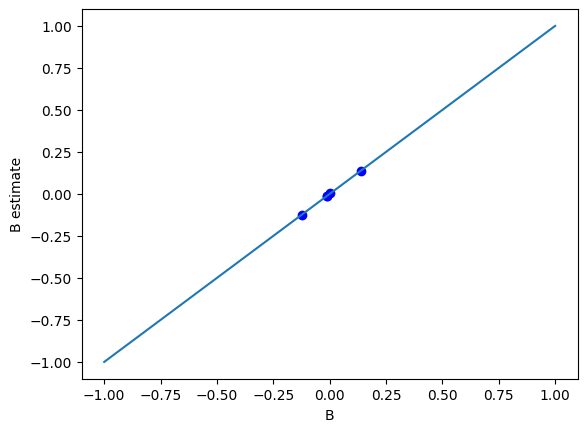

In [ ]:
plt.scatter(B, d2, c ="blue")
plt.xlabel("B")
plt.ylabel("B estimate")
plt.plot([-1, 1], [-1, 1])

In [ ]:
#n = 200
p3 = np.linalg.inv((15*np.identity(p))+(97*np.dot(X.T,X)))

In [ ]:
d3 = 97*np.dot(p3, np.dot(X.T,Y))

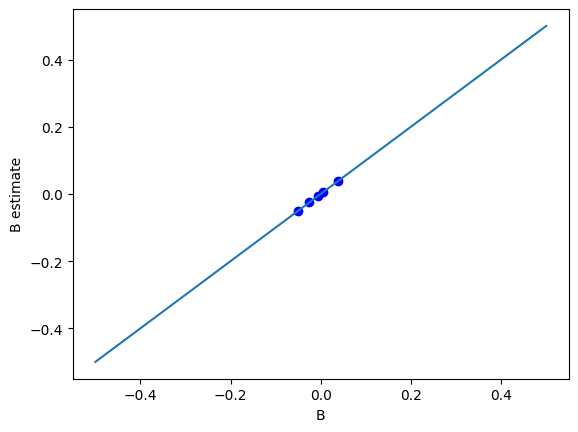

In [ ]:
plt.scatter(B, d3, c ="blue")
plt.xlabel("B")
plt.ylabel("B estimate")
plt.plot([-0.5, 0.5], [-0.5, 0.5])

In [ ]:
# n = 300
p4 = np.linalg.inv((19*np.identity(p))+(146*np.dot(X.T,X)))

In [ ]:
d4 = 146*np.dot(p4, np.dot(X.T,Y))

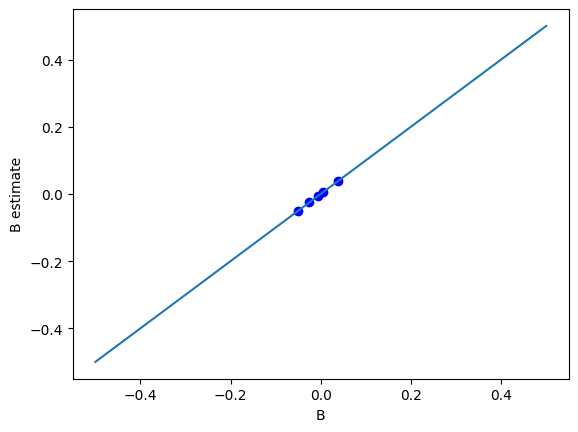

In [ ]:
plt.scatter(B, d4, c ="blue")
plt.xlabel("B")
plt.ylabel("B estimate")
plt.plot([-0.5, 0.5], [-0.5, 0.5])